BERT Helper notebook

In [106]:
import os

print(os.getcwd())

/home/vmadmin/notebooks/NLP


In [107]:
try:
    import pickle
    import data_loader as dl
    import nltk
    import torch
    import numpy as np
    from torch import tensor
    from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
    from torch.nn import CrossEntropyLoss
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    from torch.utils.data import Dataset, DataLoader
    from tqdm import tqdm
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import classification_report, confusion_matrix
    import os
    from transformers import BertTokenizerFast
    from sklearn.metrics import f1_score
    from collections import Counter
    import matplotlib.pyplot as plt
    import seaborn as sns
    import random
    from torch.nn.utils import clip_grad_norm_
    

    print("All imports successful!")

except ImportError as e:
    print(f"ImportError: {e}")

torch.cuda.manual_seed_all(7)

np.random.seed(7)

random.seed(7)

All imports successful!


In [108]:
class L1Dataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [109]:
print("Downloading NLTK punkt tokenizer...")
nltk.download('punkt')
print("NLTK punkt tokenizer downloaded.")

print("Loading data...")
cleaned_df = dl.get_clean_sentences_and_labels_wo_split_new("Final database (main prompts).xlsx",
                                                         "Final database (alternative prompts).xlsx")
print("Data loaded.")

NLTK punkt tokenizer downloaded.
Loading data...


[nltk_data] Downloading package punkt to /home/vmadmin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Data loaded.


In [110]:
print('Downsampling to treat label inbalance...')

label_counts = Counter(cleaned_df['l1'])
# Calculate the average count of instances across all labels
average_count = int(np.mean(list(label_counts.values())))

def downsample_to_average(df, label_col='l1'):
    df_list = []
    for label, count in label_counts.items():
        label_df = df[df[label_col] == label]
        if count > average_count:
            label_df = label_df.sample(average_count)
        df_list.append(label_df)
    return pd.concat(df_list)

# Apply downsampling
downsampled_df = downsample_to_average(cleaned_df)

# Reset index after downsampling
downsampled_df = downsampled_df.reset_index(drop=True)
print('Downsampling complete')

print("Splitting data into train and test sets...")
train_X, test_X, train_Y, test_Y = train_test_split(downsampled_df['cleaned_text_corrected'], downsampled_df['l1'],
                                                    train_size=0.7, random_state=7)
print("Data split into train and test sets.")

Downsampling to treat label inbalance...
Downsampling complete
Splitting data into train and test sets...
Data split into train and test sets.


In [5]:
# print("Splitting data into train and test sets...")
# train_X, test_X, train_Y, test_Y = train_test_split(cleaned_df['cleaned_text_corrected'], cleaned_df['l1'],
#                                                     train_size=0.7)
# print("Data split into train and test sets.")

Splitting data into train and test sets...
Data split into train and test sets.


In [111]:
max_len = 128


print("Loading BERT tokenizer...")
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
print("BERT tokenizer FAST loaded.")

print("Tokenizing training and test data...")
train_tokens = tokenizer(list(train_X), padding=True, truncation=True, return_tensors='pt',max_length = max_len)
test_tokens = tokenizer(list(test_X), padding=True, truncation=True, return_tensors='pt',max_length = max_len)
print("Data tokenized.")


Loading BERT tokenizer...
BERT tokenizer FAST loaded.
Tokenizing training and test data...


/home/vmadmin/miniforge3/envs/py39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Data tokenized.


In [112]:
print("Encoding labels...")
label_encoder = LabelEncoder()
train_Y_encoded = label_encoder.fit_transform(train_Y)
test_Y_encoded = label_encoder.transform(test_Y)
print("Labels encoded.")

print("Loading BERT model for sequence classification...")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train_Y_encoded)),
                                                      hidden_dropout_prob=0.3)
print("BERT model loaded.")

print("Preparing datasets and data loaders...")
train_dataset = L1Dataset(train_tokens, train_Y_encoded)
test_dataset = L1Dataset(test_tokens, test_Y_encoded)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Datasets and data loaders prepared.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Wrap the model with DataParallel to use multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

model.to(device)

#print("Calculating class weights...")
#class_weights = compute_class_weight('balanced', classes=np.unique(train_Y_encoded), y=train_Y_encoded)
#class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
#loss_fn = CrossEntropyLoss(weight=class_weights)
#print("Class weights calculated.")

loss_fn = CrossEntropyLoss()

print("Setting up optimizer and scheduler...")
#epochs = 5
epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_loader) * epochs
#usually num_warmup_steps = 10% from num_training_steps
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

print("Optimizer and scheduler set up.")


Encoding labels...
Labels encoded.
Loading BERT model for sequence classification...


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BERT model loaded.
Preparing datasets and data loaders...
Datasets and data loaders prepared.
Using device: cuda
Using 2 GPUs
Setting up optimizer and scheduler...
Optimizer and scheduler set up.


/home/vmadmin/miniforge3/envs/py39/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [113]:
accumulation_steps = 4
max_grad_norm = 1.0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}")):
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'],
                        labels=batch['labels'])
        
        # Assuming the loss is already calculated in outputs.loss
        loss = outputs.loss.mean()  # Average the loss if it has multiple elements

        # Scale the loss by accumulation steps
        loss = loss / accumulation_steps
        total_loss += loss.item()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_grad_norm)

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx} - Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss:.4f}")


Training Epoch 1/3:   0%|          | 0/9290 [00:00<?, ?it/s]/home/vmadmin/miniforge3/envs/py39/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/vmadmin/miniforge3/envs/py39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Training Epoch 1/3:   0%|          | 1/9290 [00:00<1:58:51,  1.30it/s]

Batch 0 - Loss: 0.6235


Training Epoch 1/3:   0%|          | 11/9290 [00:06<1:40:16,  1.54it/s]

Batch 10 - Loss: 0.5971


Training Epoch 1/3:   0%|          | 21/9290 [00:12<1:38:27,  1.57it/s]

Batch 20 - Loss: 0.5870


Training Epoch 1/3:   0%|          | 31/9290 [00:18<1:39:56,  1.54it/s]

Batch 30 - Loss: 0.5737


Training Epoch 1/3:   0%|          | 41/9290 [00:24<1:46:07,  1.45it/s]

Batch 40 - Loss: 0.5665


Training Epoch 1/3:   1%|          | 51/9290 [00:29<1:40:08,  1.54it/s]

Batch 50 - Loss: 0.5926


Training Epoch 1/3:   1%|          | 61/9290 [00:35<1:38:34,  1.56it/s]

Batch 60 - Loss: 0.5708


Training Epoch 1/3:   1%|          | 71/9290 [00:41<1:39:23,  1.55it/s]

Batch 70 - Loss: 0.5904


Training Epoch 1/3:   1%|          | 81/9290 [00:47<1:37:41,  1.57it/s]

Batch 80 - Loss: 0.5866


Training Epoch 1/3:   1%|          | 91/9290 [00:53<1:39:28,  1.54it/s]

Batch 90 - Loss: 0.5771


Training Epoch 1/3:   1%|          | 101/9290 [00:58<1:37:32,  1.57it/s]

Batch 100 - Loss: 0.5847


Training Epoch 1/3:   1%|          | 111/9290 [01:04<1:39:33,  1.54it/s]

Batch 110 - Loss: 0.5443


Training Epoch 1/3:   1%|▏         | 121/9290 [01:10<1:36:55,  1.58it/s]

Batch 120 - Loss: 0.5492


Training Epoch 1/3:   1%|▏         | 131/9290 [01:16<1:39:20,  1.54it/s]

Batch 130 - Loss: 0.5434


Training Epoch 1/3:   2%|▏         | 141/9290 [01:22<1:37:02,  1.57it/s]

Batch 140 - Loss: 0.5723


Training Epoch 1/3:   2%|▏         | 151/9290 [01:28<1:38:50,  1.54it/s]

Batch 150 - Loss: 0.5892


Training Epoch 1/3:   2%|▏         | 161/9290 [01:33<1:37:42,  1.56it/s]

Batch 160 - Loss: 0.5634


Training Epoch 1/3:   2%|▏         | 171/9290 [01:39<1:38:22,  1.55it/s]

Batch 170 - Loss: 0.5561


Training Epoch 1/3:   2%|▏         | 181/9290 [01:45<1:36:41,  1.57it/s]

Batch 180 - Loss: 0.5772


Training Epoch 1/3:   2%|▏         | 191/9290 [01:51<1:39:15,  1.53it/s]

Batch 190 - Loss: 0.5541


Training Epoch 1/3:   2%|▏         | 201/9290 [01:57<1:37:05,  1.56it/s]

Batch 200 - Loss: 0.5402


Training Epoch 1/3:   2%|▏         | 211/9290 [02:02<1:37:03,  1.56it/s]

Batch 210 - Loss: 0.5394


Training Epoch 1/3:   2%|▏         | 221/9290 [02:08<1:37:00,  1.56it/s]

Batch 220 - Loss: 0.5671


Training Epoch 1/3:   2%|▏         | 231/9290 [02:14<1:38:11,  1.54it/s]

Batch 230 - Loss: 0.5144


Training Epoch 1/3:   3%|▎         | 241/9290 [02:20<1:35:27,  1.58it/s]

Batch 240 - Loss: 0.5896


Training Epoch 1/3:   3%|▎         | 251/9290 [02:26<1:38:11,  1.53it/s]

Batch 250 - Loss: 0.5063


Training Epoch 1/3:   3%|▎         | 261/9290 [02:32<1:36:44,  1.56it/s]

Batch 260 - Loss: 0.5353


Training Epoch 1/3:   3%|▎         | 271/9290 [02:38<1:44:24,  1.44it/s]

Batch 270 - Loss: 0.5346


Training Epoch 1/3:   3%|▎         | 281/9290 [02:43<1:35:54,  1.57it/s]

Batch 280 - Loss: 0.5331


Training Epoch 1/3:   3%|▎         | 291/9290 [02:49<1:37:42,  1.53it/s]

Batch 290 - Loss: 0.5123


Training Epoch 1/3:   3%|▎         | 301/9290 [02:55<1:36:45,  1.55it/s]

Batch 300 - Loss: 0.5276


Training Epoch 1/3:   3%|▎         | 311/9290 [03:01<1:37:32,  1.53it/s]

Batch 310 - Loss: 0.5369


Training Epoch 1/3:   3%|▎         | 321/9290 [03:07<1:35:49,  1.56it/s]

Batch 320 - Loss: 0.4719


Training Epoch 1/3:   4%|▎         | 331/9290 [03:13<1:36:57,  1.54it/s]

Batch 330 - Loss: 0.5132


Training Epoch 1/3:   4%|▎         | 341/9290 [03:18<1:35:44,  1.56it/s]

Batch 340 - Loss: 0.4678


Training Epoch 1/3:   4%|▍         | 351/9290 [03:24<1:36:18,  1.55it/s]

Batch 350 - Loss: 0.4968


Training Epoch 1/3:   4%|▍         | 361/9290 [03:30<1:35:18,  1.56it/s]

Batch 360 - Loss: 0.4869


Training Epoch 1/3:   4%|▍         | 371/9290 [03:36<1:36:16,  1.54it/s]

Batch 370 - Loss: 0.5060


Training Epoch 1/3:   4%|▍         | 381/9290 [03:42<1:35:08,  1.56it/s]

Batch 380 - Loss: 0.4759


Training Epoch 1/3:   4%|▍         | 391/9290 [03:47<1:36:11,  1.54it/s]

Batch 390 - Loss: 0.5338


Training Epoch 1/3:   4%|▍         | 401/9290 [03:53<1:34:14,  1.57it/s]

Batch 400 - Loss: 0.4543


Training Epoch 1/3:   4%|▍         | 411/9290 [03:59<1:36:26,  1.53it/s]

Batch 410 - Loss: 0.5122


Training Epoch 1/3:   5%|▍         | 421/9290 [04:05<1:34:05,  1.57it/s]

Batch 420 - Loss: 0.4482


Training Epoch 1/3:   5%|▍         | 431/9290 [04:11<1:35:28,  1.55it/s]

Batch 430 - Loss: 0.4918


Training Epoch 1/3:   5%|▍         | 441/9290 [04:16<1:33:41,  1.57it/s]

Batch 440 - Loss: 0.4672


Training Epoch 1/3:   5%|▍         | 451/9290 [04:22<1:34:33,  1.56it/s]

Batch 450 - Loss: 0.5218


Training Epoch 1/3:   5%|▍         | 461/9290 [04:28<1:34:12,  1.56it/s]

Batch 460 - Loss: 0.5402


Training Epoch 1/3:   5%|▌         | 471/9290 [04:34<1:36:03,  1.53it/s]

Batch 470 - Loss: 0.5059


Training Epoch 1/3:   5%|▌         | 481/9290 [04:40<1:33:04,  1.58it/s]

Batch 480 - Loss: 0.4503


Training Epoch 1/3:   5%|▌         | 491/9290 [04:45<1:35:16,  1.54it/s]

Batch 490 - Loss: 0.4309


Training Epoch 1/3:   5%|▌         | 501/9290 [04:52<1:34:52,  1.54it/s]

Batch 500 - Loss: 0.4706


Training Epoch 1/3:   6%|▌         | 511/9290 [04:57<1:34:59,  1.54it/s]

Batch 510 - Loss: 0.4418


Training Epoch 1/3:   6%|▌         | 521/9290 [05:03<1:33:42,  1.56it/s]

Batch 520 - Loss: 0.4536


Training Epoch 1/3:   6%|▌         | 531/9290 [05:09<1:35:28,  1.53it/s]

Batch 530 - Loss: 0.4673


Training Epoch 1/3:   6%|▌         | 541/9290 [05:15<1:35:09,  1.53it/s]

Batch 540 - Loss: 0.4840


Training Epoch 1/3:   6%|▌         | 551/9290 [05:21<1:34:39,  1.54it/s]

Batch 550 - Loss: 0.4808


Training Epoch 1/3:   6%|▌         | 561/9290 [05:27<1:33:03,  1.56it/s]

Batch 560 - Loss: 0.4413


Training Epoch 1/3:   6%|▌         | 571/9290 [05:32<1:34:27,  1.54it/s]

Batch 570 - Loss: 0.4844


Training Epoch 1/3:   6%|▋         | 581/9290 [05:38<1:32:54,  1.56it/s]

Batch 580 - Loss: 0.4430


Training Epoch 1/3:   6%|▋         | 591/9290 [05:44<1:34:24,  1.54it/s]

Batch 590 - Loss: 0.3938


Training Epoch 1/3:   6%|▋         | 601/9290 [05:50<1:32:20,  1.57it/s]

Batch 600 - Loss: 0.4099


Training Epoch 1/3:   7%|▋         | 611/9290 [05:56<1:35:07,  1.52it/s]

Batch 610 - Loss: 0.4648


Training Epoch 1/3:   7%|▋         | 621/9290 [06:02<1:33:04,  1.55it/s]

Batch 620 - Loss: 0.4758


Training Epoch 1/3:   7%|▋         | 631/9290 [06:07<1:33:07,  1.55it/s]

Batch 630 - Loss: 0.3984


Training Epoch 1/3:   7%|▋         | 641/9290 [06:13<1:31:44,  1.57it/s]

Batch 640 - Loss: 0.5189


Training Epoch 1/3:   7%|▋         | 651/9290 [06:19<1:34:07,  1.53it/s]

Batch 650 - Loss: 0.4309


Training Epoch 1/3:   7%|▋         | 661/9290 [06:25<1:31:41,  1.57it/s]

Batch 660 - Loss: 0.3743


Training Epoch 1/3:   7%|▋         | 671/9290 [06:31<1:32:26,  1.55it/s]

Batch 670 - Loss: 0.4558


Training Epoch 1/3:   7%|▋         | 681/9290 [06:36<1:32:08,  1.56it/s]

Batch 680 - Loss: 0.4269


Training Epoch 1/3:   7%|▋         | 691/9290 [06:42<1:33:29,  1.53it/s]

Batch 690 - Loss: 0.4087


Training Epoch 1/3:   8%|▊         | 701/9290 [06:48<1:30:58,  1.57it/s]

Batch 700 - Loss: 0.4455


Training Epoch 1/3:   8%|▊         | 711/9290 [06:54<1:32:16,  1.55it/s]

Batch 710 - Loss: 0.4639


Training Epoch 1/3:   8%|▊         | 721/9290 [07:00<1:30:31,  1.58it/s]

Batch 720 - Loss: 0.4285


Training Epoch 1/3:   8%|▊         | 731/9290 [07:06<1:34:20,  1.51it/s]

Batch 730 - Loss: 0.4811


Training Epoch 1/3:   8%|▊         | 741/9290 [07:12<1:31:42,  1.55it/s]

Batch 740 - Loss: 0.4453


Training Epoch 1/3:   8%|▊         | 751/9290 [07:17<1:32:01,  1.55it/s]

Batch 750 - Loss: 0.4647


Training Epoch 1/3:   8%|▊         | 761/9290 [07:23<1:30:30,  1.57it/s]

Batch 760 - Loss: 0.4249


Training Epoch 1/3:   8%|▊         | 771/9290 [07:29<1:32:34,  1.53it/s]

Batch 770 - Loss: 0.4506


Training Epoch 1/3:   8%|▊         | 781/9290 [07:35<1:30:30,  1.57it/s]

Batch 780 - Loss: 0.4667


Training Epoch 1/3:   9%|▊         | 791/9290 [07:41<1:32:27,  1.53it/s]

Batch 790 - Loss: 0.3573


Training Epoch 1/3:   9%|▊         | 801/9290 [07:46<1:30:31,  1.56it/s]

Batch 800 - Loss: 0.4386


Training Epoch 1/3:   9%|▊         | 811/9290 [07:52<1:31:35,  1.54it/s]

Batch 810 - Loss: 0.4506


Training Epoch 1/3:   9%|▉         | 821/9290 [07:58<1:29:41,  1.57it/s]

Batch 820 - Loss: 0.4170


Training Epoch 1/3:   9%|▉         | 831/9290 [08:04<1:30:47,  1.55it/s]

Batch 830 - Loss: 0.4548


Training Epoch 1/3:   9%|▉         | 841/9290 [08:10<1:30:07,  1.56it/s]

Batch 840 - Loss: 0.4866


Training Epoch 1/3:   9%|▉         | 851/9290 [08:15<1:30:38,  1.55it/s]

Batch 850 - Loss: 0.4578


Training Epoch 1/3:   9%|▉         | 861/9290 [08:21<1:30:17,  1.56it/s]

Batch 860 - Loss: 0.4221


Training Epoch 1/3:   9%|▉         | 871/9290 [08:27<1:31:19,  1.54it/s]

Batch 870 - Loss: 0.4376


Training Epoch 1/3:   9%|▉         | 881/9290 [08:33<1:29:05,  1.57it/s]

Batch 880 - Loss: 0.4534


Training Epoch 1/3:  10%|▉         | 891/9290 [08:39<1:30:58,  1.54it/s]

Batch 890 - Loss: 0.4787


Training Epoch 1/3:  10%|▉         | 901/9290 [08:44<1:29:30,  1.56it/s]

Batch 900 - Loss: 0.4298


Training Epoch 1/3:  10%|▉         | 911/9290 [08:50<1:30:06,  1.55it/s]

Batch 910 - Loss: 0.4343


Training Epoch 1/3:  10%|▉         | 921/9290 [08:56<1:29:29,  1.56it/s]

Batch 920 - Loss: 0.4357


Training Epoch 1/3:  10%|█         | 931/9290 [09:02<1:30:19,  1.54it/s]

Batch 930 - Loss: 0.4263


Training Epoch 1/3:  10%|█         | 941/9290 [09:08<1:28:38,  1.57it/s]

Batch 940 - Loss: 0.4415


Training Epoch 1/3:  10%|█         | 951/9290 [09:13<1:29:49,  1.55it/s]

Batch 950 - Loss: 0.4667


Training Epoch 1/3:  10%|█         | 961/9290 [09:19<1:30:28,  1.53it/s]

Batch 960 - Loss: 0.3971


Training Epoch 1/3:  10%|█         | 971/9290 [09:25<1:29:33,  1.55it/s]

Batch 970 - Loss: 0.4513


Training Epoch 1/3:  11%|█         | 981/9290 [09:31<1:28:25,  1.57it/s]

Batch 980 - Loss: 0.4104


Training Epoch 1/3:  11%|█         | 991/9290 [09:37<1:29:37,  1.54it/s]

Batch 990 - Loss: 0.4087


Training Epoch 1/3:  11%|█         | 1001/9290 [09:43<1:28:03,  1.57it/s]

Batch 1000 - Loss: 0.3838


Training Epoch 1/3:  11%|█         | 1011/9290 [09:48<1:29:27,  1.54it/s]

Batch 1010 - Loss: 0.5036


Training Epoch 1/3:  11%|█         | 1021/9290 [09:54<1:27:50,  1.57it/s]

Batch 1020 - Loss: 0.4295


Training Epoch 1/3:  11%|█         | 1031/9290 [10:00<1:29:32,  1.54it/s]

Batch 1030 - Loss: 0.4066


Training Epoch 1/3:  11%|█         | 1041/9290 [10:06<1:27:58,  1.56it/s]

Batch 1040 - Loss: 0.4485


Training Epoch 1/3:  11%|█▏        | 1051/9290 [10:12<1:29:32,  1.53it/s]

Batch 1050 - Loss: 0.4281


Training Epoch 1/3:  11%|█▏        | 1061/9290 [10:17<1:27:50,  1.56it/s]

Batch 1060 - Loss: 0.3884


Training Epoch 1/3:  12%|█▏        | 1071/9290 [10:23<1:28:40,  1.54it/s]

Batch 1070 - Loss: 0.4817


Training Epoch 1/3:  12%|█▏        | 1081/9290 [10:29<1:26:54,  1.57it/s]

Batch 1080 - Loss: 0.3494


Training Epoch 1/3:  12%|█▏        | 1091/9290 [10:35<1:29:09,  1.53it/s]

Batch 1090 - Loss: 0.4350


Training Epoch 1/3:  12%|█▏        | 1101/9290 [10:41<1:27:37,  1.56it/s]

Batch 1100 - Loss: 0.4044


Training Epoch 1/3:  12%|█▏        | 1111/9290 [10:46<1:27:48,  1.55it/s]

Batch 1110 - Loss: 0.3820


Training Epoch 1/3:  12%|█▏        | 1121/9290 [10:52<1:26:52,  1.57it/s]

Batch 1120 - Loss: 0.3741


Training Epoch 1/3:  12%|█▏        | 1131/9290 [10:58<1:28:27,  1.54it/s]

Batch 1130 - Loss: 0.3570


Training Epoch 1/3:  12%|█▏        | 1141/9290 [11:04<1:26:22,  1.57it/s]

Batch 1140 - Loss: 0.3390


Training Epoch 1/3:  12%|█▏        | 1151/9290 [11:10<1:28:26,  1.53it/s]

Batch 1150 - Loss: 0.3559


Training Epoch 1/3:  12%|█▏        | 1161/9290 [11:16<1:26:42,  1.56it/s]

Batch 1160 - Loss: 0.3817


Training Epoch 1/3:  13%|█▎        | 1171/9290 [11:21<1:27:57,  1.54it/s]

Batch 1170 - Loss: 0.4035


Training Epoch 1/3:  13%|█▎        | 1181/9290 [11:27<1:37:59,  1.38it/s]

Batch 1180 - Loss: 0.3610


Training Epoch 1/3:  13%|█▎        | 1191/9290 [11:33<1:27:45,  1.54it/s]

Batch 1190 - Loss: 0.3901


Training Epoch 1/3:  13%|█▎        | 1201/9290 [11:39<1:26:35,  1.56it/s]

Batch 1200 - Loss: 0.4305


Training Epoch 1/3:  13%|█▎        | 1211/9290 [11:45<1:27:57,  1.53it/s]

Batch 1210 - Loss: 0.4864


Training Epoch 1/3:  13%|█▎        | 1221/9290 [11:51<1:25:42,  1.57it/s]

Batch 1220 - Loss: 0.4114


Training Epoch 1/3:  13%|█▎        | 1231/9290 [11:57<1:27:42,  1.53it/s]

Batch 1230 - Loss: 0.3539


Training Epoch 1/3:  13%|█▎        | 1241/9290 [12:02<1:25:49,  1.56it/s]

Batch 1240 - Loss: 0.4928


Training Epoch 1/3:  13%|█▎        | 1251/9290 [12:08<1:27:04,  1.54it/s]

Batch 1250 - Loss: 0.4060


Training Epoch 1/3:  14%|█▎        | 1261/9290 [12:14<1:25:55,  1.56it/s]

Batch 1260 - Loss: 0.3395


Training Epoch 1/3:  14%|█▎        | 1271/9290 [12:20<1:26:26,  1.55it/s]

Batch 1270 - Loss: 0.4186


Training Epoch 1/3:  14%|█▍        | 1281/9290 [12:26<1:25:29,  1.56it/s]

Batch 1280 - Loss: 0.3730


Training Epoch 1/3:  14%|█▍        | 1291/9290 [12:31<1:26:33,  1.54it/s]

Batch 1290 - Loss: 0.4187


Training Epoch 1/3:  14%|█▍        | 1301/9290 [12:37<1:24:39,  1.57it/s]

Batch 1300 - Loss: 0.4473


Training Epoch 1/3:  14%|█▍        | 1311/9290 [12:43<1:26:34,  1.54it/s]

Batch 1310 - Loss: 0.4380


Training Epoch 1/3:  14%|█▍        | 1321/9290 [12:49<1:25:07,  1.56it/s]

Batch 1320 - Loss: 0.3807


Training Epoch 1/3:  14%|█▍        | 1331/9290 [12:55<1:26:08,  1.54it/s]

Batch 1330 - Loss: 0.3402


Training Epoch 1/3:  14%|█▍        | 1341/9290 [13:00<1:24:55,  1.56it/s]

Batch 1340 - Loss: 0.3736


Training Epoch 1/3:  15%|█▍        | 1351/9290 [13:06<1:26:00,  1.54it/s]

Batch 1350 - Loss: 0.4066


Training Epoch 1/3:  15%|█▍        | 1361/9290 [13:12<1:24:23,  1.57it/s]

Batch 1360 - Loss: 0.4410


Training Epoch 1/3:  15%|█▍        | 1371/9290 [13:18<1:24:59,  1.55it/s]

Batch 1370 - Loss: 0.3515


Training Epoch 1/3:  15%|█▍        | 1381/9290 [13:24<1:24:37,  1.56it/s]

Batch 1380 - Loss: 0.3865


Training Epoch 1/3:  15%|█▍        | 1391/9290 [13:29<1:25:05,  1.55it/s]

Batch 1390 - Loss: 0.3031


Training Epoch 1/3:  15%|█▌        | 1401/9290 [13:35<1:24:10,  1.56it/s]

Batch 1400 - Loss: 0.3658


Training Epoch 1/3:  15%|█▌        | 1411/9290 [13:41<1:33:28,  1.40it/s]

Batch 1410 - Loss: 0.3610


Training Epoch 1/3:  15%|█▌        | 1421/9290 [13:47<1:24:45,  1.55it/s]

Batch 1420 - Loss: 0.4368


Training Epoch 1/3:  15%|█▌        | 1431/9290 [13:53<1:25:36,  1.53it/s]

Batch 1430 - Loss: 0.4870


Training Epoch 1/3:  16%|█▌        | 1441/9290 [13:59<1:24:03,  1.56it/s]

Batch 1440 - Loss: 0.4564


Training Epoch 1/3:  16%|█▌        | 1451/9290 [14:05<1:24:15,  1.55it/s]

Batch 1450 - Loss: 0.4224


Training Epoch 1/3:  16%|█▌        | 1461/9290 [14:10<1:23:17,  1.57it/s]

Batch 1460 - Loss: 0.4052


Training Epoch 1/3:  16%|█▌        | 1471/9290 [14:16<1:24:35,  1.54it/s]

Batch 1470 - Loss: 0.3479


Training Epoch 1/3:  16%|█▌        | 1481/9290 [14:22<1:23:19,  1.56it/s]

Batch 1480 - Loss: 0.4542


Training Epoch 1/3:  16%|█▌        | 1491/9290 [14:28<1:23:45,  1.55it/s]

Batch 1490 - Loss: 0.3635


Training Epoch 1/3:  16%|█▌        | 1501/9290 [14:34<1:23:22,  1.56it/s]

Batch 1500 - Loss: 0.5362


Training Epoch 1/3:  16%|█▋        | 1511/9290 [14:39<1:24:00,  1.54it/s]

Batch 1510 - Loss: 0.3225


Training Epoch 1/3:  16%|█▋        | 1521/9290 [14:45<1:22:59,  1.56it/s]

Batch 1520 - Loss: 0.3629


Training Epoch 1/3:  16%|█▋        | 1531/9290 [14:51<1:23:42,  1.54it/s]

Batch 1530 - Loss: 0.4395


Training Epoch 1/3:  17%|█▋        | 1541/9290 [14:57<1:22:29,  1.57it/s]

Batch 1540 - Loss: 0.3755


Training Epoch 1/3:  17%|█▋        | 1551/9290 [15:03<1:23:38,  1.54it/s]

Batch 1550 - Loss: 0.3032


Training Epoch 1/3:  17%|█▋        | 1561/9290 [15:09<1:21:23,  1.58it/s]

Batch 1560 - Loss: 0.5036


Training Epoch 1/3:  17%|█▋        | 1571/9290 [15:14<1:23:10,  1.55it/s]

Batch 1570 - Loss: 0.3892


Training Epoch 1/3:  17%|█▋        | 1581/9290 [15:20<1:21:37,  1.57it/s]

Batch 1580 - Loss: 0.4515


Training Epoch 1/3:  17%|█▋        | 1591/9290 [15:26<1:22:48,  1.55it/s]

Batch 1590 - Loss: 0.3688


Training Epoch 1/3:  17%|█▋        | 1601/9290 [15:32<1:22:04,  1.56it/s]

Batch 1600 - Loss: 0.3479


Training Epoch 1/3:  17%|█▋        | 1611/9290 [15:38<1:23:13,  1.54it/s]

Batch 1610 - Loss: 0.3905


Training Epoch 1/3:  17%|█▋        | 1621/9290 [15:43<1:21:56,  1.56it/s]

Batch 1620 - Loss: 0.4210


Training Epoch 1/3:  18%|█▊        | 1631/9290 [15:49<1:24:10,  1.52it/s]

Batch 1630 - Loss: 0.3931


Training Epoch 1/3:  18%|█▊        | 1641/9290 [15:55<1:21:57,  1.56it/s]

Batch 1640 - Loss: 0.3431


Training Epoch 1/3:  18%|█▊        | 1651/9290 [16:01<1:23:16,  1.53it/s]

Batch 1650 - Loss: 0.4327


Training Epoch 1/3:  18%|█▊        | 1661/9290 [16:07<1:20:53,  1.57it/s]

Batch 1660 - Loss: 0.3701


Training Epoch 1/3:  18%|█▊        | 1671/9290 [16:13<1:22:14,  1.54it/s]

Batch 1670 - Loss: 0.4517


Training Epoch 1/3:  18%|█▊        | 1681/9290 [16:19<1:21:27,  1.56it/s]

Batch 1680 - Loss: 0.3897


Training Epoch 1/3:  18%|█▊        | 1691/9290 [16:24<1:22:28,  1.54it/s]

Batch 1690 - Loss: 0.3360


Training Epoch 1/3:  18%|█▊        | 1701/9290 [16:30<1:20:50,  1.56it/s]

Batch 1700 - Loss: 0.3882


Training Epoch 1/3:  18%|█▊        | 1711/9290 [16:36<1:22:00,  1.54it/s]

Batch 1710 - Loss: 0.4456


Training Epoch 1/3:  19%|█▊        | 1721/9290 [16:42<1:20:40,  1.56it/s]

Batch 1720 - Loss: 0.4140


Training Epoch 1/3:  19%|█▊        | 1731/9290 [16:48<1:21:24,  1.55it/s]

Batch 1730 - Loss: 0.4495


Training Epoch 1/3:  19%|█▊        | 1741/9290 [16:54<1:20:47,  1.56it/s]

Batch 1740 - Loss: 0.4384


Training Epoch 1/3:  19%|█▉        | 1751/9290 [16:59<1:21:29,  1.54it/s]

Batch 1750 - Loss: 0.4640


Training Epoch 1/3:  19%|█▉        | 1761/9290 [17:05<1:20:03,  1.57it/s]

Batch 1760 - Loss: 0.3172


Training Epoch 1/3:  19%|█▉        | 1771/9290 [17:11<1:20:42,  1.55it/s]

Batch 1770 - Loss: 0.2747


Training Epoch 1/3:  19%|█▉        | 1781/9290 [17:17<1:19:54,  1.57it/s]

Batch 1780 - Loss: 0.3437


Training Epoch 1/3:  19%|█▉        | 1791/9290 [17:23<1:20:20,  1.56it/s]

Batch 1790 - Loss: 0.3809


Training Epoch 1/3:  19%|█▉        | 1801/9290 [17:28<1:19:30,  1.57it/s]

Batch 1800 - Loss: 0.3885


Training Epoch 1/3:  19%|█▉        | 1811/9290 [17:34<1:21:17,  1.53it/s]

Batch 1810 - Loss: 0.3709


Training Epoch 1/3:  20%|█▉        | 1821/9290 [17:40<1:19:56,  1.56it/s]

Batch 1820 - Loss: 0.4003


Training Epoch 1/3:  20%|█▉        | 1831/9290 [17:46<1:21:22,  1.53it/s]

Batch 1830 - Loss: 0.3976


Training Epoch 1/3:  20%|█▉        | 1841/9290 [17:52<1:19:58,  1.55it/s]

Batch 1840 - Loss: 0.3952


Training Epoch 1/3:  20%|█▉        | 1851/9290 [17:57<1:20:09,  1.55it/s]

Batch 1850 - Loss: 0.4529


Training Epoch 1/3:  20%|██        | 1861/9290 [18:03<1:19:00,  1.57it/s]

Batch 1860 - Loss: 0.3622


Training Epoch 1/3:  20%|██        | 1871/9290 [18:09<1:22:31,  1.50it/s]

Batch 1870 - Loss: 0.3342


Training Epoch 1/3:  20%|██        | 1881/9290 [18:15<1:18:56,  1.56it/s]

Batch 1880 - Loss: 0.4348


Training Epoch 1/3:  20%|██        | 1891/9290 [18:21<1:20:35,  1.53it/s]

Batch 1890 - Loss: 0.3635


Training Epoch 1/3:  20%|██        | 1901/9290 [18:27<1:19:19,  1.55it/s]

Batch 1900 - Loss: 0.4217


Training Epoch 1/3:  21%|██        | 1911/9290 [18:32<1:19:39,  1.54it/s]

Batch 1910 - Loss: 0.3770


Training Epoch 1/3:  21%|██        | 1921/9290 [18:38<1:18:47,  1.56it/s]

Batch 1920 - Loss: 0.3279


Training Epoch 1/3:  21%|██        | 1931/9290 [18:44<1:19:17,  1.55it/s]

Batch 1930 - Loss: 0.3327


Training Epoch 1/3:  21%|██        | 1941/9290 [18:50<1:18:51,  1.55it/s]

Batch 1940 - Loss: 0.4854


Training Epoch 1/3:  21%|██        | 1951/9290 [18:56<1:18:41,  1.55it/s]

Batch 1950 - Loss: 0.3262


Training Epoch 1/3:  21%|██        | 1961/9290 [19:02<1:18:16,  1.56it/s]

Batch 1960 - Loss: 0.4260


Training Epoch 1/3:  21%|██        | 1971/9290 [19:07<1:18:44,  1.55it/s]

Batch 1970 - Loss: 0.4376


Training Epoch 1/3:  21%|██▏       | 1981/9290 [19:13<1:18:39,  1.55it/s]

Batch 1980 - Loss: 0.3896


Training Epoch 1/3:  21%|██▏       | 1991/9290 [19:19<1:20:01,  1.52it/s]

Batch 1990 - Loss: 0.4000


Training Epoch 1/3:  22%|██▏       | 2001/9290 [19:25<1:17:55,  1.56it/s]

Batch 2000 - Loss: 0.4162


Training Epoch 1/3:  22%|██▏       | 2011/9290 [19:31<1:17:58,  1.56it/s]

Batch 2010 - Loss: 0.3551


Training Epoch 1/3:  22%|██▏       | 2021/9290 [19:37<1:18:16,  1.55it/s]

Batch 2020 - Loss: 0.3786


Training Epoch 1/3:  22%|██▏       | 2031/9290 [19:42<1:18:59,  1.53it/s]

Batch 2030 - Loss: 0.3606


Training Epoch 1/3:  22%|██▏       | 2041/9290 [19:48<1:17:34,  1.56it/s]

Batch 2040 - Loss: 0.4028


Training Epoch 1/3:  22%|██▏       | 2051/9290 [19:54<1:18:15,  1.54it/s]

Batch 2050 - Loss: 0.3603


Training Epoch 1/3:  22%|██▏       | 2061/9290 [20:00<1:17:15,  1.56it/s]

Batch 2060 - Loss: 0.3035


Training Epoch 1/3:  22%|██▏       | 2071/9290 [20:06<1:18:02,  1.54it/s]

Batch 2070 - Loss: 0.4258


Training Epoch 1/3:  22%|██▏       | 2081/9290 [20:11<1:16:26,  1.57it/s]

Batch 2080 - Loss: 0.4115


Training Epoch 1/3:  23%|██▎       | 2091/9290 [20:17<1:17:42,  1.54it/s]

Batch 2090 - Loss: 0.4624


Training Epoch 1/3:  23%|██▎       | 2101/9290 [20:23<1:18:49,  1.52it/s]

Batch 2100 - Loss: 0.2971


Training Epoch 1/3:  23%|██▎       | 2111/9290 [20:29<1:17:36,  1.54it/s]

Batch 2110 - Loss: 0.3717


Training Epoch 1/3:  23%|██▎       | 2121/9290 [20:35<1:16:17,  1.57it/s]

Batch 2120 - Loss: 0.3440


Training Epoch 1/3:  23%|██▎       | 2131/9290 [20:41<1:17:10,  1.55it/s]

Batch 2130 - Loss: 0.3909


Training Epoch 1/3:  23%|██▎       | 2141/9290 [20:47<1:15:55,  1.57it/s]

Batch 2140 - Loss: 0.4510


Training Epoch 1/3:  23%|██▎       | 2151/9290 [20:52<1:17:08,  1.54it/s]

Batch 2150 - Loss: 0.4515


Training Epoch 1/3:  23%|██▎       | 2161/9290 [20:58<1:15:50,  1.57it/s]

Batch 2160 - Loss: 0.3188


Training Epoch 1/3:  23%|██▎       | 2171/9290 [21:04<1:16:22,  1.55it/s]

Batch 2170 - Loss: 0.4467


Training Epoch 1/3:  23%|██▎       | 2181/9290 [21:10<1:15:35,  1.57it/s]

Batch 2180 - Loss: 0.3325


Training Epoch 1/3:  24%|██▎       | 2191/9290 [21:16<1:16:40,  1.54it/s]

Batch 2190 - Loss: 0.4401


Training Epoch 1/3:  24%|██▎       | 2201/9290 [21:21<1:15:44,  1.56it/s]

Batch 2200 - Loss: 0.3506


Training Epoch 1/3:  24%|██▍       | 2211/9290 [21:27<1:16:20,  1.55it/s]

Batch 2210 - Loss: 0.4518


Training Epoch 1/3:  24%|██▍       | 2221/9290 [21:33<1:15:36,  1.56it/s]

Batch 2220 - Loss: 0.3786


Training Epoch 1/3:  24%|██▍       | 2231/9290 [21:39<1:16:34,  1.54it/s]

Batch 2230 - Loss: 0.2660


Training Epoch 1/3:  24%|██▍       | 2241/9290 [21:45<1:15:10,  1.56it/s]

Batch 2240 - Loss: 0.3145


Training Epoch 1/3:  24%|██▍       | 2251/9290 [21:50<1:16:21,  1.54it/s]

Batch 2250 - Loss: 0.3588


Training Epoch 1/3:  24%|██▍       | 2261/9290 [21:56<1:15:27,  1.55it/s]

Batch 2260 - Loss: 0.3915


Training Epoch 1/3:  24%|██▍       | 2271/9290 [22:02<1:15:43,  1.54it/s]

Batch 2270 - Loss: 0.3460


Training Epoch 1/3:  25%|██▍       | 2281/9290 [22:08<1:15:18,  1.55it/s]

Batch 2280 - Loss: 0.3849


Training Epoch 1/3:  25%|██▍       | 2291/9290 [22:14<1:15:51,  1.54it/s]

Batch 2290 - Loss: 0.3474


Training Epoch 1/3:  25%|██▍       | 2301/9290 [22:19<1:14:23,  1.57it/s]

Batch 2300 - Loss: 0.4243


Training Epoch 1/3:  25%|██▍       | 2311/9290 [22:25<1:15:18,  1.54it/s]

Batch 2310 - Loss: 0.3463


Training Epoch 1/3:  25%|██▍       | 2321/9290 [22:31<1:14:40,  1.56it/s]

Batch 2320 - Loss: 0.3203


Training Epoch 1/3:  25%|██▌       | 2331/9290 [22:37<1:15:35,  1.53it/s]

Batch 2330 - Loss: 0.3544


Training Epoch 1/3:  25%|██▌       | 2341/9290 [22:43<1:14:01,  1.56it/s]

Batch 2340 - Loss: 0.3807


Training Epoch 1/3:  25%|██▌       | 2351/9290 [22:49<1:15:38,  1.53it/s]

Batch 2350 - Loss: 0.3522


Training Epoch 1/3:  25%|██▌       | 2361/9290 [22:55<1:13:49,  1.56it/s]

Batch 2360 - Loss: 0.3354


Training Epoch 1/3:  26%|██▌       | 2371/9290 [23:00<1:15:14,  1.53it/s]

Batch 2370 - Loss: 0.3767


Training Epoch 1/3:  26%|██▌       | 2381/9290 [23:06<1:13:06,  1.57it/s]

Batch 2380 - Loss: 0.4040


Training Epoch 1/3:  26%|██▌       | 2391/9290 [23:12<1:14:44,  1.54it/s]

Batch 2390 - Loss: 0.2855


Training Epoch 1/3:  26%|██▌       | 2401/9290 [23:18<1:13:22,  1.56it/s]

Batch 2400 - Loss: 0.2780


Training Epoch 1/3:  26%|██▌       | 2411/9290 [23:24<1:13:48,  1.55it/s]

Batch 2410 - Loss: 0.3369


Training Epoch 1/3:  26%|██▌       | 2421/9290 [23:29<1:13:19,  1.56it/s]

Batch 2420 - Loss: 0.3316


Training Epoch 1/3:  26%|██▌       | 2431/9290 [23:35<1:13:59,  1.54it/s]

Batch 2430 - Loss: 0.3852


Training Epoch 1/3:  26%|██▋       | 2441/9290 [23:41<1:13:17,  1.56it/s]

Batch 2440 - Loss: 0.2777


Training Epoch 1/3:  26%|██▋       | 2451/9290 [23:47<1:14:12,  1.54it/s]

Batch 2450 - Loss: 0.3428


Training Epoch 1/3:  26%|██▋       | 2461/9290 [23:53<1:12:30,  1.57it/s]

Batch 2460 - Loss: 0.2854


Training Epoch 1/3:  27%|██▋       | 2471/9290 [23:59<1:13:58,  1.54it/s]

Batch 2470 - Loss: 0.3318


Training Epoch 1/3:  27%|██▋       | 2481/9290 [24:04<1:12:47,  1.56it/s]

Batch 2480 - Loss: 0.3287


Training Epoch 1/3:  27%|██▋       | 2491/9290 [24:10<1:12:56,  1.55it/s]

Batch 2490 - Loss: 0.3311


Training Epoch 1/3:  27%|██▋       | 2501/9290 [24:16<1:11:47,  1.58it/s]

Batch 2500 - Loss: 0.3516


Training Epoch 1/3:  27%|██▋       | 2511/9290 [24:22<1:13:13,  1.54it/s]

Batch 2510 - Loss: 0.3904


Training Epoch 1/3:  27%|██▋       | 2521/9290 [24:28<1:12:08,  1.56it/s]

Batch 2520 - Loss: 0.3533


Training Epoch 1/3:  27%|██▋       | 2531/9290 [24:33<1:13:01,  1.54it/s]

Batch 2530 - Loss: 0.3547


Training Epoch 1/3:  27%|██▋       | 2541/9290 [24:39<1:11:53,  1.56it/s]

Batch 2540 - Loss: 0.3986


Training Epoch 1/3:  27%|██▋       | 2551/9290 [24:45<1:12:58,  1.54it/s]

Batch 2550 - Loss: 0.3518


Training Epoch 1/3:  28%|██▊       | 2561/9290 [24:51<1:12:34,  1.55it/s]

Batch 2560 - Loss: 0.3392


Training Epoch 1/3:  28%|██▊       | 2571/9290 [24:57<1:12:49,  1.54it/s]

Batch 2570 - Loss: 0.3355


Training Epoch 1/3:  28%|██▊       | 2581/9290 [25:03<1:11:40,  1.56it/s]

Batch 2580 - Loss: 0.3320


Training Epoch 1/3:  28%|██▊       | 2591/9290 [25:08<1:12:25,  1.54it/s]

Batch 2590 - Loss: 0.3880


Training Epoch 1/3:  28%|██▊       | 2601/9290 [25:14<1:11:24,  1.56it/s]

Batch 2600 - Loss: 0.3413


Training Epoch 1/3:  28%|██▊       | 2611/9290 [25:20<1:11:59,  1.55it/s]

Batch 2610 - Loss: 0.4079


Training Epoch 1/3:  28%|██▊       | 2621/9290 [25:26<1:10:45,  1.57it/s]

Batch 2620 - Loss: 0.3425


Training Epoch 1/3:  28%|██▊       | 2631/9290 [25:32<1:11:53,  1.54it/s]

Batch 2630 - Loss: 0.4349


Training Epoch 1/3:  28%|██▊       | 2641/9290 [25:37<1:11:24,  1.55it/s]

Batch 2640 - Loss: 0.3166


Training Epoch 1/3:  29%|██▊       | 2651/9290 [25:43<1:11:26,  1.55it/s]

Batch 2650 - Loss: 0.4547


Training Epoch 1/3:  29%|██▊       | 2661/9290 [25:49<1:10:28,  1.57it/s]

Batch 2660 - Loss: 0.3209


Training Epoch 1/3:  29%|██▉       | 2671/9290 [25:55<1:12:14,  1.53it/s]

Batch 2670 - Loss: 0.3864


Training Epoch 1/3:  29%|██▉       | 2681/9290 [26:01<1:11:06,  1.55it/s]

Batch 2680 - Loss: 0.3946


Training Epoch 1/3:  29%|██▉       | 2691/9290 [26:07<1:12:17,  1.52it/s]

Batch 2690 - Loss: 0.3326


Training Epoch 1/3:  29%|██▉       | 2701/9290 [26:12<1:10:10,  1.57it/s]

Batch 2700 - Loss: 0.3384


Training Epoch 1/3:  29%|██▉       | 2711/9290 [26:18<1:11:05,  1.54it/s]

Batch 2710 - Loss: 0.3098


Training Epoch 1/3:  29%|██▉       | 2721/9290 [26:24<1:10:00,  1.56it/s]

Batch 2720 - Loss: 0.3239


Training Epoch 1/3:  29%|██▉       | 2731/9290 [26:30<1:10:53,  1.54it/s]

Batch 2730 - Loss: 0.3996


Training Epoch 1/3:  30%|██▉       | 2741/9290 [26:36<1:09:53,  1.56it/s]

Batch 2740 - Loss: 0.3879


Training Epoch 1/3:  30%|██▉       | 2751/9290 [26:41<1:11:12,  1.53it/s]

Batch 2750 - Loss: 0.3897


Training Epoch 1/3:  30%|██▉       | 2761/9290 [26:47<1:09:32,  1.56it/s]

Batch 2760 - Loss: 0.4025


Training Epoch 1/3:  30%|██▉       | 2771/9290 [26:53<1:10:53,  1.53it/s]

Batch 2770 - Loss: 0.3636


Training Epoch 1/3:  30%|██▉       | 2781/9290 [26:59<1:09:01,  1.57it/s]

Batch 2780 - Loss: 0.3885


Training Epoch 1/3:  30%|███       | 2791/9290 [27:05<1:10:34,  1.53it/s]

Batch 2790 - Loss: 0.3951


Training Epoch 1/3:  30%|███       | 2801/9290 [27:11<1:09:19,  1.56it/s]

Batch 2800 - Loss: 0.3125


Training Epoch 1/3:  30%|███       | 2811/9290 [27:17<1:09:47,  1.55it/s]

Batch 2810 - Loss: 0.2977


Training Epoch 1/3:  30%|███       | 2821/9290 [27:22<1:08:48,  1.57it/s]

Batch 2820 - Loss: 0.4627


Training Epoch 1/3:  30%|███       | 2831/9290 [27:28<1:09:40,  1.55it/s]

Batch 2830 - Loss: 0.2677


Training Epoch 1/3:  31%|███       | 2841/9290 [27:34<1:08:52,  1.56it/s]

Batch 2840 - Loss: 0.4352


Training Epoch 1/3:  31%|███       | 2851/9290 [27:40<1:09:34,  1.54it/s]

Batch 2850 - Loss: 0.3213


Training Epoch 1/3:  31%|███       | 2861/9290 [27:46<1:08:01,  1.58it/s]

Batch 2860 - Loss: 0.3669


Training Epoch 1/3:  31%|███       | 2871/9290 [27:51<1:09:21,  1.54it/s]

Batch 2870 - Loss: 0.2937


Training Epoch 1/3:  31%|███       | 2881/9290 [27:57<1:08:26,  1.56it/s]

Batch 2880 - Loss: 0.3791


Training Epoch 1/3:  31%|███       | 2891/9290 [28:03<1:09:16,  1.54it/s]

Batch 2890 - Loss: 0.4636


Training Epoch 1/3:  31%|███       | 2901/9290 [28:09<1:08:08,  1.56it/s]

Batch 2900 - Loss: 0.3670


Training Epoch 1/3:  31%|███▏      | 2911/9290 [28:15<1:09:36,  1.53it/s]

Batch 2910 - Loss: 0.2760


Training Epoch 1/3:  31%|███▏      | 2921/9290 [28:20<1:08:56,  1.54it/s]

Batch 2920 - Loss: 0.3791


Training Epoch 1/3:  32%|███▏      | 2931/9290 [28:26<1:08:34,  1.55it/s]

Batch 2930 - Loss: 0.2777


Training Epoch 1/3:  32%|███▏      | 2941/9290 [28:32<1:07:53,  1.56it/s]

Batch 2940 - Loss: 0.3193


Training Epoch 1/3:  32%|███▏      | 2951/9290 [28:38<1:09:09,  1.53it/s]

Batch 2950 - Loss: 0.2926


Training Epoch 1/3:  32%|███▏      | 2961/9290 [28:44<1:08:14,  1.55it/s]

Batch 2960 - Loss: 0.3405


Training Epoch 1/3:  32%|███▏      | 2971/9290 [28:50<1:08:28,  1.54it/s]

Batch 2970 - Loss: 0.3998


Training Epoch 1/3:  32%|███▏      | 2981/9290 [28:55<1:06:50,  1.57it/s]

Batch 2980 - Loss: 0.3643


Training Epoch 1/3:  32%|███▏      | 2991/9290 [29:01<1:07:30,  1.56it/s]

Batch 2990 - Loss: 0.3657


Training Epoch 1/3:  32%|███▏      | 3001/9290 [29:07<1:07:31,  1.55it/s]

Batch 3000 - Loss: 0.3164


Training Epoch 1/3:  32%|███▏      | 3011/9290 [29:13<1:10:52,  1.48it/s]

Batch 3010 - Loss: 0.4236


Training Epoch 1/3:  33%|███▎      | 3021/9290 [29:19<1:06:47,  1.56it/s]

Batch 3020 - Loss: 0.3247


Training Epoch 1/3:  33%|███▎      | 3031/9290 [29:25<1:08:23,  1.53it/s]

Batch 3030 - Loss: 0.3895


Training Epoch 1/3:  33%|███▎      | 3041/9290 [29:31<1:06:39,  1.56it/s]

Batch 3040 - Loss: 0.3780


Training Epoch 1/3:  33%|███▎      | 3051/9290 [29:36<1:08:31,  1.52it/s]

Batch 3050 - Loss: 0.3564


Training Epoch 1/3:  33%|███▎      | 3061/9290 [29:42<1:06:43,  1.56it/s]

Batch 3060 - Loss: 0.3132


Training Epoch 1/3:  33%|███▎      | 3071/9290 [29:48<1:06:50,  1.55it/s]

Batch 3070 - Loss: 0.2787


Training Epoch 1/3:  33%|███▎      | 3081/9290 [29:54<1:06:04,  1.57it/s]

Batch 3080 - Loss: 0.2970


Training Epoch 1/3:  33%|███▎      | 3091/9290 [30:00<1:06:24,  1.56it/s]

Batch 3090 - Loss: 0.2908


Training Epoch 1/3:  33%|███▎      | 3101/9290 [30:05<1:06:05,  1.56it/s]

Batch 3100 - Loss: 0.2756


Training Epoch 1/3:  33%|███▎      | 3111/9290 [30:11<1:07:03,  1.54it/s]

Batch 3110 - Loss: 0.3624


Training Epoch 1/3:  34%|███▎      | 3121/9290 [30:17<1:05:38,  1.57it/s]

Batch 3120 - Loss: 0.3411


Training Epoch 1/3:  34%|███▎      | 3131/9290 [30:23<1:06:42,  1.54it/s]

Batch 3130 - Loss: 0.3283


Training Epoch 1/3:  34%|███▍      | 3141/9290 [30:29<1:05:29,  1.56it/s]

Batch 3140 - Loss: 0.3594


Training Epoch 1/3:  34%|███▍      | 3151/9290 [30:34<1:06:05,  1.55it/s]

Batch 3150 - Loss: 0.3270


Training Epoch 1/3:  34%|███▍      | 3161/9290 [30:40<1:05:08,  1.57it/s]

Batch 3160 - Loss: 0.3482


Training Epoch 1/3:  34%|███▍      | 3171/9290 [30:46<1:06:01,  1.54it/s]

Batch 3170 - Loss: 0.3526


Training Epoch 1/3:  34%|███▍      | 3181/9290 [30:52<1:05:24,  1.56it/s]

Batch 3180 - Loss: 0.3650


Training Epoch 1/3:  34%|███▍      | 3191/9290 [30:58<1:05:42,  1.55it/s]

Batch 3190 - Loss: 0.4161


Training Epoch 1/3:  34%|███▍      | 3201/9290 [31:04<1:05:35,  1.55it/s]

Batch 3200 - Loss: 0.3381


Training Epoch 1/3:  35%|███▍      | 3211/9290 [31:09<1:05:51,  1.54it/s]

Batch 3210 - Loss: 0.2948


Training Epoch 1/3:  35%|███▍      | 3221/9290 [31:15<1:05:09,  1.55it/s]

Batch 3220 - Loss: 0.3767


Training Epoch 1/3:  35%|███▍      | 3231/9290 [31:21<1:05:24,  1.54it/s]

Batch 3230 - Loss: 0.2607


Training Epoch 1/3:  35%|███▍      | 3241/9290 [31:27<1:07:42,  1.49it/s]

Batch 3240 - Loss: 0.4078


Training Epoch 1/3:  35%|███▍      | 3251/9290 [31:33<1:05:38,  1.53it/s]

Batch 3250 - Loss: 0.4078


Training Epoch 1/3:  35%|███▌      | 3261/9290 [31:39<1:04:40,  1.55it/s]

Batch 3260 - Loss: 0.3364


Training Epoch 1/3:  35%|███▌      | 3271/9290 [31:45<1:04:40,  1.55it/s]

Batch 3270 - Loss: 0.3737


Training Epoch 1/3:  35%|███▌      | 3281/9290 [31:50<1:04:19,  1.56it/s]

Batch 3280 - Loss: 0.4001


Training Epoch 1/3:  35%|███▌      | 3291/9290 [31:56<1:04:56,  1.54it/s]

Batch 3290 - Loss: 0.3593


Training Epoch 1/3:  36%|███▌      | 3301/9290 [32:02<1:04:01,  1.56it/s]

Batch 3300 - Loss: 0.4407


Training Epoch 1/3:  36%|███▌      | 3311/9290 [32:08<1:03:47,  1.56it/s]

Batch 3310 - Loss: 0.3601


Training Epoch 1/3:  36%|███▌      | 3321/9290 [32:14<1:03:11,  1.57it/s]

Batch 3320 - Loss: 0.4100


Training Epoch 1/3:  36%|███▌      | 3331/9290 [32:19<1:04:31,  1.54it/s]

Batch 3330 - Loss: 0.3396


Training Epoch 1/3:  36%|███▌      | 3341/9290 [32:25<1:04:04,  1.55it/s]

Batch 3340 - Loss: 0.3529


Training Epoch 1/3:  36%|███▌      | 3351/9290 [32:31<1:04:27,  1.54it/s]

Batch 3350 - Loss: 0.3459


Training Epoch 1/3:  36%|███▌      | 3361/9290 [32:37<1:03:05,  1.57it/s]

Batch 3360 - Loss: 0.3485


Training Epoch 1/3:  36%|███▋      | 3371/9290 [32:43<1:04:03,  1.54it/s]

Batch 3370 - Loss: 0.3818


Training Epoch 1/3:  36%|███▋      | 3381/9290 [32:49<1:02:47,  1.57it/s]

Batch 3380 - Loss: 0.3794


Training Epoch 1/3:  37%|███▋      | 3391/9290 [32:54<1:03:57,  1.54it/s]

Batch 3390 - Loss: 0.3766


Training Epoch 1/3:  37%|███▋      | 3401/9290 [33:00<1:02:33,  1.57it/s]

Batch 3400 - Loss: 0.3147


Training Epoch 1/3:  37%|███▋      | 3411/9290 [33:06<1:03:51,  1.53it/s]

Batch 3410 - Loss: 0.3495


Training Epoch 1/3:  37%|███▋      | 3421/9290 [33:12<1:02:40,  1.56it/s]

Batch 3420 - Loss: 0.3684


Training Epoch 1/3:  37%|███▋      | 3431/9290 [33:18<1:02:56,  1.55it/s]

Batch 3430 - Loss: 0.2935


Training Epoch 1/3:  37%|███▋      | 3441/9290 [33:23<1:01:55,  1.57it/s]

Batch 3440 - Loss: 0.3774


Training Epoch 1/3:  37%|███▋      | 3451/9290 [33:29<1:03:05,  1.54it/s]

Batch 3450 - Loss: 0.3887


Training Epoch 1/3:  37%|███▋      | 3461/9290 [33:35<1:02:00,  1.57it/s]

Batch 3460 - Loss: 0.3735


Training Epoch 1/3:  37%|███▋      | 3471/9290 [33:41<1:11:00,  1.37it/s]

Batch 3470 - Loss: 0.4171


Training Epoch 1/3:  37%|███▋      | 3481/9290 [33:47<1:02:06,  1.56it/s]

Batch 3480 - Loss: 0.4244


Training Epoch 1/3:  38%|███▊      | 3491/9290 [33:53<1:03:09,  1.53it/s]

Batch 3490 - Loss: 0.3639


Training Epoch 1/3:  38%|███▊      | 3501/9290 [33:59<1:01:27,  1.57it/s]

Batch 3500 - Loss: 0.3520


Training Epoch 1/3:  38%|███▊      | 3511/9290 [34:04<1:02:17,  1.55it/s]

Batch 3510 - Loss: 0.3338


Training Epoch 1/3:  38%|███▊      | 3521/9290 [34:10<1:01:18,  1.57it/s]

Batch 3520 - Loss: 0.2245


Training Epoch 1/3:  38%|███▊      | 3531/9290 [34:16<1:02:12,  1.54it/s]

Batch 3530 - Loss: 0.3512


Training Epoch 1/3:  38%|███▊      | 3541/9290 [34:22<1:01:15,  1.56it/s]

Batch 3540 - Loss: 0.3688


Training Epoch 1/3:  38%|███▊      | 3551/9290 [34:28<1:01:59,  1.54it/s]

Batch 3550 - Loss: 0.2875


Training Epoch 1/3:  38%|███▊      | 3561/9290 [34:33<1:00:52,  1.57it/s]

Batch 3560 - Loss: 0.2980


Training Epoch 1/3:  38%|███▊      | 3571/9290 [34:39<1:02:21,  1.53it/s]

Batch 3570 - Loss: 0.3896


Training Epoch 1/3:  39%|███▊      | 3581/9290 [34:45<1:00:36,  1.57it/s]

Batch 3580 - Loss: 0.3562


Training Epoch 1/3:  39%|███▊      | 3591/9290 [34:51<1:01:32,  1.54it/s]

Batch 3590 - Loss: 0.2691


Training Epoch 1/3:  39%|███▉      | 3601/9290 [34:57<1:01:05,  1.55it/s]

Batch 3600 - Loss: 0.3414


Training Epoch 1/3:  39%|███▉      | 3611/9290 [35:02<1:01:14,  1.55it/s]

Batch 3610 - Loss: 0.2687


Training Epoch 1/3:  39%|███▉      | 3621/9290 [35:08<1:00:36,  1.56it/s]

Batch 3620 - Loss: 0.3359


Training Epoch 1/3:  39%|███▉      | 3631/9290 [35:14<1:01:32,  1.53it/s]

Batch 3630 - Loss: 0.2583


Training Epoch 1/3:  39%|███▉      | 3641/9290 [35:20<59:57,  1.57it/s]  

Batch 3640 - Loss: 0.3076


Training Epoch 1/3:  39%|███▉      | 3651/9290 [35:26<1:01:14,  1.53it/s]

Batch 3650 - Loss: 0.2725


Training Epoch 1/3:  39%|███▉      | 3661/9290 [35:32<59:53,  1.57it/s]  

Batch 3660 - Loss: 0.3375


Training Epoch 1/3:  40%|███▉      | 3671/9290 [35:37<1:01:23,  1.53it/s]

Batch 3670 - Loss: 0.3164


Training Epoch 1/3:  40%|███▉      | 3681/9290 [35:43<59:29,  1.57it/s]  

Batch 3680 - Loss: 0.3113


Training Epoch 1/3:  40%|███▉      | 3691/9290 [35:49<1:00:16,  1.55it/s]

Batch 3690 - Loss: 0.4136


Training Epoch 1/3:  40%|███▉      | 3701/9290 [35:55<1:00:22,  1.54it/s]

Batch 3700 - Loss: 0.3976


Training Epoch 1/3:  40%|███▉      | 3711/9290 [36:01<1:00:51,  1.53it/s]

Batch 3710 - Loss: 0.3580


Training Epoch 1/3:  40%|████      | 3721/9290 [36:07<59:20,  1.56it/s]  

Batch 3720 - Loss: 0.3522


Training Epoch 1/3:  40%|████      | 3731/9290 [36:12<1:00:36,  1.53it/s]

Batch 3730 - Loss: 0.3799


Training Epoch 1/3:  40%|████      | 3741/9290 [36:18<58:43,  1.57it/s]  

Batch 3740 - Loss: 0.3293


Training Epoch 1/3:  40%|████      | 3751/9290 [36:24<1:00:14,  1.53it/s]

Batch 3750 - Loss: 0.4134


Training Epoch 1/3:  40%|████      | 3761/9290 [36:30<59:05,  1.56it/s]  

Batch 3760 - Loss: 0.4708


Training Epoch 1/3:  41%|████      | 3771/9290 [36:36<59:40,  1.54it/s]  

Batch 3770 - Loss: 0.2961


Training Epoch 1/3:  41%|████      | 3781/9290 [36:42<59:21,  1.55it/s]  

Batch 3780 - Loss: 0.3073


Training Epoch 1/3:  41%|████      | 3791/9290 [36:47<59:19,  1.54it/s]  

Batch 3790 - Loss: 0.3835


Training Epoch 1/3:  41%|████      | 3801/9290 [36:53<58:42,  1.56it/s]  

Batch 3800 - Loss: 0.2622


Training Epoch 1/3:  41%|████      | 3811/9290 [36:59<59:32,  1.53it/s]  

Batch 3810 - Loss: 0.2856


Training Epoch 1/3:  41%|████      | 3821/9290 [37:05<58:18,  1.56it/s]  

Batch 3820 - Loss: 0.4372


Training Epoch 1/3:  41%|████      | 3831/9290 [37:11<59:12,  1.54it/s]  

Batch 3830 - Loss: 0.3248


Training Epoch 1/3:  41%|████▏     | 3841/9290 [37:16<57:55,  1.57it/s]

Batch 3840 - Loss: 0.3573


Training Epoch 1/3:  41%|████▏     | 3851/9290 [37:22<59:09,  1.53it/s]  

Batch 3850 - Loss: 0.2765


Training Epoch 1/3:  42%|████▏     | 3861/9290 [37:28<57:32,  1.57it/s]

Batch 3860 - Loss: 0.2436


Training Epoch 1/3:  42%|████▏     | 3871/9290 [37:34<58:44,  1.54it/s]

Batch 3870 - Loss: 0.3356


Training Epoch 1/3:  42%|████▏     | 3881/9290 [37:40<58:13,  1.55it/s]

Batch 3880 - Loss: 0.3182


Training Epoch 1/3:  42%|████▏     | 3891/9290 [37:46<58:17,  1.54it/s]

Batch 3890 - Loss: 0.2867


Training Epoch 1/3:  42%|████▏     | 3901/9290 [37:51<57:23,  1.57it/s]

Batch 3900 - Loss: 0.3828


Training Epoch 1/3:  42%|████▏     | 3911/9290 [37:57<57:54,  1.55it/s]

Batch 3910 - Loss: 0.2975


Training Epoch 1/3:  42%|████▏     | 3921/9290 [38:03<57:54,  1.55it/s]

Batch 3920 - Loss: 0.2929


Training Epoch 1/3:  42%|████▏     | 3931/9290 [38:09<59:14,  1.51it/s]  

Batch 3930 - Loss: 0.3176


Training Epoch 1/3:  42%|████▏     | 3941/9290 [38:15<56:56,  1.57it/s]

Batch 3940 - Loss: 0.3488


Training Epoch 1/3:  43%|████▎     | 3951/9290 [38:21<57:56,  1.54it/s]

Batch 3950 - Loss: 0.3360


Training Epoch 1/3:  43%|████▎     | 3961/9290 [38:27<56:42,  1.57it/s]

Batch 3960 - Loss: 0.3581


Training Epoch 1/3:  43%|████▎     | 3971/9290 [38:32<57:24,  1.54it/s]

Batch 3970 - Loss: 0.2525


Training Epoch 1/3:  43%|████▎     | 3981/9290 [38:38<56:33,  1.56it/s]

Batch 3980 - Loss: 0.3836


Training Epoch 1/3:  43%|████▎     | 3991/9290 [38:44<57:11,  1.54it/s]

Batch 3990 - Loss: 0.3140


Training Epoch 1/3:  43%|████▎     | 4001/9290 [38:50<56:17,  1.57it/s]

Batch 4000 - Loss: 0.2845


Training Epoch 1/3:  43%|████▎     | 4011/9290 [38:56<57:01,  1.54it/s]

Batch 4010 - Loss: 0.3734


Training Epoch 1/3:  43%|████▎     | 4021/9290 [39:01<56:08,  1.56it/s]

Batch 4020 - Loss: 0.2934


Training Epoch 1/3:  43%|████▎     | 4031/9290 [39:07<57:13,  1.53it/s]

Batch 4030 - Loss: 0.2920


Training Epoch 1/3:  43%|████▎     | 4041/9290 [39:13<56:16,  1.55it/s]

Batch 4040 - Loss: 0.2704


Training Epoch 1/3:  44%|████▎     | 4051/9290 [39:19<56:46,  1.54it/s]

Batch 4050 - Loss: 0.3089


Training Epoch 1/3:  44%|████▎     | 4061/9290 [39:25<55:53,  1.56it/s]

Batch 4060 - Loss: 0.3244


Training Epoch 1/3:  44%|████▍     | 4071/9290 [39:31<56:33,  1.54it/s]

Batch 4070 - Loss: 0.3314


Training Epoch 1/3:  44%|████▍     | 4081/9290 [39:36<55:42,  1.56it/s]

Batch 4080 - Loss: 0.3534


Training Epoch 1/3:  44%|████▍     | 4091/9290 [39:42<56:22,  1.54it/s]

Batch 4090 - Loss: 0.2233


Training Epoch 1/3:  44%|████▍     | 4101/9290 [39:48<55:13,  1.57it/s]

Batch 4100 - Loss: 0.3125


Training Epoch 1/3:  44%|████▍     | 4111/9290 [39:54<55:34,  1.55it/s]

Batch 4110 - Loss: 0.4746


Training Epoch 1/3:  44%|████▍     | 4121/9290 [40:00<54:49,  1.57it/s]

Batch 4120 - Loss: 0.4145


Training Epoch 1/3:  44%|████▍     | 4131/9290 [40:05<56:04,  1.53it/s]

Batch 4130 - Loss: 0.3967


Training Epoch 1/3:  45%|████▍     | 4141/9290 [40:11<55:19,  1.55it/s]

Batch 4140 - Loss: 0.2861


Training Epoch 1/3:  45%|████▍     | 4151/9290 [40:17<1:01:05,  1.40it/s]

Batch 4150 - Loss: 0.4647


Training Epoch 1/3:  45%|████▍     | 4161/9290 [40:23<54:52,  1.56it/s]  

Batch 4160 - Loss: 0.3491


Training Epoch 1/3:  45%|████▍     | 4171/9290 [40:29<55:55,  1.53it/s]

Batch 4170 - Loss: 0.4396


Training Epoch 1/3:  45%|████▌     | 4181/9290 [40:35<54:06,  1.57it/s]

Batch 4180 - Loss: 0.3583


Training Epoch 1/3:  45%|████▌     | 4191/9290 [40:41<54:45,  1.55it/s]

Batch 4190 - Loss: 0.4330


Training Epoch 1/3:  45%|████▌     | 4201/9290 [40:46<54:27,  1.56it/s]

Batch 4200 - Loss: 0.3722


Training Epoch 1/3:  45%|████▌     | 4211/9290 [40:52<54:53,  1.54it/s]

Batch 4210 - Loss: 0.3486


Training Epoch 1/3:  45%|████▌     | 4221/9290 [40:58<53:53,  1.57it/s]

Batch 4220 - Loss: 0.3067


Training Epoch 1/3:  46%|████▌     | 4231/9290 [41:04<54:33,  1.55it/s]

Batch 4230 - Loss: 0.2873


Training Epoch 1/3:  46%|████▌     | 4241/9290 [41:10<53:39,  1.57it/s]

Batch 4240 - Loss: 0.3387


Training Epoch 1/3:  46%|████▌     | 4251/9290 [41:15<54:29,  1.54it/s]

Batch 4250 - Loss: 0.3338


Training Epoch 1/3:  46%|████▌     | 4261/9290 [41:21<53:29,  1.57it/s]

Batch 4260 - Loss: 0.3296


Training Epoch 1/3:  46%|████▌     | 4271/9290 [41:27<54:05,  1.55it/s]

Batch 4270 - Loss: 0.2950


Training Epoch 1/3:  46%|████▌     | 4281/9290 [41:33<53:35,  1.56it/s]

Batch 4280 - Loss: 0.2835


Training Epoch 1/3:  46%|████▌     | 4291/9290 [41:39<54:17,  1.53it/s]

Batch 4290 - Loss: 0.2317


Training Epoch 1/3:  46%|████▋     | 4301/9290 [41:45<53:08,  1.56it/s]

Batch 4300 - Loss: 0.4284


Training Epoch 1/3:  46%|████▋     | 4311/9290 [41:50<54:03,  1.54it/s]

Batch 4310 - Loss: 0.2688


Training Epoch 1/3:  47%|████▋     | 4321/9290 [41:56<52:48,  1.57it/s]

Batch 4320 - Loss: 0.4673


Training Epoch 1/3:  47%|████▋     | 4331/9290 [42:02<53:34,  1.54it/s]

Batch 4330 - Loss: 0.3615


Training Epoch 1/3:  47%|████▋     | 4341/9290 [42:08<52:34,  1.57it/s]

Batch 4340 - Loss: 0.2233


Training Epoch 1/3:  47%|████▋     | 4351/9290 [42:13<53:10,  1.55it/s]

Batch 4350 - Loss: 0.2518


Training Epoch 1/3:  47%|████▋     | 4361/9290 [42:19<52:45,  1.56it/s]

Batch 4360 - Loss: 0.3036


Training Epoch 1/3:  47%|████▋     | 4371/9290 [42:25<52:48,  1.55it/s]

Batch 4370 - Loss: 0.2971


Training Epoch 1/3:  47%|████▋     | 4381/9290 [42:31<52:53,  1.55it/s]

Batch 4380 - Loss: 0.2990


Training Epoch 1/3:  47%|████▋     | 4391/9290 [42:37<53:17,  1.53it/s]

Batch 4390 - Loss: 0.3094


Training Epoch 1/3:  47%|████▋     | 4401/9290 [42:43<52:21,  1.56it/s]

Batch 4400 - Loss: 0.3820


Training Epoch 1/3:  47%|████▋     | 4411/9290 [42:49<52:56,  1.54it/s]

Batch 4410 - Loss: 0.4245


Training Epoch 1/3:  48%|████▊     | 4421/9290 [42:55<51:39,  1.57it/s]

Batch 4420 - Loss: 0.3099


Training Epoch 1/3:  48%|████▊     | 4431/9290 [43:00<52:30,  1.54it/s]

Batch 4430 - Loss: 0.3142


Training Epoch 1/3:  48%|████▊     | 4441/9290 [43:06<51:52,  1.56it/s]

Batch 4440 - Loss: 0.3219


Training Epoch 1/3:  48%|████▊     | 4451/9290 [43:12<52:30,  1.54it/s]

Batch 4450 - Loss: 0.3114


Training Epoch 1/3:  48%|████▊     | 4461/9290 [43:18<51:23,  1.57it/s]

Batch 4460 - Loss: 0.3454


Training Epoch 1/3:  48%|████▊     | 4471/9290 [43:24<51:53,  1.55it/s]

Batch 4470 - Loss: 0.3397


Training Epoch 1/3:  48%|████▊     | 4481/9290 [43:29<51:09,  1.57it/s]

Batch 4480 - Loss: 0.3346


Training Epoch 1/3:  48%|████▊     | 4491/9290 [43:35<51:51,  1.54it/s]

Batch 4490 - Loss: 0.2702


Training Epoch 1/3:  48%|████▊     | 4501/9290 [43:41<50:58,  1.57it/s]

Batch 4500 - Loss: 0.2547


Training Epoch 1/3:  49%|████▊     | 4511/9290 [43:47<51:16,  1.55it/s]

Batch 4510 - Loss: 0.3174


Training Epoch 1/3:  49%|████▊     | 4521/9290 [43:53<50:58,  1.56it/s]

Batch 4520 - Loss: 0.2895


Training Epoch 1/3:  49%|████▉     | 4531/9290 [43:58<51:10,  1.55it/s]

Batch 4530 - Loss: 0.1823


Training Epoch 1/3:  49%|████▉     | 4541/9290 [44:04<50:19,  1.57it/s]

Batch 4540 - Loss: 0.3106


Training Epoch 1/3:  49%|████▉     | 4551/9290 [44:10<50:57,  1.55it/s]

Batch 4550 - Loss: 0.3302


Training Epoch 1/3:  49%|████▉     | 4561/9290 [44:16<50:08,  1.57it/s]

Batch 4560 - Loss: 0.3133


Training Epoch 1/3:  49%|████▉     | 4571/9290 [44:22<50:52,  1.55it/s]

Batch 4570 - Loss: 0.3784


Training Epoch 1/3:  49%|████▉     | 4581/9290 [44:27<50:10,  1.56it/s]

Batch 4580 - Loss: 0.3990


Training Epoch 1/3:  49%|████▉     | 4591/9290 [44:33<50:37,  1.55it/s]

Batch 4590 - Loss: 0.2490


Training Epoch 1/3:  50%|████▉     | 4601/9290 [44:39<50:12,  1.56it/s]

Batch 4600 - Loss: 0.3346


Training Epoch 1/3:  50%|████▉     | 4611/9290 [44:45<50:36,  1.54it/s]

Batch 4610 - Loss: 0.2921


Training Epoch 1/3:  50%|████▉     | 4621/9290 [44:51<50:09,  1.55it/s]

Batch 4620 - Loss: 0.2335


Training Epoch 1/3:  50%|████▉     | 4631/9290 [44:57<50:04,  1.55it/s]

Batch 4630 - Loss: 0.2884


Training Epoch 1/3:  50%|████▉     | 4641/9290 [45:03<49:39,  1.56it/s]

Batch 4640 - Loss: 0.3790


Training Epoch 1/3:  50%|█████     | 4651/9290 [45:08<50:11,  1.54it/s]

Batch 4650 - Loss: 0.3857


Training Epoch 1/3:  50%|█████     | 4661/9290 [45:14<49:29,  1.56it/s]

Batch 4660 - Loss: 0.2761


Training Epoch 1/3:  50%|█████     | 4671/9290 [45:20<50:25,  1.53it/s]

Batch 4670 - Loss: 0.3464


Training Epoch 1/3:  50%|█████     | 4681/9290 [45:26<49:11,  1.56it/s]

Batch 4680 - Loss: 0.3764


Training Epoch 1/3:  50%|█████     | 4691/9290 [45:32<49:56,  1.53it/s]

Batch 4690 - Loss: 0.3057


Training Epoch 1/3:  51%|█████     | 4701/9290 [45:37<49:10,  1.56it/s]

Batch 4700 - Loss: 0.2813


Training Epoch 1/3:  51%|█████     | 4711/9290 [45:43<49:08,  1.55it/s]

Batch 4710 - Loss: 0.3188


Training Epoch 1/3:  51%|█████     | 4721/9290 [45:49<48:33,  1.57it/s]

Batch 4720 - Loss: 0.3307


Training Epoch 1/3:  51%|█████     | 4731/9290 [45:55<49:26,  1.54it/s]

Batch 4730 - Loss: 0.3328


Training Epoch 1/3:  51%|█████     | 4741/9290 [46:01<49:16,  1.54it/s]

Batch 4740 - Loss: 0.2957


Training Epoch 1/3:  51%|█████     | 4751/9290 [46:06<48:51,  1.55it/s]

Batch 4750 - Loss: 0.3623


Training Epoch 1/3:  51%|█████     | 4761/9290 [46:12<48:03,  1.57it/s]

Batch 4760 - Loss: 0.2530


Training Epoch 1/3:  51%|█████▏    | 4771/9290 [46:18<48:38,  1.55it/s]

Batch 4770 - Loss: 0.2971


Training Epoch 1/3:  51%|█████▏    | 4781/9290 [46:24<48:33,  1.55it/s]

Batch 4780 - Loss: 0.3507


Training Epoch 1/3:  52%|█████▏    | 4791/9290 [46:30<48:30,  1.55it/s]

Batch 4790 - Loss: 0.3160


Training Epoch 1/3:  52%|█████▏    | 4801/9290 [46:36<47:49,  1.56it/s]

Batch 4800 - Loss: 0.2265


Training Epoch 1/3:  52%|█████▏    | 4811/9290 [46:41<48:24,  1.54it/s]

Batch 4810 - Loss: 0.3935


Training Epoch 1/3:  52%|█████▏    | 4821/9290 [46:47<47:29,  1.57it/s]

Batch 4820 - Loss: 0.4091


Training Epoch 1/3:  52%|█████▏    | 4831/9290 [46:53<48:14,  1.54it/s]

Batch 4830 - Loss: 0.3843


Training Epoch 1/3:  52%|█████▏    | 4841/9290 [46:59<48:50,  1.52it/s]

Batch 4840 - Loss: 0.2854


Training Epoch 1/3:  52%|█████▏    | 4851/9290 [47:05<47:55,  1.54it/s]

Batch 4850 - Loss: 0.3910


Training Epoch 1/3:  52%|█████▏    | 4861/9290 [47:11<47:25,  1.56it/s]

Batch 4860 - Loss: 0.2668


Training Epoch 1/3:  52%|█████▏    | 4871/9290 [47:17<47:52,  1.54it/s]

Batch 4870 - Loss: 0.2795


Training Epoch 1/3:  53%|█████▎    | 4881/9290 [47:22<47:29,  1.55it/s]

Batch 4880 - Loss: 0.3445


Training Epoch 1/3:  53%|█████▎    | 4891/9290 [47:28<47:41,  1.54it/s]

Batch 4890 - Loss: 0.2875


Training Epoch 1/3:  53%|█████▎    | 4901/9290 [47:34<47:02,  1.55it/s]

Batch 4900 - Loss: 0.3591


Training Epoch 1/3:  53%|█████▎    | 4911/9290 [47:40<46:55,  1.56it/s]

Batch 4910 - Loss: 0.2768


Training Epoch 1/3:  53%|█████▎    | 4921/9290 [47:46<46:58,  1.55it/s]

Batch 4920 - Loss: 0.3422


Training Epoch 1/3:  53%|█████▎    | 4931/9290 [47:51<47:14,  1.54it/s]

Batch 4930 - Loss: 0.3317


Training Epoch 1/3:  53%|█████▎    | 4941/9290 [47:57<46:36,  1.56it/s]

Batch 4940 - Loss: 0.3336


Training Epoch 1/3:  53%|█████▎    | 4951/9290 [48:03<47:13,  1.53it/s]

Batch 4950 - Loss: 0.2879


Training Epoch 1/3:  53%|█████▎    | 4961/9290 [48:09<46:16,  1.56it/s]

Batch 4960 - Loss: 0.3988


Training Epoch 1/3:  54%|█████▎    | 4971/9290 [48:15<47:35,  1.51it/s]

Batch 4970 - Loss: 0.2784


Training Epoch 1/3:  54%|█████▎    | 4981/9290 [48:21<45:54,  1.56it/s]

Batch 4980 - Loss: 0.3987


Training Epoch 1/3:  54%|█████▎    | 4991/9290 [48:26<46:32,  1.54it/s]

Batch 4990 - Loss: 0.2597


Training Epoch 1/3:  54%|█████▍    | 5001/9290 [48:32<45:38,  1.57it/s]

Batch 5000 - Loss: 0.2696


Training Epoch 1/3:  54%|█████▍    | 5011/9290 [48:38<46:12,  1.54it/s]

Batch 5010 - Loss: 0.3024


Training Epoch 1/3:  54%|█████▍    | 5021/9290 [48:44<45:36,  1.56it/s]

Batch 5020 - Loss: 0.2804


Training Epoch 1/3:  54%|█████▍    | 5031/9290 [48:50<46:35,  1.52it/s]

Batch 5030 - Loss: 0.4333


Training Epoch 1/3:  54%|█████▍    | 5041/9290 [48:56<45:05,  1.57it/s]

Batch 5040 - Loss: 0.3258


Training Epoch 1/3:  54%|█████▍    | 5051/9290 [49:01<45:45,  1.54it/s]

Batch 5050 - Loss: 0.3434


Training Epoch 1/3:  54%|█████▍    | 5061/9290 [49:07<45:17,  1.56it/s]

Batch 5060 - Loss: 0.2599


Training Epoch 1/3:  55%|█████▍    | 5071/9290 [49:13<46:28,  1.51it/s]

Batch 5070 - Loss: 0.2908


Training Epoch 1/3:  55%|█████▍    | 5081/9290 [49:19<45:01,  1.56it/s]

Batch 5080 - Loss: 0.2740


Training Epoch 1/3:  55%|█████▍    | 5091/9290 [49:25<45:40,  1.53it/s]

Batch 5090 - Loss: 0.3208


Training Epoch 1/3:  55%|█████▍    | 5101/9290 [49:31<44:45,  1.56it/s]

Batch 5100 - Loss: 0.3182


Training Epoch 1/3:  55%|█████▌    | 5111/9290 [49:37<44:57,  1.55it/s]

Batch 5110 - Loss: 0.3788


Training Epoch 1/3:  55%|█████▌    | 5121/9290 [49:42<44:28,  1.56it/s]

Batch 5120 - Loss: 0.3710


Training Epoch 1/3:  55%|█████▌    | 5131/9290 [49:48<44:44,  1.55it/s]

Batch 5130 - Loss: 0.2939


Training Epoch 1/3:  55%|█████▌    | 5141/9290 [49:54<44:12,  1.56it/s]

Batch 5140 - Loss: 0.3212


Training Epoch 1/3:  55%|█████▌    | 5151/9290 [50:00<44:44,  1.54it/s]

Batch 5150 - Loss: 0.3641


Training Epoch 1/3:  56%|█████▌    | 5161/9290 [50:06<43:49,  1.57it/s]

Batch 5160 - Loss: 0.4763


Training Epoch 1/3:  56%|█████▌    | 5171/9290 [50:11<44:29,  1.54it/s]

Batch 5170 - Loss: 0.2800


Training Epoch 1/3:  56%|█████▌    | 5181/9290 [50:17<43:39,  1.57it/s]

Batch 5180 - Loss: 0.1975


Training Epoch 1/3:  56%|█████▌    | 5191/9290 [50:23<44:23,  1.54it/s]

Batch 5190 - Loss: 0.2474


Training Epoch 1/3:  56%|█████▌    | 5201/9290 [50:29<43:24,  1.57it/s]

Batch 5200 - Loss: 0.3203


Training Epoch 1/3:  56%|█████▌    | 5211/9290 [50:35<43:52,  1.55it/s]

Batch 5210 - Loss: 0.3153


Training Epoch 1/3:  56%|█████▌    | 5221/9290 [50:40<43:36,  1.56it/s]

Batch 5220 - Loss: 0.3334


Training Epoch 1/3:  56%|█████▋    | 5231/9290 [50:46<44:01,  1.54it/s]

Batch 5230 - Loss: 0.3106


Training Epoch 1/3:  56%|█████▋    | 5241/9290 [50:52<43:30,  1.55it/s]

Batch 5240 - Loss: 0.3312


Training Epoch 1/3:  57%|█████▋    | 5251/9290 [50:58<43:30,  1.55it/s]

Batch 5250 - Loss: 0.3158


Training Epoch 1/3:  57%|█████▋    | 5261/9290 [51:04<43:14,  1.55it/s]

Batch 5260 - Loss: 0.2944


Training Epoch 1/3:  57%|█████▋    | 5271/9290 [51:10<43:43,  1.53it/s]

Batch 5270 - Loss: 0.3538


Training Epoch 1/3:  57%|█████▋    | 5281/9290 [51:15<42:48,  1.56it/s]

Batch 5280 - Loss: 0.3492


Training Epoch 1/3:  57%|█████▋    | 5291/9290 [51:21<43:09,  1.54it/s]

Batch 5290 - Loss: 0.3267


Training Epoch 1/3:  57%|█████▋    | 5301/9290 [51:27<45:45,  1.45it/s]

Batch 5300 - Loss: 0.2490


Training Epoch 1/3:  57%|█████▋    | 5311/9290 [51:33<42:50,  1.55it/s]

Batch 5310 - Loss: 0.2705


Training Epoch 1/3:  57%|█████▋    | 5321/9290 [51:39<42:25,  1.56it/s]

Batch 5320 - Loss: 0.3180


Training Epoch 1/3:  57%|█████▋    | 5331/9290 [51:45<42:48,  1.54it/s]

Batch 5330 - Loss: 0.2964


Training Epoch 1/3:  57%|█████▋    | 5341/9290 [51:50<42:02,  1.57it/s]

Batch 5340 - Loss: 0.3833


Training Epoch 1/3:  58%|█████▊    | 5351/9290 [51:56<43:11,  1.52it/s]

Batch 5350 - Loss: 0.3378


Training Epoch 1/3:  58%|█████▊    | 5361/9290 [52:02<42:11,  1.55it/s]

Batch 5360 - Loss: 0.1797


Training Epoch 1/3:  58%|█████▊    | 5371/9290 [52:08<42:36,  1.53it/s]

Batch 5370 - Loss: 0.2756


Training Epoch 1/3:  58%|█████▊    | 5381/9290 [52:14<41:42,  1.56it/s]

Batch 5380 - Loss: 0.2495


Training Epoch 1/3:  58%|█████▊    | 5391/9290 [52:20<42:11,  1.54it/s]

Batch 5390 - Loss: 0.3772


Training Epoch 1/3:  58%|█████▊    | 5401/9290 [52:25<41:29,  1.56it/s]

Batch 5400 - Loss: 0.3231


Training Epoch 1/3:  58%|█████▊    | 5411/9290 [52:31<41:47,  1.55it/s]

Batch 5410 - Loss: 0.3399


Training Epoch 1/3:  58%|█████▊    | 5421/9290 [52:37<41:07,  1.57it/s]

Batch 5420 - Loss: 0.3251


Training Epoch 1/3:  58%|█████▊    | 5431/9290 [52:43<41:16,  1.56it/s]

Batch 5430 - Loss: 0.2176


Training Epoch 1/3:  59%|█████▊    | 5441/9290 [52:49<41:02,  1.56it/s]

Batch 5440 - Loss: 0.3997


Training Epoch 1/3:  59%|█████▊    | 5451/9290 [52:55<41:26,  1.54it/s]

Batch 5450 - Loss: 0.2540


Training Epoch 1/3:  59%|█████▉    | 5461/9290 [53:00<40:53,  1.56it/s]

Batch 5460 - Loss: 0.3318


Training Epoch 1/3:  59%|█████▉    | 5471/9290 [53:06<41:11,  1.54it/s]

Batch 5470 - Loss: 0.3480


Training Epoch 1/3:  59%|█████▉    | 5481/9290 [53:12<40:39,  1.56it/s]

Batch 5480 - Loss: 0.3213


Training Epoch 1/3:  59%|█████▉    | 5491/9290 [53:18<41:03,  1.54it/s]

Batch 5490 - Loss: 0.2657


Training Epoch 1/3:  59%|█████▉    | 5501/9290 [53:24<40:12,  1.57it/s]

Batch 5500 - Loss: 0.3243


Training Epoch 1/3:  59%|█████▉    | 5511/9290 [53:29<40:52,  1.54it/s]

Batch 5510 - Loss: 0.3500


Training Epoch 1/3:  59%|█████▉    | 5521/9290 [53:35<40:05,  1.57it/s]

Batch 5520 - Loss: 0.3765


Training Epoch 1/3:  60%|█████▉    | 5531/9290 [53:41<41:03,  1.53it/s]

Batch 5530 - Loss: 0.3716


Training Epoch 1/3:  60%|█████▉    | 5541/9290 [53:47<39:52,  1.57it/s]

Batch 5540 - Loss: 0.4363


Training Epoch 1/3:  60%|█████▉    | 5551/9290 [53:53<40:29,  1.54it/s]

Batch 5550 - Loss: 0.3750


Training Epoch 1/3:  60%|█████▉    | 5561/9290 [53:59<39:43,  1.56it/s]

Batch 5560 - Loss: 0.3028


Training Epoch 1/3:  60%|█████▉    | 5571/9290 [54:04<39:59,  1.55it/s]

Batch 5570 - Loss: 0.3970


Training Epoch 1/3:  60%|██████    | 5581/9290 [54:10<39:36,  1.56it/s]

Batch 5580 - Loss: 0.2444


Training Epoch 1/3:  60%|██████    | 5591/9290 [54:16<40:11,  1.53it/s]

Batch 5590 - Loss: 0.3316


Training Epoch 1/3:  60%|██████    | 5601/9290 [54:22<39:33,  1.55it/s]

Batch 5600 - Loss: 0.2502


Training Epoch 1/3:  60%|██████    | 5611/9290 [54:28<39:51,  1.54it/s]

Batch 5610 - Loss: 0.3815


Training Epoch 1/3:  61%|██████    | 5621/9290 [54:34<39:25,  1.55it/s]

Batch 5620 - Loss: 0.3381


Training Epoch 1/3:  61%|██████    | 5631/9290 [54:39<39:38,  1.54it/s]

Batch 5630 - Loss: 0.3078


Training Epoch 1/3:  61%|██████    | 5641/9290 [54:45<38:42,  1.57it/s]

Batch 5640 - Loss: 0.2826


Training Epoch 1/3:  61%|██████    | 5651/9290 [54:51<39:27,  1.54it/s]

Batch 5650 - Loss: 0.3380


Training Epoch 1/3:  61%|██████    | 5661/9290 [54:57<38:31,  1.57it/s]

Batch 5660 - Loss: 0.2842


Training Epoch 1/3:  61%|██████    | 5671/9290 [55:03<39:12,  1.54it/s]

Batch 5670 - Loss: 0.3884


Training Epoch 1/3:  61%|██████    | 5681/9290 [55:09<38:47,  1.55it/s]

Batch 5680 - Loss: 0.3079


Training Epoch 1/3:  61%|██████▏   | 5691/9290 [55:14<39:00,  1.54it/s]

Batch 5690 - Loss: 0.3042


Training Epoch 1/3:  61%|██████▏   | 5701/9290 [55:20<38:24,  1.56it/s]

Batch 5700 - Loss: 0.2328


Training Epoch 1/3:  61%|██████▏   | 5711/9290 [55:26<38:36,  1.54it/s]

Batch 5710 - Loss: 0.3023


Training Epoch 1/3:  62%|██████▏   | 5721/9290 [55:32<37:57,  1.57it/s]

Batch 5720 - Loss: 0.3329


Training Epoch 1/3:  62%|██████▏   | 5731/9290 [55:38<38:29,  1.54it/s]

Batch 5730 - Loss: 0.3374


Training Epoch 1/3:  62%|██████▏   | 5741/9290 [55:43<38:01,  1.56it/s]

Batch 5740 - Loss: 0.3241


Training Epoch 1/3:  62%|██████▏   | 5751/9290 [55:49<38:19,  1.54it/s]

Batch 5750 - Loss: 0.3293


Training Epoch 1/3:  62%|██████▏   | 5761/9290 [55:55<38:02,  1.55it/s]

Batch 5760 - Loss: 0.3180


Training Epoch 1/3:  62%|██████▏   | 5771/9290 [56:01<38:09,  1.54it/s]

Batch 5770 - Loss: 0.3491


Training Epoch 1/3:  62%|██████▏   | 5781/9290 [56:07<37:28,  1.56it/s]

Batch 5780 - Loss: 0.2954


Training Epoch 1/3:  62%|██████▏   | 5791/9290 [56:13<37:53,  1.54it/s]

Batch 5790 - Loss: 0.3626


Training Epoch 1/3:  62%|██████▏   | 5801/9290 [56:19<37:05,  1.57it/s]

Batch 5800 - Loss: 0.3476


Training Epoch 1/3:  63%|██████▎   | 5811/9290 [56:24<37:36,  1.54it/s]

Batch 5810 - Loss: 0.2576


Training Epoch 1/3:  63%|██████▎   | 5821/9290 [56:30<36:45,  1.57it/s]

Batch 5820 - Loss: 0.2396


Training Epoch 1/3:  63%|██████▎   | 5831/9290 [56:36<37:16,  1.55it/s]

Batch 5830 - Loss: 0.3780


Training Epoch 1/3:  63%|██████▎   | 5841/9290 [56:42<36:50,  1.56it/s]

Batch 5840 - Loss: 0.3457


Training Epoch 1/3:  63%|██████▎   | 5851/9290 [56:48<37:08,  1.54it/s]

Batch 5850 - Loss: 0.4242


Training Epoch 1/3:  63%|██████▎   | 5861/9290 [56:54<36:24,  1.57it/s]

Batch 5860 - Loss: 0.2588


Training Epoch 1/3:  63%|██████▎   | 5871/9290 [56:59<37:10,  1.53it/s]

Batch 5870 - Loss: 0.2517


Training Epoch 1/3:  63%|██████▎   | 5881/9290 [57:05<36:27,  1.56it/s]

Batch 5880 - Loss: 0.3632


Training Epoch 1/3:  63%|██████▎   | 5891/9290 [57:11<37:12,  1.52it/s]

Batch 5890 - Loss: 0.2621


Training Epoch 1/3:  64%|██████▎   | 5901/9290 [57:17<35:58,  1.57it/s]

Batch 5900 - Loss: 0.3064


Training Epoch 1/3:  64%|██████▎   | 5911/9290 [57:23<36:26,  1.55it/s]

Batch 5910 - Loss: 0.3469


Training Epoch 1/3:  64%|██████▎   | 5921/9290 [57:28<35:59,  1.56it/s]

Batch 5920 - Loss: 0.3948


Training Epoch 1/3:  64%|██████▍   | 5931/9290 [57:34<36:07,  1.55it/s]

Batch 5930 - Loss: 0.3040


Training Epoch 1/3:  64%|██████▍   | 5941/9290 [57:40<35:45,  1.56it/s]

Batch 5940 - Loss: 0.3691


Training Epoch 1/3:  64%|██████▍   | 5951/9290 [57:46<36:03,  1.54it/s]

Batch 5950 - Loss: 0.3067


Training Epoch 1/3:  64%|██████▍   | 5961/9290 [57:52<35:32,  1.56it/s]

Batch 5960 - Loss: 0.2963


Training Epoch 1/3:  64%|██████▍   | 5971/9290 [57:57<35:50,  1.54it/s]

Batch 5970 - Loss: 0.2910


Training Epoch 1/3:  64%|██████▍   | 5981/9290 [58:04<37:15,  1.48it/s]

Batch 5980 - Loss: 0.3239


Training Epoch 1/3:  64%|██████▍   | 5991/9290 [58:09<35:59,  1.53it/s]

Batch 5990 - Loss: 0.2972


Training Epoch 1/3:  65%|██████▍   | 6001/9290 [58:15<35:06,  1.56it/s]

Batch 6000 - Loss: 0.2168


Training Epoch 1/3:  65%|██████▍   | 6011/9290 [58:21<35:20,  1.55it/s]

Batch 6010 - Loss: 0.3137


Training Epoch 1/3:  65%|██████▍   | 6021/9290 [58:27<35:07,  1.55it/s]

Batch 6020 - Loss: 0.3260


Training Epoch 1/3:  65%|██████▍   | 6031/9290 [58:33<35:10,  1.54it/s]

Batch 6030 - Loss: 0.3083


Training Epoch 1/3:  65%|██████▌   | 6041/9290 [58:38<34:31,  1.57it/s]

Batch 6040 - Loss: 0.3663


Training Epoch 1/3:  65%|██████▌   | 6051/9290 [58:44<35:16,  1.53it/s]

Batch 6050 - Loss: 0.3875


Training Epoch 1/3:  65%|██████▌   | 6061/9290 [58:50<34:13,  1.57it/s]

Batch 6060 - Loss: 0.3719


Training Epoch 1/3:  65%|██████▌   | 6071/9290 [58:56<34:49,  1.54it/s]

Batch 6070 - Loss: 0.2512


Training Epoch 1/3:  65%|██████▌   | 6081/9290 [59:02<34:19,  1.56it/s]

Batch 6080 - Loss: 0.3607


Training Epoch 1/3:  66%|██████▌   | 6091/9290 [59:08<34:50,  1.53it/s]

Batch 6090 - Loss: 0.4032


Training Epoch 1/3:  66%|██████▌   | 6101/9290 [59:13<33:58,  1.56it/s]

Batch 6100 - Loss: 0.2989


Training Epoch 1/3:  66%|██████▌   | 6111/9290 [59:19<34:36,  1.53it/s]

Batch 6110 - Loss: 0.3013


Training Epoch 1/3:  66%|██████▌   | 6121/9290 [59:25<34:03,  1.55it/s]

Batch 6120 - Loss: 0.3353


Training Epoch 1/3:  66%|██████▌   | 6131/9290 [59:31<34:11,  1.54it/s]

Batch 6130 - Loss: 0.1801


Training Epoch 1/3:  66%|██████▌   | 6141/9290 [59:37<33:26,  1.57it/s]

Batch 6140 - Loss: 0.3541


Training Epoch 1/3:  66%|██████▌   | 6151/9290 [59:42<34:00,  1.54it/s]

Batch 6150 - Loss: 0.3066


Training Epoch 1/3:  66%|██████▋   | 6161/9290 [59:48<33:33,  1.55it/s]

Batch 6160 - Loss: 0.2565


Training Epoch 1/3:  66%|██████▋   | 6171/9290 [59:54<33:50,  1.54it/s]

Batch 6170 - Loss: 0.2645


Training Epoch 1/3:  67%|██████▋   | 6181/9290 [1:00:00<33:08,  1.56it/s]

Batch 6180 - Loss: 0.3246


Training Epoch 1/3:  67%|██████▋   | 6191/9290 [1:00:06<33:30,  1.54it/s]

Batch 6190 - Loss: 0.2537


Training Epoch 1/3:  67%|██████▋   | 6201/9290 [1:00:11<32:47,  1.57it/s]

Batch 6200 - Loss: 0.2145


Training Epoch 1/3:  67%|██████▋   | 6211/9290 [1:00:17<36:03,  1.42it/s]

Batch 6210 - Loss: 0.2776


Training Epoch 1/3:  67%|██████▋   | 6221/9290 [1:00:23<32:38,  1.57it/s]

Batch 6220 - Loss: 0.2940


Training Epoch 1/3:  67%|██████▋   | 6231/9290 [1:00:29<33:07,  1.54it/s]

Batch 6230 - Loss: 0.3095


Training Epoch 1/3:  67%|██████▋   | 6241/9290 [1:00:35<32:34,  1.56it/s]

Batch 6240 - Loss: 0.3092


Training Epoch 1/3:  67%|██████▋   | 6251/9290 [1:00:41<32:43,  1.55it/s]

Batch 6250 - Loss: 0.3077


Training Epoch 1/3:  67%|██████▋   | 6261/9290 [1:00:47<32:25,  1.56it/s]

Batch 6260 - Loss: 0.2311


Training Epoch 1/3:  68%|██████▊   | 6271/9290 [1:00:52<32:53,  1.53it/s]

Batch 6270 - Loss: 0.2688


Training Epoch 1/3:  68%|██████▊   | 6281/9290 [1:00:58<32:21,  1.55it/s]

Batch 6280 - Loss: 0.2865


Training Epoch 1/3:  68%|██████▊   | 6291/9290 [1:01:04<32:34,  1.53it/s]

Batch 6290 - Loss: 0.2307


Training Epoch 1/3:  68%|██████▊   | 6301/9290 [1:01:10<31:42,  1.57it/s]

Batch 6300 - Loss: 0.3230


Training Epoch 1/3:  68%|██████▊   | 6311/9290 [1:01:16<32:09,  1.54it/s]

Batch 6310 - Loss: 0.3877


Training Epoch 1/3:  68%|██████▊   | 6321/9290 [1:01:21<31:48,  1.56it/s]

Batch 6320 - Loss: 0.2886


Training Epoch 1/3:  68%|██████▊   | 6331/9290 [1:01:27<31:54,  1.55it/s]

Batch 6330 - Loss: 0.3550


Training Epoch 1/3:  68%|██████▊   | 6341/9290 [1:01:33<31:31,  1.56it/s]

Batch 6340 - Loss: 0.2926


Training Epoch 1/3:  68%|██████▊   | 6351/9290 [1:01:39<31:42,  1.54it/s]

Batch 6350 - Loss: 0.3654


Training Epoch 1/3:  68%|██████▊   | 6361/9290 [1:01:45<31:08,  1.57it/s]

Batch 6360 - Loss: 0.3597


Training Epoch 1/3:  69%|██████▊   | 6371/9290 [1:01:50<31:27,  1.55it/s]

Batch 6370 - Loss: 0.3328


Training Epoch 1/3:  69%|██████▊   | 6381/9290 [1:01:56<31:23,  1.54it/s]

Batch 6380 - Loss: 0.3266


Training Epoch 1/3:  69%|██████▉   | 6391/9290 [1:02:02<31:31,  1.53it/s]

Batch 6390 - Loss: 0.3009


Training Epoch 1/3:  69%|██████▉   | 6401/9290 [1:02:08<31:01,  1.55it/s]

Batch 6400 - Loss: 0.2798


Training Epoch 1/3:  69%|██████▉   | 6411/9290 [1:02:14<31:12,  1.54it/s]

Batch 6410 - Loss: 0.3165


Training Epoch 1/3:  69%|██████▉   | 6421/9290 [1:02:20<30:31,  1.57it/s]

Batch 6420 - Loss: 0.3364


Training Epoch 1/3:  69%|██████▉   | 6431/9290 [1:02:26<30:55,  1.54it/s]

Batch 6430 - Loss: 0.2691


Training Epoch 1/3:  69%|██████▉   | 6441/9290 [1:02:32<33:17,  1.43it/s]

Batch 6440 - Loss: 0.3731


Training Epoch 1/3:  69%|██████▉   | 6451/9290 [1:02:37<31:00,  1.53it/s]

Batch 6450 - Loss: 0.3137


Training Epoch 1/3:  70%|██████▉   | 6461/9290 [1:02:43<30:23,  1.55it/s]

Batch 6460 - Loss: 0.2837


Training Epoch 1/3:  70%|██████▉   | 6471/9290 [1:02:49<30:43,  1.53it/s]

Batch 6470 - Loss: 0.3531


Training Epoch 1/3:  70%|██████▉   | 6481/9290 [1:02:55<30:01,  1.56it/s]

Batch 6480 - Loss: 0.3061


Training Epoch 1/3:  70%|██████▉   | 6491/9290 [1:03:01<30:08,  1.55it/s]

Batch 6490 - Loss: 0.3184


Training Epoch 1/3:  70%|██████▉   | 6501/9290 [1:03:07<29:39,  1.57it/s]

Batch 6500 - Loss: 0.3186


Training Epoch 1/3:  70%|███████   | 6511/9290 [1:03:12<29:51,  1.55it/s]

Batch 6510 - Loss: 0.3203


Training Epoch 1/3:  70%|███████   | 6521/9290 [1:03:18<29:31,  1.56it/s]

Batch 6520 - Loss: 0.2513


Training Epoch 1/3:  70%|███████   | 6531/9290 [1:03:24<29:42,  1.55it/s]

Batch 6530 - Loss: 0.3770


Training Epoch 1/3:  70%|███████   | 6541/9290 [1:03:30<29:25,  1.56it/s]

Batch 6540 - Loss: 0.4029


Training Epoch 1/3:  71%|███████   | 6551/9290 [1:03:36<29:44,  1.54it/s]

Batch 6550 - Loss: 0.2593


Training Epoch 1/3:  71%|███████   | 6561/9290 [1:03:42<29:15,  1.55it/s]

Batch 6560 - Loss: 0.2909


Training Epoch 1/3:  71%|███████   | 6571/9290 [1:03:47<29:28,  1.54it/s]

Batch 6570 - Loss: 0.3000


Training Epoch 1/3:  71%|███████   | 6581/9290 [1:03:53<28:41,  1.57it/s]

Batch 6580 - Loss: 0.2723


Training Epoch 1/3:  71%|███████   | 6591/9290 [1:03:59<29:30,  1.52it/s]

Batch 6590 - Loss: 0.3163


Training Epoch 1/3:  71%|███████   | 6601/9290 [1:04:05<28:37,  1.57it/s]

Batch 6600 - Loss: 0.2789


Training Epoch 1/3:  71%|███████   | 6611/9290 [1:04:11<28:53,  1.55it/s]

Batch 6610 - Loss: 0.2621


Training Epoch 1/3:  71%|███████▏  | 6621/9290 [1:04:16<28:22,  1.57it/s]

Batch 6620 - Loss: 0.2956


Training Epoch 1/3:  71%|███████▏  | 6631/9290 [1:04:22<28:49,  1.54it/s]

Batch 6630 - Loss: 0.4126


Training Epoch 1/3:  71%|███████▏  | 6641/9290 [1:04:28<28:18,  1.56it/s]

Batch 6640 - Loss: 0.3265


Training Epoch 1/3:  72%|███████▏  | 6651/9290 [1:04:34<28:40,  1.53it/s]

Batch 6650 - Loss: 0.3962


Training Epoch 1/3:  72%|███████▏  | 6661/9290 [1:04:40<28:00,  1.56it/s]

Batch 6660 - Loss: 0.3489


Training Epoch 1/3:  72%|███████▏  | 6671/9290 [1:04:46<28:28,  1.53it/s]

Batch 6670 - Loss: 0.1903


Training Epoch 1/3:  72%|███████▏  | 6681/9290 [1:04:51<27:43,  1.57it/s]

Batch 6680 - Loss: 0.3112


Training Epoch 1/3:  72%|███████▏  | 6691/9290 [1:04:57<28:08,  1.54it/s]

Batch 6690 - Loss: 0.2689


Training Epoch 1/3:  72%|███████▏  | 6701/9290 [1:05:03<27:29,  1.57it/s]

Batch 6700 - Loss: 0.2830


Training Epoch 1/3:  72%|███████▏  | 6711/9290 [1:05:09<27:52,  1.54it/s]

Batch 6710 - Loss: 0.2963


Training Epoch 1/3:  72%|███████▏  | 6721/9290 [1:05:15<27:24,  1.56it/s]

Batch 6720 - Loss: 0.3994


Training Epoch 1/3:  72%|███████▏  | 6731/9290 [1:05:20<27:39,  1.54it/s]

Batch 6730 - Loss: 0.2658


Training Epoch 1/3:  73%|███████▎  | 6741/9290 [1:05:26<27:10,  1.56it/s]

Batch 6740 - Loss: 0.3310


Training Epoch 1/3:  73%|███████▎  | 6751/9290 [1:05:32<27:34,  1.53it/s]

Batch 6750 - Loss: 0.3262


Training Epoch 1/3:  73%|███████▎  | 6761/9290 [1:05:38<27:08,  1.55it/s]

Batch 6760 - Loss: 0.3403


Training Epoch 1/3:  73%|███████▎  | 6771/9290 [1:05:44<27:03,  1.55it/s]

Batch 6770 - Loss: 0.2288


Training Epoch 1/3:  73%|███████▎  | 6781/9290 [1:05:49<26:40,  1.57it/s]

Batch 6780 - Loss: 0.4270


Training Epoch 1/3:  73%|███████▎  | 6791/9290 [1:05:55<26:56,  1.55it/s]

Batch 6790 - Loss: 0.2905


Training Epoch 1/3:  73%|███████▎  | 6801/9290 [1:06:01<26:28,  1.57it/s]

Batch 6800 - Loss: 0.3014


Training Epoch 1/3:  73%|███████▎  | 6811/9290 [1:06:07<26:46,  1.54it/s]

Batch 6810 - Loss: 0.3152


Training Epoch 1/3:  73%|███████▎  | 6821/9290 [1:06:13<26:19,  1.56it/s]

Batch 6820 - Loss: 0.3605


Training Epoch 1/3:  74%|███████▎  | 6831/9290 [1:06:18<26:30,  1.55it/s]

Batch 6830 - Loss: 0.4224


Training Epoch 1/3:  74%|███████▎  | 6841/9290 [1:06:24<25:57,  1.57it/s]

Batch 6840 - Loss: 0.4336


Training Epoch 1/3:  74%|███████▎  | 6851/9290 [1:06:30<26:40,  1.52it/s]

Batch 6850 - Loss: 0.2791


Training Epoch 1/3:  74%|███████▍  | 6861/9290 [1:06:36<25:58,  1.56it/s]

Batch 6860 - Loss: 0.2805


Training Epoch 1/3:  74%|███████▍  | 6871/9290 [1:06:42<26:08,  1.54it/s]

Batch 6870 - Loss: 0.3830


Training Epoch 1/3:  74%|███████▍  | 6881/9290 [1:06:48<25:26,  1.58it/s]

Batch 6880 - Loss: 0.3036


Training Epoch 1/3:  74%|███████▍  | 6891/9290 [1:06:53<25:57,  1.54it/s]

Batch 6890 - Loss: 0.2711


Training Epoch 1/3:  74%|███████▍  | 6901/9290 [1:07:00<26:00,  1.53it/s]

Batch 6900 - Loss: 0.2881


Training Epoch 1/3:  74%|███████▍  | 6911/9290 [1:07:05<25:40,  1.54it/s]

Batch 6910 - Loss: 0.2940


Training Epoch 1/3:  74%|███████▍  | 6921/9290 [1:07:11<25:15,  1.56it/s]

Batch 6920 - Loss: 0.3338


Training Epoch 1/3:  75%|███████▍  | 6931/9290 [1:07:17<25:52,  1.52it/s]

Batch 6930 - Loss: 0.3041


Training Epoch 1/3:  75%|███████▍  | 6941/9290 [1:07:23<25:14,  1.55it/s]

Batch 6940 - Loss: 0.2914


Training Epoch 1/3:  75%|███████▍  | 6951/9290 [1:07:29<25:18,  1.54it/s]

Batch 6950 - Loss: 0.3232


Training Epoch 1/3:  75%|███████▍  | 6961/9290 [1:07:35<24:37,  1.58it/s]

Batch 6960 - Loss: 0.3289


Training Epoch 1/3:  75%|███████▌  | 6971/9290 [1:07:40<25:14,  1.53it/s]

Batch 6970 - Loss: 0.3711


Training Epoch 1/3:  75%|███████▌  | 6981/9290 [1:07:46<24:56,  1.54it/s]

Batch 6980 - Loss: 0.3639


Training Epoch 1/3:  75%|███████▌  | 6991/9290 [1:07:52<24:32,  1.56it/s]

Batch 6990 - Loss: 0.3161


Training Epoch 1/3:  75%|███████▌  | 7001/9290 [1:07:58<24:17,  1.57it/s]

Batch 7000 - Loss: 0.2266


Training Epoch 1/3:  75%|███████▌  | 7011/9290 [1:08:04<24:45,  1.53it/s]

Batch 7010 - Loss: 0.3665


Training Epoch 1/3:  76%|███████▌  | 7021/9290 [1:08:10<24:07,  1.57it/s]

Batch 7020 - Loss: 0.2090


Training Epoch 1/3:  76%|███████▌  | 7031/9290 [1:08:15<24:19,  1.55it/s]

Batch 7030 - Loss: 0.2404


Training Epoch 1/3:  76%|███████▌  | 7041/9290 [1:08:21<24:02,  1.56it/s]

Batch 7040 - Loss: 0.4167


Training Epoch 1/3:  76%|███████▌  | 7051/9290 [1:08:27<24:13,  1.54it/s]

Batch 7050 - Loss: 0.3340


Training Epoch 1/3:  76%|███████▌  | 7061/9290 [1:08:33<23:43,  1.57it/s]

Batch 7060 - Loss: 0.2836


Training Epoch 1/3:  76%|███████▌  | 7071/9290 [1:08:38<23:59,  1.54it/s]

Batch 7070 - Loss: 0.2669


Training Epoch 1/3:  76%|███████▌  | 7081/9290 [1:08:44<23:23,  1.57it/s]

Batch 7080 - Loss: 0.3005


Training Epoch 1/3:  76%|███████▋  | 7091/9290 [1:08:50<23:39,  1.55it/s]

Batch 7090 - Loss: 0.2203


Training Epoch 1/3:  76%|███████▋  | 7101/9290 [1:08:56<23:10,  1.57it/s]

Batch 7100 - Loss: 0.3308


Training Epoch 1/3:  77%|███████▋  | 7111/9290 [1:09:02<23:57,  1.52it/s]

Batch 7110 - Loss: 0.2455


Training Epoch 1/3:  77%|███████▋  | 7121/9290 [1:09:08<23:17,  1.55it/s]

Batch 7120 - Loss: 0.3223


Training Epoch 1/3:  77%|███████▋  | 7131/9290 [1:09:14<23:54,  1.50it/s]

Batch 7130 - Loss: 0.3824


Training Epoch 1/3:  77%|███████▋  | 7141/9290 [1:09:20<22:51,  1.57it/s]

Batch 7140 - Loss: 0.2644


Training Epoch 1/3:  77%|███████▋  | 7151/9290 [1:09:25<23:09,  1.54it/s]

Batch 7150 - Loss: 0.2341


Training Epoch 1/3:  77%|███████▋  | 7161/9290 [1:09:31<22:53,  1.55it/s]

Batch 7160 - Loss: 0.2532


Training Epoch 1/3:  77%|███████▋  | 7171/9290 [1:09:37<22:55,  1.54it/s]

Batch 7170 - Loss: 0.2680


Training Epoch 1/3:  77%|███████▋  | 7181/9290 [1:09:43<22:31,  1.56it/s]

Batch 7180 - Loss: 0.4422


Training Epoch 1/3:  77%|███████▋  | 7191/9290 [1:09:49<22:44,  1.54it/s]

Batch 7190 - Loss: 0.4585


Training Epoch 1/3:  78%|███████▊  | 7201/9290 [1:09:54<22:16,  1.56it/s]

Batch 7200 - Loss: 0.2823


Training Epoch 1/3:  78%|███████▊  | 7211/9290 [1:10:00<22:38,  1.53it/s]

Batch 7210 - Loss: 0.3630


Training Epoch 1/3:  78%|███████▊  | 7221/9290 [1:10:06<22:08,  1.56it/s]

Batch 7220 - Loss: 0.3751


Training Epoch 1/3:  78%|███████▊  | 7231/9290 [1:10:12<22:13,  1.54it/s]

Batch 7230 - Loss: 0.3009


Training Epoch 1/3:  78%|███████▊  | 7241/9290 [1:10:18<21:42,  1.57it/s]

Batch 7240 - Loss: 0.4380


Training Epoch 1/3:  78%|███████▊  | 7251/9290 [1:10:23<21:59,  1.54it/s]

Batch 7250 - Loss: 0.3178


Training Epoch 1/3:  78%|███████▊  | 7261/9290 [1:10:29<21:33,  1.57it/s]

Batch 7260 - Loss: 0.2554


Training Epoch 1/3:  78%|███████▊  | 7271/9290 [1:10:35<21:52,  1.54it/s]

Batch 7270 - Loss: 0.3476


Training Epoch 1/3:  78%|███████▊  | 7281/9290 [1:10:41<21:27,  1.56it/s]

Batch 7280 - Loss: 0.2866


Training Epoch 1/3:  78%|███████▊  | 7291/9290 [1:10:47<21:25,  1.56it/s]

Batch 7290 - Loss: 0.3029


Training Epoch 1/3:  79%|███████▊  | 7301/9290 [1:10:53<21:03,  1.57it/s]

Batch 7300 - Loss: 0.2213


Training Epoch 1/3:  79%|███████▊  | 7311/9290 [1:10:58<21:22,  1.54it/s]

Batch 7310 - Loss: 0.2633


Training Epoch 1/3:  79%|███████▉  | 7321/9290 [1:11:04<20:56,  1.57it/s]

Batch 7320 - Loss: 0.2005


Training Epoch 1/3:  79%|███████▉  | 7331/9290 [1:11:10<21:14,  1.54it/s]

Batch 7330 - Loss: 0.3109


Training Epoch 1/3:  79%|███████▉  | 7341/9290 [1:11:16<20:51,  1.56it/s]

Batch 7340 - Loss: 0.2999


Training Epoch 1/3:  79%|███████▉  | 7351/9290 [1:11:22<20:58,  1.54it/s]

Batch 7350 - Loss: 0.3468


Training Epoch 1/3:  79%|███████▉  | 7361/9290 [1:11:28<20:51,  1.54it/s]

Batch 7360 - Loss: 0.2887


Training Epoch 1/3:  79%|███████▉  | 7371/9290 [1:11:33<20:45,  1.54it/s]

Batch 7370 - Loss: 0.2525


Training Epoch 1/3:  79%|███████▉  | 7381/9290 [1:11:39<20:27,  1.55it/s]

Batch 7380 - Loss: 0.3224


Training Epoch 1/3:  80%|███████▉  | 7391/9290 [1:11:45<20:26,  1.55it/s]

Batch 7390 - Loss: 0.2904


Training Epoch 1/3:  80%|███████▉  | 7401/9290 [1:11:51<20:03,  1.57it/s]

Batch 7400 - Loss: 0.2607


Training Epoch 1/3:  80%|███████▉  | 7411/9290 [1:11:57<20:37,  1.52it/s]

Batch 7410 - Loss: 0.3113


Training Epoch 1/3:  80%|███████▉  | 7421/9290 [1:12:03<19:54,  1.56it/s]

Batch 7420 - Loss: 0.4542


Training Epoch 1/3:  80%|███████▉  | 7431/9290 [1:12:08<20:00,  1.55it/s]

Batch 7430 - Loss: 0.3325


Training Epoch 1/3:  80%|████████  | 7441/9290 [1:12:14<19:42,  1.56it/s]

Batch 7440 - Loss: 0.2880


Training Epoch 1/3:  80%|████████  | 7451/9290 [1:12:20<19:54,  1.54it/s]

Batch 7450 - Loss: 0.2537


Training Epoch 1/3:  80%|████████  | 7461/9290 [1:12:26<19:41,  1.55it/s]

Batch 7460 - Loss: 0.3622


Training Epoch 1/3:  80%|████████  | 7471/9290 [1:12:32<19:38,  1.54it/s]

Batch 7470 - Loss: 0.2930


Training Epoch 1/3:  81%|████████  | 7481/9290 [1:12:38<19:15,  1.57it/s]

Batch 7480 - Loss: 0.3256


Training Epoch 1/3:  81%|████████  | 7491/9290 [1:12:43<19:26,  1.54it/s]

Batch 7490 - Loss: 0.2465


Training Epoch 1/3:  81%|████████  | 7501/9290 [1:12:49<18:59,  1.57it/s]

Batch 7500 - Loss: 0.2989


Training Epoch 1/3:  81%|████████  | 7511/9290 [1:12:55<19:10,  1.55it/s]

Batch 7510 - Loss: 0.3185


Training Epoch 1/3:  81%|████████  | 7521/9290 [1:13:01<18:58,  1.55it/s]

Batch 7520 - Loss: 0.2232


Training Epoch 1/3:  81%|████████  | 7531/9290 [1:13:07<19:05,  1.54it/s]

Batch 7530 - Loss: 0.3203


Training Epoch 1/3:  81%|████████  | 7541/9290 [1:13:12<18:32,  1.57it/s]

Batch 7540 - Loss: 0.2650


Training Epoch 1/3:  81%|████████▏ | 7551/9290 [1:13:18<18:42,  1.55it/s]

Batch 7550 - Loss: 0.2880


Training Epoch 1/3:  81%|████████▏ | 7561/9290 [1:13:24<18:38,  1.55it/s]

Batch 7560 - Loss: 0.3567


Training Epoch 1/3:  81%|████████▏ | 7571/9290 [1:13:30<18:49,  1.52it/s]

Batch 7570 - Loss: 0.3488


Training Epoch 1/3:  82%|████████▏ | 7581/9290 [1:13:36<20:37,  1.38it/s]

Batch 7580 - Loss: 0.3029


Training Epoch 1/3:  82%|████████▏ | 7591/9290 [1:13:42<18:39,  1.52it/s]

Batch 7590 - Loss: 0.2686


Training Epoch 1/3:  82%|████████▏ | 7601/9290 [1:13:48<18:00,  1.56it/s]

Batch 7600 - Loss: 0.3074


Training Epoch 1/3:  82%|████████▏ | 7611/9290 [1:13:53<18:12,  1.54it/s]

Batch 7610 - Loss: 0.3390


Training Epoch 1/3:  82%|████████▏ | 7621/9290 [1:13:59<17:45,  1.57it/s]

Batch 7620 - Loss: 0.3829


Training Epoch 1/3:  82%|████████▏ | 7631/9290 [1:14:05<18:00,  1.54it/s]

Batch 7630 - Loss: 0.2766


Training Epoch 1/3:  82%|████████▏ | 7641/9290 [1:14:11<17:44,  1.55it/s]

Batch 7640 - Loss: 0.3958


Training Epoch 1/3:  82%|████████▏ | 7651/9290 [1:14:17<17:43,  1.54it/s]

Batch 7650 - Loss: 0.3204


Training Epoch 1/3:  82%|████████▏ | 7661/9290 [1:14:23<17:21,  1.56it/s]

Batch 7660 - Loss: 0.3399


Training Epoch 1/3:  83%|████████▎ | 7671/9290 [1:14:28<17:36,  1.53it/s]

Batch 7670 - Loss: 0.3312


Training Epoch 1/3:  83%|████████▎ | 7681/9290 [1:14:34<17:17,  1.55it/s]

Batch 7680 - Loss: 0.2888


Training Epoch 1/3:  83%|████████▎ | 7691/9290 [1:14:40<17:28,  1.53it/s]

Batch 7690 - Loss: 0.2415


Training Epoch 1/3:  83%|████████▎ | 7701/9290 [1:14:46<16:58,  1.56it/s]

Batch 7700 - Loss: 0.3276


Training Epoch 1/3:  83%|████████▎ | 7711/9290 [1:14:52<17:05,  1.54it/s]

Batch 7710 - Loss: 0.3142


Training Epoch 1/3:  83%|████████▎ | 7721/9290 [1:14:58<16:52,  1.55it/s]

Batch 7720 - Loss: 0.3848


Training Epoch 1/3:  83%|████████▎ | 7731/9290 [1:15:03<16:39,  1.56it/s]

Batch 7730 - Loss: 0.3105


Training Epoch 1/3:  83%|████████▎ | 7741/9290 [1:15:09<16:29,  1.57it/s]

Batch 7740 - Loss: 0.3362


Training Epoch 1/3:  83%|████████▎ | 7751/9290 [1:15:15<16:42,  1.54it/s]

Batch 7750 - Loss: 0.3589


Training Epoch 1/3:  84%|████████▎ | 7761/9290 [1:15:21<16:24,  1.55it/s]

Batch 7760 - Loss: 0.2540


Training Epoch 1/3:  84%|████████▎ | 7771/9290 [1:15:27<16:25,  1.54it/s]

Batch 7770 - Loss: 0.3459


Training Epoch 1/3:  84%|████████▍ | 7781/9290 [1:15:32<16:10,  1.56it/s]

Batch 7780 - Loss: 0.3663


Training Epoch 1/3:  84%|████████▍ | 7791/9290 [1:15:38<16:24,  1.52it/s]

Batch 7790 - Loss: 0.3390


Training Epoch 1/3:  84%|████████▍ | 7801/9290 [1:15:44<15:55,  1.56it/s]

Batch 7800 - Loss: 0.3274


Training Epoch 1/3:  84%|████████▍ | 7811/9290 [1:15:50<16:19,  1.51it/s]

Batch 7810 - Loss: 0.3461


Training Epoch 1/3:  84%|████████▍ | 7821/9290 [1:15:56<15:38,  1.57it/s]

Batch 7820 - Loss: 0.3705


Training Epoch 1/3:  84%|████████▍ | 7831/9290 [1:16:02<15:45,  1.54it/s]

Batch 7830 - Loss: 0.3059


Training Epoch 1/3:  84%|████████▍ | 7841/9290 [1:16:08<15:25,  1.57it/s]

Batch 7840 - Loss: 0.2745


Training Epoch 1/3:  85%|████████▍ | 7851/9290 [1:16:13<15:30,  1.55it/s]

Batch 7850 - Loss: 0.2200


Training Epoch 1/3:  85%|████████▍ | 7861/9290 [1:16:19<15:17,  1.56it/s]

Batch 7860 - Loss: 0.3743


Training Epoch 1/3:  85%|████████▍ | 7871/9290 [1:16:25<15:27,  1.53it/s]

Batch 7870 - Loss: 0.2809


Training Epoch 1/3:  85%|████████▍ | 7881/9290 [1:16:31<15:13,  1.54it/s]

Batch 7880 - Loss: 0.2602


Training Epoch 1/3:  85%|████████▍ | 7891/9290 [1:16:37<15:12,  1.53it/s]

Batch 7890 - Loss: 0.2351


Training Epoch 1/3:  85%|████████▌ | 7901/9290 [1:16:43<14:54,  1.55it/s]

Batch 7900 - Loss: 0.2176


Training Epoch 1/3:  85%|████████▌ | 7911/9290 [1:16:49<14:52,  1.54it/s]

Batch 7910 - Loss: 0.3822


Training Epoch 1/3:  85%|████████▌ | 7921/9290 [1:16:55<14:34,  1.57it/s]

Batch 7920 - Loss: 0.3380


Training Epoch 1/3:  85%|████████▌ | 7931/9290 [1:17:00<14:45,  1.53it/s]

Batch 7930 - Loss: 0.2796


Training Epoch 1/3:  85%|████████▌ | 7941/9290 [1:17:06<14:22,  1.56it/s]

Batch 7940 - Loss: 0.2495


Training Epoch 1/3:  86%|████████▌ | 7951/9290 [1:17:12<14:26,  1.55it/s]

Batch 7950 - Loss: 0.2920


Training Epoch 1/3:  86%|████████▌ | 7961/9290 [1:17:18<14:14,  1.56it/s]

Batch 7960 - Loss: 0.3115


Training Epoch 1/3:  86%|████████▌ | 7971/9290 [1:17:24<14:19,  1.53it/s]

Batch 7970 - Loss: 0.2721


Training Epoch 1/3:  86%|████████▌ | 7981/9290 [1:17:29<13:57,  1.56it/s]

Batch 7980 - Loss: 0.3115


Training Epoch 1/3:  86%|████████▌ | 7991/9290 [1:17:35<14:03,  1.54it/s]

Batch 7990 - Loss: 0.2612


Training Epoch 1/3:  86%|████████▌ | 8001/9290 [1:17:41<13:45,  1.56it/s]

Batch 8000 - Loss: 0.1836


Training Epoch 1/3:  86%|████████▌ | 8011/9290 [1:17:47<13:58,  1.52it/s]

Batch 8010 - Loss: 0.3384


Training Epoch 1/3:  86%|████████▋ | 8021/9290 [1:17:53<13:31,  1.56it/s]

Batch 8020 - Loss: 0.3729


Training Epoch 1/3:  86%|████████▋ | 8031/9290 [1:17:58<13:36,  1.54it/s]

Batch 8030 - Loss: 0.3108


Training Epoch 1/3:  87%|████████▋ | 8041/9290 [1:18:04<13:48,  1.51it/s]

Batch 8040 - Loss: 0.1761


Training Epoch 1/3:  87%|████████▋ | 8051/9290 [1:18:10<13:26,  1.54it/s]

Batch 8050 - Loss: 0.2362


Training Epoch 1/3:  87%|████████▋ | 8061/9290 [1:18:16<13:11,  1.55it/s]

Batch 8060 - Loss: 0.3327


Training Epoch 1/3:  87%|████████▋ | 8071/9290 [1:18:22<13:07,  1.55it/s]

Batch 8070 - Loss: 0.3705


Training Epoch 1/3:  87%|████████▋ | 8081/9290 [1:18:28<12:53,  1.56it/s]

Batch 8080 - Loss: 0.3238


Training Epoch 1/3:  87%|████████▋ | 8091/9290 [1:18:34<13:00,  1.54it/s]

Batch 8090 - Loss: 0.3285


Training Epoch 1/3:  87%|████████▋ | 8101/9290 [1:18:39<12:41,  1.56it/s]

Batch 8100 - Loss: 0.1801


Training Epoch 1/3:  87%|████████▋ | 8111/9290 [1:18:45<12:45,  1.54it/s]

Batch 8110 - Loss: 0.3849


Training Epoch 1/3:  87%|████████▋ | 8121/9290 [1:18:51<12:22,  1.58it/s]

Batch 8120 - Loss: 0.2585


Training Epoch 1/3:  88%|████████▊ | 8131/9290 [1:18:57<12:36,  1.53it/s]

Batch 8130 - Loss: 0.3814


Training Epoch 1/3:  88%|████████▊ | 8141/9290 [1:19:03<12:18,  1.56it/s]

Batch 8140 - Loss: 0.2374


Training Epoch 1/3:  88%|████████▊ | 8151/9290 [1:19:09<12:22,  1.54it/s]

Batch 8150 - Loss: 0.4276


Training Epoch 1/3:  88%|████████▊ | 8161/9290 [1:19:14<12:05,  1.56it/s]

Batch 8160 - Loss: 0.3473


Training Epoch 1/3:  88%|████████▊ | 8171/9290 [1:19:20<12:11,  1.53it/s]

Batch 8170 - Loss: 0.2986


Training Epoch 1/3:  88%|████████▊ | 8181/9290 [1:19:26<11:52,  1.56it/s]

Batch 8180 - Loss: 0.3459


Training Epoch 1/3:  88%|████████▊ | 8191/9290 [1:19:32<11:59,  1.53it/s]

Batch 8190 - Loss: 0.2679


Training Epoch 1/3:  88%|████████▊ | 8201/9290 [1:19:38<11:32,  1.57it/s]

Batch 8200 - Loss: 0.2505


Training Epoch 1/3:  88%|████████▊ | 8211/9290 [1:19:44<11:42,  1.53it/s]

Batch 8210 - Loss: 0.2818


Training Epoch 1/3:  88%|████████▊ | 8221/9290 [1:19:49<11:23,  1.56it/s]

Batch 8220 - Loss: 0.2993


Training Epoch 1/3:  89%|████████▊ | 8231/9290 [1:19:55<11:25,  1.55it/s]

Batch 8230 - Loss: 0.3037


Training Epoch 1/3:  89%|████████▊ | 8241/9290 [1:20:01<11:09,  1.57it/s]

Batch 8240 - Loss: 0.3142


Training Epoch 1/3:  89%|████████▉ | 8251/9290 [1:20:07<11:11,  1.55it/s]

Batch 8250 - Loss: 0.3191


Training Epoch 1/3:  89%|████████▉ | 8261/9290 [1:20:13<10:49,  1.58it/s]

Batch 8260 - Loss: 0.3190


Training Epoch 1/3:  89%|████████▉ | 8271/9290 [1:20:19<11:34,  1.47it/s]

Batch 8270 - Loss: 0.3082


Training Epoch 1/3:  89%|████████▉ | 8281/9290 [1:20:25<10:51,  1.55it/s]

Batch 8280 - Loss: 0.3611


Training Epoch 1/3:  89%|████████▉ | 8291/9290 [1:20:30<10:53,  1.53it/s]

Batch 8290 - Loss: 0.2289


Training Epoch 1/3:  89%|████████▉ | 8301/9290 [1:20:36<10:35,  1.56it/s]

Batch 8300 - Loss: 0.3900


Training Epoch 1/3:  89%|████████▉ | 8311/9290 [1:20:42<10:37,  1.53it/s]

Batch 8310 - Loss: 0.3188


Training Epoch 1/3:  90%|████████▉ | 8321/9290 [1:20:48<10:15,  1.57it/s]

Batch 8320 - Loss: 0.2970


Training Epoch 1/3:  90%|████████▉ | 8331/9290 [1:20:54<10:24,  1.54it/s]

Batch 8330 - Loss: 0.2407


Training Epoch 1/3:  90%|████████▉ | 8341/9290 [1:20:59<10:05,  1.57it/s]

Batch 8340 - Loss: 0.3275


Training Epoch 1/3:  90%|████████▉ | 8351/9290 [1:21:05<10:08,  1.54it/s]

Batch 8350 - Loss: 0.2980


Training Epoch 1/3:  90%|█████████ | 8361/9290 [1:21:11<09:59,  1.55it/s]

Batch 8360 - Loss: 0.4024


Training Epoch 1/3:  90%|█████████ | 8371/9290 [1:21:17<09:57,  1.54it/s]

Batch 8370 - Loss: 0.3901


Training Epoch 1/3:  90%|█████████ | 8381/9290 [1:21:23<09:42,  1.56it/s]

Batch 8380 - Loss: 0.1828


Training Epoch 1/3:  90%|█████████ | 8391/9290 [1:21:29<09:47,  1.53it/s]

Batch 8390 - Loss: 0.2423


Training Epoch 1/3:  90%|█████████ | 8401/9290 [1:21:34<09:27,  1.57it/s]

Batch 8400 - Loss: 0.1798


Training Epoch 1/3:  91%|█████████ | 8411/9290 [1:21:40<09:37,  1.52it/s]

Batch 8410 - Loss: 0.2767


Training Epoch 1/3:  91%|█████████ | 8421/9290 [1:21:46<09:19,  1.55it/s]

Batch 8420 - Loss: 0.2672


Training Epoch 1/3:  91%|█████████ | 8431/9290 [1:21:52<09:17,  1.54it/s]

Batch 8430 - Loss: 0.2826


Training Epoch 1/3:  91%|█████████ | 8441/9290 [1:21:58<09:03,  1.56it/s]

Batch 8440 - Loss: 0.3390


Training Epoch 1/3:  91%|█████████ | 8451/9290 [1:22:04<09:07,  1.53it/s]

Batch 8450 - Loss: 0.2816


Training Epoch 1/3:  91%|█████████ | 8461/9290 [1:22:09<08:51,  1.56it/s]

Batch 8460 - Loss: 0.2855


Training Epoch 1/3:  91%|█████████ | 8471/9290 [1:22:15<08:49,  1.55it/s]

Batch 8470 - Loss: 0.3154


Training Epoch 1/3:  91%|█████████▏| 8481/9290 [1:22:21<08:36,  1.57it/s]

Batch 8480 - Loss: 0.3162


Training Epoch 1/3:  91%|█████████▏| 8491/9290 [1:22:27<08:36,  1.55it/s]

Batch 8490 - Loss: 0.3155


Training Epoch 1/3:  92%|█████████▏| 8501/9290 [1:22:33<08:28,  1.55it/s]

Batch 8500 - Loss: 0.2358


Training Epoch 1/3:  92%|█████████▏| 8511/9290 [1:22:39<08:19,  1.56it/s]

Batch 8510 - Loss: 0.4216


Training Epoch 1/3:  92%|█████████▏| 8521/9290 [1:22:44<08:10,  1.57it/s]

Batch 8520 - Loss: 0.4102


Training Epoch 1/3:  92%|█████████▏| 8531/9290 [1:22:50<08:13,  1.54it/s]

Batch 8530 - Loss: 0.2499


Training Epoch 1/3:  92%|█████████▏| 8541/9290 [1:22:56<08:02,  1.55it/s]

Batch 8540 - Loss: 0.3036


Training Epoch 1/3:  92%|█████████▏| 8551/9290 [1:23:02<07:59,  1.54it/s]

Batch 8550 - Loss: 0.2444


Training Epoch 1/3:  92%|█████████▏| 8561/9290 [1:23:08<07:47,  1.56it/s]

Batch 8560 - Loss: 0.3804


Training Epoch 1/3:  92%|█████████▏| 8571/9290 [1:23:13<07:50,  1.53it/s]

Batch 8570 - Loss: 0.3406


Training Epoch 1/3:  92%|█████████▏| 8581/9290 [1:23:19<07:31,  1.57it/s]

Batch 8580 - Loss: 0.2911


Training Epoch 1/3:  92%|█████████▏| 8591/9290 [1:23:25<07:37,  1.53it/s]

Batch 8590 - Loss: 0.2985


Training Epoch 1/3:  93%|█████████▎| 8601/9290 [1:23:31<07:20,  1.56it/s]

Batch 8600 - Loss: 0.2657


Training Epoch 1/3:  93%|█████████▎| 8611/9290 [1:23:37<07:25,  1.52it/s]

Batch 8610 - Loss: 0.3050


Training Epoch 1/3:  93%|█████████▎| 8621/9290 [1:23:43<07:07,  1.57it/s]

Batch 8620 - Loss: 0.3819


Training Epoch 1/3:  93%|█████████▎| 8631/9290 [1:23:48<07:09,  1.53it/s]

Batch 8630 - Loss: 0.2698


Training Epoch 1/3:  93%|█████████▎| 8641/9290 [1:23:54<06:56,  1.56it/s]

Batch 8640 - Loss: 0.2898


Training Epoch 1/3:  93%|█████████▎| 8651/9290 [1:24:00<06:53,  1.55it/s]

Batch 8650 - Loss: 0.2533


Training Epoch 1/3:  93%|█████████▎| 8661/9290 [1:24:06<06:43,  1.56it/s]

Batch 8660 - Loss: 0.3621


Training Epoch 1/3:  93%|█████████▎| 8671/9290 [1:24:12<06:39,  1.55it/s]

Batch 8670 - Loss: 0.2897


Training Epoch 1/3:  93%|█████████▎| 8681/9290 [1:24:17<06:29,  1.56it/s]

Batch 8680 - Loss: 0.3229


Training Epoch 1/3:  94%|█████████▎| 8691/9290 [1:24:23<06:30,  1.53it/s]

Batch 8690 - Loss: 0.2205


Training Epoch 1/3:  94%|█████████▎| 8701/9290 [1:24:29<06:18,  1.56it/s]

Batch 8700 - Loss: 0.3590


Training Epoch 1/3:  94%|█████████▍| 8711/9290 [1:24:35<06:15,  1.54it/s]

Batch 8710 - Loss: 0.3100


Training Epoch 1/3:  94%|█████████▍| 8721/9290 [1:24:41<06:04,  1.56it/s]

Batch 8720 - Loss: 0.2760


Training Epoch 1/3:  94%|█████████▍| 8731/9290 [1:24:47<06:06,  1.52it/s]

Batch 8730 - Loss: 0.2889


Training Epoch 1/3:  94%|█████████▍| 8741/9290 [1:24:53<05:53,  1.55it/s]

Batch 8740 - Loss: 0.2296


Training Epoch 1/3:  94%|█████████▍| 8751/9290 [1:24:58<05:50,  1.54it/s]

Batch 8750 - Loss: 0.4092


Training Epoch 1/3:  94%|█████████▍| 8761/9290 [1:25:04<05:35,  1.58it/s]

Batch 8760 - Loss: 0.2285


Training Epoch 1/3:  94%|█████████▍| 8771/9290 [1:25:10<05:36,  1.54it/s]

Batch 8770 - Loss: 0.3077


Training Epoch 1/3:  95%|█████████▍| 8781/9290 [1:25:16<05:24,  1.57it/s]

Batch 8780 - Loss: 0.2831


Training Epoch 1/3:  95%|█████████▍| 8791/9290 [1:25:22<05:24,  1.54it/s]

Batch 8790 - Loss: 0.2510


Training Epoch 1/3:  95%|█████████▍| 8801/9290 [1:25:28<05:15,  1.55it/s]

Batch 8800 - Loss: 0.3090


Training Epoch 1/3:  95%|█████████▍| 8811/9290 [1:25:33<05:12,  1.53it/s]

Batch 8810 - Loss: 0.3429


Training Epoch 1/3:  95%|█████████▍| 8821/9290 [1:25:39<05:01,  1.55it/s]

Batch 8820 - Loss: 0.3652


Training Epoch 1/3:  95%|█████████▌| 8831/9290 [1:25:45<04:57,  1.54it/s]

Batch 8830 - Loss: 0.3877


Training Epoch 1/3:  95%|█████████▌| 8841/9290 [1:25:51<04:48,  1.56it/s]

Batch 8840 - Loss: 0.3440


Training Epoch 1/3:  95%|█████████▌| 8851/9290 [1:25:57<04:46,  1.53it/s]

Batch 8850 - Loss: 0.3644


Training Epoch 1/3:  95%|█████████▌| 8861/9290 [1:26:03<04:34,  1.56it/s]

Batch 8860 - Loss: 0.3069


Training Epoch 1/3:  95%|█████████▌| 8871/9290 [1:26:08<04:34,  1.53it/s]

Batch 8870 - Loss: 0.3457


Training Epoch 1/3:  96%|█████████▌| 8881/9290 [1:26:14<04:22,  1.56it/s]

Batch 8880 - Loss: 0.2405


Training Epoch 1/3:  96%|█████████▌| 8891/9290 [1:26:20<04:18,  1.55it/s]

Batch 8890 - Loss: 0.2457


Training Epoch 1/3:  96%|█████████▌| 8901/9290 [1:26:26<04:08,  1.57it/s]

Batch 8900 - Loss: 0.2283


Training Epoch 1/3:  96%|█████████▌| 8911/9290 [1:26:32<04:07,  1.53it/s]

Batch 8910 - Loss: 0.2456


Training Epoch 1/3:  96%|█████████▌| 8921/9290 [1:26:37<03:57,  1.55it/s]

Batch 8920 - Loss: 0.2680


Training Epoch 1/3:  96%|█████████▌| 8931/9290 [1:26:43<03:53,  1.54it/s]

Batch 8930 - Loss: 0.3338


Training Epoch 1/3:  96%|█████████▌| 8941/9290 [1:26:49<03:43,  1.56it/s]

Batch 8940 - Loss: 0.2704


Training Epoch 1/3:  96%|█████████▋| 8951/9290 [1:26:55<03:40,  1.53it/s]

Batch 8950 - Loss: 0.2367


Training Epoch 1/3:  96%|█████████▋| 8961/9290 [1:27:01<03:35,  1.53it/s]

Batch 8960 - Loss: 0.3989


Training Epoch 1/3:  97%|█████████▋| 8971/9290 [1:27:07<03:26,  1.54it/s]

Batch 8970 - Loss: 0.2687


Training Epoch 1/3:  97%|█████████▋| 8981/9290 [1:27:13<03:17,  1.56it/s]

Batch 8980 - Loss: 0.2741


Training Epoch 1/3:  97%|█████████▋| 8991/9290 [1:27:18<03:14,  1.54it/s]

Batch 8990 - Loss: 0.2941


Training Epoch 1/3:  97%|█████████▋| 9001/9290 [1:27:24<03:04,  1.57it/s]

Batch 9000 - Loss: 0.3093


Training Epoch 1/3:  97%|█████████▋| 9011/9290 [1:27:30<03:01,  1.54it/s]

Batch 9010 - Loss: 0.3541


Training Epoch 1/3:  97%|█████████▋| 9021/9290 [1:27:36<02:51,  1.57it/s]

Batch 9020 - Loss: 0.2588


Training Epoch 1/3:  97%|█████████▋| 9031/9290 [1:27:42<02:47,  1.55it/s]

Batch 9030 - Loss: 0.3416


Training Epoch 1/3:  97%|█████████▋| 9041/9290 [1:27:47<02:40,  1.55it/s]

Batch 9040 - Loss: 0.3207


Training Epoch 1/3:  97%|█████████▋| 9051/9290 [1:27:53<02:35,  1.54it/s]

Batch 9050 - Loss: 0.2364


Training Epoch 1/3:  98%|█████████▊| 9061/9290 [1:27:59<02:26,  1.57it/s]

Batch 9060 - Loss: 0.2581


Training Epoch 1/3:  98%|█████████▊| 9071/9290 [1:28:05<02:22,  1.53it/s]

Batch 9070 - Loss: 0.2498


Training Epoch 1/3:  98%|█████████▊| 9081/9290 [1:28:11<02:14,  1.56it/s]

Batch 9080 - Loss: 0.3234


Training Epoch 1/3:  98%|█████████▊| 9091/9290 [1:28:16<02:08,  1.55it/s]

Batch 9090 - Loss: 0.2823


Training Epoch 1/3:  98%|█████████▊| 9101/9290 [1:28:22<02:00,  1.56it/s]

Batch 9100 - Loss: 0.2952


Training Epoch 1/3:  98%|█████████▊| 9111/9290 [1:28:28<01:56,  1.54it/s]

Batch 9110 - Loss: 0.3064


Training Epoch 1/3:  98%|█████████▊| 9121/9290 [1:28:34<01:47,  1.57it/s]

Batch 9120 - Loss: 0.1857


Training Epoch 1/3:  98%|█████████▊| 9131/9290 [1:28:40<01:42,  1.55it/s]

Batch 9130 - Loss: 0.2401


Training Epoch 1/3:  98%|█████████▊| 9141/9290 [1:28:45<01:36,  1.55it/s]

Batch 9140 - Loss: 0.2856


Training Epoch 1/3:  99%|█████████▊| 9151/9290 [1:28:51<01:29,  1.55it/s]

Batch 9150 - Loss: 0.3108


Training Epoch 1/3:  99%|█████████▊| 9161/9290 [1:28:57<01:21,  1.58it/s]

Batch 9160 - Loss: 0.3862


Training Epoch 1/3:  99%|█████████▊| 9171/9290 [1:29:03<01:17,  1.53it/s]

Batch 9170 - Loss: 0.3398


Training Epoch 1/3:  99%|█████████▉| 9181/9290 [1:29:09<01:14,  1.47it/s]

Batch 9180 - Loss: 0.2620


Training Epoch 1/3:  99%|█████████▉| 9191/9290 [1:29:15<01:04,  1.54it/s]

Batch 9190 - Loss: 0.2579


Training Epoch 1/3:  99%|█████████▉| 9201/9290 [1:29:21<00:57,  1.56it/s]

Batch 9200 - Loss: 0.2872


Training Epoch 1/3:  99%|█████████▉| 9211/9290 [1:29:26<00:51,  1.54it/s]

Batch 9210 - Loss: 0.3712


Training Epoch 1/3:  99%|█████████▉| 9221/9290 [1:29:32<00:44,  1.56it/s]

Batch 9220 - Loss: 0.2741


Training Epoch 1/3:  99%|█████████▉| 9231/9290 [1:29:38<00:38,  1.53it/s]

Batch 9230 - Loss: 0.2940


Training Epoch 1/3:  99%|█████████▉| 9241/9290 [1:29:44<00:31,  1.56it/s]

Batch 9240 - Loss: 0.3038


Training Epoch 1/3: 100%|█████████▉| 9251/9290 [1:29:50<00:25,  1.53it/s]

Batch 9250 - Loss: 0.2323


Training Epoch 1/3: 100%|█████████▉| 9261/9290 [1:29:56<00:18,  1.58it/s]

Batch 9260 - Loss: 0.3494


Training Epoch 1/3: 100%|█████████▉| 9271/9290 [1:30:01<00:12,  1.54it/s]

Batch 9270 - Loss: 0.3069


Training Epoch 1/3: 100%|█████████▉| 9281/9290 [1:30:07<00:05,  1.56it/s]

Batch 9280 - Loss: 0.2050


Training Epoch 1/3: 100%|██████████| 9290/9290 [1:30:12<00:00,  1.72it/s]


Epoch 1/3 - Average Loss: 0.3483


Training Epoch 2/3:   0%|          | 1/9290 [00:00<2:16:00,  1.14it/s]

Batch 0 - Loss: 0.3036


Training Epoch 2/3:   0%|          | 11/9290 [00:06<1:40:41,  1.54it/s]

Batch 10 - Loss: 0.2607


Training Epoch 2/3:   0%|          | 21/9290 [00:12<1:38:55,  1.56it/s]

Batch 20 - Loss: 0.3138


Training Epoch 2/3:   0%|          | 31/9290 [00:18<1:39:58,  1.54it/s]

Batch 30 - Loss: 0.2495


Training Epoch 2/3:   0%|          | 41/9290 [00:24<1:39:07,  1.56it/s]

Batch 40 - Loss: 0.2752


Training Epoch 2/3:   1%|          | 51/9290 [00:29<1:39:22,  1.55it/s]

Batch 50 - Loss: 0.3075


Training Epoch 2/3:   1%|          | 61/9290 [00:35<1:38:17,  1.56it/s]

Batch 60 - Loss: 0.3200


Training Epoch 2/3:   1%|          | 71/9290 [00:41<1:39:48,  1.54it/s]

Batch 70 - Loss: 0.2610


Training Epoch 2/3:   1%|          | 81/9290 [00:47<1:37:58,  1.57it/s]

Batch 80 - Loss: 0.3160


Training Epoch 2/3:   1%|          | 91/9290 [00:53<1:39:37,  1.54it/s]

Batch 90 - Loss: 0.2817


Training Epoch 2/3:   1%|          | 101/9290 [00:58<1:37:58,  1.56it/s]

Batch 100 - Loss: 0.2997


Training Epoch 2/3:   1%|          | 111/9290 [01:04<1:39:35,  1.54it/s]

Batch 110 - Loss: 0.2787


Training Epoch 2/3:   1%|▏         | 121/9290 [01:10<1:50:44,  1.38it/s]

Batch 120 - Loss: 0.3227


Training Epoch 2/3:   1%|▏         | 131/9290 [01:16<1:41:02,  1.51it/s]

Batch 130 - Loss: 0.3015


Training Epoch 2/3:   2%|▏         | 141/9290 [01:22<1:37:37,  1.56it/s]

Batch 140 - Loss: 0.3187


Training Epoch 2/3:   2%|▏         | 151/9290 [01:28<1:38:42,  1.54it/s]

Batch 150 - Loss: 0.2245


Training Epoch 2/3:   2%|▏         | 161/9290 [01:34<1:36:43,  1.57it/s]

Batch 160 - Loss: 0.2224


Training Epoch 2/3:   2%|▏         | 171/9290 [01:39<1:38:19,  1.55it/s]

Batch 170 - Loss: 0.2530


Training Epoch 2/3:   2%|▏         | 181/9290 [01:45<1:37:44,  1.55it/s]

Batch 180 - Loss: 0.3633


Training Epoch 2/3:   2%|▏         | 191/9290 [01:51<1:38:44,  1.54it/s]

Batch 190 - Loss: 0.3013


Training Epoch 2/3:   2%|▏         | 201/9290 [01:57<1:37:03,  1.56it/s]

Batch 200 - Loss: 0.3457


Training Epoch 2/3:   2%|▏         | 211/9290 [02:03<1:38:09,  1.54it/s]

Batch 210 - Loss: 0.2918


Training Epoch 2/3:   2%|▏         | 221/9290 [02:09<1:37:54,  1.54it/s]

Batch 220 - Loss: 0.3011


Training Epoch 2/3:   2%|▏         | 231/9290 [02:14<1:38:52,  1.53it/s]

Batch 230 - Loss: 0.3777


Training Epoch 2/3:   3%|▎         | 241/9290 [02:20<1:36:27,  1.56it/s]

Batch 240 - Loss: 0.3309


Training Epoch 2/3:   3%|▎         | 251/9290 [02:26<1:37:31,  1.54it/s]

Batch 250 - Loss: 0.2848


Training Epoch 2/3:   3%|▎         | 261/9290 [02:32<1:36:49,  1.55it/s]

Batch 260 - Loss: 0.2492


Training Epoch 2/3:   3%|▎         | 271/9290 [02:38<1:36:30,  1.56it/s]

Batch 270 - Loss: 0.2666


Training Epoch 2/3:   3%|▎         | 281/9290 [02:43<1:35:26,  1.57it/s]

Batch 280 - Loss: 0.3216


Training Epoch 2/3:   3%|▎         | 291/9290 [02:49<1:36:49,  1.55it/s]

Batch 290 - Loss: 0.3167


Training Epoch 2/3:   3%|▎         | 301/9290 [02:55<1:35:52,  1.56it/s]

Batch 300 - Loss: 0.3080


Training Epoch 2/3:   3%|▎         | 311/9290 [03:01<1:36:51,  1.55it/s]

Batch 310 - Loss: 0.2715


Training Epoch 2/3:   3%|▎         | 321/9290 [03:07<1:35:49,  1.56it/s]

Batch 320 - Loss: 0.3277


Training Epoch 2/3:   4%|▎         | 331/9290 [03:12<1:36:56,  1.54it/s]

Batch 330 - Loss: 0.2390


Training Epoch 2/3:   4%|▎         | 341/9290 [03:18<1:35:49,  1.56it/s]

Batch 340 - Loss: 0.2541


Training Epoch 2/3:   4%|▍         | 351/9290 [03:24<1:43:09,  1.44it/s]

Batch 350 - Loss: 0.1859


Training Epoch 2/3:   4%|▍         | 361/9290 [03:30<1:34:47,  1.57it/s]

Batch 360 - Loss: 0.3466


Training Epoch 2/3:   4%|▍         | 371/9290 [03:36<1:37:14,  1.53it/s]

Batch 370 - Loss: 0.3621


Training Epoch 2/3:   4%|▍         | 381/9290 [03:42<1:35:27,  1.56it/s]

Batch 380 - Loss: 0.2958


Training Epoch 2/3:   4%|▍         | 391/9290 [03:48<1:35:45,  1.55it/s]

Batch 390 - Loss: 0.3284


Training Epoch 2/3:   4%|▍         | 401/9290 [03:53<1:34:25,  1.57it/s]

Batch 400 - Loss: 0.2765


Training Epoch 2/3:   4%|▍         | 411/9290 [03:59<1:35:10,  1.55it/s]

Batch 410 - Loss: 0.2103


Training Epoch 2/3:   5%|▍         | 421/9290 [04:05<1:34:54,  1.56it/s]

Batch 420 - Loss: 0.2222


Training Epoch 2/3:   5%|▍         | 431/9290 [04:11<1:36:08,  1.54it/s]

Batch 430 - Loss: 0.2885


Training Epoch 2/3:   5%|▍         | 441/9290 [04:17<1:35:12,  1.55it/s]

Batch 440 - Loss: 0.3442


Training Epoch 2/3:   5%|▍         | 451/9290 [04:22<1:35:03,  1.55it/s]

Batch 450 - Loss: 0.2196


Training Epoch 2/3:   5%|▍         | 461/9290 [04:28<1:33:44,  1.57it/s]

Batch 460 - Loss: 0.1777


Training Epoch 2/3:   5%|▌         | 471/9290 [04:34<1:34:54,  1.55it/s]

Batch 470 - Loss: 0.2356


Training Epoch 2/3:   5%|▌         | 481/9290 [04:40<1:33:30,  1.57it/s]

Batch 480 - Loss: 0.2720


Training Epoch 2/3:   5%|▌         | 491/9290 [04:46<1:34:59,  1.54it/s]

Batch 490 - Loss: 0.3636


Training Epoch 2/3:   5%|▌         | 501/9290 [04:51<1:32:59,  1.58it/s]

Batch 500 - Loss: 0.2612


Training Epoch 2/3:   6%|▌         | 511/9290 [04:57<1:34:45,  1.54it/s]

Batch 510 - Loss: 0.3037


Training Epoch 2/3:   6%|▌         | 521/9290 [05:03<1:33:16,  1.57it/s]

Batch 520 - Loss: 0.1679


Training Epoch 2/3:   6%|▌         | 531/9290 [05:09<1:34:26,  1.55it/s]

Batch 530 - Loss: 0.2886


Training Epoch 2/3:   6%|▌         | 541/9290 [05:15<1:32:59,  1.57it/s]

Batch 540 - Loss: 0.3512


Training Epoch 2/3:   6%|▌         | 551/9290 [05:20<1:34:41,  1.54it/s]

Batch 550 - Loss: 0.2987


Training Epoch 2/3:   6%|▌         | 561/9290 [05:26<1:34:19,  1.54it/s]

Batch 560 - Loss: 0.3193


Training Epoch 2/3:   6%|▌         | 571/9290 [05:32<1:33:53,  1.55it/s]

Batch 570 - Loss: 0.2031


Training Epoch 2/3:   6%|▋         | 581/9290 [05:38<1:34:48,  1.53it/s]

Batch 580 - Loss: 0.2701


Training Epoch 2/3:   6%|▋         | 591/9290 [05:44<1:33:48,  1.55it/s]

Batch 590 - Loss: 0.3369


Training Epoch 2/3:   6%|▋         | 601/9290 [05:50<1:32:33,  1.56it/s]

Batch 600 - Loss: 0.3463


Training Epoch 2/3:   7%|▋         | 611/9290 [05:56<1:33:19,  1.55it/s]

Batch 610 - Loss: 0.2783


Training Epoch 2/3:   7%|▋         | 621/9290 [06:01<1:32:22,  1.56it/s]

Batch 620 - Loss: 0.3699


Training Epoch 2/3:   7%|▋         | 631/9290 [06:07<1:34:47,  1.52it/s]

Batch 630 - Loss: 0.3621


Training Epoch 2/3:   7%|▋         | 641/9290 [06:13<1:32:51,  1.55it/s]

Batch 640 - Loss: 0.3536


Training Epoch 2/3:   7%|▋         | 651/9290 [06:19<1:33:33,  1.54it/s]

Batch 650 - Loss: 0.2321


Training Epoch 2/3:   7%|▋         | 661/9290 [06:25<1:31:57,  1.56it/s]

Batch 660 - Loss: 0.3396


Training Epoch 2/3:   7%|▋         | 671/9290 [06:30<1:32:33,  1.55it/s]

Batch 670 - Loss: 0.2961


Training Epoch 2/3:   7%|▋         | 681/9290 [06:36<1:32:18,  1.55it/s]

Batch 680 - Loss: 0.3083


Training Epoch 2/3:   7%|▋         | 691/9290 [06:42<1:32:53,  1.54it/s]

Batch 690 - Loss: 0.2579


Training Epoch 2/3:   8%|▊         | 701/9290 [06:48<1:32:13,  1.55it/s]

Batch 700 - Loss: 0.2376


Training Epoch 2/3:   8%|▊         | 711/9290 [06:54<1:32:52,  1.54it/s]

Batch 710 - Loss: 0.2218


Training Epoch 2/3:   8%|▊         | 721/9290 [07:00<1:31:09,  1.57it/s]

Batch 720 - Loss: 0.3266


Training Epoch 2/3:   8%|▊         | 731/9290 [07:05<1:32:13,  1.55it/s]

Batch 730 - Loss: 0.2761


Training Epoch 2/3:   8%|▊         | 741/9290 [07:11<1:30:39,  1.57it/s]

Batch 740 - Loss: 0.3230


Training Epoch 2/3:   8%|▊         | 751/9290 [07:17<1:32:12,  1.54it/s]

Batch 750 - Loss: 0.2795


Training Epoch 2/3:   8%|▊         | 761/9290 [07:23<1:31:23,  1.56it/s]

Batch 760 - Loss: 0.2215


Training Epoch 2/3:   8%|▊         | 771/9290 [07:29<1:31:48,  1.55it/s]

Batch 770 - Loss: 0.2803


Training Epoch 2/3:   8%|▊         | 781/9290 [07:34<1:30:24,  1.57it/s]

Batch 780 - Loss: 0.3692


Training Epoch 2/3:   9%|▊         | 791/9290 [07:40<1:32:58,  1.52it/s]

Batch 790 - Loss: 0.2491


Training Epoch 2/3:   9%|▊         | 801/9290 [07:46<1:30:32,  1.56it/s]

Batch 800 - Loss: 0.3428


Training Epoch 2/3:   9%|▊         | 811/9290 [07:52<1:33:23,  1.51it/s]

Batch 810 - Loss: 0.2298


Training Epoch 2/3:   9%|▉         | 821/9290 [07:58<1:30:35,  1.56it/s]

Batch 820 - Loss: 0.3381


Training Epoch 2/3:   9%|▉         | 831/9290 [08:04<1:31:11,  1.55it/s]

Batch 830 - Loss: 0.2586


Training Epoch 2/3:   9%|▉         | 841/9290 [08:10<1:29:54,  1.57it/s]

Batch 840 - Loss: 0.2961


Training Epoch 2/3:   9%|▉         | 851/9290 [08:15<1:31:20,  1.54it/s]

Batch 850 - Loss: 0.2909


Training Epoch 2/3:   9%|▉         | 861/9290 [08:21<1:29:11,  1.58it/s]

Batch 860 - Loss: 0.2286


Training Epoch 2/3:   9%|▉         | 871/9290 [08:27<1:30:43,  1.55it/s]

Batch 870 - Loss: 0.3269


Training Epoch 2/3:   9%|▉         | 881/9290 [08:33<1:29:27,  1.57it/s]

Batch 880 - Loss: 0.2660


Training Epoch 2/3:  10%|▉         | 891/9290 [08:39<1:30:04,  1.55it/s]

Batch 890 - Loss: 0.2838


Training Epoch 2/3:  10%|▉         | 901/9290 [08:44<1:29:52,  1.56it/s]

Batch 900 - Loss: 0.3154


Training Epoch 2/3:  10%|▉         | 911/9290 [08:50<1:30:32,  1.54it/s]

Batch 910 - Loss: 0.2173


Training Epoch 2/3:  10%|▉         | 921/9290 [08:56<1:28:58,  1.57it/s]

Batch 920 - Loss: 0.3041


Training Epoch 2/3:  10%|█         | 931/9290 [09:02<1:30:11,  1.54it/s]

Batch 930 - Loss: 0.3710


Training Epoch 2/3:  10%|█         | 941/9290 [09:08<1:29:17,  1.56it/s]

Batch 940 - Loss: 0.2802


Training Epoch 2/3:  10%|█         | 951/9290 [09:13<1:30:04,  1.54it/s]

Batch 950 - Loss: 0.2768


Training Epoch 2/3:  10%|█         | 961/9290 [09:19<1:28:52,  1.56it/s]

Batch 960 - Loss: 0.2840


Training Epoch 2/3:  10%|█         | 971/9290 [09:25<1:30:26,  1.53it/s]

Batch 970 - Loss: 0.3327


Training Epoch 2/3:  11%|█         | 981/9290 [09:31<1:28:01,  1.57it/s]

Batch 980 - Loss: 0.2767


Training Epoch 2/3:  11%|█         | 991/9290 [09:37<1:30:20,  1.53it/s]

Batch 990 - Loss: 0.2418


Training Epoch 2/3:  11%|█         | 1001/9290 [09:42<1:28:44,  1.56it/s]

Batch 1000 - Loss: 0.2039


Training Epoch 2/3:  11%|█         | 1011/9290 [09:48<1:27:52,  1.57it/s]

Batch 1010 - Loss: 0.2969


Training Epoch 2/3:  11%|█         | 1021/9290 [09:54<1:27:13,  1.58it/s]

Batch 1020 - Loss: 0.2821


Training Epoch 2/3:  11%|█         | 1031/9290 [10:00<1:29:27,  1.54it/s]

Batch 1030 - Loss: 0.2949


Training Epoch 2/3:  11%|█         | 1041/9290 [10:06<1:32:54,  1.48it/s]

Batch 1040 - Loss: 0.2264


Training Epoch 2/3:  11%|█▏        | 1051/9290 [10:12<1:28:49,  1.55it/s]

Batch 1050 - Loss: 0.2415


Training Epoch 2/3:  11%|█▏        | 1061/9290 [10:18<1:27:56,  1.56it/s]

Batch 1060 - Loss: 0.3360


Training Epoch 2/3:  12%|█▏        | 1071/9290 [10:23<1:28:10,  1.55it/s]

Batch 1070 - Loss: 0.1711


Training Epoch 2/3:  12%|█▏        | 1081/9290 [10:29<1:27:36,  1.56it/s]

Batch 1080 - Loss: 0.3202


Training Epoch 2/3:  12%|█▏        | 1091/9290 [10:35<1:29:07,  1.53it/s]

Batch 1090 - Loss: 0.2795


Training Epoch 2/3:  12%|█▏        | 1101/9290 [10:41<1:27:17,  1.56it/s]

Batch 1100 - Loss: 0.2714


Training Epoch 2/3:  12%|█▏        | 1111/9290 [10:47<1:27:52,  1.55it/s]

Batch 1110 - Loss: 0.3643


Training Epoch 2/3:  12%|█▏        | 1121/9290 [10:52<1:26:54,  1.57it/s]

Batch 1120 - Loss: 0.3451


Training Epoch 2/3:  12%|█▏        | 1131/9290 [10:58<1:28:10,  1.54it/s]

Batch 1130 - Loss: 0.2975


Training Epoch 2/3:  12%|█▏        | 1141/9290 [11:04<1:27:28,  1.55it/s]

Batch 1140 - Loss: 0.3053


Training Epoch 2/3:  12%|█▏        | 1151/9290 [11:10<1:27:14,  1.55it/s]

Batch 1150 - Loss: 0.2011


Training Epoch 2/3:  12%|█▏        | 1161/9290 [11:16<1:26:21,  1.57it/s]

Batch 1160 - Loss: 0.4143


Training Epoch 2/3:  13%|█▎        | 1171/9290 [11:21<1:27:16,  1.55it/s]

Batch 1170 - Loss: 0.1869


Training Epoch 2/3:  13%|█▎        | 1181/9290 [11:27<1:26:15,  1.57it/s]

Batch 1180 - Loss: 0.2803


Training Epoch 2/3:  13%|█▎        | 1191/9290 [11:33<1:28:07,  1.53it/s]

Batch 1190 - Loss: 0.3548


Training Epoch 2/3:  13%|█▎        | 1201/9290 [11:39<1:27:14,  1.55it/s]

Batch 1200 - Loss: 0.3950


Training Epoch 2/3:  13%|█▎        | 1211/9290 [11:45<1:27:48,  1.53it/s]

Batch 1210 - Loss: 0.2842


Training Epoch 2/3:  13%|█▎        | 1221/9290 [11:51<1:25:34,  1.57it/s]

Batch 1220 - Loss: 0.2423


Training Epoch 2/3:  13%|█▎        | 1231/9290 [11:56<1:27:38,  1.53it/s]

Batch 1230 - Loss: 0.2636


Training Epoch 2/3:  13%|█▎        | 1241/9290 [12:02<1:25:46,  1.56it/s]

Batch 1240 - Loss: 0.3041


Training Epoch 2/3:  13%|█▎        | 1251/9290 [12:08<1:26:46,  1.54it/s]

Batch 1250 - Loss: 0.3018


Training Epoch 2/3:  14%|█▎        | 1261/9290 [12:14<1:25:48,  1.56it/s]

Batch 1260 - Loss: 0.3333


Training Epoch 2/3:  14%|█▎        | 1271/9290 [12:20<1:26:59,  1.54it/s]

Batch 1270 - Loss: 0.3419


Training Epoch 2/3:  14%|█▍        | 1281/9290 [12:26<1:25:12,  1.57it/s]

Batch 1280 - Loss: 0.3515


Training Epoch 2/3:  14%|█▍        | 1291/9290 [12:31<1:26:29,  1.54it/s]

Batch 1290 - Loss: 0.2661


Training Epoch 2/3:  14%|█▍        | 1301/9290 [12:37<1:25:07,  1.56it/s]

Batch 1300 - Loss: 0.3200


Training Epoch 2/3:  14%|█▍        | 1311/9290 [12:43<1:26:02,  1.55it/s]

Batch 1310 - Loss: 0.2491


Training Epoch 2/3:  14%|█▍        | 1321/9290 [12:49<1:24:48,  1.57it/s]

Batch 1320 - Loss: 0.2581


Training Epoch 2/3:  14%|█▍        | 1331/9290 [12:55<1:26:42,  1.53it/s]

Batch 1330 - Loss: 0.3235


Training Epoch 2/3:  14%|█▍        | 1341/9290 [13:00<1:24:50,  1.56it/s]

Batch 1340 - Loss: 0.2099


Training Epoch 2/3:  15%|█▍        | 1351/9290 [13:06<1:25:30,  1.55it/s]

Batch 1350 - Loss: 0.2698


Training Epoch 2/3:  15%|█▍        | 1361/9290 [13:12<1:24:45,  1.56it/s]

Batch 1360 - Loss: 0.2502


Training Epoch 2/3:  15%|█▍        | 1371/9290 [13:18<1:25:50,  1.54it/s]

Batch 1370 - Loss: 0.2498


Training Epoch 2/3:  15%|█▍        | 1381/9290 [13:24<1:24:55,  1.55it/s]

Batch 1380 - Loss: 0.2556


Training Epoch 2/3:  15%|█▍        | 1391/9290 [13:29<1:25:38,  1.54it/s]

Batch 1390 - Loss: 0.2662


Training Epoch 2/3:  15%|█▌        | 1401/9290 [13:35<1:24:11,  1.56it/s]

Batch 1400 - Loss: 0.2924


Training Epoch 2/3:  15%|█▌        | 1411/9290 [13:41<1:25:10,  1.54it/s]

Batch 1410 - Loss: 0.3250


Training Epoch 2/3:  15%|█▌        | 1421/9290 [13:47<1:23:02,  1.58it/s]

Batch 1420 - Loss: 0.2519


Training Epoch 2/3:  15%|█▌        | 1431/9290 [13:53<1:24:29,  1.55it/s]

Batch 1430 - Loss: 0.2170


Training Epoch 2/3:  16%|█▌        | 1441/9290 [13:58<1:23:26,  1.57it/s]

Batch 1440 - Loss: 0.2943


Training Epoch 2/3:  16%|█▌        | 1451/9290 [14:04<1:23:59,  1.56it/s]

Batch 1450 - Loss: 0.2176


Training Epoch 2/3:  16%|█▌        | 1461/9290 [14:10<1:22:37,  1.58it/s]

Batch 1460 - Loss: 0.3065


Training Epoch 2/3:  16%|█▌        | 1471/9290 [14:16<1:24:41,  1.54it/s]

Batch 1470 - Loss: 0.3595


Training Epoch 2/3:  16%|█▌        | 1481/9290 [14:22<1:22:52,  1.57it/s]

Batch 1480 - Loss: 0.2898


Training Epoch 2/3:  16%|█▌        | 1491/9290 [14:27<1:25:04,  1.53it/s]

Batch 1490 - Loss: 0.2419


Training Epoch 2/3:  16%|█▌        | 1501/9290 [14:34<1:23:41,  1.55it/s]

Batch 1500 - Loss: 0.3103


Training Epoch 2/3:  16%|█▋        | 1511/9290 [14:39<1:24:43,  1.53it/s]

Batch 1510 - Loss: 0.2485


Training Epoch 2/3:  16%|█▋        | 1521/9290 [14:45<1:22:22,  1.57it/s]

Batch 1520 - Loss: 0.3069


Training Epoch 2/3:  16%|█▋        | 1531/9290 [14:51<1:24:43,  1.53it/s]

Batch 1530 - Loss: 0.2850


Training Epoch 2/3:  17%|█▋        | 1541/9290 [14:57<1:22:37,  1.56it/s]

Batch 1540 - Loss: 0.1805


Training Epoch 2/3:  17%|█▋        | 1551/9290 [15:03<1:23:07,  1.55it/s]

Batch 1550 - Loss: 0.3002


Training Epoch 2/3:  17%|█▋        | 1561/9290 [15:08<1:22:35,  1.56it/s]

Batch 1560 - Loss: 0.3381


Training Epoch 2/3:  17%|█▋        | 1571/9290 [15:14<1:23:07,  1.55it/s]

Batch 1570 - Loss: 0.2154


Training Epoch 2/3:  17%|█▋        | 1581/9290 [15:20<1:21:42,  1.57it/s]

Batch 1580 - Loss: 0.2817


Training Epoch 2/3:  17%|█▋        | 1591/9290 [15:26<1:24:06,  1.53it/s]

Batch 1590 - Loss: 0.3699


Training Epoch 2/3:  17%|█▋        | 1601/9290 [15:32<1:21:47,  1.57it/s]

Batch 1600 - Loss: 0.3301


Training Epoch 2/3:  17%|█▋        | 1611/9290 [15:37<1:23:34,  1.53it/s]

Batch 1610 - Loss: 0.2354


Training Epoch 2/3:  17%|█▋        | 1621/9290 [15:43<1:21:39,  1.57it/s]

Batch 1620 - Loss: 0.2893


Training Epoch 2/3:  18%|█▊        | 1631/9290 [15:49<1:21:59,  1.56it/s]

Batch 1630 - Loss: 0.2197


Training Epoch 2/3:  18%|█▊        | 1641/9290 [15:55<1:21:06,  1.57it/s]

Batch 1640 - Loss: 0.2913


Training Epoch 2/3:  18%|█▊        | 1651/9290 [16:01<1:22:15,  1.55it/s]

Batch 1650 - Loss: 0.2866


Training Epoch 2/3:  18%|█▊        | 1661/9290 [16:07<1:21:59,  1.55it/s]

Batch 1660 - Loss: 0.1980


Training Epoch 2/3:  18%|█▊        | 1671/9290 [16:12<1:22:40,  1.54it/s]

Batch 1670 - Loss: 0.1695


Training Epoch 2/3:  18%|█▊        | 1681/9290 [16:18<1:21:40,  1.55it/s]

Batch 1680 - Loss: 0.2537


Training Epoch 2/3:  18%|█▊        | 1691/9290 [16:24<1:21:34,  1.55it/s]

Batch 1690 - Loss: 0.3165


Training Epoch 2/3:  18%|█▊        | 1701/9290 [16:30<1:20:46,  1.57it/s]

Batch 1700 - Loss: 0.3145


Training Epoch 2/3:  18%|█▊        | 1711/9290 [16:36<1:21:15,  1.55it/s]

Batch 1710 - Loss: 0.2878


Training Epoch 2/3:  19%|█▊        | 1721/9290 [16:42<1:25:01,  1.48it/s]

Batch 1720 - Loss: 0.2908


Training Epoch 2/3:  19%|█▊        | 1731/9290 [16:47<1:22:04,  1.53it/s]

Batch 1730 - Loss: 0.1957


Training Epoch 2/3:  19%|█▊        | 1741/9290 [16:53<1:19:56,  1.57it/s]

Batch 1740 - Loss: 0.2079


Training Epoch 2/3:  19%|█▉        | 1751/9290 [16:59<1:21:18,  1.55it/s]

Batch 1750 - Loss: 0.2901


Training Epoch 2/3:  19%|█▉        | 1761/9290 [17:05<1:19:49,  1.57it/s]

Batch 1760 - Loss: 0.2206


Training Epoch 2/3:  19%|█▉        | 1771/9290 [17:11<1:20:28,  1.56it/s]

Batch 1770 - Loss: 0.3520


Training Epoch 2/3:  19%|█▉        | 1781/9290 [17:17<1:20:02,  1.56it/s]

Batch 1780 - Loss: 0.2038


Training Epoch 2/3:  19%|█▉        | 1791/9290 [17:22<1:20:46,  1.55it/s]

Batch 1790 - Loss: 0.2532


Training Epoch 2/3:  19%|█▉        | 1801/9290 [17:28<1:19:38,  1.57it/s]

Batch 1800 - Loss: 0.2639


Training Epoch 2/3:  19%|█▉        | 1811/9290 [17:34<1:20:19,  1.55it/s]

Batch 1810 - Loss: 0.4369


Training Epoch 2/3:  20%|█▉        | 1821/9290 [17:40<1:19:14,  1.57it/s]

Batch 1820 - Loss: 0.2771


Training Epoch 2/3:  20%|█▉        | 1831/9290 [17:45<1:20:14,  1.55it/s]

Batch 1830 - Loss: 0.2633


Training Epoch 2/3:  20%|█▉        | 1841/9290 [17:51<1:20:04,  1.55it/s]

Batch 1840 - Loss: 0.2402


Training Epoch 2/3:  20%|█▉        | 1851/9290 [17:57<1:20:57,  1.53it/s]

Batch 1850 - Loss: 0.3887


Training Epoch 2/3:  20%|██        | 1861/9290 [18:03<1:19:30,  1.56it/s]

Batch 1860 - Loss: 0.1700


Training Epoch 2/3:  20%|██        | 1871/9290 [18:09<1:19:35,  1.55it/s]

Batch 1870 - Loss: 0.2651


Training Epoch 2/3:  20%|██        | 1881/9290 [18:15<1:18:30,  1.57it/s]

Batch 1880 - Loss: 0.2933


Training Epoch 2/3:  20%|██        | 1891/9290 [18:20<1:20:22,  1.53it/s]

Batch 1890 - Loss: 0.3120


Training Epoch 2/3:  20%|██        | 1901/9290 [18:26<1:18:38,  1.57it/s]

Batch 1900 - Loss: 0.2919


Training Epoch 2/3:  21%|██        | 1911/9290 [18:32<1:19:04,  1.56it/s]

Batch 1910 - Loss: 0.3365


Training Epoch 2/3:  21%|██        | 1921/9290 [18:38<1:18:04,  1.57it/s]

Batch 1920 - Loss: 0.3129


Training Epoch 2/3:  21%|██        | 1931/9290 [18:44<1:18:50,  1.56it/s]

Batch 1930 - Loss: 0.2252


Training Epoch 2/3:  21%|██        | 1941/9290 [18:50<1:18:32,  1.56it/s]

Batch 1940 - Loss: 0.2835


Training Epoch 2/3:  21%|██        | 1951/9290 [18:55<1:25:34,  1.43it/s]

Batch 1950 - Loss: 0.2764


Training Epoch 2/3:  21%|██        | 1961/9290 [19:01<1:17:59,  1.57it/s]

Batch 1960 - Loss: 0.2224


Training Epoch 2/3:  21%|██        | 1971/9290 [19:07<1:19:45,  1.53it/s]

Batch 1970 - Loss: 0.3177


Training Epoch 2/3:  21%|██▏       | 1981/9290 [19:13<1:18:14,  1.56it/s]

Batch 1980 - Loss: 0.4321


Training Epoch 2/3:  21%|██▏       | 1991/9290 [19:19<1:18:37,  1.55it/s]

Batch 1990 - Loss: 0.2975


Training Epoch 2/3:  22%|██▏       | 2001/9290 [19:25<1:17:31,  1.57it/s]

Batch 2000 - Loss: 0.2268


Training Epoch 2/3:  22%|██▏       | 2011/9290 [19:30<1:17:50,  1.56it/s]

Batch 2010 - Loss: 0.2698


Training Epoch 2/3:  22%|██▏       | 2021/9290 [19:36<1:16:38,  1.58it/s]

Batch 2020 - Loss: 0.2165


Training Epoch 2/3:  22%|██▏       | 2031/9290 [19:42<1:18:41,  1.54it/s]

Batch 2030 - Loss: 0.3097


Training Epoch 2/3:  22%|██▏       | 2041/9290 [19:48<1:16:42,  1.57it/s]

Batch 2040 - Loss: 0.2553


Training Epoch 2/3:  22%|██▏       | 2051/9290 [19:53<1:18:22,  1.54it/s]

Batch 2050 - Loss: 0.2562


Training Epoch 2/3:  22%|██▏       | 2061/9290 [19:59<1:16:32,  1.57it/s]

Batch 2060 - Loss: 0.2105


Training Epoch 2/3:  22%|██▏       | 2071/9290 [20:05<1:17:42,  1.55it/s]

Batch 2070 - Loss: 0.2667


Training Epoch 2/3:  22%|██▏       | 2081/9290 [20:11<1:17:20,  1.55it/s]

Batch 2080 - Loss: 0.3034


Training Epoch 2/3:  23%|██▎       | 2091/9290 [20:17<1:17:35,  1.55it/s]

Batch 2090 - Loss: 0.3144


Training Epoch 2/3:  23%|██▎       | 2101/9290 [20:22<1:16:49,  1.56it/s]

Batch 2100 - Loss: 0.2805


Training Epoch 2/3:  23%|██▎       | 2111/9290 [20:28<1:18:16,  1.53it/s]

Batch 2110 - Loss: 0.2699


Training Epoch 2/3:  23%|██▎       | 2121/9290 [20:34<1:16:27,  1.56it/s]

Batch 2120 - Loss: 0.3554


Training Epoch 2/3:  23%|██▎       | 2131/9290 [20:40<1:16:54,  1.55it/s]

Batch 2130 - Loss: 0.2626


Training Epoch 2/3:  23%|██▎       | 2141/9290 [20:46<1:16:06,  1.57it/s]

Batch 2140 - Loss: 0.3238


Training Epoch 2/3:  23%|██▎       | 2151/9290 [20:51<1:16:45,  1.55it/s]

Batch 2150 - Loss: 0.3725


Training Epoch 2/3:  23%|██▎       | 2161/9290 [20:57<1:15:29,  1.57it/s]

Batch 2160 - Loss: 0.2497


Training Epoch 2/3:  23%|██▎       | 2171/9290 [21:03<1:16:49,  1.54it/s]

Batch 2170 - Loss: 0.3008


Training Epoch 2/3:  23%|██▎       | 2181/9290 [21:09<1:22:44,  1.43it/s]

Batch 2180 - Loss: 0.2939


Training Epoch 2/3:  24%|██▎       | 2191/9290 [21:15<1:16:54,  1.54it/s]

Batch 2190 - Loss: 0.2574


Training Epoch 2/3:  24%|██▎       | 2201/9290 [21:21<1:15:10,  1.57it/s]

Batch 2200 - Loss: 0.3107


Training Epoch 2/3:  24%|██▍       | 2211/9290 [21:26<1:16:17,  1.55it/s]

Batch 2210 - Loss: 0.2195


Training Epoch 2/3:  24%|██▍       | 2221/9290 [21:32<1:15:28,  1.56it/s]

Batch 2220 - Loss: 0.3808


Training Epoch 2/3:  24%|██▍       | 2231/9290 [21:38<1:15:48,  1.55it/s]

Batch 2230 - Loss: 0.2713


Training Epoch 2/3:  24%|██▍       | 2241/9290 [21:44<1:14:55,  1.57it/s]

Batch 2240 - Loss: 0.2407


Training Epoch 2/3:  24%|██▍       | 2251/9290 [21:50<1:16:38,  1.53it/s]

Batch 2250 - Loss: 0.2883


Training Epoch 2/3:  24%|██▍       | 2261/9290 [21:55<1:15:03,  1.56it/s]

Batch 2260 - Loss: 0.2682


Training Epoch 2/3:  24%|██▍       | 2271/9290 [22:01<1:16:01,  1.54it/s]

Batch 2270 - Loss: 0.3599


Training Epoch 2/3:  25%|██▍       | 2281/9290 [22:07<1:14:55,  1.56it/s]

Batch 2280 - Loss: 0.3208


Training Epoch 2/3:  25%|██▍       | 2291/9290 [22:13<1:15:48,  1.54it/s]

Batch 2290 - Loss: 0.2912


Training Epoch 2/3:  25%|██▍       | 2301/9290 [22:19<1:13:46,  1.58it/s]

Batch 2300 - Loss: 0.2073


Training Epoch 2/3:  25%|██▍       | 2311/9290 [22:25<1:15:51,  1.53it/s]

Batch 2310 - Loss: 0.2876


Training Epoch 2/3:  25%|██▍       | 2321/9290 [22:30<1:14:04,  1.57it/s]

Batch 2320 - Loss: 0.3159


Training Epoch 2/3:  25%|██▌       | 2331/9290 [22:36<1:14:47,  1.55it/s]

Batch 2330 - Loss: 0.2945


Training Epoch 2/3:  25%|██▌       | 2341/9290 [22:42<1:13:53,  1.57it/s]

Batch 2340 - Loss: 0.2738


Training Epoch 2/3:  25%|██▌       | 2351/9290 [22:48<1:15:09,  1.54it/s]

Batch 2350 - Loss: 0.2433


Training Epoch 2/3:  25%|██▌       | 2361/9290 [22:54<1:13:44,  1.57it/s]

Batch 2360 - Loss: 0.2950


Training Epoch 2/3:  26%|██▌       | 2371/9290 [22:59<1:14:40,  1.54it/s]

Batch 2370 - Loss: 0.3009


Training Epoch 2/3:  26%|██▌       | 2381/9290 [23:05<1:14:15,  1.55it/s]

Batch 2380 - Loss: 0.3573


Training Epoch 2/3:  26%|██▌       | 2391/9290 [23:11<1:14:32,  1.54it/s]

Batch 2390 - Loss: 0.2283


Training Epoch 2/3:  26%|██▌       | 2401/9290 [23:17<1:13:03,  1.57it/s]

Batch 2400 - Loss: 0.1919


Training Epoch 2/3:  26%|██▌       | 2411/9290 [23:23<1:14:46,  1.53it/s]

Batch 2410 - Loss: 0.3573


Training Epoch 2/3:  26%|██▌       | 2421/9290 [23:29<1:13:01,  1.57it/s]

Batch 2420 - Loss: 0.2596


Training Epoch 2/3:  26%|██▌       | 2431/9290 [23:34<1:14:10,  1.54it/s]

Batch 2430 - Loss: 0.4026


Training Epoch 2/3:  26%|██▋       | 2441/9290 [23:40<1:12:42,  1.57it/s]

Batch 2440 - Loss: 0.3217


Training Epoch 2/3:  26%|██▋       | 2451/9290 [23:46<1:13:49,  1.54it/s]

Batch 2450 - Loss: 0.1669


Training Epoch 2/3:  26%|██▋       | 2461/9290 [23:52<1:12:25,  1.57it/s]

Batch 2460 - Loss: 0.3246


Training Epoch 2/3:  27%|██▋       | 2471/9290 [23:58<1:12:53,  1.56it/s]

Batch 2470 - Loss: 0.2098


Training Epoch 2/3:  27%|██▋       | 2481/9290 [24:03<1:12:31,  1.56it/s]

Batch 2480 - Loss: 0.2293


Training Epoch 2/3:  27%|██▋       | 2491/9290 [24:09<1:13:15,  1.55it/s]

Batch 2490 - Loss: 0.2064


Training Epoch 2/3:  27%|██▋       | 2501/9290 [24:15<1:12:24,  1.56it/s]

Batch 2500 - Loss: 0.2866


Training Epoch 2/3:  27%|██▋       | 2511/9290 [24:21<1:12:56,  1.55it/s]

Batch 2510 - Loss: 0.2053


Training Epoch 2/3:  27%|██▋       | 2521/9290 [24:27<1:12:15,  1.56it/s]

Batch 2520 - Loss: 0.1980


Training Epoch 2/3:  27%|██▋       | 2531/9290 [24:32<1:12:59,  1.54it/s]

Batch 2530 - Loss: 0.2879


Training Epoch 2/3:  27%|██▋       | 2541/9290 [24:38<1:11:55,  1.56it/s]

Batch 2540 - Loss: 0.2570


Training Epoch 2/3:  27%|██▋       | 2551/9290 [24:44<1:12:50,  1.54it/s]

Batch 2550 - Loss: 0.2684


Training Epoch 2/3:  28%|██▊       | 2561/9290 [24:50<1:11:21,  1.57it/s]

Batch 2560 - Loss: 0.2989


Training Epoch 2/3:  28%|██▊       | 2571/9290 [24:56<1:12:30,  1.54it/s]

Batch 2570 - Loss: 0.2864


Training Epoch 2/3:  28%|██▊       | 2581/9290 [25:01<1:11:41,  1.56it/s]

Batch 2580 - Loss: 0.3400


Training Epoch 2/3:  28%|██▊       | 2591/9290 [25:07<1:12:02,  1.55it/s]

Batch 2590 - Loss: 0.3175


Training Epoch 2/3:  28%|██▊       | 2601/9290 [25:13<1:12:44,  1.53it/s]

Batch 2600 - Loss: 0.3021


Training Epoch 2/3:  28%|██▊       | 2611/9290 [25:19<1:12:16,  1.54it/s]

Batch 2610 - Loss: 0.2915


Training Epoch 2/3:  28%|██▊       | 2621/9290 [25:25<1:10:41,  1.57it/s]

Batch 2620 - Loss: 0.2488


Training Epoch 2/3:  28%|██▊       | 2631/9290 [25:30<1:12:06,  1.54it/s]

Batch 2630 - Loss: 0.2650


Training Epoch 2/3:  28%|██▊       | 2641/9290 [25:37<1:11:41,  1.55it/s]

Batch 2640 - Loss: 0.2504


Training Epoch 2/3:  29%|██▊       | 2651/9290 [25:42<1:11:36,  1.55it/s]

Batch 2650 - Loss: 0.3319


Training Epoch 2/3:  29%|██▊       | 2661/9290 [25:48<1:10:35,  1.57it/s]

Batch 2660 - Loss: 0.3643


Training Epoch 2/3:  29%|██▉       | 2671/9290 [25:54<1:11:26,  1.54it/s]

Batch 2670 - Loss: 0.2665


Training Epoch 2/3:  29%|██▉       | 2681/9290 [26:00<1:10:03,  1.57it/s]

Batch 2680 - Loss: 0.2455


Training Epoch 2/3:  29%|██▉       | 2691/9290 [26:05<1:11:16,  1.54it/s]

Batch 2690 - Loss: 0.2858


Training Epoch 2/3:  29%|██▉       | 2701/9290 [26:11<1:09:59,  1.57it/s]

Batch 2700 - Loss: 0.2550


Training Epoch 2/3:  29%|██▉       | 2711/9290 [26:17<1:10:42,  1.55it/s]

Batch 2710 - Loss: 0.1794


Training Epoch 2/3:  29%|██▉       | 2721/9290 [26:23<1:09:50,  1.57it/s]

Batch 2720 - Loss: 0.3053


Training Epoch 2/3:  29%|██▉       | 2731/9290 [26:29<1:11:03,  1.54it/s]

Batch 2730 - Loss: 0.2724


Training Epoch 2/3:  30%|██▉       | 2741/9290 [26:35<1:10:08,  1.56it/s]

Batch 2740 - Loss: 0.3077


Training Epoch 2/3:  30%|██▉       | 2751/9290 [26:40<1:10:52,  1.54it/s]

Batch 2750 - Loss: 0.3191


Training Epoch 2/3:  30%|██▉       | 2761/9290 [26:46<1:09:27,  1.57it/s]

Batch 2760 - Loss: 0.2567


Training Epoch 2/3:  30%|██▉       | 2771/9290 [26:52<1:10:10,  1.55it/s]

Batch 2770 - Loss: 0.2802


Training Epoch 2/3:  30%|██▉       | 2781/9290 [26:58<1:09:32,  1.56it/s]

Batch 2780 - Loss: 0.3108


Training Epoch 2/3:  30%|███       | 2791/9290 [27:03<1:09:53,  1.55it/s]

Batch 2790 - Loss: 0.2660


Training Epoch 2/3:  30%|███       | 2801/9290 [27:09<1:08:50,  1.57it/s]

Batch 2800 - Loss: 0.2564


Training Epoch 2/3:  30%|███       | 2811/9290 [27:15<1:09:22,  1.56it/s]

Batch 2810 - Loss: 0.2025


Training Epoch 2/3:  30%|███       | 2821/9290 [27:21<1:08:21,  1.58it/s]

Batch 2820 - Loss: 0.2112


Training Epoch 2/3:  30%|███       | 2831/9290 [27:27<1:09:55,  1.54it/s]

Batch 2830 - Loss: 0.2453


Training Epoch 2/3:  31%|███       | 2841/9290 [27:32<1:08:24,  1.57it/s]

Batch 2840 - Loss: 0.3170


Training Epoch 2/3:  31%|███       | 2851/9290 [27:38<1:09:26,  1.55it/s]

Batch 2850 - Loss: 0.3371


Training Epoch 2/3:  31%|███       | 2861/9290 [27:44<1:08:34,  1.56it/s]

Batch 2860 - Loss: 0.2439


Training Epoch 2/3:  31%|███       | 2871/9290 [27:50<1:11:00,  1.51it/s]

Batch 2870 - Loss: 0.2341


Training Epoch 2/3:  31%|███       | 2881/9290 [27:56<1:08:38,  1.56it/s]

Batch 2880 - Loss: 0.1834


Training Epoch 2/3:  31%|███       | 2891/9290 [28:02<1:09:04,  1.54it/s]

Batch 2890 - Loss: 0.1827


Training Epoch 2/3:  31%|███       | 2901/9290 [28:08<1:08:11,  1.56it/s]

Batch 2900 - Loss: 0.2357


Training Epoch 2/3:  31%|███▏      | 2911/9290 [28:13<1:08:38,  1.55it/s]

Batch 2910 - Loss: 0.3836


Training Epoch 2/3:  31%|███▏      | 2921/9290 [28:19<1:07:32,  1.57it/s]

Batch 2920 - Loss: 0.2715


Training Epoch 2/3:  32%|███▏      | 2931/9290 [28:25<1:08:46,  1.54it/s]

Batch 2930 - Loss: 0.2923


Training Epoch 2/3:  32%|███▏      | 2941/9290 [28:31<1:07:27,  1.57it/s]

Batch 2940 - Loss: 0.3541


Training Epoch 2/3:  32%|███▏      | 2951/9290 [28:36<1:08:36,  1.54it/s]

Batch 2950 - Loss: 0.3294


Training Epoch 2/3:  32%|███▏      | 2961/9290 [28:42<1:07:29,  1.56it/s]

Batch 2960 - Loss: 0.2703


Training Epoch 2/3:  32%|███▏      | 2971/9290 [28:48<1:07:38,  1.56it/s]

Batch 2970 - Loss: 0.3482


Training Epoch 2/3:  32%|███▏      | 2981/9290 [28:54<1:07:33,  1.56it/s]

Batch 2980 - Loss: 0.3190


Training Epoch 2/3:  32%|███▏      | 2991/9290 [29:00<1:08:35,  1.53it/s]

Batch 2990 - Loss: 0.3559


Training Epoch 2/3:  32%|███▏      | 3001/9290 [29:06<1:06:46,  1.57it/s]

Batch 3000 - Loss: 0.4148


Training Epoch 2/3:  32%|███▏      | 3011/9290 [29:11<1:07:37,  1.55it/s]

Batch 3010 - Loss: 0.3978


Training Epoch 2/3:  33%|███▎      | 3021/9290 [29:17<1:06:45,  1.57it/s]

Batch 3020 - Loss: 0.2803


Training Epoch 2/3:  33%|███▎      | 3031/9290 [29:23<1:07:20,  1.55it/s]

Batch 3030 - Loss: 0.2143


Training Epoch 2/3:  33%|███▎      | 3041/9290 [29:29<1:06:06,  1.58it/s]

Batch 3040 - Loss: 0.2851


Training Epoch 2/3:  33%|███▎      | 3051/9290 [29:34<1:07:11,  1.55it/s]

Batch 3050 - Loss: 0.1854


Training Epoch 2/3:  33%|███▎      | 3061/9290 [29:40<1:06:11,  1.57it/s]

Batch 3060 - Loss: 0.3938


Training Epoch 2/3:  33%|███▎      | 3071/9290 [29:46<1:06:51,  1.55it/s]

Batch 3070 - Loss: 0.4057


Training Epoch 2/3:  33%|███▎      | 3081/9290 [29:52<1:06:01,  1.57it/s]

Batch 3080 - Loss: 0.2275


Training Epoch 2/3:  33%|███▎      | 3091/9290 [29:58<1:07:01,  1.54it/s]

Batch 3090 - Loss: 0.2555


Training Epoch 2/3:  33%|███▎      | 3101/9290 [30:04<1:05:57,  1.56it/s]

Batch 3100 - Loss: 0.2534


Training Epoch 2/3:  33%|███▎      | 3111/9290 [30:09<1:07:01,  1.54it/s]

Batch 3110 - Loss: 0.3122


Training Epoch 2/3:  34%|███▎      | 3121/9290 [30:15<1:05:51,  1.56it/s]

Batch 3120 - Loss: 0.2701


Training Epoch 2/3:  34%|███▎      | 3131/9290 [30:21<1:06:22,  1.55it/s]

Batch 3130 - Loss: 0.2492


Training Epoch 2/3:  34%|███▍      | 3141/9290 [30:27<1:05:41,  1.56it/s]

Batch 3140 - Loss: 0.3037


Training Epoch 2/3:  34%|███▍      | 3151/9290 [30:33<1:06:14,  1.54it/s]

Batch 3150 - Loss: 0.2237


Training Epoch 2/3:  34%|███▍      | 3161/9290 [30:39<1:05:09,  1.57it/s]

Batch 3160 - Loss: 0.3681


Training Epoch 2/3:  34%|███▍      | 3171/9290 [30:44<1:06:13,  1.54it/s]

Batch 3170 - Loss: 0.1912


Training Epoch 2/3:  34%|███▍      | 3181/9290 [30:50<1:05:13,  1.56it/s]

Batch 3180 - Loss: 0.2135


Training Epoch 2/3:  34%|███▍      | 3191/9290 [30:56<1:05:50,  1.54it/s]

Batch 3190 - Loss: 0.3190


Training Epoch 2/3:  34%|███▍      | 3201/9290 [31:02<1:04:27,  1.57it/s]

Batch 3200 - Loss: 0.2770


Training Epoch 2/3:  35%|███▍      | 3211/9290 [31:08<1:05:27,  1.55it/s]

Batch 3210 - Loss: 0.2804


Training Epoch 2/3:  35%|███▍      | 3221/9290 [31:13<1:04:47,  1.56it/s]

Batch 3220 - Loss: 0.2254


Training Epoch 2/3:  35%|███▍      | 3231/9290 [31:19<1:05:42,  1.54it/s]

Batch 3230 - Loss: 0.3015


Training Epoch 2/3:  35%|███▍      | 3241/9290 [31:25<1:04:39,  1.56it/s]

Batch 3240 - Loss: 0.2098


Training Epoch 2/3:  35%|███▍      | 3251/9290 [31:31<1:04:37,  1.56it/s]

Batch 3250 - Loss: 0.2901


Training Epoch 2/3:  35%|███▌      | 3261/9290 [31:37<1:03:43,  1.58it/s]

Batch 3260 - Loss: 0.2688


Training Epoch 2/3:  35%|███▌      | 3271/9290 [31:42<1:05:23,  1.53it/s]

Batch 3270 - Loss: 0.2584


Training Epoch 2/3:  35%|███▌      | 3281/9290 [31:48<1:04:16,  1.56it/s]

Batch 3280 - Loss: 0.2836


Training Epoch 2/3:  35%|███▌      | 3291/9290 [31:54<1:04:42,  1.55it/s]

Batch 3290 - Loss: 0.1881


Training Epoch 2/3:  36%|███▌      | 3301/9290 [32:00<1:03:46,  1.57it/s]

Batch 3300 - Loss: 0.2605


Training Epoch 2/3:  36%|███▌      | 3311/9290 [32:06<1:04:31,  1.54it/s]

Batch 3310 - Loss: 0.3002


Training Epoch 2/3:  36%|███▌      | 3321/9290 [32:12<1:12:52,  1.37it/s]

Batch 3320 - Loss: 0.2894


Training Epoch 2/3:  36%|███▌      | 3331/9290 [32:18<1:04:32,  1.54it/s]

Batch 3330 - Loss: 0.2968


Training Epoch 2/3:  36%|███▌      | 3341/9290 [32:23<1:03:20,  1.57it/s]

Batch 3340 - Loss: 0.2761


Training Epoch 2/3:  36%|███▌      | 3351/9290 [32:29<1:04:10,  1.54it/s]

Batch 3350 - Loss: 0.2732


Training Epoch 2/3:  36%|███▌      | 3361/9290 [32:35<1:02:50,  1.57it/s]

Batch 3360 - Loss: 0.1697


Training Epoch 2/3:  36%|███▋      | 3371/9290 [32:41<1:05:04,  1.52it/s]

Batch 3370 - Loss: 0.3266


Training Epoch 2/3:  36%|███▋      | 3381/9290 [32:47<1:02:38,  1.57it/s]

Batch 3380 - Loss: 0.2153


Training Epoch 2/3:  37%|███▋      | 3391/9290 [32:52<1:03:40,  1.54it/s]

Batch 3390 - Loss: 0.2043


Training Epoch 2/3:  37%|███▋      | 3401/9290 [32:58<1:03:21,  1.55it/s]

Batch 3400 - Loss: 0.2472


Training Epoch 2/3:  37%|███▋      | 3411/9290 [33:04<1:03:25,  1.55it/s]

Batch 3410 - Loss: 0.3893


Training Epoch 2/3:  37%|███▋      | 3421/9290 [33:10<1:02:14,  1.57it/s]

Batch 3420 - Loss: 0.2570


Training Epoch 2/3:  37%|███▋      | 3431/9290 [33:16<1:03:30,  1.54it/s]

Batch 3430 - Loss: 0.2915


Training Epoch 2/3:  37%|███▋      | 3441/9290 [33:21<1:01:58,  1.57it/s]

Batch 3440 - Loss: 0.2776


Training Epoch 2/3:  37%|███▋      | 3451/9290 [33:27<1:02:59,  1.55it/s]

Batch 3450 - Loss: 0.1768


Training Epoch 2/3:  37%|███▋      | 3461/9290 [33:33<1:02:21,  1.56it/s]

Batch 3460 - Loss: 0.3208


Training Epoch 2/3:  37%|███▋      | 3471/9290 [33:39<1:02:30,  1.55it/s]

Batch 3470 - Loss: 0.2927


Training Epoch 2/3:  37%|███▋      | 3481/9290 [33:45<1:01:39,  1.57it/s]

Batch 3480 - Loss: 0.2542


Training Epoch 2/3:  38%|███▊      | 3491/9290 [33:50<1:02:25,  1.55it/s]

Batch 3490 - Loss: 0.3635


Training Epoch 2/3:  38%|███▊      | 3501/9290 [33:56<1:01:58,  1.56it/s]

Batch 3500 - Loss: 0.2688


Training Epoch 2/3:  38%|███▊      | 3511/9290 [34:02<1:02:10,  1.55it/s]

Batch 3510 - Loss: 0.3205


Training Epoch 2/3:  38%|███▊      | 3521/9290 [34:08<1:01:25,  1.57it/s]

Batch 3520 - Loss: 0.2743


Training Epoch 2/3:  38%|███▊      | 3531/9290 [34:14<1:02:04,  1.55it/s]

Batch 3530 - Loss: 0.2887


Training Epoch 2/3:  38%|███▊      | 3541/9290 [34:19<1:00:36,  1.58it/s]

Batch 3540 - Loss: 0.2676


Training Epoch 2/3:  38%|███▊      | 3551/9290 [34:26<1:03:23,  1.51it/s]

Batch 3550 - Loss: 0.1717


Training Epoch 2/3:  38%|███▊      | 3561/9290 [34:31<1:00:47,  1.57it/s]

Batch 3560 - Loss: 0.2576


Training Epoch 2/3:  38%|███▊      | 3571/9290 [34:37<1:01:39,  1.55it/s]

Batch 3570 - Loss: 0.3359


Training Epoch 2/3:  39%|███▊      | 3581/9290 [34:43<1:00:48,  1.56it/s]

Batch 3580 - Loss: 0.3271


Training Epoch 2/3:  39%|███▊      | 3591/9290 [34:49<1:01:36,  1.54it/s]

Batch 3590 - Loss: 0.2158


Training Epoch 2/3:  39%|███▉      | 3601/9290 [34:55<1:01:00,  1.55it/s]

Batch 3600 - Loss: 0.2007


Training Epoch 2/3:  39%|███▉      | 3611/9290 [35:00<1:01:20,  1.54it/s]

Batch 3610 - Loss: 0.2438


Training Epoch 2/3:  39%|███▉      | 3621/9290 [35:06<1:00:28,  1.56it/s]

Batch 3620 - Loss: 0.3384


Training Epoch 2/3:  39%|███▉      | 3631/9290 [35:12<1:01:08,  1.54it/s]

Batch 3630 - Loss: 0.1997


Training Epoch 2/3:  39%|███▉      | 3641/9290 [35:18<1:00:51,  1.55it/s]

Batch 3640 - Loss: 0.2816


Training Epoch 2/3:  39%|███▉      | 3651/9290 [35:24<1:01:19,  1.53it/s]

Batch 3650 - Loss: 0.2701


Training Epoch 2/3:  39%|███▉      | 3661/9290 [35:30<59:53,  1.57it/s]  

Batch 3660 - Loss: 0.2857


Training Epoch 2/3:  40%|███▉      | 3671/9290 [35:35<1:00:13,  1.55it/s]

Batch 3670 - Loss: 0.2756


Training Epoch 2/3:  40%|███▉      | 3681/9290 [35:41<59:34,  1.57it/s]  

Batch 3680 - Loss: 0.3521


Training Epoch 2/3:  40%|███▉      | 3691/9290 [35:47<1:00:12,  1.55it/s]

Batch 3690 - Loss: 0.2510


Training Epoch 2/3:  40%|███▉      | 3701/9290 [35:53<59:40,  1.56it/s]  

Batch 3700 - Loss: 0.2984


Training Epoch 2/3:  40%|███▉      | 3711/9290 [35:59<1:00:16,  1.54it/s]

Batch 3710 - Loss: 0.3065


Training Epoch 2/3:  40%|████      | 3721/9290 [36:04<59:11,  1.57it/s]  

Batch 3720 - Loss: 0.2532


Training Epoch 2/3:  40%|████      | 3731/9290 [36:10<59:47,  1.55it/s]  

Batch 3730 - Loss: 0.3796


Training Epoch 2/3:  40%|████      | 3741/9290 [36:16<59:19,  1.56it/s]  

Batch 3740 - Loss: 0.2311


Training Epoch 2/3:  40%|████      | 3751/9290 [36:22<1:00:18,  1.53it/s]

Batch 3750 - Loss: 0.3082


Training Epoch 2/3:  40%|████      | 3761/9290 [36:28<58:53,  1.56it/s]  

Batch 3760 - Loss: 0.2265


Training Epoch 2/3:  41%|████      | 3771/9290 [36:33<59:41,  1.54it/s]  

Batch 3770 - Loss: 0.3346


Training Epoch 2/3:  41%|████      | 3781/9290 [36:39<1:01:37,  1.49it/s]

Batch 3780 - Loss: 0.2814


Training Epoch 2/3:  41%|████      | 3791/9290 [36:45<58:43,  1.56it/s]  

Batch 3790 - Loss: 0.3780


Training Epoch 2/3:  41%|████      | 3801/9290 [36:51<58:32,  1.56it/s]  

Batch 3800 - Loss: 0.2145


Training Epoch 2/3:  41%|████      | 3811/9290 [36:57<58:55,  1.55it/s]  

Batch 3810 - Loss: 0.3723


Training Epoch 2/3:  41%|████      | 3821/9290 [37:03<58:18,  1.56it/s]  

Batch 3820 - Loss: 0.3747


Training Epoch 2/3:  41%|████      | 3831/9290 [37:08<59:01,  1.54it/s]  

Batch 3830 - Loss: 0.3283


Training Epoch 2/3:  41%|████▏     | 3841/9290 [37:14<57:53,  1.57it/s]

Batch 3840 - Loss: 0.2087


Training Epoch 2/3:  41%|████▏     | 3851/9290 [37:20<58:57,  1.54it/s]

Batch 3850 - Loss: 0.3240


Training Epoch 2/3:  42%|████▏     | 3861/9290 [37:26<57:46,  1.57it/s]

Batch 3860 - Loss: 0.2305


Training Epoch 2/3:  42%|████▏     | 3871/9290 [37:32<58:35,  1.54it/s]

Batch 3870 - Loss: 0.3602


Training Epoch 2/3:  42%|████▏     | 3881/9290 [37:37<58:03,  1.55it/s]

Batch 3880 - Loss: 0.2740


Training Epoch 2/3:  42%|████▏     | 3891/9290 [37:43<58:09,  1.55it/s]

Batch 3890 - Loss: 0.1852


Training Epoch 2/3:  42%|████▏     | 3901/9290 [37:49<57:07,  1.57it/s]

Batch 3900 - Loss: 0.2457


Training Epoch 2/3:  42%|████▏     | 3911/9290 [37:55<58:16,  1.54it/s]

Batch 3910 - Loss: 0.3298


Training Epoch 2/3:  42%|████▏     | 3921/9290 [38:01<57:16,  1.56it/s]

Batch 3920 - Loss: 0.3065


Training Epoch 2/3:  42%|████▏     | 3931/9290 [38:06<57:56,  1.54it/s]

Batch 3930 - Loss: 0.3243


Training Epoch 2/3:  42%|████▏     | 3941/9290 [38:12<56:35,  1.58it/s]

Batch 3940 - Loss: 0.3159


Training Epoch 2/3:  43%|████▎     | 3951/9290 [38:18<57:53,  1.54it/s]

Batch 3950 - Loss: 0.2396


Training Epoch 2/3:  43%|████▎     | 3961/9290 [38:24<56:14,  1.58it/s]

Batch 3960 - Loss: 0.3156


Training Epoch 2/3:  43%|████▎     | 3971/9290 [38:30<57:09,  1.55it/s]

Batch 3970 - Loss: 0.2546


Training Epoch 2/3:  43%|████▎     | 3981/9290 [38:35<56:46,  1.56it/s]

Batch 3980 - Loss: 0.3383


Training Epoch 2/3:  43%|████▎     | 3991/9290 [38:41<57:26,  1.54it/s]

Batch 3990 - Loss: 0.3004


Training Epoch 2/3:  43%|████▎     | 4001/9290 [38:47<56:37,  1.56it/s]

Batch 4000 - Loss: 0.3425


Training Epoch 2/3:  43%|████▎     | 4011/9290 [38:53<59:12,  1.49it/s]  

Batch 4010 - Loss: 0.3066


Training Epoch 2/3:  43%|████▎     | 4021/9290 [38:59<56:05,  1.57it/s]

Batch 4020 - Loss: 0.2150


Training Epoch 2/3:  43%|████▎     | 4031/9290 [39:05<57:07,  1.53it/s]

Batch 4030 - Loss: 0.2732


Training Epoch 2/3:  43%|████▎     | 4041/9290 [39:11<56:15,  1.56it/s]

Batch 4040 - Loss: 0.1599


Training Epoch 2/3:  44%|████▎     | 4051/9290 [39:16<57:00,  1.53it/s]

Batch 4050 - Loss: 0.2223


Training Epoch 2/3:  44%|████▎     | 4061/9290 [39:22<55:44,  1.56it/s]

Batch 4060 - Loss: 0.2587


Training Epoch 2/3:  44%|████▍     | 4071/9290 [39:28<56:25,  1.54it/s]

Batch 4070 - Loss: 0.3324


Training Epoch 2/3:  44%|████▍     | 4081/9290 [39:34<55:40,  1.56it/s]

Batch 4080 - Loss: 0.3527


Training Epoch 2/3:  44%|████▍     | 4091/9290 [39:40<56:08,  1.54it/s]

Batch 4090 - Loss: 0.2682


Training Epoch 2/3:  44%|████▍     | 4101/9290 [39:45<55:24,  1.56it/s]

Batch 4100 - Loss: 0.2620


Training Epoch 2/3:  44%|████▍     | 4111/9290 [39:51<56:17,  1.53it/s]

Batch 4110 - Loss: 0.3148


Training Epoch 2/3:  44%|████▍     | 4121/9290 [39:57<55:42,  1.55it/s]

Batch 4120 - Loss: 0.2312


Training Epoch 2/3:  44%|████▍     | 4131/9290 [40:03<55:05,  1.56it/s]

Batch 4130 - Loss: 0.3366


Training Epoch 2/3:  45%|████▍     | 4141/9290 [40:09<54:56,  1.56it/s]

Batch 4140 - Loss: 0.2763


Training Epoch 2/3:  45%|████▍     | 4151/9290 [40:15<55:34,  1.54it/s]

Batch 4150 - Loss: 0.2509


Training Epoch 2/3:  45%|████▍     | 4161/9290 [40:20<54:20,  1.57it/s]

Batch 4160 - Loss: 0.2897


Training Epoch 2/3:  45%|████▍     | 4171/9290 [40:26<55:20,  1.54it/s]

Batch 4170 - Loss: 0.2524


Training Epoch 2/3:  45%|████▌     | 4181/9290 [40:32<54:33,  1.56it/s]

Batch 4180 - Loss: 0.2811


Training Epoch 2/3:  45%|████▌     | 4191/9290 [40:38<54:48,  1.55it/s]

Batch 4190 - Loss: 0.2175


Training Epoch 2/3:  45%|████▌     | 4201/9290 [40:44<54:20,  1.56it/s]

Batch 4200 - Loss: 0.2752


Training Epoch 2/3:  45%|████▌     | 4211/9290 [40:49<54:40,  1.55it/s]

Batch 4210 - Loss: 0.3036


Training Epoch 2/3:  45%|████▌     | 4221/9290 [40:55<54:08,  1.56it/s]

Batch 4220 - Loss: 0.3230


Training Epoch 2/3:  46%|████▌     | 4231/9290 [41:01<54:39,  1.54it/s]

Batch 4230 - Loss: 0.1967


Training Epoch 2/3:  46%|████▌     | 4241/9290 [41:07<54:01,  1.56it/s]

Batch 4240 - Loss: 0.3007


Training Epoch 2/3:  46%|████▌     | 4251/9290 [41:13<54:14,  1.55it/s]

Batch 4250 - Loss: 0.3265


Training Epoch 2/3:  46%|████▌     | 4261/9290 [41:19<53:35,  1.56it/s]

Batch 4260 - Loss: 0.2105


Training Epoch 2/3:  46%|████▌     | 4271/9290 [41:24<54:07,  1.55it/s]

Batch 4270 - Loss: 0.2966


Training Epoch 2/3:  46%|████▌     | 4281/9290 [41:30<53:17,  1.57it/s]

Batch 4280 - Loss: 0.3638


Training Epoch 2/3:  46%|████▌     | 4291/9290 [41:36<53:42,  1.55it/s]

Batch 4290 - Loss: 0.1305


Training Epoch 2/3:  46%|████▋     | 4301/9290 [41:42<53:11,  1.56it/s]

Batch 4300 - Loss: 0.2738


Training Epoch 2/3:  46%|████▋     | 4311/9290 [41:48<53:50,  1.54it/s]

Batch 4310 - Loss: 0.3438


Training Epoch 2/3:  47%|████▋     | 4321/9290 [41:53<52:58,  1.56it/s]

Batch 4320 - Loss: 0.1749


Training Epoch 2/3:  47%|████▋     | 4331/9290 [41:59<53:26,  1.55it/s]

Batch 4330 - Loss: 0.2595


Training Epoch 2/3:  47%|████▋     | 4341/9290 [42:05<52:13,  1.58it/s]

Batch 4340 - Loss: 0.2303


Training Epoch 2/3:  47%|████▋     | 4351/9290 [42:11<53:53,  1.53it/s]

Batch 4350 - Loss: 0.2651


Training Epoch 2/3:  47%|████▋     | 4361/9290 [42:17<52:22,  1.57it/s]

Batch 4360 - Loss: 0.2750


Training Epoch 2/3:  47%|████▋     | 4371/9290 [42:22<52:54,  1.55it/s]

Batch 4370 - Loss: 0.2783


Training Epoch 2/3:  47%|████▋     | 4381/9290 [42:28<52:24,  1.56it/s]

Batch 4380 - Loss: 0.3534


Training Epoch 2/3:  47%|████▋     | 4391/9290 [42:34<53:32,  1.53it/s]

Batch 4390 - Loss: 0.2383


Training Epoch 2/3:  47%|████▋     | 4401/9290 [42:40<51:54,  1.57it/s]

Batch 4400 - Loss: 0.2128


Training Epoch 2/3:  47%|████▋     | 4411/9290 [42:46<52:51,  1.54it/s]

Batch 4410 - Loss: 0.2145


Training Epoch 2/3:  48%|████▊     | 4421/9290 [42:52<51:44,  1.57it/s]

Batch 4420 - Loss: 0.4021


Training Epoch 2/3:  48%|████▊     | 4431/9290 [42:57<52:24,  1.55it/s]

Batch 4430 - Loss: 0.2767


Training Epoch 2/3:  48%|████▊     | 4441/9290 [43:03<51:54,  1.56it/s]

Batch 4440 - Loss: 0.3109


Training Epoch 2/3:  48%|████▊     | 4451/9290 [43:09<52:39,  1.53it/s]

Batch 4450 - Loss: 0.2265


Training Epoch 2/3:  48%|████▊     | 4461/9290 [43:15<51:39,  1.56it/s]

Batch 4460 - Loss: 0.1685


Training Epoch 2/3:  48%|████▊     | 4471/9290 [43:21<52:42,  1.52it/s]

Batch 4470 - Loss: 0.3881


Training Epoch 2/3:  48%|████▊     | 4481/9290 [43:27<50:41,  1.58it/s]

Batch 4480 - Loss: 0.3217


Training Epoch 2/3:  48%|████▊     | 4491/9290 [43:32<51:40,  1.55it/s]

Batch 4490 - Loss: 0.2639


Training Epoch 2/3:  48%|████▊     | 4501/9290 [43:38<51:01,  1.56it/s]

Batch 4500 - Loss: 0.2753


Training Epoch 2/3:  49%|████▊     | 4511/9290 [43:44<51:17,  1.55it/s]

Batch 4510 - Loss: 0.2744


Training Epoch 2/3:  49%|████▊     | 4521/9290 [43:50<50:53,  1.56it/s]

Batch 4520 - Loss: 0.3314


Training Epoch 2/3:  49%|████▉     | 4531/9290 [43:56<51:28,  1.54it/s]

Batch 4530 - Loss: 0.2809


Training Epoch 2/3:  49%|████▉     | 4541/9290 [44:01<49:56,  1.58it/s]

Batch 4540 - Loss: 0.1839


Training Epoch 2/3:  49%|████▉     | 4551/9290 [44:07<51:04,  1.55it/s]

Batch 4550 - Loss: 0.2646


Training Epoch 2/3:  49%|████▉     | 4561/9290 [44:13<51:08,  1.54it/s]

Batch 4560 - Loss: 0.1479


Training Epoch 2/3:  49%|████▉     | 4571/9290 [44:19<50:46,  1.55it/s]

Batch 4570 - Loss: 0.3320


Training Epoch 2/3:  49%|████▉     | 4581/9290 [44:25<49:54,  1.57it/s]

Batch 4580 - Loss: 0.2597


Training Epoch 2/3:  49%|████▉     | 4591/9290 [44:30<50:57,  1.54it/s]

Batch 4590 - Loss: 0.2630


Training Epoch 2/3:  50%|████▉     | 4601/9290 [44:36<50:17,  1.55it/s]

Batch 4600 - Loss: 0.2411


Training Epoch 2/3:  50%|████▉     | 4611/9290 [44:42<50:27,  1.55it/s]

Batch 4610 - Loss: 0.2901


Training Epoch 2/3:  50%|████▉     | 4621/9290 [44:48<50:01,  1.56it/s]

Batch 4620 - Loss: 0.2406


Training Epoch 2/3:  50%|████▉     | 4631/9290 [44:54<50:06,  1.55it/s]

Batch 4630 - Loss: 0.2560


Training Epoch 2/3:  50%|████▉     | 4641/9290 [45:00<49:28,  1.57it/s]

Batch 4640 - Loss: 0.3150


Training Epoch 2/3:  50%|█████     | 4651/9290 [45:05<49:50,  1.55it/s]

Batch 4650 - Loss: 0.2364


Training Epoch 2/3:  50%|█████     | 4661/9290 [45:11<49:21,  1.56it/s]

Batch 4660 - Loss: 0.3037


Training Epoch 2/3:  50%|█████     | 4671/9290 [45:17<50:03,  1.54it/s]

Batch 4670 - Loss: 0.1793


Training Epoch 2/3:  50%|█████     | 4681/9290 [45:23<48:55,  1.57it/s]

Batch 4680 - Loss: 0.2096


Training Epoch 2/3:  50%|█████     | 4691/9290 [45:28<49:35,  1.55it/s]

Batch 4690 - Loss: 0.2035


Training Epoch 2/3:  51%|█████     | 4701/9290 [45:35<49:51,  1.53it/s]

Batch 4700 - Loss: 0.2624


Training Epoch 2/3:  51%|█████     | 4711/9290 [45:40<49:38,  1.54it/s]

Batch 4710 - Loss: 0.2503


Training Epoch 2/3:  51%|█████     | 4721/9290 [45:46<48:25,  1.57it/s]

Batch 4720 - Loss: 0.2790


Training Epoch 2/3:  51%|█████     | 4731/9290 [45:52<49:03,  1.55it/s]

Batch 4730 - Loss: 0.2357


Training Epoch 2/3:  51%|█████     | 4741/9290 [45:58<48:22,  1.57it/s]

Batch 4740 - Loss: 0.3071


Training Epoch 2/3:  51%|█████     | 4751/9290 [46:04<48:58,  1.54it/s]

Batch 4750 - Loss: 0.3183


Training Epoch 2/3:  51%|█████     | 4761/9290 [46:09<48:32,  1.55it/s]

Batch 4760 - Loss: 0.3301


Training Epoch 2/3:  51%|█████▏    | 4771/9290 [46:15<48:56,  1.54it/s]

Batch 4770 - Loss: 0.2887


Training Epoch 2/3:  51%|█████▏    | 4781/9290 [46:21<48:05,  1.56it/s]

Batch 4780 - Loss: 0.2531


Training Epoch 2/3:  52%|█████▏    | 4791/9290 [46:27<48:50,  1.54it/s]

Batch 4790 - Loss: 0.2669


Training Epoch 2/3:  52%|█████▏    | 4801/9290 [46:33<47:26,  1.58it/s]

Batch 4800 - Loss: 0.3738


Training Epoch 2/3:  52%|█████▏    | 4811/9290 [46:39<48:42,  1.53it/s]

Batch 4810 - Loss: 0.3501


Training Epoch 2/3:  52%|█████▏    | 4821/9290 [46:44<48:08,  1.55it/s]

Batch 4820 - Loss: 0.2209


Training Epoch 2/3:  52%|█████▏    | 4831/9290 [46:50<48:21,  1.54it/s]

Batch 4830 - Loss: 0.2555


Training Epoch 2/3:  52%|█████▏    | 4841/9290 [46:56<47:21,  1.57it/s]

Batch 4840 - Loss: 0.2768


Training Epoch 2/3:  52%|█████▏    | 4851/9290 [47:02<48:05,  1.54it/s]

Batch 4850 - Loss: 0.2935


Training Epoch 2/3:  52%|█████▏    | 4861/9290 [47:08<46:55,  1.57it/s]

Batch 4860 - Loss: 0.2635


Training Epoch 2/3:  52%|█████▏    | 4871/9290 [47:13<47:58,  1.54it/s]

Batch 4870 - Loss: 0.3672


Training Epoch 2/3:  53%|█████▎    | 4881/9290 [47:19<47:06,  1.56it/s]

Batch 4880 - Loss: 0.3152


Training Epoch 2/3:  53%|█████▎    | 4891/9290 [47:25<47:26,  1.55it/s]

Batch 4890 - Loss: 0.1315


Training Epoch 2/3:  53%|█████▎    | 4901/9290 [47:31<46:36,  1.57it/s]

Batch 4900 - Loss: 0.2804


Training Epoch 2/3:  53%|█████▎    | 4911/9290 [47:37<47:25,  1.54it/s]

Batch 4910 - Loss: 0.2932


Training Epoch 2/3:  53%|█████▎    | 4921/9290 [47:43<49:00,  1.49it/s]

Batch 4920 - Loss: 0.2311


Training Epoch 2/3:  53%|█████▎    | 4931/9290 [47:48<47:26,  1.53it/s]

Batch 4930 - Loss: 0.2729


Training Epoch 2/3:  53%|█████▎    | 4941/9290 [47:54<46:32,  1.56it/s]

Batch 4940 - Loss: 0.2107


Training Epoch 2/3:  53%|█████▎    | 4951/9290 [48:00<46:46,  1.55it/s]

Batch 4950 - Loss: 0.2054


Training Epoch 2/3:  53%|█████▎    | 4961/9290 [48:06<46:01,  1.57it/s]

Batch 4960 - Loss: 0.3197


Training Epoch 2/3:  54%|█████▎    | 4971/9290 [48:12<46:49,  1.54it/s]

Batch 4970 - Loss: 0.3094


Training Epoch 2/3:  54%|█████▎    | 4981/9290 [48:17<45:49,  1.57it/s]

Batch 4980 - Loss: 0.2422


Training Epoch 2/3:  54%|█████▎    | 4991/9290 [48:23<46:33,  1.54it/s]

Batch 4990 - Loss: 0.2774


Training Epoch 2/3:  54%|█████▍    | 5001/9290 [48:29<45:35,  1.57it/s]

Batch 5000 - Loss: 0.3582


Training Epoch 2/3:  54%|█████▍    | 5011/9290 [48:35<45:58,  1.55it/s]

Batch 5010 - Loss: 0.2070


Training Epoch 2/3:  54%|█████▍    | 5021/9290 [48:41<45:54,  1.55it/s]

Batch 5020 - Loss: 0.1941


Training Epoch 2/3:  54%|█████▍    | 5031/9290 [48:47<46:12,  1.54it/s]

Batch 5030 - Loss: 0.2539


Training Epoch 2/3:  54%|█████▍    | 5041/9290 [48:52<45:33,  1.55it/s]

Batch 5040 - Loss: 0.4236


Training Epoch 2/3:  54%|█████▍    | 5051/9290 [48:58<45:58,  1.54it/s]

Batch 5050 - Loss: 0.1839


Training Epoch 2/3:  54%|█████▍    | 5061/9290 [49:04<45:08,  1.56it/s]

Batch 5060 - Loss: 0.2280


Training Epoch 2/3:  55%|█████▍    | 5071/9290 [49:10<45:41,  1.54it/s]

Batch 5070 - Loss: 0.2106


Training Epoch 2/3:  55%|█████▍    | 5081/9290 [49:16<44:55,  1.56it/s]

Batch 5080 - Loss: 0.3150


Training Epoch 2/3:  55%|█████▍    | 5091/9290 [49:21<45:10,  1.55it/s]

Batch 5090 - Loss: 0.2787


Training Epoch 2/3:  55%|█████▍    | 5101/9290 [49:27<44:37,  1.56it/s]

Batch 5100 - Loss: 0.2590


Training Epoch 2/3:  55%|█████▌    | 5111/9290 [49:33<45:26,  1.53it/s]

Batch 5110 - Loss: 0.2667


Training Epoch 2/3:  55%|█████▌    | 5121/9290 [49:39<44:11,  1.57it/s]

Batch 5120 - Loss: 0.2422


Training Epoch 2/3:  55%|█████▌    | 5131/9290 [49:45<45:03,  1.54it/s]

Batch 5130 - Loss: 0.2264


Training Epoch 2/3:  55%|█████▌    | 5141/9290 [49:50<44:27,  1.56it/s]

Batch 5140 - Loss: 0.1921


Training Epoch 2/3:  55%|█████▌    | 5151/9290 [49:56<47:45,  1.44it/s]

Batch 5150 - Loss: 0.2261


Training Epoch 2/3:  56%|█████▌    | 5161/9290 [50:02<44:31,  1.55it/s]

Batch 5160 - Loss: 0.2846


Training Epoch 2/3:  56%|█████▌    | 5171/9290 [50:08<44:25,  1.55it/s]

Batch 5170 - Loss: 0.2255


Training Epoch 2/3:  56%|█████▌    | 5181/9290 [50:14<43:33,  1.57it/s]

Batch 5180 - Loss: 0.2702


Training Epoch 2/3:  56%|█████▌    | 5191/9290 [50:20<44:27,  1.54it/s]

Batch 5190 - Loss: 0.3330


Training Epoch 2/3:  56%|█████▌    | 5201/9290 [50:26<43:54,  1.55it/s]

Batch 5200 - Loss: 0.2623


Training Epoch 2/3:  56%|█████▌    | 5211/9290 [50:31<44:21,  1.53it/s]

Batch 5210 - Loss: 0.3002


Training Epoch 2/3:  56%|█████▌    | 5221/9290 [50:37<43:39,  1.55it/s]

Batch 5220 - Loss: 0.2556


Training Epoch 2/3:  56%|█████▋    | 5231/9290 [50:43<43:54,  1.54it/s]

Batch 5230 - Loss: 0.2725


Training Epoch 2/3:  56%|█████▋    | 5241/9290 [50:49<43:10,  1.56it/s]

Batch 5240 - Loss: 0.2882


Training Epoch 2/3:  57%|█████▋    | 5251/9290 [50:55<43:34,  1.54it/s]

Batch 5250 - Loss: 0.3120


Training Epoch 2/3:  57%|█████▋    | 5261/9290 [51:00<42:43,  1.57it/s]

Batch 5260 - Loss: 0.2929


Training Epoch 2/3:  57%|█████▋    | 5271/9290 [51:06<43:03,  1.56it/s]

Batch 5270 - Loss: 0.1690


Training Epoch 2/3:  57%|█████▋    | 5281/9290 [51:12<42:36,  1.57it/s]

Batch 5280 - Loss: 0.2366


Training Epoch 2/3:  57%|█████▋    | 5291/9290 [51:18<42:50,  1.56it/s]

Batch 5290 - Loss: 0.3119


Training Epoch 2/3:  57%|█████▋    | 5301/9290 [51:24<42:25,  1.57it/s]

Batch 5300 - Loss: 0.2213


Training Epoch 2/3:  57%|█████▋    | 5311/9290 [51:29<42:58,  1.54it/s]

Batch 5310 - Loss: 0.2272


Training Epoch 2/3:  57%|█████▋    | 5321/9290 [51:35<42:03,  1.57it/s]

Batch 5320 - Loss: 0.2087


Training Epoch 2/3:  57%|█████▋    | 5331/9290 [51:41<42:41,  1.55it/s]

Batch 5330 - Loss: 0.2347


Training Epoch 2/3:  57%|█████▋    | 5341/9290 [51:47<42:00,  1.57it/s]

Batch 5340 - Loss: 0.2446


Training Epoch 2/3:  58%|█████▊    | 5351/9290 [51:53<42:48,  1.53it/s]

Batch 5350 - Loss: 0.2607


Training Epoch 2/3:  58%|█████▊    | 5361/9290 [51:58<41:40,  1.57it/s]

Batch 5360 - Loss: 0.2969


Training Epoch 2/3:  58%|█████▊    | 5371/9290 [52:04<42:34,  1.53it/s]

Batch 5370 - Loss: 0.1940


Training Epoch 2/3:  58%|█████▊    | 5381/9290 [52:10<42:24,  1.54it/s]

Batch 5380 - Loss: 0.2548


Training Epoch 2/3:  58%|█████▊    | 5391/9290 [52:16<42:08,  1.54it/s]

Batch 5390 - Loss: 0.3170


Training Epoch 2/3:  58%|█████▊    | 5401/9290 [52:22<41:29,  1.56it/s]

Batch 5400 - Loss: 0.3013


Training Epoch 2/3:  58%|█████▊    | 5411/9290 [52:28<41:52,  1.54it/s]

Batch 5410 - Loss: 0.2927


Training Epoch 2/3:  58%|█████▊    | 5421/9290 [52:34<41:24,  1.56it/s]

Batch 5420 - Loss: 0.2405


Training Epoch 2/3:  58%|█████▊    | 5431/9290 [52:39<41:56,  1.53it/s]

Batch 5430 - Loss: 0.2374


Training Epoch 2/3:  59%|█████▊    | 5441/9290 [52:45<40:56,  1.57it/s]

Batch 5440 - Loss: 0.1978


Training Epoch 2/3:  59%|█████▊    | 5451/9290 [52:51<41:38,  1.54it/s]

Batch 5450 - Loss: 0.1874


Training Epoch 2/3:  59%|█████▉    | 5461/9290 [52:57<40:51,  1.56it/s]

Batch 5460 - Loss: 0.2551


Training Epoch 2/3:  59%|█████▉    | 5471/9290 [53:03<41:17,  1.54it/s]

Batch 5470 - Loss: 0.2671


Training Epoch 2/3:  59%|█████▉    | 5481/9290 [53:08<40:40,  1.56it/s]

Batch 5480 - Loss: 0.2639


Training Epoch 2/3:  59%|█████▉    | 5491/9290 [53:14<41:02,  1.54it/s]

Batch 5490 - Loss: 0.2511


Training Epoch 2/3:  59%|█████▉    | 5501/9290 [53:20<40:10,  1.57it/s]

Batch 5500 - Loss: 0.4191


Training Epoch 2/3:  59%|█████▉    | 5511/9290 [53:26<40:40,  1.55it/s]

Batch 5510 - Loss: 0.2814


Training Epoch 2/3:  59%|█████▉    | 5521/9290 [53:32<39:53,  1.57it/s]

Batch 5520 - Loss: 0.2723


Training Epoch 2/3:  60%|█████▉    | 5531/9290 [53:37<40:42,  1.54it/s]

Batch 5530 - Loss: 0.3555


Training Epoch 2/3:  60%|█████▉    | 5541/9290 [53:43<39:56,  1.56it/s]

Batch 5540 - Loss: 0.2802


Training Epoch 2/3:  60%|█████▉    | 5551/9290 [53:49<40:33,  1.54it/s]

Batch 5550 - Loss: 0.2496


Training Epoch 2/3:  60%|█████▉    | 5561/9290 [53:55<39:40,  1.57it/s]

Batch 5560 - Loss: 0.2057


Training Epoch 2/3:  60%|█████▉    | 5571/9290 [54:01<40:10,  1.54it/s]

Batch 5570 - Loss: 0.2763


Training Epoch 2/3:  60%|██████    | 5581/9290 [54:06<39:20,  1.57it/s]

Batch 5580 - Loss: 0.1990


Training Epoch 2/3:  60%|██████    | 5591/9290 [54:12<39:56,  1.54it/s]

Batch 5590 - Loss: 0.2397


Training Epoch 2/3:  60%|██████    | 5601/9290 [54:18<39:34,  1.55it/s]

Batch 5600 - Loss: 0.2132


Training Epoch 2/3:  60%|██████    | 5611/9290 [54:24<40:41,  1.51it/s]

Batch 5610 - Loss: 0.3439


Training Epoch 2/3:  61%|██████    | 5621/9290 [54:30<39:05,  1.56it/s]

Batch 5620 - Loss: 0.1977


Training Epoch 2/3:  61%|██████    | 5631/9290 [54:36<39:51,  1.53it/s]

Batch 5630 - Loss: 0.2763


Training Epoch 2/3:  61%|██████    | 5641/9290 [54:42<38:51,  1.56it/s]

Batch 5640 - Loss: 0.2786


Training Epoch 2/3:  61%|██████    | 5651/9290 [54:47<39:12,  1.55it/s]

Batch 5650 - Loss: 0.1785


Training Epoch 2/3:  61%|██████    | 5661/9290 [54:53<38:48,  1.56it/s]

Batch 5660 - Loss: 0.3250


Training Epoch 2/3:  61%|██████    | 5671/9290 [54:59<39:33,  1.52it/s]

Batch 5670 - Loss: 0.3683


Training Epoch 2/3:  61%|██████    | 5681/9290 [55:05<38:44,  1.55it/s]

Batch 5680 - Loss: 0.2793


Training Epoch 2/3:  61%|██████▏   | 5691/9290 [55:11<38:50,  1.54it/s]

Batch 5690 - Loss: 0.2797


Training Epoch 2/3:  61%|██████▏   | 5701/9290 [55:16<38:21,  1.56it/s]

Batch 5700 - Loss: 0.3769


Training Epoch 2/3:  61%|██████▏   | 5711/9290 [55:22<38:14,  1.56it/s]

Batch 5710 - Loss: 0.2884


Training Epoch 2/3:  62%|██████▏   | 5721/9290 [55:28<38:18,  1.55it/s]

Batch 5720 - Loss: 0.2597


Training Epoch 2/3:  62%|██████▏   | 5731/9290 [55:34<38:36,  1.54it/s]

Batch 5730 - Loss: 0.2398


Training Epoch 2/3:  62%|██████▏   | 5741/9290 [55:40<37:52,  1.56it/s]

Batch 5740 - Loss: 0.2764


Training Epoch 2/3:  62%|██████▏   | 5751/9290 [55:46<38:23,  1.54it/s]

Batch 5750 - Loss: 0.3135


Training Epoch 2/3:  62%|██████▏   | 5761/9290 [55:51<37:50,  1.55it/s]

Batch 5760 - Loss: 0.1203


Training Epoch 2/3:  62%|██████▏   | 5771/9290 [55:57<38:05,  1.54it/s]

Batch 5770 - Loss: 0.1981


Training Epoch 2/3:  62%|██████▏   | 5781/9290 [56:03<37:18,  1.57it/s]

Batch 5780 - Loss: 0.2514


Training Epoch 2/3:  62%|██████▏   | 5791/9290 [56:09<37:56,  1.54it/s]

Batch 5790 - Loss: 0.2228


Training Epoch 2/3:  62%|██████▏   | 5801/9290 [56:15<37:02,  1.57it/s]

Batch 5800 - Loss: 0.2693


Training Epoch 2/3:  63%|██████▎   | 5811/9290 [56:20<37:48,  1.53it/s]

Batch 5810 - Loss: 0.2547


Training Epoch 2/3:  63%|██████▎   | 5821/9290 [56:26<37:05,  1.56it/s]

Batch 5820 - Loss: 0.3116


Training Epoch 2/3:  63%|██████▎   | 5831/9290 [56:32<37:21,  1.54it/s]

Batch 5830 - Loss: 0.2722


Training Epoch 2/3:  63%|██████▎   | 5841/9290 [56:38<37:29,  1.53it/s]

Batch 5840 - Loss: 0.2930


Training Epoch 2/3:  63%|██████▎   | 5851/9290 [56:44<37:10,  1.54it/s]

Batch 5850 - Loss: 0.2943


Training Epoch 2/3:  63%|██████▎   | 5861/9290 [56:50<36:24,  1.57it/s]

Batch 5860 - Loss: 0.3164


Training Epoch 2/3:  63%|██████▎   | 5871/9290 [56:56<37:00,  1.54it/s]

Batch 5870 - Loss: 0.2380


Training Epoch 2/3:  63%|██████▎   | 5881/9290 [57:01<36:16,  1.57it/s]

Batch 5880 - Loss: 0.2075


Training Epoch 2/3:  63%|██████▎   | 5891/9290 [57:07<36:58,  1.53it/s]

Batch 5890 - Loss: 0.2501


Training Epoch 2/3:  64%|██████▎   | 5901/9290 [57:13<36:04,  1.57it/s]

Batch 5900 - Loss: 0.2457


Training Epoch 2/3:  64%|██████▎   | 5911/9290 [57:19<36:35,  1.54it/s]

Batch 5910 - Loss: 0.3908


Training Epoch 2/3:  64%|██████▎   | 5921/9290 [57:25<35:47,  1.57it/s]

Batch 5920 - Loss: 0.2492


Training Epoch 2/3:  64%|██████▍   | 5931/9290 [57:30<36:10,  1.55it/s]

Batch 5930 - Loss: 0.3005


Training Epoch 2/3:  64%|██████▍   | 5941/9290 [57:36<35:55,  1.55it/s]

Batch 5940 - Loss: 0.1868


Training Epoch 2/3:  64%|██████▍   | 5951/9290 [57:42<36:05,  1.54it/s]

Batch 5950 - Loss: 0.2264


Training Epoch 2/3:  64%|██████▍   | 5961/9290 [57:48<35:26,  1.57it/s]

Batch 5960 - Loss: 0.2148


Training Epoch 2/3:  64%|██████▍   | 5971/9290 [57:54<35:48,  1.54it/s]

Batch 5970 - Loss: 0.2857


Training Epoch 2/3:  64%|██████▍   | 5981/9290 [58:00<35:32,  1.55it/s]

Batch 5980 - Loss: 0.3168


Training Epoch 2/3:  64%|██████▍   | 5991/9290 [58:05<35:41,  1.54it/s]

Batch 5990 - Loss: 0.2800


Training Epoch 2/3:  65%|██████▍   | 6001/9290 [58:11<35:06,  1.56it/s]

Batch 6000 - Loss: 0.3118


Training Epoch 2/3:  65%|██████▍   | 6011/9290 [58:17<35:36,  1.54it/s]

Batch 6010 - Loss: 0.2418


Training Epoch 2/3:  65%|██████▍   | 6021/9290 [58:23<35:01,  1.56it/s]

Batch 6020 - Loss: 0.1686


Training Epoch 2/3:  65%|██████▍   | 6031/9290 [58:29<35:24,  1.53it/s]

Batch 6030 - Loss: 0.3297


Training Epoch 2/3:  65%|██████▌   | 6041/9290 [58:34<34:36,  1.56it/s]

Batch 6040 - Loss: 0.2753


Training Epoch 2/3:  65%|██████▌   | 6051/9290 [58:40<34:53,  1.55it/s]

Batch 6050 - Loss: 0.2869


Training Epoch 2/3:  65%|██████▌   | 6061/9290 [58:46<37:37,  1.43it/s]

Batch 6060 - Loss: 0.3087


Training Epoch 2/3:  65%|██████▌   | 6071/9290 [58:52<34:31,  1.55it/s]

Batch 6070 - Loss: 0.2518


Training Epoch 2/3:  65%|██████▌   | 6081/9290 [58:58<34:06,  1.57it/s]

Batch 6080 - Loss: 0.2316


Training Epoch 2/3:  66%|██████▌   | 6091/9290 [59:04<34:14,  1.56it/s]

Batch 6090 - Loss: 0.2397


Training Epoch 2/3:  66%|██████▌   | 6101/9290 [59:09<33:57,  1.57it/s]

Batch 6100 - Loss: 0.2576


Training Epoch 2/3:  66%|██████▌   | 6111/9290 [59:15<34:27,  1.54it/s]

Batch 6110 - Loss: 0.2724


Training Epoch 2/3:  66%|██████▌   | 6121/9290 [59:21<34:03,  1.55it/s]

Batch 6120 - Loss: 0.2470


Training Epoch 2/3:  66%|██████▌   | 6131/9290 [59:27<34:08,  1.54it/s]

Batch 6130 - Loss: 0.3468


Training Epoch 2/3:  66%|██████▌   | 6141/9290 [59:33<33:56,  1.55it/s]

Batch 6140 - Loss: 0.3222


Training Epoch 2/3:  66%|██████▌   | 6151/9290 [59:39<34:20,  1.52it/s]

Batch 6150 - Loss: 0.3339


Training Epoch 2/3:  66%|██████▋   | 6161/9290 [59:44<33:22,  1.56it/s]

Batch 6160 - Loss: 0.2785


Training Epoch 2/3:  66%|██████▋   | 6171/9290 [59:50<33:56,  1.53it/s]

Batch 6170 - Loss: 0.3058


Training Epoch 2/3:  67%|██████▋   | 6181/9290 [59:56<33:10,  1.56it/s]

Batch 6180 - Loss: 0.3045


Training Epoch 2/3:  67%|██████▋   | 6191/9290 [1:00:02<33:21,  1.55it/s]

Batch 6190 - Loss: 0.3487


Training Epoch 2/3:  67%|██████▋   | 6201/9290 [1:00:08<32:50,  1.57it/s]

Batch 6200 - Loss: 0.2962


Training Epoch 2/3:  67%|██████▋   | 6211/9290 [1:00:13<33:32,  1.53it/s]

Batch 6210 - Loss: 0.2431


Training Epoch 2/3:  67%|██████▋   | 6221/9290 [1:00:19<32:51,  1.56it/s]

Batch 6220 - Loss: 0.2930


Training Epoch 2/3:  67%|██████▋   | 6231/9290 [1:00:25<32:43,  1.56it/s]

Batch 6230 - Loss: 0.2426


Training Epoch 2/3:  67%|██████▋   | 6241/9290 [1:00:31<32:36,  1.56it/s]

Batch 6240 - Loss: 0.3055


Training Epoch 2/3:  67%|██████▋   | 6251/9290 [1:00:37<32:58,  1.54it/s]

Batch 6250 - Loss: 0.2229


Training Epoch 2/3:  67%|██████▋   | 6261/9290 [1:00:43<32:19,  1.56it/s]

Batch 6260 - Loss: 0.2818


Training Epoch 2/3:  68%|██████▊   | 6271/9290 [1:00:48<32:40,  1.54it/s]

Batch 6270 - Loss: 0.3282


Training Epoch 2/3:  68%|██████▊   | 6281/9290 [1:00:54<32:15,  1.55it/s]

Batch 6280 - Loss: 0.3015


Training Epoch 2/3:  68%|██████▊   | 6291/9290 [1:01:00<35:32,  1.41it/s]

Batch 6290 - Loss: 0.2549


Training Epoch 2/3:  68%|██████▊   | 6301/9290 [1:01:06<32:10,  1.55it/s]

Batch 6300 - Loss: 0.2451


Training Epoch 2/3:  68%|██████▊   | 6311/9290 [1:01:12<32:07,  1.55it/s]

Batch 6310 - Loss: 0.3205


Training Epoch 2/3:  68%|██████▊   | 6321/9290 [1:01:18<31:39,  1.56it/s]

Batch 6320 - Loss: 0.3290


Training Epoch 2/3:  68%|██████▊   | 6331/9290 [1:01:23<31:55,  1.54it/s]

Batch 6330 - Loss: 0.2802


Training Epoch 2/3:  68%|██████▊   | 6341/9290 [1:01:29<31:18,  1.57it/s]

Batch 6340 - Loss: 0.2966


Training Epoch 2/3:  68%|██████▊   | 6351/9290 [1:01:35<31:39,  1.55it/s]

Batch 6350 - Loss: 0.3039


Training Epoch 2/3:  68%|██████▊   | 6361/9290 [1:01:41<31:13,  1.56it/s]

Batch 6360 - Loss: 0.2800


Training Epoch 2/3:  69%|██████▊   | 6371/9290 [1:01:47<31:45,  1.53it/s]

Batch 6370 - Loss: 0.2619


Training Epoch 2/3:  69%|██████▊   | 6381/9290 [1:01:53<31:00,  1.56it/s]

Batch 6380 - Loss: 0.3128


Training Epoch 2/3:  69%|██████▉   | 6391/9290 [1:01:58<31:16,  1.55it/s]

Batch 6390 - Loss: 0.3159


Training Epoch 2/3:  69%|██████▉   | 6401/9290 [1:02:04<31:02,  1.55it/s]

Batch 6400 - Loss: 0.2674


Training Epoch 2/3:  69%|██████▉   | 6411/9290 [1:02:10<31:15,  1.54it/s]

Batch 6410 - Loss: 0.2676


Training Epoch 2/3:  69%|██████▉   | 6421/9290 [1:02:16<30:52,  1.55it/s]

Batch 6420 - Loss: 0.2191


Training Epoch 2/3:  69%|██████▉   | 6431/9290 [1:02:22<30:44,  1.55it/s]

Batch 6430 - Loss: 0.2409


Training Epoch 2/3:  69%|██████▉   | 6441/9290 [1:02:27<30:20,  1.57it/s]

Batch 6440 - Loss: 0.2580


Training Epoch 2/3:  69%|██████▉   | 6451/9290 [1:02:33<30:42,  1.54it/s]

Batch 6450 - Loss: 0.2438


Training Epoch 2/3:  70%|██████▉   | 6461/9290 [1:02:39<30:08,  1.56it/s]

Batch 6460 - Loss: 0.2068


Training Epoch 2/3:  70%|██████▉   | 6471/9290 [1:02:45<30:32,  1.54it/s]

Batch 6470 - Loss: 0.2356


Training Epoch 2/3:  70%|██████▉   | 6481/9290 [1:02:51<29:58,  1.56it/s]

Batch 6480 - Loss: 0.3168


Training Epoch 2/3:  70%|██████▉   | 6491/9290 [1:02:56<30:10,  1.55it/s]

Batch 6490 - Loss: 0.1536


Training Epoch 2/3:  70%|██████▉   | 6501/9290 [1:03:02<29:27,  1.58it/s]

Batch 6500 - Loss: 0.3022


Training Epoch 2/3:  70%|███████   | 6511/9290 [1:03:08<30:06,  1.54it/s]

Batch 6510 - Loss: 0.2765


Training Epoch 2/3:  70%|███████   | 6521/9290 [1:03:14<29:28,  1.57it/s]

Batch 6520 - Loss: 0.2990


Training Epoch 2/3:  70%|███████   | 6531/9290 [1:03:20<30:26,  1.51it/s]

Batch 6530 - Loss: 0.1736


Training Epoch 2/3:  70%|███████   | 6541/9290 [1:03:26<29:35,  1.55it/s]

Batch 6540 - Loss: 0.1803


Training Epoch 2/3:  71%|███████   | 6551/9290 [1:03:32<29:52,  1.53it/s]

Batch 6550 - Loss: 0.3050


Training Epoch 2/3:  71%|███████   | 6561/9290 [1:03:37<29:24,  1.55it/s]

Batch 6560 - Loss: 0.2774


Training Epoch 2/3:  71%|███████   | 6571/9290 [1:03:43<29:43,  1.52it/s]

Batch 6570 - Loss: 0.3492


Training Epoch 2/3:  71%|███████   | 6581/9290 [1:03:49<29:07,  1.55it/s]

Batch 6580 - Loss: 0.2838


Training Epoch 2/3:  71%|███████   | 6591/9290 [1:03:55<29:12,  1.54it/s]

Batch 6590 - Loss: 0.1915


Training Epoch 2/3:  71%|███████   | 6601/9290 [1:04:01<28:48,  1.56it/s]

Batch 6600 - Loss: 0.3192


Training Epoch 2/3:  71%|███████   | 6611/9290 [1:04:07<28:58,  1.54it/s]

Batch 6610 - Loss: 0.2288


Training Epoch 2/3:  71%|███████▏  | 6621/9290 [1:04:12<28:29,  1.56it/s]

Batch 6620 - Loss: 0.3247


Training Epoch 2/3:  71%|███████▏  | 6631/9290 [1:04:18<28:45,  1.54it/s]

Batch 6630 - Loss: 0.2316


Training Epoch 2/3:  71%|███████▏  | 6641/9290 [1:04:24<28:12,  1.56it/s]

Batch 6640 - Loss: 0.2881


Training Epoch 2/3:  72%|███████▏  | 6651/9290 [1:04:30<28:40,  1.53it/s]

Batch 6650 - Loss: 0.2369


Training Epoch 2/3:  72%|███████▏  | 6661/9290 [1:04:36<28:02,  1.56it/s]

Batch 6660 - Loss: 0.2266


Training Epoch 2/3:  72%|███████▏  | 6671/9290 [1:04:41<28:24,  1.54it/s]

Batch 6670 - Loss: 0.2511


Training Epoch 2/3:  72%|███████▏  | 6681/9290 [1:04:47<27:42,  1.57it/s]

Batch 6680 - Loss: 0.3178


Training Epoch 2/3:  72%|███████▏  | 6691/9290 [1:04:53<28:17,  1.53it/s]

Batch 6690 - Loss: 0.2747


Training Epoch 2/3:  72%|███████▏  | 6701/9290 [1:04:59<27:29,  1.57it/s]

Batch 6700 - Loss: 0.2868


Training Epoch 2/3:  72%|███████▏  | 6711/9290 [1:05:05<27:43,  1.55it/s]

Batch 6710 - Loss: 0.3067


Training Epoch 2/3:  72%|███████▏  | 6721/9290 [1:05:11<27:30,  1.56it/s]

Batch 6720 - Loss: 0.2230


Training Epoch 2/3:  72%|███████▏  | 6731/9290 [1:05:16<27:35,  1.55it/s]

Batch 6730 - Loss: 0.1895


Training Epoch 2/3:  73%|███████▎  | 6741/9290 [1:05:22<27:06,  1.57it/s]

Batch 6740 - Loss: 0.3071


Training Epoch 2/3:  73%|███████▎  | 6751/9290 [1:05:28<28:25,  1.49it/s]

Batch 6750 - Loss: 0.2581


Training Epoch 2/3:  73%|███████▎  | 6761/9290 [1:05:34<27:01,  1.56it/s]

Batch 6760 - Loss: 0.2674


Training Epoch 2/3:  73%|███████▎  | 6771/9290 [1:05:40<27:10,  1.55it/s]

Batch 6770 - Loss: 0.2921


Training Epoch 2/3:  73%|███████▎  | 6781/9290 [1:05:46<26:46,  1.56it/s]

Batch 6780 - Loss: 0.3335


Training Epoch 2/3:  73%|███████▎  | 6791/9290 [1:05:51<26:59,  1.54it/s]

Batch 6790 - Loss: 0.2683


Training Epoch 2/3:  73%|███████▎  | 6801/9290 [1:05:57<26:41,  1.55it/s]

Batch 6800 - Loss: 0.3260


Training Epoch 2/3:  73%|███████▎  | 6811/9290 [1:06:03<26:49,  1.54it/s]

Batch 6810 - Loss: 0.2666


Training Epoch 2/3:  73%|███████▎  | 6821/9290 [1:06:09<26:27,  1.56it/s]

Batch 6820 - Loss: 0.3069


Training Epoch 2/3:  74%|███████▎  | 6831/9290 [1:06:15<26:36,  1.54it/s]

Batch 6830 - Loss: 0.3053


Training Epoch 2/3:  74%|███████▎  | 6841/9290 [1:06:21<26:20,  1.55it/s]

Batch 6840 - Loss: 0.2085


Training Epoch 2/3:  74%|███████▎  | 6851/9290 [1:06:26<26:15,  1.55it/s]

Batch 6850 - Loss: 0.2940


Training Epoch 2/3:  74%|███████▍  | 6861/9290 [1:06:32<25:55,  1.56it/s]

Batch 6860 - Loss: 0.2725


Training Epoch 2/3:  74%|███████▍  | 6871/9290 [1:06:38<26:11,  1.54it/s]

Batch 6870 - Loss: 0.3224


Training Epoch 2/3:  74%|███████▍  | 6881/9290 [1:06:44<25:54,  1.55it/s]

Batch 6880 - Loss: 0.1916


Training Epoch 2/3:  74%|███████▍  | 6891/9290 [1:06:50<25:46,  1.55it/s]

Batch 6890 - Loss: 0.3105


Training Epoch 2/3:  74%|███████▍  | 6901/9290 [1:06:55<25:25,  1.57it/s]

Batch 6900 - Loss: 0.2495


Training Epoch 2/3:  74%|███████▍  | 6911/9290 [1:07:01<25:50,  1.53it/s]

Batch 6910 - Loss: 0.2552


Training Epoch 2/3:  74%|███████▍  | 6921/9290 [1:07:07<25:17,  1.56it/s]

Batch 6920 - Loss: 0.3311


Training Epoch 2/3:  75%|███████▍  | 6931/9290 [1:07:13<25:28,  1.54it/s]

Batch 6930 - Loss: 0.2624


Training Epoch 2/3:  75%|███████▍  | 6941/9290 [1:07:19<25:03,  1.56it/s]

Batch 6940 - Loss: 0.2823


Training Epoch 2/3:  75%|███████▍  | 6951/9290 [1:07:24<25:24,  1.53it/s]

Batch 6950 - Loss: 0.1978


Training Epoch 2/3:  75%|███████▍  | 6961/9290 [1:07:30<24:49,  1.56it/s]

Batch 6960 - Loss: 0.2838


Training Epoch 2/3:  75%|███████▌  | 6971/9290 [1:07:36<24:53,  1.55it/s]

Batch 6970 - Loss: 0.2129


Training Epoch 2/3:  75%|███████▌  | 6981/9290 [1:07:42<25:26,  1.51it/s]

Batch 6980 - Loss: 0.2736


Training Epoch 2/3:  75%|███████▌  | 6991/9290 [1:07:48<24:55,  1.54it/s]

Batch 6990 - Loss: 0.2086


Training Epoch 2/3:  75%|███████▌  | 7001/9290 [1:07:54<24:57,  1.53it/s]

Batch 7000 - Loss: 0.3158


Training Epoch 2/3:  75%|███████▌  | 7011/9290 [1:08:00<24:42,  1.54it/s]

Batch 7010 - Loss: 0.3123


Training Epoch 2/3:  76%|███████▌  | 7021/9290 [1:08:06<24:12,  1.56it/s]

Batch 7020 - Loss: 0.3004


Training Epoch 2/3:  76%|███████▌  | 7031/9290 [1:08:11<24:29,  1.54it/s]

Batch 7030 - Loss: 0.3576


Training Epoch 2/3:  76%|███████▌  | 7041/9290 [1:08:17<23:58,  1.56it/s]

Batch 7040 - Loss: 0.2393


Training Epoch 2/3:  76%|███████▌  | 7051/9290 [1:08:23<24:18,  1.54it/s]

Batch 7050 - Loss: 0.2900


Training Epoch 2/3:  76%|███████▌  | 7061/9290 [1:08:29<23:42,  1.57it/s]

Batch 7060 - Loss: 0.2320


Training Epoch 2/3:  76%|███████▌  | 7071/9290 [1:08:35<23:59,  1.54it/s]

Batch 7070 - Loss: 0.3089


Training Epoch 2/3:  76%|███████▌  | 7081/9290 [1:08:40<23:53,  1.54it/s]

Batch 7080 - Loss: 0.3212


Training Epoch 2/3:  76%|███████▋  | 7091/9290 [1:08:46<23:48,  1.54it/s]

Batch 7090 - Loss: 0.1757


Training Epoch 2/3:  76%|███████▋  | 7101/9290 [1:08:52<23:30,  1.55it/s]

Batch 7100 - Loss: 0.2680


Training Epoch 2/3:  77%|███████▋  | 7111/9290 [1:08:58<23:42,  1.53it/s]

Batch 7110 - Loss: 0.2216


Training Epoch 2/3:  77%|███████▋  | 7121/9290 [1:09:04<23:10,  1.56it/s]

Batch 7120 - Loss: 0.2146


Training Epoch 2/3:  77%|███████▋  | 7131/9290 [1:09:09<23:20,  1.54it/s]

Batch 7130 - Loss: 0.2666


Training Epoch 2/3:  77%|███████▋  | 7141/9290 [1:09:15<22:46,  1.57it/s]

Batch 7140 - Loss: 0.3446


Training Epoch 2/3:  77%|███████▋  | 7151/9290 [1:09:21<23:07,  1.54it/s]

Batch 7150 - Loss: 0.2691


Training Epoch 2/3:  77%|███████▋  | 7161/9290 [1:09:27<22:37,  1.57it/s]

Batch 7160 - Loss: 0.2723


Training Epoch 2/3:  77%|███████▋  | 7171/9290 [1:09:33<22:53,  1.54it/s]

Batch 7170 - Loss: 0.2614


Training Epoch 2/3:  77%|███████▋  | 7181/9290 [1:09:39<22:35,  1.56it/s]

Batch 7180 - Loss: 0.2497


Training Epoch 2/3:  77%|███████▋  | 7191/9290 [1:09:44<22:46,  1.54it/s]

Batch 7190 - Loss: 0.2841


Training Epoch 2/3:  78%|███████▊  | 7201/9290 [1:09:50<22:05,  1.58it/s]

Batch 7200 - Loss: 0.3977


Training Epoch 2/3:  78%|███████▊  | 7211/9290 [1:09:56<22:35,  1.53it/s]

Batch 7210 - Loss: 0.3220


Training Epoch 2/3:  78%|███████▊  | 7221/9290 [1:10:02<22:11,  1.55it/s]

Batch 7220 - Loss: 0.2409


Training Epoch 2/3:  78%|███████▊  | 7231/9290 [1:10:08<22:11,  1.55it/s]

Batch 7230 - Loss: 0.2459


Training Epoch 2/3:  78%|███████▊  | 7241/9290 [1:10:14<21:48,  1.57it/s]

Batch 7240 - Loss: 0.2807


Training Epoch 2/3:  78%|███████▊  | 7251/9290 [1:10:19<22:05,  1.54it/s]

Batch 7250 - Loss: 0.2963


Training Epoch 2/3:  78%|███████▊  | 7261/9290 [1:10:25<21:32,  1.57it/s]

Batch 7260 - Loss: 0.3295


Training Epoch 2/3:  78%|███████▊  | 7271/9290 [1:10:31<21:50,  1.54it/s]

Batch 7270 - Loss: 0.2316


Training Epoch 2/3:  78%|███████▊  | 7281/9290 [1:10:37<21:20,  1.57it/s]

Batch 7280 - Loss: 0.3374


Training Epoch 2/3:  78%|███████▊  | 7291/9290 [1:10:43<21:49,  1.53it/s]

Batch 7290 - Loss: 0.3393


Training Epoch 2/3:  79%|███████▊  | 7301/9290 [1:10:49<21:12,  1.56it/s]

Batch 7300 - Loss: 0.3399


Training Epoch 2/3:  79%|███████▊  | 7311/9290 [1:10:54<21:19,  1.55it/s]

Batch 7310 - Loss: 0.1853


Training Epoch 2/3:  79%|███████▉  | 7321/9290 [1:11:00<21:02,  1.56it/s]

Batch 7320 - Loss: 0.1581


Training Epoch 2/3:  79%|███████▉  | 7331/9290 [1:11:06<21:08,  1.54it/s]

Batch 7330 - Loss: 0.2440


Training Epoch 2/3:  79%|███████▉  | 7341/9290 [1:11:12<20:34,  1.58it/s]

Batch 7340 - Loss: 0.1835


Training Epoch 2/3:  79%|███████▉  | 7351/9290 [1:11:18<20:55,  1.54it/s]

Batch 7350 - Loss: 0.2837


Training Epoch 2/3:  79%|███████▉  | 7361/9290 [1:11:23<20:44,  1.55it/s]

Batch 7360 - Loss: 0.3112


Training Epoch 2/3:  79%|███████▉  | 7371/9290 [1:11:29<20:49,  1.54it/s]

Batch 7370 - Loss: 0.2267


Training Epoch 2/3:  79%|███████▉  | 7381/9290 [1:11:35<20:24,  1.56it/s]

Batch 7380 - Loss: 0.2944


Training Epoch 2/3:  80%|███████▉  | 7391/9290 [1:11:41<20:25,  1.55it/s]

Batch 7390 - Loss: 0.3030


Training Epoch 2/3:  80%|███████▉  | 7401/9290 [1:11:47<19:57,  1.58it/s]

Batch 7400 - Loss: 0.2665


Training Epoch 2/3:  80%|███████▉  | 7411/9290 [1:11:52<20:21,  1.54it/s]

Batch 7410 - Loss: 0.2527


Training Epoch 2/3:  80%|███████▉  | 7421/9290 [1:11:58<19:56,  1.56it/s]

Batch 7420 - Loss: 0.2613


Training Epoch 2/3:  80%|███████▉  | 7431/9290 [1:12:04<20:14,  1.53it/s]

Batch 7430 - Loss: 0.3020


Training Epoch 2/3:  80%|████████  | 7441/9290 [1:12:10<20:00,  1.54it/s]

Batch 7440 - Loss: 0.2649


Training Epoch 2/3:  80%|████████  | 7451/9290 [1:12:16<19:53,  1.54it/s]

Batch 7450 - Loss: 0.2541


Training Epoch 2/3:  80%|████████  | 7461/9290 [1:12:22<19:21,  1.57it/s]

Batch 7460 - Loss: 0.2402


Training Epoch 2/3:  80%|████████  | 7471/9290 [1:12:28<19:42,  1.54it/s]

Batch 7470 - Loss: 0.2480


Training Epoch 2/3:  81%|████████  | 7481/9290 [1:12:33<19:21,  1.56it/s]

Batch 7480 - Loss: 0.2435


Training Epoch 2/3:  81%|████████  | 7491/9290 [1:12:39<19:29,  1.54it/s]

Batch 7490 - Loss: 0.3075


Training Epoch 2/3:  81%|████████  | 7501/9290 [1:12:45<19:05,  1.56it/s]

Batch 7500 - Loss: 0.3036


Training Epoch 2/3:  81%|████████  | 7511/9290 [1:12:51<19:14,  1.54it/s]

Batch 7510 - Loss: 0.2335


Training Epoch 2/3:  81%|████████  | 7521/9290 [1:12:57<18:51,  1.56it/s]

Batch 7520 - Loss: 0.2362


Training Epoch 2/3:  81%|████████  | 7531/9290 [1:13:02<18:58,  1.54it/s]

Batch 7530 - Loss: 0.2395


Training Epoch 2/3:  81%|████████  | 7541/9290 [1:13:08<18:38,  1.56it/s]

Batch 7540 - Loss: 0.2476


Training Epoch 2/3:  81%|████████▏ | 7551/9290 [1:13:14<18:49,  1.54it/s]

Batch 7550 - Loss: 0.3091


Training Epoch 2/3:  81%|████████▏ | 7561/9290 [1:13:20<18:26,  1.56it/s]

Batch 7560 - Loss: 0.2892


Training Epoch 2/3:  81%|████████▏ | 7571/9290 [1:13:26<18:34,  1.54it/s]

Batch 7570 - Loss: 0.2510


Training Epoch 2/3:  82%|████████▏ | 7581/9290 [1:13:31<18:17,  1.56it/s]

Batch 7580 - Loss: 0.2544


Training Epoch 2/3:  82%|████████▏ | 7591/9290 [1:13:37<18:17,  1.55it/s]

Batch 7590 - Loss: 0.3158


Training Epoch 2/3:  82%|████████▏ | 7601/9290 [1:13:43<17:55,  1.57it/s]

Batch 7600 - Loss: 0.3464


Training Epoch 2/3:  82%|████████▏ | 7611/9290 [1:13:49<18:06,  1.55it/s]

Batch 7610 - Loss: 0.2362


Training Epoch 2/3:  82%|████████▏ | 7621/9290 [1:13:55<17:50,  1.56it/s]

Batch 7620 - Loss: 0.1993


Training Epoch 2/3:  82%|████████▏ | 7631/9290 [1:14:00<17:47,  1.55it/s]

Batch 7630 - Loss: 0.3387


Training Epoch 2/3:  82%|████████▏ | 7641/9290 [1:14:06<17:40,  1.56it/s]

Batch 7640 - Loss: 0.1953


Training Epoch 2/3:  82%|████████▏ | 7651/9290 [1:14:12<17:45,  1.54it/s]

Batch 7650 - Loss: 0.2727


Training Epoch 2/3:  82%|████████▏ | 7661/9290 [1:14:18<17:16,  1.57it/s]

Batch 7660 - Loss: 0.2517


Training Epoch 2/3:  83%|████████▎ | 7671/9290 [1:14:24<17:34,  1.54it/s]

Batch 7670 - Loss: 0.3679


Training Epoch 2/3:  83%|████████▎ | 7681/9290 [1:14:30<17:12,  1.56it/s]

Batch 7680 - Loss: 0.2768


Training Epoch 2/3:  83%|████████▎ | 7691/9290 [1:14:36<17:22,  1.53it/s]

Batch 7690 - Loss: 0.1860


Training Epoch 2/3:  83%|████████▎ | 7701/9290 [1:14:42<16:58,  1.56it/s]

Batch 7700 - Loss: 0.2061


Training Epoch 2/3:  83%|████████▎ | 7711/9290 [1:14:47<16:53,  1.56it/s]

Batch 7710 - Loss: 0.2647


Training Epoch 2/3:  83%|████████▎ | 7721/9290 [1:14:53<16:38,  1.57it/s]

Batch 7720 - Loss: 0.3159


Training Epoch 2/3:  83%|████████▎ | 7731/9290 [1:14:59<16:50,  1.54it/s]

Batch 7730 - Loss: 0.2667


Training Epoch 2/3:  83%|████████▎ | 7741/9290 [1:15:05<16:32,  1.56it/s]

Batch 7740 - Loss: 0.2927


Training Epoch 2/3:  83%|████████▎ | 7751/9290 [1:15:11<16:35,  1.55it/s]

Batch 7750 - Loss: 0.2414


Training Epoch 2/3:  84%|████████▎ | 7761/9290 [1:15:16<16:17,  1.56it/s]

Batch 7760 - Loss: 0.2461


Training Epoch 2/3:  84%|████████▎ | 7771/9290 [1:15:22<16:24,  1.54it/s]

Batch 7770 - Loss: 0.2690


Training Epoch 2/3:  84%|████████▍ | 7781/9290 [1:15:28<16:09,  1.56it/s]

Batch 7780 - Loss: 0.2152


Training Epoch 2/3:  84%|████████▍ | 7791/9290 [1:15:34<16:12,  1.54it/s]

Batch 7790 - Loss: 0.2780


Training Epoch 2/3:  84%|████████▍ | 7801/9290 [1:15:40<15:47,  1.57it/s]

Batch 7800 - Loss: 0.3065


Training Epoch 2/3:  84%|████████▍ | 7811/9290 [1:15:45<15:55,  1.55it/s]

Batch 7810 - Loss: 0.2491


Training Epoch 2/3:  84%|████████▍ | 7821/9290 [1:15:51<15:46,  1.55it/s]

Batch 7820 - Loss: 0.2716


Training Epoch 2/3:  84%|████████▍ | 7831/9290 [1:15:57<15:53,  1.53it/s]

Batch 7830 - Loss: 0.2324


Training Epoch 2/3:  84%|████████▍ | 7841/9290 [1:16:03<15:26,  1.56it/s]

Batch 7840 - Loss: 0.2621


Training Epoch 2/3:  85%|████████▍ | 7851/9290 [1:16:09<15:32,  1.54it/s]

Batch 7850 - Loss: 0.2201


Training Epoch 2/3:  85%|████████▍ | 7861/9290 [1:16:14<15:14,  1.56it/s]

Batch 7860 - Loss: 0.2654


Training Epoch 2/3:  85%|████████▍ | 7871/9290 [1:16:20<15:15,  1.55it/s]

Batch 7870 - Loss: 0.3069


Training Epoch 2/3:  85%|████████▍ | 7881/9290 [1:16:26<14:56,  1.57it/s]

Batch 7880 - Loss: 0.3131


Training Epoch 2/3:  85%|████████▍ | 7891/9290 [1:16:32<15:42,  1.48it/s]

Batch 7890 - Loss: 0.3138


Training Epoch 2/3:  85%|████████▌ | 7901/9290 [1:16:38<14:48,  1.56it/s]

Batch 7900 - Loss: 0.3278


Training Epoch 2/3:  85%|████████▌ | 7911/9290 [1:16:44<14:52,  1.54it/s]

Batch 7910 - Loss: 0.3954


Training Epoch 2/3:  85%|████████▌ | 7921/9290 [1:16:49<14:34,  1.57it/s]

Batch 7920 - Loss: 0.2783


Training Epoch 2/3:  85%|████████▌ | 7931/9290 [1:16:55<14:35,  1.55it/s]

Batch 7930 - Loss: 0.2190


Training Epoch 2/3:  85%|████████▌ | 7941/9290 [1:17:01<14:19,  1.57it/s]

Batch 7940 - Loss: 0.3424


Training Epoch 2/3:  86%|████████▌ | 7951/9290 [1:17:07<14:28,  1.54it/s]

Batch 7950 - Loss: 0.2626


Training Epoch 2/3:  86%|████████▌ | 7961/9290 [1:17:13<14:10,  1.56it/s]

Batch 7960 - Loss: 0.2425


Training Epoch 2/3:  86%|████████▌ | 7971/9290 [1:17:18<14:13,  1.55it/s]

Batch 7970 - Loss: 0.1945


Training Epoch 2/3:  86%|████████▌ | 7981/9290 [1:17:24<13:55,  1.57it/s]

Batch 7980 - Loss: 0.1893


Training Epoch 2/3:  86%|████████▌ | 7991/9290 [1:17:30<14:02,  1.54it/s]

Batch 7990 - Loss: 0.2099


Training Epoch 2/3:  86%|████████▌ | 8001/9290 [1:17:36<13:48,  1.56it/s]

Batch 8000 - Loss: 0.2146


Training Epoch 2/3:  86%|████████▌ | 8011/9290 [1:17:42<13:53,  1.54it/s]

Batch 8010 - Loss: 0.2555


Training Epoch 2/3:  86%|████████▋ | 8021/9290 [1:17:47<13:30,  1.57it/s]

Batch 8020 - Loss: 0.1790


Training Epoch 2/3:  86%|████████▋ | 8031/9290 [1:17:53<13:38,  1.54it/s]

Batch 8030 - Loss: 0.2762


Training Epoch 2/3:  87%|████████▋ | 8041/9290 [1:17:59<13:18,  1.56it/s]

Batch 8040 - Loss: 0.2795


Training Epoch 2/3:  87%|████████▋ | 8051/9290 [1:18:05<13:21,  1.55it/s]

Batch 8050 - Loss: 0.2482


Training Epoch 2/3:  87%|████████▋ | 8061/9290 [1:18:11<13:06,  1.56it/s]

Batch 8060 - Loss: 0.2291


Training Epoch 2/3:  87%|████████▋ | 8071/9290 [1:18:16<13:06,  1.55it/s]

Batch 8070 - Loss: 0.1919


Training Epoch 2/3:  87%|████████▋ | 8081/9290 [1:18:22<12:50,  1.57it/s]

Batch 8080 - Loss: 0.1998


Training Epoch 2/3:  87%|████████▋ | 8091/9290 [1:18:28<12:59,  1.54it/s]

Batch 8090 - Loss: 0.3115


Training Epoch 2/3:  87%|████████▋ | 8101/9290 [1:18:34<12:41,  1.56it/s]

Batch 8100 - Loss: 0.2902


Training Epoch 2/3:  87%|████████▋ | 8111/9290 [1:18:40<12:41,  1.55it/s]

Batch 8110 - Loss: 0.2928


Training Epoch 2/3:  87%|████████▋ | 8121/9290 [1:18:46<12:59,  1.50it/s]

Batch 8120 - Loss: 0.2805


Training Epoch 2/3:  88%|████████▊ | 8131/9290 [1:18:52<12:32,  1.54it/s]

Batch 8130 - Loss: 0.2470


Training Epoch 2/3:  88%|████████▊ | 8141/9290 [1:18:57<12:14,  1.56it/s]

Batch 8140 - Loss: 0.3533


Training Epoch 2/3:  88%|████████▊ | 8151/9290 [1:19:03<12:11,  1.56it/s]

Batch 8150 - Loss: 0.2737


Training Epoch 2/3:  88%|████████▊ | 8161/9290 [1:19:09<12:07,  1.55it/s]

Batch 8160 - Loss: 0.2774


Training Epoch 2/3:  88%|████████▊ | 8171/9290 [1:19:15<12:07,  1.54it/s]

Batch 8170 - Loss: 0.2360


Training Epoch 2/3:  88%|████████▊ | 8181/9290 [1:19:21<11:48,  1.56it/s]

Batch 8180 - Loss: 0.2220


Training Epoch 2/3:  88%|████████▊ | 8191/9290 [1:19:27<11:55,  1.53it/s]

Batch 8190 - Loss: 0.2798


Training Epoch 2/3:  88%|████████▊ | 8201/9290 [1:19:32<11:38,  1.56it/s]

Batch 8200 - Loss: 0.2803


Training Epoch 2/3:  88%|████████▊ | 8211/9290 [1:19:38<11:47,  1.53it/s]

Batch 8210 - Loss: 0.2782


Training Epoch 2/3:  88%|████████▊ | 8221/9290 [1:19:44<11:22,  1.57it/s]

Batch 8220 - Loss: 0.3124


Training Epoch 2/3:  89%|████████▊ | 8231/9290 [1:19:50<11:29,  1.54it/s]

Batch 8230 - Loss: 0.2484


Training Epoch 2/3:  89%|████████▊ | 8241/9290 [1:19:56<11:07,  1.57it/s]

Batch 8240 - Loss: 0.2262


Training Epoch 2/3:  89%|████████▉ | 8251/9290 [1:20:01<11:14,  1.54it/s]

Batch 8250 - Loss: 0.2548


Training Epoch 2/3:  89%|████████▉ | 8261/9290 [1:20:07<10:58,  1.56it/s]

Batch 8260 - Loss: 0.2460


Training Epoch 2/3:  89%|████████▉ | 8271/9290 [1:20:13<11:01,  1.54it/s]

Batch 8270 - Loss: 0.2151


Training Epoch 2/3:  89%|████████▉ | 8281/9290 [1:20:19<10:43,  1.57it/s]

Batch 8280 - Loss: 0.3312


Training Epoch 2/3:  89%|████████▉ | 8291/9290 [1:20:25<10:50,  1.54it/s]

Batch 8290 - Loss: 0.2078


Training Epoch 2/3:  89%|████████▉ | 8301/9290 [1:20:31<10:26,  1.58it/s]

Batch 8300 - Loss: 0.2438


Training Epoch 2/3:  89%|████████▉ | 8311/9290 [1:20:36<10:35,  1.54it/s]

Batch 8310 - Loss: 0.2325


Training Epoch 2/3:  90%|████████▉ | 8321/9290 [1:20:42<10:19,  1.57it/s]

Batch 8320 - Loss: 0.3311


Training Epoch 2/3:  90%|████████▉ | 8331/9290 [1:20:48<10:24,  1.54it/s]

Batch 8330 - Loss: 0.2586


Training Epoch 2/3:  90%|████████▉ | 8341/9290 [1:20:54<10:05,  1.57it/s]

Batch 8340 - Loss: 0.2295


Training Epoch 2/3:  90%|████████▉ | 8351/9290 [1:21:00<11:34,  1.35it/s]

Batch 8350 - Loss: 0.2953


Training Epoch 2/3:  90%|█████████ | 8361/9290 [1:21:06<09:53,  1.56it/s]

Batch 8360 - Loss: 0.2584


Training Epoch 2/3:  90%|█████████ | 8371/9290 [1:21:11<09:59,  1.53it/s]

Batch 8370 - Loss: 0.3321


Training Epoch 2/3:  90%|█████████ | 8381/9290 [1:21:17<09:43,  1.56it/s]

Batch 8380 - Loss: 0.2626


Training Epoch 2/3:  90%|█████████ | 8391/9290 [1:21:23<09:43,  1.54it/s]

Batch 8390 - Loss: 0.3151


Training Epoch 2/3:  90%|█████████ | 8401/9290 [1:21:29<09:30,  1.56it/s]

Batch 8400 - Loss: 0.2698


Training Epoch 2/3:  91%|█████████ | 8411/9290 [1:21:35<09:32,  1.54it/s]

Batch 8410 - Loss: 0.1938


Training Epoch 2/3:  91%|█████████ | 8421/9290 [1:21:41<09:19,  1.55it/s]

Batch 8420 - Loss: 0.2345


Training Epoch 2/3:  91%|█████████ | 8431/9290 [1:21:46<09:16,  1.54it/s]

Batch 8430 - Loss: 0.3037


Training Epoch 2/3:  91%|█████████ | 8441/9290 [1:21:52<09:02,  1.57it/s]

Batch 8440 - Loss: 0.2707


Training Epoch 2/3:  91%|█████████ | 8451/9290 [1:21:58<09:11,  1.52it/s]

Batch 8450 - Loss: 0.2923


Training Epoch 2/3:  91%|█████████ | 8461/9290 [1:22:04<08:51,  1.56it/s]

Batch 8460 - Loss: 0.2655


Training Epoch 2/3:  91%|█████████ | 8471/9290 [1:22:10<08:53,  1.54it/s]

Batch 8470 - Loss: 0.2950


Training Epoch 2/3:  91%|█████████▏| 8481/9290 [1:22:16<08:39,  1.56it/s]

Batch 8480 - Loss: 0.4296


Training Epoch 2/3:  91%|█████████▏| 8491/9290 [1:22:21<08:38,  1.54it/s]

Batch 8490 - Loss: 0.3116


Training Epoch 2/3:  92%|█████████▏| 8501/9290 [1:22:27<08:25,  1.56it/s]

Batch 8500 - Loss: 0.2398


Training Epoch 2/3:  92%|█████████▏| 8511/9290 [1:22:33<08:27,  1.54it/s]

Batch 8510 - Loss: 0.3898


Training Epoch 2/3:  92%|█████████▏| 8521/9290 [1:22:39<08:10,  1.57it/s]

Batch 8520 - Loss: 0.2668


Training Epoch 2/3:  92%|█████████▏| 8531/9290 [1:22:45<08:13,  1.54it/s]

Batch 8530 - Loss: 0.2546


Training Epoch 2/3:  92%|█████████▏| 8541/9290 [1:22:50<07:58,  1.57it/s]

Batch 8540 - Loss: 0.2635


Training Epoch 2/3:  92%|█████████▏| 8551/9290 [1:22:56<07:59,  1.54it/s]

Batch 8550 - Loss: 0.2962


Training Epoch 2/3:  92%|█████████▏| 8561/9290 [1:23:02<07:47,  1.56it/s]

Batch 8560 - Loss: 0.3107


Training Epoch 2/3:  92%|█████████▏| 8571/9290 [1:23:08<07:48,  1.53it/s]

Batch 8570 - Loss: 0.1873


Training Epoch 2/3:  92%|█████████▏| 8581/9290 [1:23:14<07:42,  1.53it/s]

Batch 8580 - Loss: 0.2126


Training Epoch 2/3:  92%|█████████▏| 8591/9290 [1:23:20<07:34,  1.54it/s]

Batch 8590 - Loss: 0.1968


Training Epoch 2/3:  93%|█████████▎| 8601/9290 [1:23:25<07:21,  1.56it/s]

Batch 8600 - Loss: 0.1682


Training Epoch 2/3:  93%|█████████▎| 8611/9290 [1:23:31<07:16,  1.56it/s]

Batch 8610 - Loss: 0.2180


Training Epoch 2/3:  93%|█████████▎| 8621/9290 [1:23:37<07:06,  1.57it/s]

Batch 8620 - Loss: 0.2438


Training Epoch 2/3:  93%|█████████▎| 8631/9290 [1:23:43<07:05,  1.55it/s]

Batch 8630 - Loss: 0.1982


Training Epoch 2/3:  93%|█████████▎| 8641/9290 [1:23:49<06:54,  1.56it/s]

Batch 8640 - Loss: 0.2688


Training Epoch 2/3:  93%|█████████▎| 8651/9290 [1:23:54<06:54,  1.54it/s]

Batch 8650 - Loss: 0.2066


Training Epoch 2/3:  93%|█████████▎| 8661/9290 [1:24:00<06:43,  1.56it/s]

Batch 8660 - Loss: 0.3562


Training Epoch 2/3:  93%|█████████▎| 8671/9290 [1:24:06<06:40,  1.55it/s]

Batch 8670 - Loss: 0.1993


Training Epoch 2/3:  93%|█████████▎| 8681/9290 [1:24:12<06:27,  1.57it/s]

Batch 8680 - Loss: 0.1652


Training Epoch 2/3:  94%|█████████▎| 8691/9290 [1:24:18<06:29,  1.54it/s]

Batch 8690 - Loss: 0.2716


Training Epoch 2/3:  94%|█████████▎| 8701/9290 [1:24:24<06:21,  1.54it/s]

Batch 8700 - Loss: 0.1831


Training Epoch 2/3:  94%|█████████▍| 8711/9290 [1:24:29<06:14,  1.55it/s]

Batch 8710 - Loss: 0.2768


Training Epoch 2/3:  94%|█████████▍| 8721/9290 [1:24:35<06:04,  1.56it/s]

Batch 8720 - Loss: 0.2048


Training Epoch 2/3:  94%|█████████▍| 8731/9290 [1:24:41<06:02,  1.54it/s]

Batch 8730 - Loss: 0.3003


Training Epoch 2/3:  94%|█████████▍| 8741/9290 [1:24:47<05:46,  1.58it/s]

Batch 8740 - Loss: 0.2207


Training Epoch 2/3:  94%|█████████▍| 8751/9290 [1:24:53<05:51,  1.53it/s]

Batch 8750 - Loss: 0.2437


Training Epoch 2/3:  94%|█████████▍| 8761/9290 [1:24:58<05:35,  1.58it/s]

Batch 8760 - Loss: 0.3050


Training Epoch 2/3:  94%|█████████▍| 8771/9290 [1:25:04<05:35,  1.55it/s]

Batch 8770 - Loss: 0.2491


Training Epoch 2/3:  95%|█████████▍| 8781/9290 [1:25:10<05:24,  1.57it/s]

Batch 8780 - Loss: 0.1363


Training Epoch 2/3:  95%|█████████▍| 8791/9290 [1:25:16<05:24,  1.54it/s]

Batch 8790 - Loss: 0.1782


Training Epoch 2/3:  95%|█████████▍| 8801/9290 [1:25:22<05:10,  1.57it/s]

Batch 8800 - Loss: 0.2335


Training Epoch 2/3:  95%|█████████▍| 8811/9290 [1:25:28<05:14,  1.52it/s]

Batch 8810 - Loss: 0.2143


Training Epoch 2/3:  95%|█████████▍| 8821/9290 [1:25:33<04:59,  1.56it/s]

Batch 8820 - Loss: 0.2312


Training Epoch 2/3:  95%|█████████▌| 8831/9290 [1:25:39<04:57,  1.54it/s]

Batch 8830 - Loss: 0.2744


Training Epoch 2/3:  95%|█████████▌| 8841/9290 [1:25:45<04:50,  1.55it/s]

Batch 8840 - Loss: 0.2076


Training Epoch 2/3:  95%|█████████▌| 8851/9290 [1:25:51<04:45,  1.54it/s]

Batch 8850 - Loss: 0.2411


Training Epoch 2/3:  95%|█████████▌| 8861/9290 [1:25:57<04:34,  1.56it/s]

Batch 8860 - Loss: 0.3176


Training Epoch 2/3:  95%|█████████▌| 8871/9290 [1:26:02<04:32,  1.54it/s]

Batch 8870 - Loss: 0.1909


Training Epoch 2/3:  96%|█████████▌| 8881/9290 [1:26:08<04:22,  1.56it/s]

Batch 8880 - Loss: 0.3465


Training Epoch 2/3:  96%|█████████▌| 8891/9290 [1:26:14<04:16,  1.56it/s]

Batch 8890 - Loss: 0.1560


Training Epoch 2/3:  96%|█████████▌| 8901/9290 [1:26:20<04:07,  1.57it/s]

Batch 8900 - Loss: 0.2112


Training Epoch 2/3:  96%|█████████▌| 8911/9290 [1:26:26<04:05,  1.55it/s]

Batch 8910 - Loss: 0.2176


Training Epoch 2/3:  96%|█████████▌| 8921/9290 [1:26:32<03:56,  1.56it/s]

Batch 8920 - Loss: 0.1780


Training Epoch 2/3:  96%|█████████▌| 8931/9290 [1:26:37<03:53,  1.54it/s]

Batch 8930 - Loss: 0.2360


Training Epoch 2/3:  96%|█████████▌| 8941/9290 [1:26:43<03:44,  1.55it/s]

Batch 8940 - Loss: 0.2435


Training Epoch 2/3:  96%|█████████▋| 8951/9290 [1:26:49<03:39,  1.54it/s]

Batch 8950 - Loss: 0.2292


Training Epoch 2/3:  96%|█████████▋| 8961/9290 [1:26:55<03:29,  1.57it/s]

Batch 8960 - Loss: 0.2249


Training Epoch 2/3:  97%|█████████▋| 8971/9290 [1:27:01<03:26,  1.54it/s]

Batch 8970 - Loss: 0.1831


Training Epoch 2/3:  97%|█████████▋| 8981/9290 [1:27:06<03:17,  1.56it/s]

Batch 8980 - Loss: 0.2169


Training Epoch 2/3:  97%|█████████▋| 8991/9290 [1:27:12<03:14,  1.53it/s]

Batch 8990 - Loss: 0.3158


Training Epoch 2/3:  97%|█████████▋| 9001/9290 [1:27:18<03:03,  1.57it/s]

Batch 9000 - Loss: 0.3017


Training Epoch 2/3:  97%|█████████▋| 9011/9290 [1:27:24<03:01,  1.54it/s]

Batch 9010 - Loss: 0.2823


Training Epoch 2/3:  97%|█████████▋| 9021/9290 [1:27:30<02:51,  1.57it/s]

Batch 9020 - Loss: 0.1584


Training Epoch 2/3:  97%|█████████▋| 9031/9290 [1:27:36<03:07,  1.38it/s]

Batch 9030 - Loss: 0.1783


Training Epoch 2/3:  97%|█████████▋| 9041/9290 [1:27:42<02:40,  1.56it/s]

Batch 9040 - Loss: 0.3297


Training Epoch 2/3:  97%|█████████▋| 9051/9290 [1:27:47<02:34,  1.54it/s]

Batch 9050 - Loss: 0.2386


Training Epoch 2/3:  98%|█████████▊| 9061/9290 [1:27:53<02:26,  1.56it/s]

Batch 9060 - Loss: 0.2923


Training Epoch 2/3:  98%|█████████▊| 9071/9290 [1:27:59<02:21,  1.55it/s]

Batch 9070 - Loss: 0.2578


Training Epoch 2/3:  98%|█████████▊| 9081/9290 [1:28:05<02:13,  1.56it/s]

Batch 9080 - Loss: 0.2339


Training Epoch 2/3:  98%|█████████▊| 9091/9290 [1:28:11<02:08,  1.55it/s]

Batch 9090 - Loss: 0.1913


Training Epoch 2/3:  98%|█████████▊| 9101/9290 [1:28:16<02:00,  1.57it/s]

Batch 9100 - Loss: 0.2869


Training Epoch 2/3:  98%|█████████▊| 9111/9290 [1:28:22<01:56,  1.54it/s]

Batch 9110 - Loss: 0.2820


Training Epoch 2/3:  98%|█████████▊| 9121/9290 [1:28:28<01:48,  1.55it/s]

Batch 9120 - Loss: 0.1830


Training Epoch 2/3:  98%|█████████▊| 9131/9290 [1:28:34<01:42,  1.55it/s]

Batch 9130 - Loss: 0.2437


Training Epoch 2/3:  98%|█████████▊| 9141/9290 [1:28:40<01:35,  1.56it/s]

Batch 9140 - Loss: 0.2262


Training Epoch 2/3:  99%|█████████▊| 9151/9290 [1:28:46<01:30,  1.54it/s]

Batch 9150 - Loss: 0.1731


Training Epoch 2/3:  99%|█████████▊| 9161/9290 [1:28:51<01:22,  1.57it/s]

Batch 9160 - Loss: 0.4017


Training Epoch 2/3:  99%|█████████▊| 9171/9290 [1:28:57<01:17,  1.54it/s]

Batch 9170 - Loss: 0.2167


Training Epoch 2/3:  99%|█████████▉| 9181/9290 [1:29:03<01:09,  1.57it/s]

Batch 9180 - Loss: 0.2676


Training Epoch 2/3:  99%|█████████▉| 9191/9290 [1:29:09<01:04,  1.54it/s]

Batch 9190 - Loss: 0.1946


Training Epoch 2/3:  99%|█████████▉| 9201/9290 [1:29:15<00:56,  1.58it/s]

Batch 9200 - Loss: 0.2533


Training Epoch 2/3:  99%|█████████▉| 9211/9290 [1:29:20<00:51,  1.53it/s]

Batch 9210 - Loss: 0.1734


Training Epoch 2/3:  99%|█████████▉| 9221/9290 [1:29:26<00:43,  1.57it/s]

Batch 9220 - Loss: 0.2355


Training Epoch 2/3:  99%|█████████▉| 9231/9290 [1:29:32<00:38,  1.54it/s]

Batch 9230 - Loss: 0.3073


Training Epoch 2/3:  99%|█████████▉| 9241/9290 [1:29:38<00:31,  1.55it/s]

Batch 9240 - Loss: 0.2907


Training Epoch 2/3: 100%|█████████▉| 9251/9290 [1:29:44<00:25,  1.55it/s]

Batch 9250 - Loss: 0.2475


Training Epoch 2/3: 100%|█████████▉| 9261/9290 [1:29:49<00:18,  1.57it/s]

Batch 9260 - Loss: 0.2969


Training Epoch 2/3: 100%|█████████▉| 9271/9290 [1:29:55<00:12,  1.54it/s]

Batch 9270 - Loss: 0.2398


Training Epoch 2/3: 100%|█████████▉| 9281/9290 [1:30:01<00:05,  1.57it/s]

Batch 9280 - Loss: 0.2529


Training Epoch 2/3: 100%|██████████| 9290/9290 [1:30:06<00:00,  1.72it/s]


Epoch 2/3 - Average Loss: 0.2730


Training Epoch 3/3:   0%|          | 1/9290 [00:00<2:13:14,  1.16it/s]

Batch 0 - Loss: 0.3305


Training Epoch 3/3:   0%|          | 11/9290 [00:06<1:40:59,  1.53it/s]

Batch 10 - Loss: 0.3731


Training Epoch 3/3:   0%|          | 21/9290 [00:12<1:37:50,  1.58it/s]

Batch 20 - Loss: 0.1917


Training Epoch 3/3:   0%|          | 31/9290 [00:18<1:39:53,  1.54it/s]

Batch 30 - Loss: 0.3031


Training Epoch 3/3:   0%|          | 41/9290 [00:24<1:38:05,  1.57it/s]

Batch 40 - Loss: 0.2996


Training Epoch 3/3:   1%|          | 51/9290 [00:29<1:40:23,  1.53it/s]

Batch 50 - Loss: 0.2790


Training Epoch 3/3:   1%|          | 61/9290 [00:35<1:38:58,  1.55it/s]

Batch 60 - Loss: 0.2745


Training Epoch 3/3:   1%|          | 71/9290 [00:41<1:39:03,  1.55it/s]

Batch 70 - Loss: 0.2871


Training Epoch 3/3:   1%|          | 81/9290 [00:47<1:37:58,  1.57it/s]

Batch 80 - Loss: 0.2121


Training Epoch 3/3:   1%|          | 91/9290 [00:53<1:38:59,  1.55it/s]

Batch 90 - Loss: 0.2956


Training Epoch 3/3:   1%|          | 101/9290 [00:58<1:38:11,  1.56it/s]

Batch 100 - Loss: 0.1692


Training Epoch 3/3:   1%|          | 111/9290 [01:04<1:38:35,  1.55it/s]

Batch 110 - Loss: 0.3189


Training Epoch 3/3:   1%|▏         | 121/9290 [01:10<1:36:53,  1.58it/s]

Batch 120 - Loss: 0.2787


Training Epoch 3/3:   1%|▏         | 131/9290 [01:16<1:38:54,  1.54it/s]

Batch 130 - Loss: 0.2751


Training Epoch 3/3:   2%|▏         | 141/9290 [01:22<1:37:02,  1.57it/s]

Batch 140 - Loss: 0.3032


Training Epoch 3/3:   2%|▏         | 151/9290 [01:27<1:38:31,  1.55it/s]

Batch 150 - Loss: 0.2231


Training Epoch 3/3:   2%|▏         | 161/9290 [01:33<1:38:18,  1.55it/s]

Batch 160 - Loss: 0.2791


Training Epoch 3/3:   2%|▏         | 171/9290 [01:39<1:38:23,  1.54it/s]

Batch 170 - Loss: 0.2277


Training Epoch 3/3:   2%|▏         | 181/9290 [01:45<1:37:23,  1.56it/s]

Batch 180 - Loss: 0.2238


Training Epoch 3/3:   2%|▏         | 191/9290 [01:51<1:39:06,  1.53it/s]

Batch 190 - Loss: 0.2482


Training Epoch 3/3:   2%|▏         | 201/9290 [01:57<1:37:02,  1.56it/s]

Batch 200 - Loss: 0.2538


Training Epoch 3/3:   2%|▏         | 211/9290 [02:03<1:38:00,  1.54it/s]

Batch 210 - Loss: 0.1965


Training Epoch 3/3:   2%|▏         | 221/9290 [02:08<1:36:30,  1.57it/s]

Batch 220 - Loss: 0.2105


Training Epoch 3/3:   2%|▏         | 231/9290 [02:14<1:38:37,  1.53it/s]

Batch 230 - Loss: 0.1555


Training Epoch 3/3:   3%|▎         | 241/9290 [02:20<1:36:41,  1.56it/s]

Batch 240 - Loss: 0.1940


Training Epoch 3/3:   3%|▎         | 251/9290 [02:26<1:37:51,  1.54it/s]

Batch 250 - Loss: 0.1881


Training Epoch 3/3:   3%|▎         | 261/9290 [02:32<1:35:47,  1.57it/s]

Batch 260 - Loss: 0.3119


Training Epoch 3/3:   3%|▎         | 271/9290 [02:38<1:38:16,  1.53it/s]

Batch 270 - Loss: 0.2717


Training Epoch 3/3:   3%|▎         | 281/9290 [02:43<1:36:13,  1.56it/s]

Batch 280 - Loss: 0.2409


Training Epoch 3/3:   3%|▎         | 291/9290 [02:49<1:39:05,  1.51it/s]

Batch 290 - Loss: 0.1680


Training Epoch 3/3:   3%|▎         | 301/9290 [02:55<1:35:46,  1.56it/s]

Batch 300 - Loss: 0.2111


Training Epoch 3/3:   3%|▎         | 311/9290 [03:01<1:36:27,  1.55it/s]

Batch 310 - Loss: 0.2568


Training Epoch 3/3:   3%|▎         | 321/9290 [03:07<1:34:59,  1.57it/s]

Batch 320 - Loss: 0.2183


Training Epoch 3/3:   4%|▎         | 331/9290 [03:12<1:37:47,  1.53it/s]

Batch 330 - Loss: 0.2343


Training Epoch 3/3:   4%|▎         | 341/9290 [03:18<1:35:27,  1.56it/s]

Batch 340 - Loss: 0.3005


Training Epoch 3/3:   4%|▍         | 351/9290 [03:24<1:36:06,  1.55it/s]

Batch 350 - Loss: 0.1470


Training Epoch 3/3:   4%|▍         | 361/9290 [03:30<1:35:14,  1.56it/s]

Batch 360 - Loss: 0.3475


Training Epoch 3/3:   4%|▍         | 371/9290 [03:36<1:36:43,  1.54it/s]

Batch 370 - Loss: 0.2398


Training Epoch 3/3:   4%|▍         | 381/9290 [03:41<1:34:42,  1.57it/s]

Batch 380 - Loss: 0.2660


Training Epoch 3/3:   4%|▍         | 391/9290 [03:47<1:36:21,  1.54it/s]

Batch 390 - Loss: 0.3290


Training Epoch 3/3:   4%|▍         | 401/9290 [03:53<1:34:49,  1.56it/s]

Batch 400 - Loss: 0.3275


Training Epoch 3/3:   4%|▍         | 411/9290 [03:59<1:35:34,  1.55it/s]

Batch 410 - Loss: 0.2905


Training Epoch 3/3:   5%|▍         | 421/9290 [04:05<1:34:43,  1.56it/s]

Batch 420 - Loss: 0.2571


Training Epoch 3/3:   5%|▍         | 431/9290 [04:10<1:34:57,  1.55it/s]

Batch 430 - Loss: 0.2216


Training Epoch 3/3:   5%|▍         | 441/9290 [04:17<1:35:22,  1.55it/s]

Batch 440 - Loss: 0.2271


Training Epoch 3/3:   5%|▍         | 451/9290 [04:22<1:35:03,  1.55it/s]

Batch 450 - Loss: 0.2640


Training Epoch 3/3:   5%|▍         | 461/9290 [04:28<1:33:27,  1.57it/s]

Batch 460 - Loss: 0.1731


Training Epoch 3/3:   5%|▌         | 471/9290 [04:34<1:35:52,  1.53it/s]

Batch 470 - Loss: 0.2547


Training Epoch 3/3:   5%|▌         | 481/9290 [04:40<1:34:25,  1.55it/s]

Batch 480 - Loss: 0.2081


Training Epoch 3/3:   5%|▌         | 491/9290 [04:45<1:34:20,  1.55it/s]

Batch 490 - Loss: 0.2625


Training Epoch 3/3:   5%|▌         | 501/9290 [04:51<1:33:03,  1.57it/s]

Batch 500 - Loss: 0.3435


Training Epoch 3/3:   6%|▌         | 511/9290 [04:57<1:35:02,  1.54it/s]

Batch 510 - Loss: 0.2765


Training Epoch 3/3:   6%|▌         | 521/9290 [05:03<1:33:16,  1.57it/s]

Batch 520 - Loss: 0.2807


Training Epoch 3/3:   6%|▌         | 531/9290 [05:09<1:34:48,  1.54it/s]

Batch 530 - Loss: 0.1972


Training Epoch 3/3:   6%|▌         | 541/9290 [05:14<1:32:56,  1.57it/s]

Batch 540 - Loss: 0.2292


Training Epoch 3/3:   6%|▌         | 551/9290 [05:20<1:34:44,  1.54it/s]

Batch 550 - Loss: 0.1520


Training Epoch 3/3:   6%|▌         | 561/9290 [05:26<1:33:20,  1.56it/s]

Batch 560 - Loss: 0.1893


Training Epoch 3/3:   6%|▌         | 571/9290 [05:32<1:35:01,  1.53it/s]

Batch 570 - Loss: 0.1699


Training Epoch 3/3:   6%|▋         | 581/9290 [05:38<1:33:53,  1.55it/s]

Batch 580 - Loss: 0.1959


Training Epoch 3/3:   6%|▋         | 591/9290 [05:44<1:33:17,  1.55it/s]

Batch 590 - Loss: 0.3088


Training Epoch 3/3:   6%|▋         | 601/9290 [05:49<1:32:45,  1.56it/s]

Batch 600 - Loss: 0.2868


Training Epoch 3/3:   7%|▋         | 611/9290 [05:55<1:33:40,  1.54it/s]

Batch 610 - Loss: 0.2851


Training Epoch 3/3:   7%|▋         | 621/9290 [06:01<1:33:34,  1.54it/s]

Batch 620 - Loss: 0.2853


Training Epoch 3/3:   7%|▋         | 631/9290 [06:07<1:34:13,  1.53it/s]

Batch 630 - Loss: 0.1928


Training Epoch 3/3:   7%|▋         | 641/9290 [06:13<1:32:17,  1.56it/s]

Batch 640 - Loss: 0.2726


Training Epoch 3/3:   7%|▋         | 651/9290 [06:18<1:33:05,  1.55it/s]

Batch 650 - Loss: 0.2732


Training Epoch 3/3:   7%|▋         | 661/9290 [06:24<1:37:59,  1.47it/s]

Batch 660 - Loss: 0.2518


Training Epoch 3/3:   7%|▋         | 671/9290 [06:30<1:32:18,  1.56it/s]

Batch 670 - Loss: 0.3110


Training Epoch 3/3:   7%|▋         | 681/9290 [06:36<1:31:56,  1.56it/s]

Batch 680 - Loss: 0.2315


Training Epoch 3/3:   7%|▋         | 691/9290 [06:42<1:33:10,  1.54it/s]

Batch 690 - Loss: 0.1913


Training Epoch 3/3:   8%|▊         | 701/9290 [06:48<1:31:16,  1.57it/s]

Batch 700 - Loss: 0.2228


Training Epoch 3/3:   8%|▊         | 711/9290 [06:53<1:32:30,  1.55it/s]

Batch 710 - Loss: 0.2249


Training Epoch 3/3:   8%|▊         | 721/9290 [06:59<1:30:52,  1.57it/s]

Batch 720 - Loss: 0.3021


Training Epoch 3/3:   8%|▊         | 731/9290 [07:05<1:31:52,  1.55it/s]

Batch 730 - Loss: 0.1624


Training Epoch 3/3:   8%|▊         | 741/9290 [07:11<1:31:36,  1.56it/s]

Batch 740 - Loss: 0.2848


Training Epoch 3/3:   8%|▊         | 751/9290 [07:17<1:31:29,  1.56it/s]

Batch 750 - Loss: 0.2261


Training Epoch 3/3:   8%|▊         | 761/9290 [07:22<1:29:57,  1.58it/s]

Batch 760 - Loss: 0.2107


Training Epoch 3/3:   8%|▊         | 771/9290 [07:28<1:31:40,  1.55it/s]

Batch 770 - Loss: 0.1816


Training Epoch 3/3:   8%|▊         | 781/9290 [07:34<1:30:21,  1.57it/s]

Batch 780 - Loss: 0.3138


Training Epoch 3/3:   9%|▊         | 791/9290 [07:40<1:32:10,  1.54it/s]

Batch 790 - Loss: 0.2079


Training Epoch 3/3:   9%|▊         | 801/9290 [07:46<1:31:19,  1.55it/s]

Batch 800 - Loss: 0.2662


Training Epoch 3/3:   9%|▊         | 811/9290 [07:51<1:30:53,  1.55it/s]

Batch 810 - Loss: 0.1675


Training Epoch 3/3:   9%|▉         | 821/9290 [07:57<1:29:40,  1.57it/s]

Batch 820 - Loss: 0.1743


Training Epoch 3/3:   9%|▉         | 831/9290 [08:03<1:30:07,  1.56it/s]

Batch 830 - Loss: 0.3080


Training Epoch 3/3:   9%|▉         | 841/9290 [08:09<1:29:34,  1.57it/s]

Batch 840 - Loss: 0.3015


Training Epoch 3/3:   9%|▉         | 851/9290 [08:15<1:32:01,  1.53it/s]

Batch 850 - Loss: 0.2543


Training Epoch 3/3:   9%|▉         | 861/9290 [08:20<1:29:08,  1.58it/s]

Batch 860 - Loss: 0.2510


Training Epoch 3/3:   9%|▉         | 871/9290 [08:26<1:30:07,  1.56it/s]

Batch 870 - Loss: 0.2316


Training Epoch 3/3:   9%|▉         | 881/9290 [08:32<1:29:09,  1.57it/s]

Batch 880 - Loss: 0.3403


Training Epoch 3/3:  10%|▉         | 891/9290 [08:38<1:36:48,  1.45it/s]

Batch 890 - Loss: 0.2526


Training Epoch 3/3:  10%|▉         | 901/9290 [08:44<1:29:32,  1.56it/s]

Batch 900 - Loss: 0.1288


Training Epoch 3/3:  10%|▉         | 911/9290 [08:50<1:29:34,  1.56it/s]

Batch 910 - Loss: 0.2685


Training Epoch 3/3:  10%|▉         | 921/9290 [08:55<1:29:00,  1.57it/s]

Batch 920 - Loss: 0.2446


Training Epoch 3/3:  10%|█         | 931/9290 [09:01<1:30:10,  1.55it/s]

Batch 930 - Loss: 0.3069


Training Epoch 3/3:  10%|█         | 941/9290 [09:07<1:28:53,  1.57it/s]

Batch 940 - Loss: 0.1927


Training Epoch 3/3:  10%|█         | 951/9290 [09:13<1:29:58,  1.54it/s]

Batch 950 - Loss: 0.3039


Training Epoch 3/3:  10%|█         | 961/9290 [09:19<1:28:18,  1.57it/s]

Batch 960 - Loss: 0.2833


Training Epoch 3/3:  10%|█         | 971/9290 [09:24<1:28:56,  1.56it/s]

Batch 970 - Loss: 0.1382


Training Epoch 3/3:  11%|█         | 981/9290 [09:30<1:29:08,  1.55it/s]

Batch 980 - Loss: 0.1627


Training Epoch 3/3:  11%|█         | 991/9290 [09:36<1:29:06,  1.55it/s]

Batch 990 - Loss: 0.2462


Training Epoch 3/3:  11%|█         | 1001/9290 [09:42<1:27:29,  1.58it/s]

Batch 1000 - Loss: 0.2227


Training Epoch 3/3:  11%|█         | 1011/9290 [09:48<1:30:21,  1.53it/s]

Batch 1010 - Loss: 0.3038


Training Epoch 3/3:  11%|█         | 1021/9290 [09:53<1:28:23,  1.56it/s]

Batch 1020 - Loss: 0.2550


Training Epoch 3/3:  11%|█         | 1031/9290 [09:59<1:28:47,  1.55it/s]

Batch 1030 - Loss: 0.2856


Training Epoch 3/3:  11%|█         | 1041/9290 [10:05<1:28:08,  1.56it/s]

Batch 1040 - Loss: 0.1783


Training Epoch 3/3:  11%|█▏        | 1051/9290 [10:11<1:32:04,  1.49it/s]

Batch 1050 - Loss: 0.2082


Training Epoch 3/3:  11%|█▏        | 1061/9290 [10:17<1:27:34,  1.57it/s]

Batch 1060 - Loss: 0.3502


Training Epoch 3/3:  12%|█▏        | 1071/9290 [10:22<1:28:28,  1.55it/s]

Batch 1070 - Loss: 0.2098


Training Epoch 3/3:  12%|█▏        | 1081/9290 [10:28<1:27:28,  1.56it/s]

Batch 1080 - Loss: 0.2779


Training Epoch 3/3:  12%|█▏        | 1091/9290 [10:34<1:27:55,  1.55it/s]

Batch 1090 - Loss: 0.2112


Training Epoch 3/3:  12%|█▏        | 1101/9290 [10:40<1:27:17,  1.56it/s]

Batch 1100 - Loss: 0.1476


Training Epoch 3/3:  12%|█▏        | 1111/9290 [10:46<1:28:19,  1.54it/s]

Batch 1110 - Loss: 0.2645


Training Epoch 3/3:  12%|█▏        | 1121/9290 [10:52<1:27:54,  1.55it/s]

Batch 1120 - Loss: 0.2848


Training Epoch 3/3:  12%|█▏        | 1131/9290 [10:57<1:28:27,  1.54it/s]

Batch 1130 - Loss: 0.1482


Training Epoch 3/3:  12%|█▏        | 1141/9290 [11:03<1:26:52,  1.56it/s]

Batch 1140 - Loss: 0.2467


Training Epoch 3/3:  12%|█▏        | 1151/9290 [11:09<1:27:10,  1.56it/s]

Batch 1150 - Loss: 0.1606


Training Epoch 3/3:  12%|█▏        | 1161/9290 [11:15<1:26:35,  1.56it/s]

Batch 1160 - Loss: 0.2796


Training Epoch 3/3:  13%|█▎        | 1171/9290 [11:21<1:27:21,  1.55it/s]

Batch 1170 - Loss: 0.2425


Training Epoch 3/3:  13%|█▎        | 1181/9290 [11:26<1:25:58,  1.57it/s]

Batch 1180 - Loss: 0.3509


Training Epoch 3/3:  13%|█▎        | 1191/9290 [11:32<1:27:05,  1.55it/s]

Batch 1190 - Loss: 0.1433


Training Epoch 3/3:  13%|█▎        | 1201/9290 [11:38<1:25:46,  1.57it/s]

Batch 1200 - Loss: 0.2370


Training Epoch 3/3:  13%|█▎        | 1211/9290 [11:44<1:25:55,  1.57it/s]

Batch 1210 - Loss: 0.2008


Training Epoch 3/3:  13%|█▎        | 1221/9290 [11:50<1:25:49,  1.57it/s]

Batch 1220 - Loss: 0.2048


Training Epoch 3/3:  13%|█▎        | 1231/9290 [11:55<1:26:03,  1.56it/s]

Batch 1230 - Loss: 0.2127


Training Epoch 3/3:  13%|█▎        | 1241/9290 [12:01<1:25:25,  1.57it/s]

Batch 1240 - Loss: 0.2555


Training Epoch 3/3:  13%|█▎        | 1251/9290 [12:07<1:26:31,  1.55it/s]

Batch 1250 - Loss: 0.2306


Training Epoch 3/3:  14%|█▎        | 1261/9290 [12:13<1:25:15,  1.57it/s]

Batch 1260 - Loss: 0.2278


Training Epoch 3/3:  14%|█▎        | 1271/9290 [12:19<1:27:25,  1.53it/s]

Batch 1270 - Loss: 0.2027


Training Epoch 3/3:  14%|█▍        | 1281/9290 [12:24<1:24:43,  1.58it/s]

Batch 1280 - Loss: 0.2157


Training Epoch 3/3:  14%|█▍        | 1291/9290 [12:30<1:25:54,  1.55it/s]

Batch 1290 - Loss: 0.2656


Training Epoch 3/3:  14%|█▍        | 1301/9290 [12:36<1:24:55,  1.57it/s]

Batch 1300 - Loss: 0.2679


Training Epoch 3/3:  14%|█▍        | 1311/9290 [12:42<1:25:52,  1.55it/s]

Batch 1310 - Loss: 0.1800


Training Epoch 3/3:  14%|█▍        | 1321/9290 [12:48<1:24:52,  1.56it/s]

Batch 1320 - Loss: 0.2048


Training Epoch 3/3:  14%|█▍        | 1331/9290 [12:53<1:25:46,  1.55it/s]

Batch 1330 - Loss: 0.2740


Training Epoch 3/3:  14%|█▍        | 1341/9290 [12:59<1:24:41,  1.56it/s]

Batch 1340 - Loss: 0.1832


Training Epoch 3/3:  15%|█▍        | 1351/9290 [13:05<1:27:40,  1.51it/s]

Batch 1350 - Loss: 0.1816


Training Epoch 3/3:  15%|█▍        | 1361/9290 [13:11<1:24:17,  1.57it/s]

Batch 1360 - Loss: 0.3490


Training Epoch 3/3:  15%|█▍        | 1371/9290 [13:17<1:25:20,  1.55it/s]

Batch 1370 - Loss: 0.2714


Training Epoch 3/3:  15%|█▍        | 1381/9290 [13:23<1:24:15,  1.56it/s]

Batch 1380 - Loss: 0.2385


Training Epoch 3/3:  15%|█▍        | 1391/9290 [13:28<1:24:49,  1.55it/s]

Batch 1390 - Loss: 0.2696


Training Epoch 3/3:  15%|█▌        | 1401/9290 [13:34<1:23:35,  1.57it/s]

Batch 1400 - Loss: 0.1536


Training Epoch 3/3:  15%|█▌        | 1411/9290 [13:40<1:25:24,  1.54it/s]

Batch 1410 - Loss: 0.1663


Training Epoch 3/3:  15%|█▌        | 1421/9290 [13:46<1:23:59,  1.56it/s]

Batch 1420 - Loss: 0.2691


Training Epoch 3/3:  15%|█▌        | 1431/9290 [13:52<1:25:24,  1.53it/s]

Batch 1430 - Loss: 0.3219


Training Epoch 3/3:  16%|█▌        | 1441/9290 [13:57<1:23:41,  1.56it/s]

Batch 1440 - Loss: 0.2258


Training Epoch 3/3:  16%|█▌        | 1451/9290 [14:03<1:23:59,  1.56it/s]

Batch 1450 - Loss: 0.2015


Training Epoch 3/3:  16%|█▌        | 1461/9290 [14:09<1:23:15,  1.57it/s]

Batch 1460 - Loss: 0.2460


Training Epoch 3/3:  16%|█▌        | 1471/9290 [14:15<1:24:39,  1.54it/s]

Batch 1470 - Loss: 0.1408


Training Epoch 3/3:  16%|█▌        | 1481/9290 [14:21<1:22:49,  1.57it/s]

Batch 1480 - Loss: 0.1687


Training Epoch 3/3:  16%|█▌        | 1491/9290 [14:26<1:24:15,  1.54it/s]

Batch 1490 - Loss: 0.3533


Training Epoch 3/3:  16%|█▌        | 1501/9290 [14:32<1:22:21,  1.58it/s]

Batch 1500 - Loss: 0.2811


Training Epoch 3/3:  16%|█▋        | 1511/9290 [14:38<1:23:41,  1.55it/s]

Batch 1510 - Loss: 0.2187


Training Epoch 3/3:  16%|█▋        | 1521/9290 [14:44<1:23:03,  1.56it/s]

Batch 1520 - Loss: 0.2980


Training Epoch 3/3:  16%|█▋        | 1531/9290 [14:49<1:23:21,  1.55it/s]

Batch 1530 - Loss: 0.2740


Training Epoch 3/3:  17%|█▋        | 1541/9290 [14:55<1:22:07,  1.57it/s]

Batch 1540 - Loss: 0.4021


Training Epoch 3/3:  17%|█▋        | 1551/9290 [15:01<1:23:46,  1.54it/s]

Batch 1550 - Loss: 0.2397


Training Epoch 3/3:  17%|█▋        | 1561/9290 [15:07<1:22:01,  1.57it/s]

Batch 1560 - Loss: 0.2375


Training Epoch 3/3:  17%|█▋        | 1571/9290 [15:13<1:22:44,  1.55it/s]

Batch 1570 - Loss: 0.1764


Training Epoch 3/3:  17%|█▋        | 1581/9290 [15:19<1:23:26,  1.54it/s]

Batch 1580 - Loss: 0.1639


Training Epoch 3/3:  17%|█▋        | 1591/9290 [15:25<1:23:25,  1.54it/s]

Batch 1590 - Loss: 0.2099


Training Epoch 3/3:  17%|█▋        | 1601/9290 [15:30<1:21:52,  1.57it/s]

Batch 1600 - Loss: 0.2775


Training Epoch 3/3:  17%|█▋        | 1611/9290 [15:36<1:22:41,  1.55it/s]

Batch 1610 - Loss: 0.2173


Training Epoch 3/3:  17%|█▋        | 1621/9290 [15:42<1:21:20,  1.57it/s]

Batch 1620 - Loss: 0.2149


Training Epoch 3/3:  18%|█▊        | 1631/9290 [15:48<1:23:40,  1.53it/s]

Batch 1630 - Loss: 0.3965


Training Epoch 3/3:  18%|█▊        | 1641/9290 [15:54<1:21:29,  1.56it/s]

Batch 1640 - Loss: 0.2204


Training Epoch 3/3:  18%|█▊        | 1651/9290 [16:00<1:25:15,  1.49it/s]

Batch 1650 - Loss: 0.2452


Training Epoch 3/3:  18%|█▊        | 1661/9290 [16:05<1:22:03,  1.55it/s]

Batch 1660 - Loss: 0.2554


Training Epoch 3/3:  18%|█▊        | 1671/9290 [16:11<1:22:46,  1.53it/s]

Batch 1670 - Loss: 0.2661


Training Epoch 3/3:  18%|█▊        | 1681/9290 [16:17<1:21:07,  1.56it/s]

Batch 1680 - Loss: 0.2128


Training Epoch 3/3:  18%|█▊        | 1691/9290 [16:23<1:21:37,  1.55it/s]

Batch 1690 - Loss: 0.1550


Training Epoch 3/3:  18%|█▊        | 1701/9290 [16:29<1:20:50,  1.56it/s]

Batch 1700 - Loss: 0.3141


Training Epoch 3/3:  18%|█▊        | 1711/9290 [16:34<1:21:34,  1.55it/s]

Batch 1710 - Loss: 0.2582


Training Epoch 3/3:  19%|█▊        | 1721/9290 [16:40<1:20:39,  1.56it/s]

Batch 1720 - Loss: 0.2560


Training Epoch 3/3:  19%|█▊        | 1731/9290 [16:46<1:19:41,  1.58it/s]

Batch 1730 - Loss: 0.2255


Training Epoch 3/3:  19%|█▊        | 1741/9290 [16:52<1:19:55,  1.57it/s]

Batch 1740 - Loss: 0.1473


Training Epoch 3/3:  19%|█▉        | 1751/9290 [16:58<1:22:09,  1.53it/s]

Batch 1750 - Loss: 0.1885


Training Epoch 3/3:  19%|█▉        | 1761/9290 [17:04<1:19:39,  1.58it/s]

Batch 1760 - Loss: 0.3116


Training Epoch 3/3:  19%|█▉        | 1771/9290 [17:09<1:20:51,  1.55it/s]

Batch 1770 - Loss: 0.2406


Training Epoch 3/3:  19%|█▉        | 1781/9290 [17:15<1:20:14,  1.56it/s]

Batch 1780 - Loss: 0.3834


Training Epoch 3/3:  19%|█▉        | 1791/9290 [17:21<1:21:26,  1.53it/s]

Batch 1790 - Loss: 0.3851


Training Epoch 3/3:  19%|█▉        | 1801/9290 [17:27<1:29:13,  1.40it/s]

Batch 1800 - Loss: 0.3549


Training Epoch 3/3:  19%|█▉        | 1811/9290 [17:33<1:21:19,  1.53it/s]

Batch 1810 - Loss: 0.2385


Training Epoch 3/3:  20%|█▉        | 1821/9290 [17:39<1:19:41,  1.56it/s]

Batch 1820 - Loss: 0.2669


Training Epoch 3/3:  20%|█▉        | 1831/9290 [17:44<1:20:30,  1.54it/s]

Batch 1830 - Loss: 0.2808


Training Epoch 3/3:  20%|█▉        | 1841/9290 [17:50<1:19:25,  1.56it/s]

Batch 1840 - Loss: 0.2758


Training Epoch 3/3:  20%|█▉        | 1851/9290 [17:56<1:21:19,  1.52it/s]

Batch 1850 - Loss: 0.2545


Training Epoch 3/3:  20%|██        | 1861/9290 [18:02<1:18:56,  1.57it/s]

Batch 1860 - Loss: 0.2878


Training Epoch 3/3:  20%|██        | 1871/9290 [18:08<1:19:52,  1.55it/s]

Batch 1870 - Loss: 0.3255


Training Epoch 3/3:  20%|██        | 1881/9290 [18:14<1:18:54,  1.56it/s]

Batch 1880 - Loss: 0.2201


Training Epoch 3/3:  20%|██        | 1891/9290 [18:19<1:20:27,  1.53it/s]

Batch 1890 - Loss: 0.2296


Training Epoch 3/3:  20%|██        | 1901/9290 [18:25<1:19:36,  1.55it/s]

Batch 1900 - Loss: 0.2998


Training Epoch 3/3:  21%|██        | 1911/9290 [18:31<1:20:03,  1.54it/s]

Batch 1910 - Loss: 0.2822


Training Epoch 3/3:  21%|██        | 1921/9290 [18:37<1:18:20,  1.57it/s]

Batch 1920 - Loss: 0.2765


Training Epoch 3/3:  21%|██        | 1931/9290 [18:43<1:19:14,  1.55it/s]

Batch 1930 - Loss: 0.3730


Training Epoch 3/3:  21%|██        | 1941/9290 [18:48<1:18:40,  1.56it/s]

Batch 1940 - Loss: 0.2754


Training Epoch 3/3:  21%|██        | 1951/9290 [18:54<1:20:03,  1.53it/s]

Batch 1950 - Loss: 0.1733


Training Epoch 3/3:  21%|██        | 1961/9290 [19:00<1:18:12,  1.56it/s]

Batch 1960 - Loss: 0.1676


Training Epoch 3/3:  21%|██        | 1971/9290 [19:06<1:19:23,  1.54it/s]

Batch 1970 - Loss: 0.2339


Training Epoch 3/3:  21%|██▏       | 1981/9290 [19:12<1:18:05,  1.56it/s]

Batch 1980 - Loss: 0.2080


Training Epoch 3/3:  21%|██▏       | 1991/9290 [19:17<1:18:37,  1.55it/s]

Batch 1990 - Loss: 0.2225


Training Epoch 3/3:  22%|██▏       | 2001/9290 [19:23<1:17:18,  1.57it/s]

Batch 2000 - Loss: 0.2350


Training Epoch 3/3:  22%|██▏       | 2011/9290 [19:29<1:19:14,  1.53it/s]

Batch 2010 - Loss: 0.1615


Training Epoch 3/3:  22%|██▏       | 2021/9290 [19:35<1:17:45,  1.56it/s]

Batch 2020 - Loss: 0.1869


Training Epoch 3/3:  22%|██▏       | 2031/9290 [19:41<1:25:34,  1.41it/s]

Batch 2030 - Loss: 0.1666


Training Epoch 3/3:  22%|██▏       | 2041/9290 [19:47<1:17:09,  1.57it/s]

Batch 2040 - Loss: 0.2845


Training Epoch 3/3:  22%|██▏       | 2051/9290 [19:52<1:17:48,  1.55it/s]

Batch 2050 - Loss: 0.2597


Training Epoch 3/3:  22%|██▏       | 2061/9290 [19:58<1:16:50,  1.57it/s]

Batch 2060 - Loss: 0.2605


Training Epoch 3/3:  22%|██▏       | 2071/9290 [20:04<1:17:54,  1.54it/s]

Batch 2070 - Loss: 0.3200


Training Epoch 3/3:  22%|██▏       | 2081/9290 [20:10<1:16:59,  1.56it/s]

Batch 2080 - Loss: 0.1895


Training Epoch 3/3:  23%|██▎       | 2091/9290 [20:16<1:17:40,  1.54it/s]

Batch 2090 - Loss: 0.3296


Training Epoch 3/3:  23%|██▎       | 2101/9290 [20:21<1:16:15,  1.57it/s]

Batch 2100 - Loss: 0.2703


Training Epoch 3/3:  23%|██▎       | 2111/9290 [20:27<1:17:35,  1.54it/s]

Batch 2110 - Loss: 0.1843


Training Epoch 3/3:  23%|██▎       | 2121/9290 [20:33<1:16:38,  1.56it/s]

Batch 2120 - Loss: 0.2153


Training Epoch 3/3:  23%|██▎       | 2131/9290 [20:39<1:16:46,  1.55it/s]

Batch 2130 - Loss: 0.1504


Training Epoch 3/3:  23%|██▎       | 2141/9290 [20:45<1:15:46,  1.57it/s]

Batch 2140 - Loss: 0.2185


Training Epoch 3/3:  23%|██▎       | 2151/9290 [20:50<1:16:45,  1.55it/s]

Batch 2150 - Loss: 0.2323


Training Epoch 3/3:  23%|██▎       | 2161/9290 [20:56<1:16:03,  1.56it/s]

Batch 2160 - Loss: 0.3007


Training Epoch 3/3:  23%|██▎       | 2171/9290 [21:02<1:16:42,  1.55it/s]

Batch 2170 - Loss: 0.2693


Training Epoch 3/3:  23%|██▎       | 2181/9290 [21:08<1:15:37,  1.57it/s]

Batch 2180 - Loss: 0.2589


Training Epoch 3/3:  24%|██▎       | 2191/9290 [21:14<1:16:35,  1.54it/s]

Batch 2190 - Loss: 0.2616


Training Epoch 3/3:  24%|██▎       | 2201/9290 [21:20<1:15:19,  1.57it/s]

Batch 2200 - Loss: 0.2945


Training Epoch 3/3:  24%|██▍       | 2211/9290 [21:25<1:16:35,  1.54it/s]

Batch 2210 - Loss: 0.1832


Training Epoch 3/3:  24%|██▍       | 2221/9290 [21:31<1:15:16,  1.57it/s]

Batch 2220 - Loss: 0.2292


Training Epoch 3/3:  24%|██▍       | 2231/9290 [21:37<1:15:58,  1.55it/s]

Batch 2230 - Loss: 0.1297


Training Epoch 3/3:  24%|██▍       | 2241/9290 [21:43<1:14:45,  1.57it/s]

Batch 2240 - Loss: 0.2762


Training Epoch 3/3:  24%|██▍       | 2251/9290 [21:49<1:15:58,  1.54it/s]

Batch 2250 - Loss: 0.1966


Training Epoch 3/3:  24%|██▍       | 2261/9290 [21:54<1:14:44,  1.57it/s]

Batch 2260 - Loss: 0.2355


Training Epoch 3/3:  24%|██▍       | 2271/9290 [22:00<1:16:25,  1.53it/s]

Batch 2270 - Loss: 0.2472


Training Epoch 3/3:  25%|██▍       | 2281/9290 [22:06<1:14:21,  1.57it/s]

Batch 2280 - Loss: 0.2520


Training Epoch 3/3:  25%|██▍       | 2291/9290 [22:12<1:15:10,  1.55it/s]

Batch 2290 - Loss: 0.2331


Training Epoch 3/3:  25%|██▍       | 2301/9290 [22:18<1:14:21,  1.57it/s]

Batch 2300 - Loss: 0.2686


Training Epoch 3/3:  25%|██▍       | 2311/9290 [22:24<1:15:23,  1.54it/s]

Batch 2310 - Loss: 0.3161


Training Epoch 3/3:  25%|██▍       | 2321/9290 [22:29<1:13:55,  1.57it/s]

Batch 2320 - Loss: 0.2896


Training Epoch 3/3:  25%|██▌       | 2331/9290 [22:35<1:15:51,  1.53it/s]

Batch 2330 - Loss: 0.2532


Training Epoch 3/3:  25%|██▌       | 2341/9290 [22:41<1:13:56,  1.57it/s]

Batch 2340 - Loss: 0.2840


Training Epoch 3/3:  25%|██▌       | 2351/9290 [22:47<1:14:28,  1.55it/s]

Batch 2350 - Loss: 0.1863


Training Epoch 3/3:  25%|██▌       | 2361/9290 [22:53<1:13:46,  1.57it/s]

Batch 2360 - Loss: 0.2308


Training Epoch 3/3:  26%|██▌       | 2371/9290 [22:58<1:14:53,  1.54it/s]

Batch 2370 - Loss: 0.3270


Training Epoch 3/3:  26%|██▌       | 2381/9290 [23:04<1:13:21,  1.57it/s]

Batch 2380 - Loss: 0.2458


Training Epoch 3/3:  26%|██▌       | 2391/9290 [23:10<1:14:12,  1.55it/s]

Batch 2390 - Loss: 0.2572


Training Epoch 3/3:  26%|██▌       | 2401/9290 [23:16<1:13:32,  1.56it/s]

Batch 2400 - Loss: 0.1964


Training Epoch 3/3:  26%|██▌       | 2411/9290 [23:22<1:14:01,  1.55it/s]

Batch 2410 - Loss: 0.1920


Training Epoch 3/3:  26%|██▌       | 2421/9290 [23:27<1:13:12,  1.56it/s]

Batch 2420 - Loss: 0.2055


Training Epoch 3/3:  26%|██▌       | 2431/9290 [23:33<1:14:06,  1.54it/s]

Batch 2430 - Loss: 0.2978


Training Epoch 3/3:  26%|██▋       | 2441/9290 [23:39<1:12:58,  1.56it/s]

Batch 2440 - Loss: 0.2575


Training Epoch 3/3:  26%|██▋       | 2451/9290 [23:45<1:14:33,  1.53it/s]

Batch 2450 - Loss: 0.2374


Training Epoch 3/3:  26%|██▋       | 2461/9290 [23:51<1:12:14,  1.58it/s]

Batch 2460 - Loss: 0.2016


Training Epoch 3/3:  27%|██▋       | 2471/9290 [23:56<1:13:28,  1.55it/s]

Batch 2470 - Loss: 0.2077


Training Epoch 3/3:  27%|██▋       | 2481/9290 [24:02<1:12:39,  1.56it/s]

Batch 2480 - Loss: 0.1880


Training Epoch 3/3:  27%|██▋       | 2491/9290 [24:08<1:16:01,  1.49it/s]

Batch 2490 - Loss: 0.2500


Training Epoch 3/3:  27%|██▋       | 2501/9290 [24:14<1:12:23,  1.56it/s]

Batch 2500 - Loss: 0.2303


Training Epoch 3/3:  27%|██▋       | 2511/9290 [24:20<1:13:31,  1.54it/s]

Batch 2510 - Loss: 0.3125


Training Epoch 3/3:  27%|██▋       | 2521/9290 [24:26<1:11:28,  1.58it/s]

Batch 2520 - Loss: 0.2658


Training Epoch 3/3:  27%|██▋       | 2531/9290 [24:31<1:13:07,  1.54it/s]

Batch 2530 - Loss: 0.2513


Training Epoch 3/3:  27%|██▋       | 2541/9290 [24:37<1:11:52,  1.56it/s]

Batch 2540 - Loss: 0.1993


Training Epoch 3/3:  27%|██▋       | 2551/9290 [24:43<1:12:26,  1.55it/s]

Batch 2550 - Loss: 0.2531


Training Epoch 3/3:  28%|██▊       | 2561/9290 [24:49<1:11:32,  1.57it/s]

Batch 2560 - Loss: 0.3654


Training Epoch 3/3:  28%|██▊       | 2571/9290 [24:55<1:11:53,  1.56it/s]

Batch 2570 - Loss: 0.2187


Training Epoch 3/3:  28%|██▊       | 2581/9290 [25:00<1:11:15,  1.57it/s]

Batch 2580 - Loss: 0.2448


Training Epoch 3/3:  28%|██▊       | 2591/9290 [25:06<1:12:24,  1.54it/s]

Batch 2590 - Loss: 0.2236


Training Epoch 3/3:  28%|██▊       | 2601/9290 [25:12<1:12:05,  1.55it/s]

Batch 2600 - Loss: 0.2813


Training Epoch 3/3:  28%|██▊       | 2611/9290 [25:18<1:12:32,  1.53it/s]

Batch 2610 - Loss: 0.3591


Training Epoch 3/3:  28%|██▊       | 2621/9290 [25:24<1:10:55,  1.57it/s]

Batch 2620 - Loss: 0.2697


Training Epoch 3/3:  28%|██▊       | 2631/9290 [25:30<1:12:20,  1.53it/s]

Batch 2630 - Loss: 0.3082


Training Epoch 3/3:  28%|██▊       | 2641/9290 [25:35<1:10:35,  1.57it/s]

Batch 2640 - Loss: 0.1763


Training Epoch 3/3:  29%|██▊       | 2651/9290 [25:41<1:11:52,  1.54it/s]

Batch 2650 - Loss: 0.2417


Training Epoch 3/3:  29%|██▊       | 2661/9290 [25:47<1:10:12,  1.57it/s]

Batch 2660 - Loss: 0.2232


Training Epoch 3/3:  29%|██▉       | 2671/9290 [25:53<1:10:35,  1.56it/s]

Batch 2670 - Loss: 0.2022


Training Epoch 3/3:  29%|██▉       | 2681/9290 [25:59<1:10:47,  1.56it/s]

Batch 2680 - Loss: 0.2349


Training Epoch 3/3:  29%|██▉       | 2691/9290 [26:04<1:11:30,  1.54it/s]

Batch 2690 - Loss: 0.2018


Training Epoch 3/3:  29%|██▉       | 2701/9290 [26:10<1:10:27,  1.56it/s]

Batch 2700 - Loss: 0.2192


Training Epoch 3/3:  29%|██▉       | 2711/9290 [26:16<1:10:58,  1.54it/s]

Batch 2710 - Loss: 0.3429


Training Epoch 3/3:  29%|██▉       | 2721/9290 [26:22<1:12:31,  1.51it/s]

Batch 2720 - Loss: 0.2590


Training Epoch 3/3:  29%|██▉       | 2731/9290 [26:28<1:11:26,  1.53it/s]

Batch 2730 - Loss: 0.2750


Training Epoch 3/3:  30%|██▉       | 2741/9290 [26:34<1:09:12,  1.58it/s]

Batch 2740 - Loss: 0.3121


Training Epoch 3/3:  30%|██▉       | 2751/9290 [26:40<1:11:11,  1.53it/s]

Batch 2750 - Loss: 0.2038


Training Epoch 3/3:  30%|██▉       | 2761/9290 [26:45<1:10:12,  1.55it/s]

Batch 2760 - Loss: 0.2496


Training Epoch 3/3:  30%|██▉       | 2771/9290 [26:51<1:10:14,  1.55it/s]

Batch 2770 - Loss: 0.2734


Training Epoch 3/3:  30%|██▉       | 2781/9290 [26:57<1:08:59,  1.57it/s]

Batch 2780 - Loss: 0.2734


Training Epoch 3/3:  30%|███       | 2791/9290 [27:03<1:10:29,  1.54it/s]

Batch 2790 - Loss: 0.1399


Training Epoch 3/3:  30%|███       | 2801/9290 [27:09<1:08:59,  1.57it/s]

Batch 2800 - Loss: 0.2882


Training Epoch 3/3:  30%|███       | 2811/9290 [27:14<1:09:52,  1.55it/s]

Batch 2810 - Loss: 0.2100


Training Epoch 3/3:  30%|███       | 2821/9290 [27:20<1:08:52,  1.57it/s]

Batch 2820 - Loss: 0.2706


Training Epoch 3/3:  30%|███       | 2831/9290 [27:26<1:10:08,  1.53it/s]

Batch 2830 - Loss: 0.3019


Training Epoch 3/3:  31%|███       | 2841/9290 [27:32<1:08:48,  1.56it/s]

Batch 2840 - Loss: 0.2336


Training Epoch 3/3:  31%|███       | 2851/9290 [27:38<1:09:36,  1.54it/s]

Batch 2850 - Loss: 0.1881


Training Epoch 3/3:  31%|███       | 2861/9290 [27:43<1:08:30,  1.56it/s]

Batch 2860 - Loss: 0.2487


Training Epoch 3/3:  31%|███       | 2871/9290 [27:49<1:09:20,  1.54it/s]

Batch 2870 - Loss: 0.2586


Training Epoch 3/3:  31%|███       | 2881/9290 [27:55<1:08:03,  1.57it/s]

Batch 2880 - Loss: 0.3053


Training Epoch 3/3:  31%|███       | 2891/9290 [28:01<1:08:57,  1.55it/s]

Batch 2890 - Loss: 0.2405


Training Epoch 3/3:  31%|███       | 2901/9290 [28:07<1:07:52,  1.57it/s]

Batch 2900 - Loss: 0.2524


Training Epoch 3/3:  31%|███▏      | 2911/9290 [28:12<1:08:45,  1.55it/s]

Batch 2910 - Loss: 0.2734


Training Epoch 3/3:  31%|███▏      | 2921/9290 [28:18<1:08:26,  1.55it/s]

Batch 2920 - Loss: 0.2180


Training Epoch 3/3:  32%|███▏      | 2931/9290 [28:24<1:08:13,  1.55it/s]

Batch 2930 - Loss: 0.2486


Training Epoch 3/3:  32%|███▏      | 2941/9290 [28:30<1:08:00,  1.56it/s]

Batch 2940 - Loss: 0.1898


Training Epoch 3/3:  32%|███▏      | 2951/9290 [28:36<1:08:43,  1.54it/s]

Batch 2950 - Loss: 0.2136


Training Epoch 3/3:  32%|███▏      | 2961/9290 [28:42<1:07:17,  1.57it/s]

Batch 2960 - Loss: 0.2881


Training Epoch 3/3:  32%|███▏      | 2971/9290 [28:48<1:08:05,  1.55it/s]

Batch 2970 - Loss: 0.2355


Training Epoch 3/3:  32%|███▏      | 2981/9290 [28:53<1:07:20,  1.56it/s]

Batch 2980 - Loss: 0.3226


Training Epoch 3/3:  32%|███▏      | 2991/9290 [28:59<1:07:46,  1.55it/s]

Batch 2990 - Loss: 0.2588


Training Epoch 3/3:  32%|███▏      | 3001/9290 [29:05<1:07:05,  1.56it/s]

Batch 3000 - Loss: 0.1617


Training Epoch 3/3:  32%|███▏      | 3011/9290 [29:11<1:08:11,  1.53it/s]

Batch 3010 - Loss: 0.2148


Training Epoch 3/3:  33%|███▎      | 3021/9290 [29:17<1:05:58,  1.58it/s]

Batch 3020 - Loss: 0.1436


Training Epoch 3/3:  33%|███▎      | 3031/9290 [29:22<1:07:35,  1.54it/s]

Batch 3030 - Loss: 0.2536


Training Epoch 3/3:  33%|███▎      | 3041/9290 [29:28<1:07:05,  1.55it/s]

Batch 3040 - Loss: 0.2218


Training Epoch 3/3:  33%|███▎      | 3051/9290 [29:34<1:07:24,  1.54it/s]

Batch 3050 - Loss: 0.2883


Training Epoch 3/3:  33%|███▎      | 3061/9290 [29:40<1:06:03,  1.57it/s]

Batch 3060 - Loss: 0.2233


Training Epoch 3/3:  33%|███▎      | 3071/9290 [29:46<1:07:44,  1.53it/s]

Batch 3070 - Loss: 0.2553


Training Epoch 3/3:  33%|███▎      | 3081/9290 [29:52<1:06:11,  1.56it/s]

Batch 3080 - Loss: 0.2382


Training Epoch 3/3:  33%|███▎      | 3091/9290 [29:57<1:06:57,  1.54it/s]

Batch 3090 - Loss: 0.2523


Training Epoch 3/3:  33%|███▎      | 3101/9290 [30:03<1:05:44,  1.57it/s]

Batch 3100 - Loss: 0.1427


Training Epoch 3/3:  33%|███▎      | 3111/9290 [30:09<1:06:56,  1.54it/s]

Batch 3110 - Loss: 0.2168


Training Epoch 3/3:  34%|███▎      | 3121/9290 [30:15<1:05:38,  1.57it/s]

Batch 3120 - Loss: 0.3484


Training Epoch 3/3:  34%|███▎      | 3131/9290 [30:21<1:06:22,  1.55it/s]

Batch 3130 - Loss: 0.3080


Training Epoch 3/3:  34%|███▍      | 3141/9290 [30:26<1:05:56,  1.55it/s]

Batch 3140 - Loss: 0.1819


Training Epoch 3/3:  34%|███▍      | 3151/9290 [30:32<1:06:07,  1.55it/s]

Batch 3150 - Loss: 0.2794


Training Epoch 3/3:  34%|███▍      | 3161/9290 [30:38<1:05:26,  1.56it/s]

Batch 3160 - Loss: 0.2670


Training Epoch 3/3:  34%|███▍      | 3171/9290 [30:44<1:06:29,  1.53it/s]

Batch 3170 - Loss: 0.2125


Training Epoch 3/3:  34%|███▍      | 3181/9290 [30:50<1:05:40,  1.55it/s]

Batch 3180 - Loss: 0.1600


Training Epoch 3/3:  34%|███▍      | 3191/9290 [30:56<1:05:49,  1.54it/s]

Batch 3190 - Loss: 0.2162


Training Epoch 3/3:  34%|███▍      | 3201/9290 [31:01<1:05:10,  1.56it/s]

Batch 3200 - Loss: 0.3150


Training Epoch 3/3:  35%|███▍      | 3211/9290 [31:07<1:05:46,  1.54it/s]

Batch 3210 - Loss: 0.2823


Training Epoch 3/3:  35%|███▍      | 3221/9290 [31:13<1:04:44,  1.56it/s]

Batch 3220 - Loss: 0.2369


Training Epoch 3/3:  35%|███▍      | 3231/9290 [31:19<1:05:25,  1.54it/s]

Batch 3230 - Loss: 0.1728


Training Epoch 3/3:  35%|███▍      | 3241/9290 [31:25<1:04:41,  1.56it/s]

Batch 3240 - Loss: 0.1787


Training Epoch 3/3:  35%|███▍      | 3251/9290 [31:30<1:05:24,  1.54it/s]

Batch 3250 - Loss: 0.2946


Training Epoch 3/3:  35%|███▌      | 3261/9290 [31:36<1:03:57,  1.57it/s]

Batch 3260 - Loss: 0.2748


Training Epoch 3/3:  35%|███▌      | 3271/9290 [31:42<1:05:20,  1.54it/s]

Batch 3270 - Loss: 0.2828


Training Epoch 3/3:  35%|███▌      | 3281/9290 [31:48<1:04:28,  1.55it/s]

Batch 3280 - Loss: 0.3239


Training Epoch 3/3:  35%|███▌      | 3291/9290 [31:54<1:04:59,  1.54it/s]

Batch 3290 - Loss: 0.2286


Training Epoch 3/3:  36%|███▌      | 3301/9290 [32:00<1:03:56,  1.56it/s]

Batch 3300 - Loss: 0.3182


Training Epoch 3/3:  36%|███▌      | 3311/9290 [32:05<1:05:00,  1.53it/s]

Batch 3310 - Loss: 0.2688


Training Epoch 3/3:  36%|███▌      | 3321/9290 [32:11<1:03:39,  1.56it/s]

Batch 3320 - Loss: 0.2987


Training Epoch 3/3:  36%|███▌      | 3331/9290 [32:17<1:04:33,  1.54it/s]

Batch 3330 - Loss: 0.1754


Training Epoch 3/3:  36%|███▌      | 3341/9290 [32:23<1:03:41,  1.56it/s]

Batch 3340 - Loss: 0.2593


Training Epoch 3/3:  36%|███▌      | 3351/9290 [32:29<1:04:11,  1.54it/s]

Batch 3350 - Loss: 0.2149


Training Epoch 3/3:  36%|███▌      | 3361/9290 [32:35<1:03:07,  1.57it/s]

Batch 3360 - Loss: 0.3126


Training Epoch 3/3:  36%|███▋      | 3371/9290 [32:40<1:04:21,  1.53it/s]

Batch 3370 - Loss: 0.1748


Training Epoch 3/3:  36%|███▋      | 3381/9290 [32:46<1:03:07,  1.56it/s]

Batch 3380 - Loss: 0.2633


Training Epoch 3/3:  37%|███▋      | 3391/9290 [32:52<1:03:34,  1.55it/s]

Batch 3390 - Loss: 0.2302


Training Epoch 3/3:  37%|███▋      | 3401/9290 [32:58<1:03:00,  1.56it/s]

Batch 3400 - Loss: 0.2884


Training Epoch 3/3:  37%|███▋      | 3411/9290 [33:04<1:04:36,  1.52it/s]

Batch 3410 - Loss: 0.2815


Training Epoch 3/3:  37%|███▋      | 3421/9290 [33:10<1:03:08,  1.55it/s]

Batch 3420 - Loss: 0.2424


Training Epoch 3/3:  37%|███▋      | 3431/9290 [33:16<1:03:28,  1.54it/s]

Batch 3430 - Loss: 0.2242


Training Epoch 3/3:  37%|███▋      | 3441/9290 [33:21<1:02:22,  1.56it/s]

Batch 3440 - Loss: 0.1991


Training Epoch 3/3:  37%|███▋      | 3451/9290 [33:27<1:03:22,  1.54it/s]

Batch 3450 - Loss: 0.2702


Training Epoch 3/3:  37%|███▋      | 3461/9290 [33:33<1:03:13,  1.54it/s]

Batch 3460 - Loss: 0.2048


Training Epoch 3/3:  37%|███▋      | 3471/9290 [33:39<1:03:15,  1.53it/s]

Batch 3470 - Loss: 0.2728


Training Epoch 3/3:  37%|███▋      | 3481/9290 [33:45<1:01:45,  1.57it/s]

Batch 3480 - Loss: 0.2251


Training Epoch 3/3:  38%|███▊      | 3491/9290 [33:51<1:02:00,  1.56it/s]

Batch 3490 - Loss: 0.3057


Training Epoch 3/3:  38%|███▊      | 3501/9290 [33:56<1:01:37,  1.57it/s]

Batch 3500 - Loss: 0.2090


Training Epoch 3/3:  38%|███▊      | 3511/9290 [34:02<1:02:04,  1.55it/s]

Batch 3510 - Loss: 0.1884


Training Epoch 3/3:  38%|███▊      | 3521/9290 [34:08<1:01:26,  1.56it/s]

Batch 3520 - Loss: 0.3007


Training Epoch 3/3:  38%|███▊      | 3531/9290 [34:14<1:01:57,  1.55it/s]

Batch 3530 - Loss: 0.2295


Training Epoch 3/3:  38%|███▊      | 3541/9290 [34:20<1:02:03,  1.54it/s]

Batch 3540 - Loss: 0.2979


Training Epoch 3/3:  38%|███▊      | 3551/9290 [34:25<1:02:27,  1.53it/s]

Batch 3550 - Loss: 0.1568


Training Epoch 3/3:  38%|███▊      | 3561/9290 [34:31<1:01:24,  1.56it/s]

Batch 3560 - Loss: 0.2614


Training Epoch 3/3:  38%|███▊      | 3571/9290 [34:37<1:02:06,  1.53it/s]

Batch 3570 - Loss: 0.2227


Training Epoch 3/3:  39%|███▊      | 3581/9290 [34:43<1:01:02,  1.56it/s]

Batch 3580 - Loss: 0.2433


Training Epoch 3/3:  39%|███▊      | 3591/9290 [34:49<1:01:10,  1.55it/s]

Batch 3590 - Loss: 0.1571


Training Epoch 3/3:  39%|███▉      | 3601/9290 [34:55<1:00:25,  1.57it/s]

Batch 3600 - Loss: 0.1847


Training Epoch 3/3:  39%|███▉      | 3611/9290 [35:00<1:00:45,  1.56it/s]

Batch 3610 - Loss: 0.1989


Training Epoch 3/3:  39%|███▉      | 3621/9290 [35:06<1:00:34,  1.56it/s]

Batch 3620 - Loss: 0.2234


Training Epoch 3/3:  39%|███▉      | 3631/9290 [35:12<1:04:23,  1.46it/s]

Batch 3630 - Loss: 0.2770


Training Epoch 3/3:  39%|███▉      | 3641/9290 [35:18<1:00:32,  1.56it/s]

Batch 3640 - Loss: 0.2389


Training Epoch 3/3:  39%|███▉      | 3651/9290 [35:24<1:01:01,  1.54it/s]

Batch 3650 - Loss: 0.2454


Training Epoch 3/3:  39%|███▉      | 3661/9290 [35:30<1:00:12,  1.56it/s]

Batch 3660 - Loss: 0.2869


Training Epoch 3/3:  40%|███▉      | 3671/9290 [35:35<1:00:42,  1.54it/s]

Batch 3670 - Loss: 0.1766


Training Epoch 3/3:  40%|███▉      | 3681/9290 [35:41<59:37,  1.57it/s]  

Batch 3680 - Loss: 0.2528


Training Epoch 3/3:  40%|███▉      | 3691/9290 [35:47<1:00:27,  1.54it/s]

Batch 3690 - Loss: 0.1867


Training Epoch 3/3:  40%|███▉      | 3701/9290 [35:53<59:36,  1.56it/s]  

Batch 3700 - Loss: 0.2108


Training Epoch 3/3:  40%|███▉      | 3711/9290 [35:59<1:00:14,  1.54it/s]

Batch 3710 - Loss: 0.2993


Training Epoch 3/3:  40%|████      | 3721/9290 [36:05<59:01,  1.57it/s]  

Batch 3720 - Loss: 0.3025


Training Epoch 3/3:  40%|████      | 3731/9290 [36:10<1:00:22,  1.53it/s]

Batch 3730 - Loss: 0.2479


Training Epoch 3/3:  40%|████      | 3741/9290 [36:16<59:11,  1.56it/s]  

Batch 3740 - Loss: 0.3501


Training Epoch 3/3:  40%|████      | 3751/9290 [36:22<59:28,  1.55it/s]  

Batch 3750 - Loss: 0.2440


Training Epoch 3/3:  40%|████      | 3761/9290 [36:28<58:58,  1.56it/s]  

Batch 3760 - Loss: 0.1872


Training Epoch 3/3:  41%|████      | 3771/9290 [36:34<59:46,  1.54it/s]  

Batch 3770 - Loss: 0.1986


Training Epoch 3/3:  41%|████      | 3781/9290 [36:39<58:47,  1.56it/s]  

Batch 3780 - Loss: 0.1851


Training Epoch 3/3:  41%|████      | 3791/9290 [36:45<59:44,  1.53it/s]  

Batch 3790 - Loss: 0.2734


Training Epoch 3/3:  41%|████      | 3801/9290 [36:51<58:41,  1.56it/s]  

Batch 3800 - Loss: 0.1613


Training Epoch 3/3:  41%|████      | 3811/9290 [36:57<59:13,  1.54it/s]  

Batch 3810 - Loss: 0.2734


Training Epoch 3/3:  41%|████      | 3821/9290 [37:03<58:32,  1.56it/s]  

Batch 3820 - Loss: 0.2623


Training Epoch 3/3:  41%|████      | 3831/9290 [37:08<59:09,  1.54it/s]  

Batch 3830 - Loss: 0.2612


Training Epoch 3/3:  41%|████▏     | 3841/9290 [37:14<58:11,  1.56it/s]

Batch 3840 - Loss: 0.2160


Training Epoch 3/3:  41%|████▏     | 3851/9290 [37:20<59:09,  1.53it/s]  

Batch 3850 - Loss: 0.2878


Training Epoch 3/3:  42%|████▏     | 3861/9290 [37:26<1:00:25,  1.50it/s]

Batch 3860 - Loss: 0.2806


Training Epoch 3/3:  42%|████▏     | 3871/9290 [37:32<58:26,  1.55it/s]  

Batch 3870 - Loss: 0.3008


Training Epoch 3/3:  42%|████▏     | 3881/9290 [37:38<57:31,  1.57it/s]

Batch 3880 - Loss: 0.2239


Training Epoch 3/3:  42%|████▏     | 3891/9290 [37:44<58:20,  1.54it/s]

Batch 3890 - Loss: 0.1762


Training Epoch 3/3:  42%|████▏     | 3901/9290 [37:49<57:20,  1.57it/s]

Batch 3900 - Loss: 0.2759


Training Epoch 3/3:  42%|████▏     | 3911/9290 [37:55<58:50,  1.52it/s]

Batch 3910 - Loss: 0.3087


Training Epoch 3/3:  42%|████▏     | 3921/9290 [38:01<57:22,  1.56it/s]

Batch 3920 - Loss: 0.2447


Training Epoch 3/3:  42%|████▏     | 3931/9290 [38:07<58:04,  1.54it/s]

Batch 3930 - Loss: 0.2157


Training Epoch 3/3:  42%|████▏     | 3941/9290 [38:13<56:46,  1.57it/s]

Batch 3940 - Loss: 0.1878


Training Epoch 3/3:  43%|████▎     | 3951/9290 [38:18<57:41,  1.54it/s]

Batch 3950 - Loss: 0.2257


Training Epoch 3/3:  43%|████▎     | 3961/9290 [38:24<56:47,  1.56it/s]

Batch 3960 - Loss: 0.1720


Training Epoch 3/3:  43%|████▎     | 3971/9290 [38:30<57:27,  1.54it/s]

Batch 3970 - Loss: 0.2503


Training Epoch 3/3:  43%|████▎     | 3981/9290 [38:36<56:38,  1.56it/s]

Batch 3980 - Loss: 0.1664


Training Epoch 3/3:  43%|████▎     | 3991/9290 [38:42<57:15,  1.54it/s]

Batch 3990 - Loss: 0.2294


Training Epoch 3/3:  43%|████▎     | 4001/9290 [38:47<56:07,  1.57it/s]

Batch 4000 - Loss: 0.2060


Training Epoch 3/3:  43%|████▎     | 4011/9290 [38:53<57:16,  1.54it/s]

Batch 4010 - Loss: 0.2599


Training Epoch 3/3:  43%|████▎     | 4021/9290 [38:59<56:57,  1.54it/s]

Batch 4020 - Loss: 0.2191


Training Epoch 3/3:  43%|████▎     | 4031/9290 [39:05<57:08,  1.53it/s]

Batch 4030 - Loss: 0.2880


Training Epoch 3/3:  43%|████▎     | 4041/9290 [39:11<55:48,  1.57it/s]

Batch 4040 - Loss: 0.2056


Training Epoch 3/3:  44%|████▎     | 4051/9290 [39:17<56:41,  1.54it/s]

Batch 4050 - Loss: 0.2234


Training Epoch 3/3:  44%|████▎     | 4061/9290 [39:22<56:02,  1.56it/s]

Batch 4060 - Loss: 0.1999


Training Epoch 3/3:  44%|████▍     | 4071/9290 [39:28<56:08,  1.55it/s]

Batch 4070 - Loss: 0.2369


Training Epoch 3/3:  44%|████▍     | 4081/9290 [39:34<55:22,  1.57it/s]

Batch 4080 - Loss: 0.2574


Training Epoch 3/3:  44%|████▍     | 4091/9290 [39:40<1:04:00,  1.35it/s]

Batch 4090 - Loss: 0.2396


Training Epoch 3/3:  44%|████▍     | 4101/9290 [39:46<55:09,  1.57it/s]  

Batch 4100 - Loss: 0.3468


Training Epoch 3/3:  44%|████▍     | 4111/9290 [39:52<55:53,  1.54it/s]

Batch 4110 - Loss: 0.2302


Training Epoch 3/3:  44%|████▍     | 4121/9290 [39:58<56:01,  1.54it/s]

Batch 4120 - Loss: 0.2965


Training Epoch 3/3:  44%|████▍     | 4131/9290 [40:03<55:39,  1.54it/s]

Batch 4130 - Loss: 0.3127


Training Epoch 3/3:  45%|████▍     | 4141/9290 [40:09<54:36,  1.57it/s]

Batch 4140 - Loss: 0.2272


Training Epoch 3/3:  45%|████▍     | 4151/9290 [40:15<55:36,  1.54it/s]

Batch 4150 - Loss: 0.3811


Training Epoch 3/3:  45%|████▍     | 4161/9290 [40:21<54:26,  1.57it/s]

Batch 4160 - Loss: 0.3483


Training Epoch 3/3:  45%|████▍     | 4171/9290 [40:27<55:35,  1.53it/s]

Batch 4170 - Loss: 0.2353


Training Epoch 3/3:  45%|████▌     | 4181/9290 [40:32<54:21,  1.57it/s]

Batch 4180 - Loss: 0.2068


Training Epoch 3/3:  45%|████▌     | 4191/9290 [40:38<55:18,  1.54it/s]

Batch 4190 - Loss: 0.2428


Training Epoch 3/3:  45%|████▌     | 4201/9290 [40:44<54:20,  1.56it/s]

Batch 4200 - Loss: 0.1849


Training Epoch 3/3:  45%|████▌     | 4211/9290 [40:50<54:44,  1.55it/s]

Batch 4210 - Loss: 0.2865


Training Epoch 3/3:  45%|████▌     | 4221/9290 [40:56<54:30,  1.55it/s]

Batch 4220 - Loss: 0.2835


Training Epoch 3/3:  46%|████▌     | 4231/9290 [41:01<54:23,  1.55it/s]

Batch 4230 - Loss: 0.2566


Training Epoch 3/3:  46%|████▌     | 4241/9290 [41:07<53:53,  1.56it/s]

Batch 4240 - Loss: 0.2609


Training Epoch 3/3:  46%|████▌     | 4251/9290 [41:13<54:29,  1.54it/s]

Batch 4250 - Loss: 0.2331


Training Epoch 3/3:  46%|████▌     | 4261/9290 [41:19<53:37,  1.56it/s]

Batch 4260 - Loss: 0.2230


Training Epoch 3/3:  46%|████▌     | 4271/9290 [41:25<53:37,  1.56it/s]

Batch 4270 - Loss: 0.1616


Training Epoch 3/3:  46%|████▌     | 4281/9290 [41:30<53:18,  1.57it/s]

Batch 4280 - Loss: 0.3081


Training Epoch 3/3:  46%|████▌     | 4291/9290 [41:36<53:59,  1.54it/s]

Batch 4290 - Loss: 0.2458


Training Epoch 3/3:  46%|████▋     | 4301/9290 [41:42<53:04,  1.57it/s]

Batch 4300 - Loss: 0.2751


Training Epoch 3/3:  46%|████▋     | 4311/9290 [41:48<54:10,  1.53it/s]

Batch 4310 - Loss: 0.1956


Training Epoch 3/3:  47%|████▋     | 4321/9290 [41:54<53:52,  1.54it/s]

Batch 4320 - Loss: 0.3032


Training Epoch 3/3:  47%|████▋     | 4331/9290 [42:00<53:40,  1.54it/s]

Batch 4330 - Loss: 0.2652


Training Epoch 3/3:  47%|████▋     | 4341/9290 [42:06<53:15,  1.55it/s]

Batch 4340 - Loss: 0.2128


Training Epoch 3/3:  47%|████▋     | 4351/9290 [42:11<53:53,  1.53it/s]

Batch 4350 - Loss: 0.2736


Training Epoch 3/3:  47%|████▋     | 4361/9290 [42:17<54:07,  1.52it/s]

Batch 4360 - Loss: 0.1562


Training Epoch 3/3:  47%|████▋     | 4371/9290 [42:23<53:11,  1.54it/s]

Batch 4370 - Loss: 0.2649


Training Epoch 3/3:  47%|████▋     | 4381/9290 [42:29<52:40,  1.55it/s]

Batch 4380 - Loss: 0.2115


Training Epoch 3/3:  47%|████▋     | 4391/9290 [42:35<52:58,  1.54it/s]

Batch 4390 - Loss: 0.2896


Training Epoch 3/3:  47%|████▋     | 4401/9290 [42:41<52:10,  1.56it/s]

Batch 4400 - Loss: 0.2077


Training Epoch 3/3:  47%|████▋     | 4411/9290 [42:46<52:47,  1.54it/s]

Batch 4410 - Loss: 0.2786


Training Epoch 3/3:  48%|████▊     | 4421/9290 [42:52<52:32,  1.54it/s]

Batch 4420 - Loss: 0.3073


Training Epoch 3/3:  48%|████▊     | 4431/9290 [42:58<52:53,  1.53it/s]

Batch 4430 - Loss: 0.2331


Training Epoch 3/3:  48%|████▊     | 4441/9290 [43:04<51:31,  1.57it/s]

Batch 4440 - Loss: 0.1455


Training Epoch 3/3:  48%|████▊     | 4451/9290 [43:10<52:19,  1.54it/s]

Batch 4450 - Loss: 0.2612


Training Epoch 3/3:  48%|████▊     | 4461/9290 [43:15<51:35,  1.56it/s]

Batch 4460 - Loss: 0.2009


Training Epoch 3/3:  48%|████▊     | 4471/9290 [43:21<51:28,  1.56it/s]

Batch 4470 - Loss: 0.1958


Training Epoch 3/3:  48%|████▊     | 4481/9290 [43:27<51:22,  1.56it/s]

Batch 4480 - Loss: 0.1923


Training Epoch 3/3:  48%|████▊     | 4491/9290 [43:33<52:17,  1.53it/s]

Batch 4490 - Loss: 0.2171


Training Epoch 3/3:  48%|████▊     | 4501/9290 [43:39<50:53,  1.57it/s]

Batch 4500 - Loss: 0.2900


Training Epoch 3/3:  49%|████▊     | 4511/9290 [43:45<51:35,  1.54it/s]

Batch 4510 - Loss: 0.2132


Training Epoch 3/3:  49%|████▊     | 4521/9290 [43:50<50:48,  1.56it/s]

Batch 4520 - Loss: 0.2396


Training Epoch 3/3:  49%|████▉     | 4531/9290 [43:56<51:23,  1.54it/s]

Batch 4530 - Loss: 0.1574


Training Epoch 3/3:  49%|████▉     | 4541/9290 [44:02<50:48,  1.56it/s]

Batch 4540 - Loss: 0.3294


Training Epoch 3/3:  49%|████▉     | 4551/9290 [44:08<51:49,  1.52it/s]

Batch 4550 - Loss: 0.2213


Training Epoch 3/3:  49%|████▉     | 4561/9290 [44:14<50:34,  1.56it/s]

Batch 4560 - Loss: 0.2654


Training Epoch 3/3:  49%|████▉     | 4571/9290 [44:20<51:07,  1.54it/s]

Batch 4570 - Loss: 0.2968


Training Epoch 3/3:  49%|████▉     | 4581/9290 [44:25<50:25,  1.56it/s]

Batch 4580 - Loss: 0.2575


Training Epoch 3/3:  49%|████▉     | 4591/9290 [44:31<51:11,  1.53it/s]

Batch 4590 - Loss: 0.2785


Training Epoch 3/3:  50%|████▉     | 4601/9290 [44:37<49:41,  1.57it/s]

Batch 4600 - Loss: 0.3469


Training Epoch 3/3:  50%|████▉     | 4611/9290 [44:43<50:16,  1.55it/s]

Batch 4610 - Loss: 0.2950


Training Epoch 3/3:  50%|████▉     | 4621/9290 [44:49<49:45,  1.56it/s]

Batch 4620 - Loss: 0.2480


Training Epoch 3/3:  50%|████▉     | 4631/9290 [44:54<49:48,  1.56it/s]

Batch 4630 - Loss: 0.1817


Training Epoch 3/3:  50%|████▉     | 4641/9290 [45:00<49:40,  1.56it/s]

Batch 4640 - Loss: 0.2170


Training Epoch 3/3:  50%|█████     | 4651/9290 [45:06<50:24,  1.53it/s]

Batch 4650 - Loss: 0.1523


Training Epoch 3/3:  50%|█████     | 4661/9290 [45:12<48:34,  1.59it/s]

Batch 4660 - Loss: 0.3415


Training Epoch 3/3:  50%|█████     | 4671/9290 [45:18<50:07,  1.54it/s]

Batch 4670 - Loss: 0.2969


Training Epoch 3/3:  50%|█████     | 4681/9290 [45:24<49:09,  1.56it/s]

Batch 4680 - Loss: 0.1936


Training Epoch 3/3:  50%|█████     | 4691/9290 [45:29<49:22,  1.55it/s]

Batch 4690 - Loss: 0.2379


Training Epoch 3/3:  51%|█████     | 4701/9290 [45:35<48:48,  1.57it/s]

Batch 4700 - Loss: 0.2391


Training Epoch 3/3:  51%|█████     | 4711/9290 [45:41<49:52,  1.53it/s]

Batch 4710 - Loss: 0.2845


Training Epoch 3/3:  51%|█████     | 4721/9290 [45:47<48:44,  1.56it/s]

Batch 4720 - Loss: 0.2009


Training Epoch 3/3:  51%|█████     | 4731/9290 [45:53<49:23,  1.54it/s]

Batch 4730 - Loss: 0.2957


Training Epoch 3/3:  51%|█████     | 4741/9290 [45:58<48:52,  1.55it/s]

Batch 4740 - Loss: 0.2682


Training Epoch 3/3:  51%|█████     | 4751/9290 [46:04<49:01,  1.54it/s]

Batch 4750 - Loss: 0.2669


Training Epoch 3/3:  51%|█████     | 4761/9290 [46:10<48:03,  1.57it/s]

Batch 4760 - Loss: 0.3146


Training Epoch 3/3:  51%|█████▏    | 4771/9290 [46:16<54:03,  1.39it/s]

Batch 4770 - Loss: 0.3149


Training Epoch 3/3:  51%|█████▏    | 4781/9290 [46:22<48:09,  1.56it/s]

Batch 4780 - Loss: 0.2983


Training Epoch 3/3:  52%|█████▏    | 4791/9290 [46:28<48:36,  1.54it/s]

Batch 4790 - Loss: 0.2639


Training Epoch 3/3:  52%|█████▏    | 4801/9290 [46:34<47:56,  1.56it/s]

Batch 4800 - Loss: 0.2107


Training Epoch 3/3:  52%|█████▏    | 4811/9290 [46:39<48:30,  1.54it/s]

Batch 4810 - Loss: 0.1884


Training Epoch 3/3:  52%|█████▏    | 4821/9290 [46:45<47:25,  1.57it/s]

Batch 4820 - Loss: 0.2080


Training Epoch 3/3:  52%|█████▏    | 4831/9290 [46:51<48:23,  1.54it/s]

Batch 4830 - Loss: 0.2157


Training Epoch 3/3:  52%|█████▏    | 4841/9290 [46:57<47:35,  1.56it/s]

Batch 4840 - Loss: 0.2680


Training Epoch 3/3:  52%|█████▏    | 4851/9290 [47:03<47:42,  1.55it/s]

Batch 4850 - Loss: 0.2666


Training Epoch 3/3:  52%|█████▏    | 4861/9290 [47:08<47:38,  1.55it/s]

Batch 4860 - Loss: 0.2255


Training Epoch 3/3:  52%|█████▏    | 4871/9290 [47:14<47:46,  1.54it/s]

Batch 4870 - Loss: 0.2636


Training Epoch 3/3:  53%|█████▎    | 4881/9290 [47:20<46:51,  1.57it/s]

Batch 4880 - Loss: 0.2747


Training Epoch 3/3:  53%|█████▎    | 4891/9290 [47:26<47:30,  1.54it/s]

Batch 4890 - Loss: 0.1478


Training Epoch 3/3:  53%|█████▎    | 4901/9290 [47:32<47:11,  1.55it/s]

Batch 4900 - Loss: 0.2377


Training Epoch 3/3:  53%|█████▎    | 4911/9290 [47:37<47:10,  1.55it/s]

Batch 4910 - Loss: 0.2066


Training Epoch 3/3:  53%|█████▎    | 4921/9290 [47:43<46:14,  1.57it/s]

Batch 4920 - Loss: 0.1830


Training Epoch 3/3:  53%|█████▎    | 4931/9290 [47:49<47:30,  1.53it/s]

Batch 4930 - Loss: 0.3086


Training Epoch 3/3:  53%|█████▎    | 4941/9290 [47:55<46:14,  1.57it/s]

Batch 4940 - Loss: 0.1872


Training Epoch 3/3:  53%|█████▎    | 4951/9290 [48:01<46:36,  1.55it/s]

Batch 4950 - Loss: 0.2717


Training Epoch 3/3:  53%|█████▎    | 4961/9290 [48:06<46:16,  1.56it/s]

Batch 4960 - Loss: 0.3378


Training Epoch 3/3:  54%|█████▎    | 4971/9290 [48:12<46:55,  1.53it/s]

Batch 4970 - Loss: 0.2490


Training Epoch 3/3:  54%|█████▎    | 4981/9290 [48:18<45:53,  1.56it/s]

Batch 4980 - Loss: 0.2394


Training Epoch 3/3:  54%|█████▎    | 4991/9290 [48:24<46:28,  1.54it/s]

Batch 4990 - Loss: 0.2210


Training Epoch 3/3:  54%|█████▍    | 5001/9290 [48:30<45:42,  1.56it/s]

Batch 5000 - Loss: 0.2165


Training Epoch 3/3:  54%|█████▍    | 5011/9290 [48:36<46:40,  1.53it/s]

Batch 5010 - Loss: 0.1861


Training Epoch 3/3:  54%|█████▍    | 5021/9290 [48:41<45:11,  1.57it/s]

Batch 5020 - Loss: 0.2301


Training Epoch 3/3:  54%|█████▍    | 5031/9290 [48:47<45:49,  1.55it/s]

Batch 5030 - Loss: 0.2414


Training Epoch 3/3:  54%|█████▍    | 5041/9290 [48:53<45:21,  1.56it/s]

Batch 5040 - Loss: 0.2765


Training Epoch 3/3:  54%|█████▍    | 5051/9290 [48:59<45:17,  1.56it/s]

Batch 5050 - Loss: 0.2305


Training Epoch 3/3:  54%|█████▍    | 5061/9290 [49:05<44:48,  1.57it/s]

Batch 5060 - Loss: 0.2181


Training Epoch 3/3:  55%|█████▍    | 5071/9290 [49:10<45:41,  1.54it/s]

Batch 5070 - Loss: 0.2129


Training Epoch 3/3:  55%|█████▍    | 5081/9290 [49:16<44:49,  1.56it/s]

Batch 5080 - Loss: 0.2598


Training Epoch 3/3:  55%|█████▍    | 5091/9290 [49:22<45:18,  1.54it/s]

Batch 5090 - Loss: 0.2492


Training Epoch 3/3:  55%|█████▍    | 5101/9290 [49:28<44:42,  1.56it/s]

Batch 5100 - Loss: 0.3013


Training Epoch 3/3:  55%|█████▌    | 5111/9290 [49:34<45:12,  1.54it/s]

Batch 5110 - Loss: 0.1617


Training Epoch 3/3:  55%|█████▌    | 5121/9290 [49:40<44:47,  1.55it/s]

Batch 5120 - Loss: 0.2810


Training Epoch 3/3:  55%|█████▌    | 5131/9290 [49:46<45:20,  1.53it/s]

Batch 5130 - Loss: 0.3427


Training Epoch 3/3:  55%|█████▌    | 5141/9290 [49:51<44:16,  1.56it/s]

Batch 5140 - Loss: 0.2720


Training Epoch 3/3:  55%|█████▌    | 5151/9290 [49:57<44:51,  1.54it/s]

Batch 5150 - Loss: 0.2928


Training Epoch 3/3:  56%|█████▌    | 5161/9290 [50:03<44:07,  1.56it/s]

Batch 5160 - Loss: 0.1841


Training Epoch 3/3:  56%|█████▌    | 5171/9290 [50:09<44:40,  1.54it/s]

Batch 5170 - Loss: 0.2290


Training Epoch 3/3:  56%|█████▌    | 5181/9290 [50:15<43:35,  1.57it/s]

Batch 5180 - Loss: 0.3681


Training Epoch 3/3:  56%|█████▌    | 5191/9290 [50:20<44:06,  1.55it/s]

Batch 5190 - Loss: 0.1771


Training Epoch 3/3:  56%|█████▌    | 5201/9290 [50:26<43:19,  1.57it/s]

Batch 5200 - Loss: 0.2542


Training Epoch 3/3:  56%|█████▌    | 5211/9290 [50:32<44:06,  1.54it/s]

Batch 5210 - Loss: 0.2062


Training Epoch 3/3:  56%|█████▌    | 5221/9290 [50:38<43:36,  1.55it/s]

Batch 5220 - Loss: 0.2414


Training Epoch 3/3:  56%|█████▋    | 5231/9290 [50:44<43:45,  1.55it/s]

Batch 5230 - Loss: 0.1806


Training Epoch 3/3:  56%|█████▋    | 5241/9290 [50:50<43:05,  1.57it/s]

Batch 5240 - Loss: 0.3116


Training Epoch 3/3:  57%|█████▋    | 5251/9290 [50:55<43:39,  1.54it/s]

Batch 5250 - Loss: 0.2890


Training Epoch 3/3:  57%|█████▋    | 5261/9290 [51:01<42:47,  1.57it/s]

Batch 5260 - Loss: 0.3038


Training Epoch 3/3:  57%|█████▋    | 5271/9290 [51:07<43:11,  1.55it/s]

Batch 5270 - Loss: 0.2437


Training Epoch 3/3:  57%|█████▋    | 5281/9290 [51:13<42:56,  1.56it/s]

Batch 5280 - Loss: 0.2108


Training Epoch 3/3:  57%|█████▋    | 5291/9290 [51:19<43:07,  1.55it/s]

Batch 5290 - Loss: 0.2073


Training Epoch 3/3:  57%|█████▋    | 5301/9290 [51:25<42:22,  1.57it/s]

Batch 5300 - Loss: 0.2524


Training Epoch 3/3:  57%|█████▋    | 5311/9290 [51:30<42:34,  1.56it/s]

Batch 5310 - Loss: 0.2738


Training Epoch 3/3:  57%|█████▋    | 5321/9290 [51:36<42:07,  1.57it/s]

Batch 5320 - Loss: 0.2555


Training Epoch 3/3:  57%|█████▋    | 5331/9290 [51:42<42:45,  1.54it/s]

Batch 5330 - Loss: 0.2585


Training Epoch 3/3:  57%|█████▋    | 5341/9290 [51:48<42:12,  1.56it/s]

Batch 5340 - Loss: 0.2440


Training Epoch 3/3:  58%|█████▊    | 5351/9290 [51:54<42:14,  1.55it/s]

Batch 5350 - Loss: 0.2002


Training Epoch 3/3:  58%|█████▊    | 5361/9290 [51:59<41:42,  1.57it/s]

Batch 5360 - Loss: 0.2161


Training Epoch 3/3:  58%|█████▊    | 5371/9290 [52:05<42:05,  1.55it/s]

Batch 5370 - Loss: 0.1923


Training Epoch 3/3:  58%|█████▊    | 5381/9290 [52:11<41:36,  1.57it/s]

Batch 5380 - Loss: 0.2946


Training Epoch 3/3:  58%|█████▊    | 5391/9290 [52:17<42:08,  1.54it/s]

Batch 5390 - Loss: 0.2662


Training Epoch 3/3:  58%|█████▊    | 5401/9290 [52:23<41:36,  1.56it/s]

Batch 5400 - Loss: 0.2782


Training Epoch 3/3:  58%|█████▊    | 5411/9290 [52:28<41:47,  1.55it/s]

Batch 5410 - Loss: 0.2064


Training Epoch 3/3:  58%|█████▊    | 5421/9290 [52:34<41:21,  1.56it/s]

Batch 5420 - Loss: 0.2266


Training Epoch 3/3:  58%|█████▊    | 5431/9290 [52:40<41:42,  1.54it/s]

Batch 5430 - Loss: 0.1673


Training Epoch 3/3:  59%|█████▊    | 5441/9290 [52:46<40:45,  1.57it/s]

Batch 5440 - Loss: 0.2928


Training Epoch 3/3:  59%|█████▊    | 5451/9290 [52:52<41:16,  1.55it/s]

Batch 5450 - Loss: 0.2307


Training Epoch 3/3:  59%|█████▉    | 5461/9290 [52:58<41:35,  1.53it/s]

Batch 5460 - Loss: 0.2661


Training Epoch 3/3:  59%|█████▉    | 5471/9290 [53:03<41:40,  1.53it/s]

Batch 5470 - Loss: 0.3228


Training Epoch 3/3:  59%|█████▉    | 5481/9290 [53:09<40:41,  1.56it/s]

Batch 5480 - Loss: 0.2822


Training Epoch 3/3:  59%|█████▉    | 5491/9290 [53:15<41:29,  1.53it/s]

Batch 5490 - Loss: 0.2282


Training Epoch 3/3:  59%|█████▉    | 5501/9290 [53:21<39:57,  1.58it/s]

Batch 5500 - Loss: 0.2006


Training Epoch 3/3:  59%|█████▉    | 5511/9290 [53:27<40:40,  1.55it/s]

Batch 5510 - Loss: 0.2661


Training Epoch 3/3:  59%|█████▉    | 5521/9290 [53:32<40:27,  1.55it/s]

Batch 5520 - Loss: 0.3932


Training Epoch 3/3:  60%|█████▉    | 5531/9290 [53:38<40:37,  1.54it/s]

Batch 5530 - Loss: 0.3940


Training Epoch 3/3:  60%|█████▉    | 5541/9290 [53:44<39:55,  1.57it/s]

Batch 5540 - Loss: 0.1993


Training Epoch 3/3:  60%|█████▉    | 5551/9290 [53:50<40:08,  1.55it/s]

Batch 5550 - Loss: 0.1999


Training Epoch 3/3:  60%|█████▉    | 5561/9290 [53:56<39:38,  1.57it/s]

Batch 5560 - Loss: 0.2580


Training Epoch 3/3:  60%|█████▉    | 5571/9290 [54:01<39:57,  1.55it/s]

Batch 5570 - Loss: 0.2645


Training Epoch 3/3:  60%|██████    | 5581/9290 [54:07<39:34,  1.56it/s]

Batch 5580 - Loss: 0.2440


Training Epoch 3/3:  60%|██████    | 5591/9290 [54:13<40:09,  1.54it/s]

Batch 5590 - Loss: 0.2445


Training Epoch 3/3:  60%|██████    | 5601/9290 [54:19<39:27,  1.56it/s]

Batch 5600 - Loss: 0.2798


Training Epoch 3/3:  60%|██████    | 5611/9290 [54:25<39:59,  1.53it/s]

Batch 5610 - Loss: 0.2813


Training Epoch 3/3:  61%|██████    | 5621/9290 [54:31<38:53,  1.57it/s]

Batch 5620 - Loss: 0.2536


Training Epoch 3/3:  61%|██████    | 5631/9290 [54:36<39:10,  1.56it/s]

Batch 5630 - Loss: 0.2041


Training Epoch 3/3:  61%|██████    | 5641/9290 [54:42<38:39,  1.57it/s]

Batch 5640 - Loss: 0.2943


Training Epoch 3/3:  61%|██████    | 5651/9290 [54:48<39:12,  1.55it/s]

Batch 5650 - Loss: 0.3333


Training Epoch 3/3:  61%|██████    | 5661/9290 [54:54<38:38,  1.57it/s]

Batch 5660 - Loss: 0.2080


Training Epoch 3/3:  61%|██████    | 5671/9290 [55:00<39:06,  1.54it/s]

Batch 5670 - Loss: 0.2487


Training Epoch 3/3:  61%|██████    | 5681/9290 [55:06<38:25,  1.57it/s]

Batch 5680 - Loss: 0.2556


Training Epoch 3/3:  61%|██████▏   | 5691/9290 [55:12<39:43,  1.51it/s]

Batch 5690 - Loss: 0.3801


Training Epoch 3/3:  61%|██████▏   | 5701/9290 [55:17<38:04,  1.57it/s]

Batch 5700 - Loss: 0.2738


Training Epoch 3/3:  61%|██████▏   | 5711/9290 [55:23<39:06,  1.53it/s]

Batch 5710 - Loss: 0.1808


Training Epoch 3/3:  62%|██████▏   | 5721/9290 [55:29<38:21,  1.55it/s]

Batch 5720 - Loss: 0.1995


Training Epoch 3/3:  62%|██████▏   | 5731/9290 [55:35<38:44,  1.53it/s]

Batch 5730 - Loss: 0.1807


Training Epoch 3/3:  62%|██████▏   | 5741/9290 [55:41<38:21,  1.54it/s]

Batch 5740 - Loss: 0.2332


Training Epoch 3/3:  62%|██████▏   | 5751/9290 [55:47<37:56,  1.55it/s]

Batch 5750 - Loss: 0.3604


Training Epoch 3/3:  62%|██████▏   | 5761/9290 [55:52<37:29,  1.57it/s]

Batch 5760 - Loss: 0.2855


Training Epoch 3/3:  62%|██████▏   | 5771/9290 [55:58<37:34,  1.56it/s]

Batch 5770 - Loss: 0.2207


Training Epoch 3/3:  62%|██████▏   | 5781/9290 [56:04<37:40,  1.55it/s]

Batch 5780 - Loss: 0.2759


Training Epoch 3/3:  62%|██████▏   | 5791/9290 [56:10<38:04,  1.53it/s]

Batch 5790 - Loss: 0.1918


Training Epoch 3/3:  62%|██████▏   | 5801/9290 [56:16<37:24,  1.55it/s]

Batch 5800 - Loss: 0.2098


Training Epoch 3/3:  63%|██████▎   | 5811/9290 [56:21<37:29,  1.55it/s]

Batch 5810 - Loss: 0.2892


Training Epoch 3/3:  63%|██████▎   | 5821/9290 [56:27<37:01,  1.56it/s]

Batch 5820 - Loss: 0.1856


Training Epoch 3/3:  63%|██████▎   | 5831/9290 [56:33<37:47,  1.53it/s]

Batch 5830 - Loss: 0.2357


Training Epoch 3/3:  63%|██████▎   | 5841/9290 [56:39<36:47,  1.56it/s]

Batch 5840 - Loss: 0.2919


Training Epoch 3/3:  63%|██████▎   | 5851/9290 [56:45<37:13,  1.54it/s]

Batch 5850 - Loss: 0.2294


Training Epoch 3/3:  63%|██████▎   | 5861/9290 [56:50<36:22,  1.57it/s]

Batch 5860 - Loss: 0.2089


Training Epoch 3/3:  63%|██████▎   | 5871/9290 [56:56<36:45,  1.55it/s]

Batch 5870 - Loss: 0.3163


Training Epoch 3/3:  63%|██████▎   | 5881/9290 [57:02<36:19,  1.56it/s]

Batch 5880 - Loss: 0.2141


Training Epoch 3/3:  63%|██████▎   | 5891/9290 [57:08<36:51,  1.54it/s]

Batch 5890 - Loss: 0.1925


Training Epoch 3/3:  64%|██████▎   | 5901/9290 [57:14<36:07,  1.56it/s]

Batch 5900 - Loss: 0.1787


Training Epoch 3/3:  64%|██████▎   | 5911/9290 [57:20<36:24,  1.55it/s]

Batch 5910 - Loss: 0.2220


Training Epoch 3/3:  64%|██████▎   | 5921/9290 [57:26<38:15,  1.47it/s]

Batch 5920 - Loss: 0.2619


Training Epoch 3/3:  64%|██████▍   | 5931/9290 [57:31<36:07,  1.55it/s]

Batch 5930 - Loss: 0.2427


Training Epoch 3/3:  64%|██████▍   | 5941/9290 [57:37<35:45,  1.56it/s]

Batch 5940 - Loss: 0.2336


Training Epoch 3/3:  64%|██████▍   | 5951/9290 [57:43<35:50,  1.55it/s]

Batch 5950 - Loss: 0.2368


Training Epoch 3/3:  64%|██████▍   | 5961/9290 [57:49<35:56,  1.54it/s]

Batch 5960 - Loss: 0.2011


Training Epoch 3/3:  64%|██████▍   | 5971/9290 [57:55<35:48,  1.55it/s]

Batch 5970 - Loss: 0.2326


Training Epoch 3/3:  64%|██████▍   | 5981/9290 [58:00<35:10,  1.57it/s]

Batch 5980 - Loss: 0.2961


Training Epoch 3/3:  64%|██████▍   | 5991/9290 [58:06<35:43,  1.54it/s]

Batch 5990 - Loss: 0.1950


Training Epoch 3/3:  65%|██████▍   | 6001/9290 [58:12<35:00,  1.57it/s]

Batch 6000 - Loss: 0.2753


Training Epoch 3/3:  65%|██████▍   | 6011/9290 [58:18<35:25,  1.54it/s]

Batch 6010 - Loss: 0.3075


Training Epoch 3/3:  65%|██████▍   | 6021/9290 [58:24<35:05,  1.55it/s]

Batch 6020 - Loss: 0.3314


Training Epoch 3/3:  65%|██████▍   | 6031/9290 [58:29<35:12,  1.54it/s]

Batch 6030 - Loss: 0.2359


Training Epoch 3/3:  65%|██████▌   | 6041/9290 [58:35<34:38,  1.56it/s]

Batch 6040 - Loss: 0.2269


Training Epoch 3/3:  65%|██████▌   | 6051/9290 [58:41<35:03,  1.54it/s]

Batch 6050 - Loss: 0.2434


Training Epoch 3/3:  65%|██████▌   | 6061/9290 [58:47<34:24,  1.56it/s]

Batch 6060 - Loss: 0.2738


Training Epoch 3/3:  65%|██████▌   | 6071/9290 [58:53<34:33,  1.55it/s]

Batch 6070 - Loss: 0.2110


Training Epoch 3/3:  65%|██████▌   | 6081/9290 [58:58<34:26,  1.55it/s]

Batch 6080 - Loss: 0.2842


Training Epoch 3/3:  66%|██████▌   | 6091/9290 [59:04<34:24,  1.55it/s]

Batch 6090 - Loss: 0.2480


Training Epoch 3/3:  66%|██████▌   | 6101/9290 [59:10<33:55,  1.57it/s]

Batch 6100 - Loss: 0.2032


Training Epoch 3/3:  66%|██████▌   | 6111/9290 [59:16<34:03,  1.56it/s]

Batch 6110 - Loss: 0.2571


Training Epoch 3/3:  66%|██████▌   | 6121/9290 [59:22<33:46,  1.56it/s]

Batch 6120 - Loss: 0.2534


Training Epoch 3/3:  66%|██████▌   | 6131/9290 [59:27<34:09,  1.54it/s]

Batch 6130 - Loss: 0.1768


Training Epoch 3/3:  66%|██████▌   | 6141/9290 [59:33<33:30,  1.57it/s]

Batch 6140 - Loss: 0.3116


Training Epoch 3/3:  66%|██████▌   | 6151/9290 [59:39<34:29,  1.52it/s]

Batch 6150 - Loss: 0.2691


Training Epoch 3/3:  66%|██████▋   | 6161/9290 [59:45<33:37,  1.55it/s]

Batch 6160 - Loss: 0.1537


Training Epoch 3/3:  66%|██████▋   | 6171/9290 [59:51<33:13,  1.56it/s]

Batch 6170 - Loss: 0.2059


Training Epoch 3/3:  67%|██████▋   | 6181/9290 [59:57<33:06,  1.57it/s]

Batch 6180 - Loss: 0.2590


Training Epoch 3/3:  67%|██████▋   | 6191/9290 [1:00:02<33:14,  1.55it/s]

Batch 6190 - Loss: 0.2795


Training Epoch 3/3:  67%|██████▋   | 6201/9290 [1:00:08<32:52,  1.57it/s]

Batch 6200 - Loss: 0.2234


Training Epoch 3/3:  67%|██████▋   | 6211/9290 [1:00:14<32:57,  1.56it/s]

Batch 6210 - Loss: 0.2701


Training Epoch 3/3:  67%|██████▋   | 6221/9290 [1:00:20<32:56,  1.55it/s]

Batch 6220 - Loss: 0.2061


Training Epoch 3/3:  67%|██████▋   | 6231/9290 [1:00:26<33:12,  1.54it/s]

Batch 6230 - Loss: 0.2513


Training Epoch 3/3:  67%|██████▋   | 6241/9290 [1:00:31<32:18,  1.57it/s]

Batch 6240 - Loss: 0.2363


Training Epoch 3/3:  67%|██████▋   | 6251/9290 [1:00:37<32:43,  1.55it/s]

Batch 6250 - Loss: 0.2915


Training Epoch 3/3:  67%|██████▋   | 6261/9290 [1:00:43<32:25,  1.56it/s]

Batch 6260 - Loss: 0.3013


Training Epoch 3/3:  68%|██████▊   | 6271/9290 [1:00:49<32:12,  1.56it/s]

Batch 6270 - Loss: 0.2263


Training Epoch 3/3:  68%|██████▊   | 6281/9290 [1:00:55<31:54,  1.57it/s]

Batch 6280 - Loss: 0.2174


Training Epoch 3/3:  68%|██████▊   | 6291/9290 [1:01:00<32:04,  1.56it/s]

Batch 6290 - Loss: 0.1546


Training Epoch 3/3:  68%|██████▊   | 6301/9290 [1:01:06<32:06,  1.55it/s]

Batch 6300 - Loss: 0.2078


Training Epoch 3/3:  68%|██████▊   | 6311/9290 [1:01:12<32:28,  1.53it/s]

Batch 6310 - Loss: 0.2111


Training Epoch 3/3:  68%|██████▊   | 6321/9290 [1:01:18<31:28,  1.57it/s]

Batch 6320 - Loss: 0.2547


Training Epoch 3/3:  68%|██████▊   | 6331/9290 [1:01:24<31:52,  1.55it/s]

Batch 6330 - Loss: 0.1543


Training Epoch 3/3:  68%|██████▊   | 6341/9290 [1:01:29<31:14,  1.57it/s]

Batch 6340 - Loss: 0.2392


Training Epoch 3/3:  68%|██████▊   | 6351/9290 [1:01:35<31:41,  1.55it/s]

Batch 6350 - Loss: 0.3257


Training Epoch 3/3:  68%|██████▊   | 6361/9290 [1:01:41<31:05,  1.57it/s]

Batch 6360 - Loss: 0.2818


Training Epoch 3/3:  69%|██████▊   | 6371/9290 [1:01:47<31:32,  1.54it/s]

Batch 6370 - Loss: 0.2436


Training Epoch 3/3:  69%|██████▊   | 6381/9290 [1:01:53<31:05,  1.56it/s]

Batch 6380 - Loss: 0.2841


Training Epoch 3/3:  69%|██████▉   | 6391/9290 [1:01:59<31:26,  1.54it/s]

Batch 6390 - Loss: 0.2153


Training Epoch 3/3:  69%|██████▉   | 6401/9290 [1:02:05<30:41,  1.57it/s]

Batch 6400 - Loss: 0.2255


Training Epoch 3/3:  69%|██████▉   | 6411/9290 [1:02:10<30:58,  1.55it/s]

Batch 6410 - Loss: 0.2714


Training Epoch 3/3:  69%|██████▉   | 6421/9290 [1:02:16<30:28,  1.57it/s]

Batch 6420 - Loss: 0.2658


Training Epoch 3/3:  69%|██████▉   | 6431/9290 [1:02:22<30:47,  1.55it/s]

Batch 6430 - Loss: 0.2206


Training Epoch 3/3:  69%|██████▉   | 6441/9290 [1:02:28<30:10,  1.57it/s]

Batch 6440 - Loss: 0.2604


Training Epoch 3/3:  69%|██████▉   | 6451/9290 [1:02:34<30:28,  1.55it/s]

Batch 6450 - Loss: 0.2820


Training Epoch 3/3:  70%|██████▉   | 6461/9290 [1:02:39<30:13,  1.56it/s]

Batch 6460 - Loss: 0.2421


Training Epoch 3/3:  70%|██████▉   | 6471/9290 [1:02:45<30:22,  1.55it/s]

Batch 6470 - Loss: 0.2012


Training Epoch 3/3:  70%|██████▉   | 6481/9290 [1:02:51<30:05,  1.56it/s]

Batch 6480 - Loss: 0.2387


Training Epoch 3/3:  70%|██████▉   | 6491/9290 [1:02:57<30:10,  1.55it/s]

Batch 6490 - Loss: 0.2889


Training Epoch 3/3:  70%|██████▉   | 6501/9290 [1:03:03<29:48,  1.56it/s]

Batch 6500 - Loss: 0.2423


Training Epoch 3/3:  70%|███████   | 6511/9290 [1:03:08<30:04,  1.54it/s]

Batch 6510 - Loss: 0.2693


Training Epoch 3/3:  70%|███████   | 6521/9290 [1:03:14<29:33,  1.56it/s]

Batch 6520 - Loss: 0.2036


Training Epoch 3/3:  70%|███████   | 6531/9290 [1:03:20<29:50,  1.54it/s]

Batch 6530 - Loss: 0.2485


Training Epoch 3/3:  70%|███████   | 6541/9290 [1:03:26<29:34,  1.55it/s]

Batch 6540 - Loss: 0.2872


Training Epoch 3/3:  71%|███████   | 6551/9290 [1:03:32<29:34,  1.54it/s]

Batch 6550 - Loss: 0.2305


Training Epoch 3/3:  71%|███████   | 6561/9290 [1:03:37<28:58,  1.57it/s]

Batch 6560 - Loss: 0.2143


Training Epoch 3/3:  71%|███████   | 6571/9290 [1:03:43<29:10,  1.55it/s]

Batch 6570 - Loss: 0.2508


Training Epoch 3/3:  71%|███████   | 6581/9290 [1:03:49<28:56,  1.56it/s]

Batch 6580 - Loss: 0.2673


Training Epoch 3/3:  71%|███████   | 6591/9290 [1:03:55<29:04,  1.55it/s]

Batch 6590 - Loss: 0.2044


Training Epoch 3/3:  71%|███████   | 6601/9290 [1:04:01<29:57,  1.50it/s]

Batch 6600 - Loss: 0.2634


Training Epoch 3/3:  71%|███████   | 6611/9290 [1:04:07<28:57,  1.54it/s]

Batch 6610 - Loss: 0.2636


Training Epoch 3/3:  71%|███████▏  | 6621/9290 [1:04:12<28:16,  1.57it/s]

Batch 6620 - Loss: 0.2433


Training Epoch 3/3:  71%|███████▏  | 6631/9290 [1:04:18<28:47,  1.54it/s]

Batch 6630 - Loss: 0.3052


Training Epoch 3/3:  71%|███████▏  | 6641/9290 [1:04:24<28:07,  1.57it/s]

Batch 6640 - Loss: 0.1926


Training Epoch 3/3:  72%|███████▏  | 6651/9290 [1:04:30<28:31,  1.54it/s]

Batch 6650 - Loss: 0.1853


Training Epoch 3/3:  72%|███████▏  | 6661/9290 [1:04:36<27:46,  1.58it/s]

Batch 6660 - Loss: 0.2841


Training Epoch 3/3:  72%|███████▏  | 6671/9290 [1:04:41<28:24,  1.54it/s]

Batch 6670 - Loss: 0.2257


Training Epoch 3/3:  72%|███████▏  | 6681/9290 [1:04:47<27:49,  1.56it/s]

Batch 6680 - Loss: 0.1648


Training Epoch 3/3:  72%|███████▏  | 6691/9290 [1:04:53<28:08,  1.54it/s]

Batch 6690 - Loss: 0.2278


Training Epoch 3/3:  72%|███████▏  | 6701/9290 [1:04:59<27:31,  1.57it/s]

Batch 6700 - Loss: 0.2012


Training Epoch 3/3:  72%|███████▏  | 6711/9290 [1:05:05<27:41,  1.55it/s]

Batch 6710 - Loss: 0.2843


Training Epoch 3/3:  72%|███████▏  | 6721/9290 [1:05:10<27:18,  1.57it/s]

Batch 6720 - Loss: 0.2253


Training Epoch 3/3:  72%|███████▏  | 6731/9290 [1:05:16<27:40,  1.54it/s]

Batch 6730 - Loss: 0.2388


Training Epoch 3/3:  73%|███████▎  | 6741/9290 [1:05:22<27:05,  1.57it/s]

Batch 6740 - Loss: 0.2159


Training Epoch 3/3:  73%|███████▎  | 6751/9290 [1:05:28<27:37,  1.53it/s]

Batch 6750 - Loss: 0.3324


Training Epoch 3/3:  73%|███████▎  | 6761/9290 [1:05:34<27:03,  1.56it/s]

Batch 6760 - Loss: 0.2827


Training Epoch 3/3:  73%|███████▎  | 6771/9290 [1:05:40<27:10,  1.54it/s]

Batch 6770 - Loss: 0.2926


Training Epoch 3/3:  73%|███████▎  | 6781/9290 [1:05:45<26:53,  1.56it/s]

Batch 6780 - Loss: 0.2287


Training Epoch 3/3:  73%|███████▎  | 6791/9290 [1:05:51<26:49,  1.55it/s]

Batch 6790 - Loss: 0.2876


Training Epoch 3/3:  73%|███████▎  | 6801/9290 [1:05:57<26:25,  1.57it/s]

Batch 6800 - Loss: 0.2402


Training Epoch 3/3:  73%|███████▎  | 6811/9290 [1:06:03<26:45,  1.54it/s]

Batch 6810 - Loss: 0.1777


Training Epoch 3/3:  73%|███████▎  | 6821/9290 [1:06:09<26:12,  1.57it/s]

Batch 6820 - Loss: 0.3191


Training Epoch 3/3:  74%|███████▎  | 6831/9290 [1:06:15<28:58,  1.41it/s]

Batch 6830 - Loss: 0.2544


Training Epoch 3/3:  74%|███████▎  | 6841/9290 [1:06:20<26:08,  1.56it/s]

Batch 6840 - Loss: 0.1946


Training Epoch 3/3:  74%|███████▎  | 6851/9290 [1:06:26<26:24,  1.54it/s]

Batch 6850 - Loss: 0.2777


Training Epoch 3/3:  74%|███████▍  | 6861/9290 [1:06:32<25:58,  1.56it/s]

Batch 6860 - Loss: 0.1988


Training Epoch 3/3:  74%|███████▍  | 6871/9290 [1:06:38<26:16,  1.53it/s]

Batch 6870 - Loss: 0.2897


Training Epoch 3/3:  74%|███████▍  | 6881/9290 [1:06:44<25:40,  1.56it/s]

Batch 6880 - Loss: 0.2512


Training Epoch 3/3:  74%|███████▍  | 6891/9290 [1:06:49<25:55,  1.54it/s]

Batch 6890 - Loss: 0.2126


Training Epoch 3/3:  74%|███████▍  | 6901/9290 [1:06:55<25:19,  1.57it/s]

Batch 6900 - Loss: 0.2017


Training Epoch 3/3:  74%|███████▍  | 6911/9290 [1:07:01<25:45,  1.54it/s]

Batch 6910 - Loss: 0.1691


Training Epoch 3/3:  74%|███████▍  | 6921/9290 [1:07:07<25:10,  1.57it/s]

Batch 6920 - Loss: 0.2788


Training Epoch 3/3:  75%|███████▍  | 6931/9290 [1:07:13<25:31,  1.54it/s]

Batch 6930 - Loss: 0.2145


Training Epoch 3/3:  75%|███████▍  | 6941/9290 [1:07:18<25:11,  1.55it/s]

Batch 6940 - Loss: 0.2744


Training Epoch 3/3:  75%|███████▍  | 6951/9290 [1:07:24<25:09,  1.55it/s]

Batch 6950 - Loss: 0.2073


Training Epoch 3/3:  75%|███████▍  | 6961/9290 [1:07:30<24:44,  1.57it/s]

Batch 6960 - Loss: 0.2046


Training Epoch 3/3:  75%|███████▌  | 6971/9290 [1:07:36<25:04,  1.54it/s]

Batch 6970 - Loss: 0.2205


Training Epoch 3/3:  75%|███████▌  | 6981/9290 [1:07:42<24:39,  1.56it/s]

Batch 6980 - Loss: 0.2368


Training Epoch 3/3:  75%|███████▌  | 6991/9290 [1:07:47<24:49,  1.54it/s]

Batch 6990 - Loss: 0.3464


Training Epoch 3/3:  75%|███████▌  | 7001/9290 [1:07:53<24:21,  1.57it/s]

Batch 7000 - Loss: 0.3129


Training Epoch 3/3:  75%|███████▌  | 7011/9290 [1:07:59<24:45,  1.53it/s]

Batch 7010 - Loss: 0.2463


Training Epoch 3/3:  76%|███████▌  | 7021/9290 [1:08:05<24:02,  1.57it/s]

Batch 7020 - Loss: 0.2356


Training Epoch 3/3:  76%|███████▌  | 7031/9290 [1:08:11<24:23,  1.54it/s]

Batch 7030 - Loss: 0.1397


Training Epoch 3/3:  76%|███████▌  | 7041/9290 [1:08:17<23:57,  1.56it/s]

Batch 7040 - Loss: 0.1881


Training Epoch 3/3:  76%|███████▌  | 7051/9290 [1:08:22<24:12,  1.54it/s]

Batch 7050 - Loss: 0.2637


Training Epoch 3/3:  76%|███████▌  | 7061/9290 [1:08:28<26:07,  1.42it/s]

Batch 7060 - Loss: 0.2589


Training Epoch 3/3:  76%|███████▌  | 7071/9290 [1:08:34<24:02,  1.54it/s]

Batch 7070 - Loss: 0.2500


Training Epoch 3/3:  76%|███████▌  | 7081/9290 [1:08:40<23:28,  1.57it/s]

Batch 7080 - Loss: 0.2129


Training Epoch 3/3:  76%|███████▋  | 7091/9290 [1:08:46<23:44,  1.54it/s]

Batch 7090 - Loss: 0.2034


Training Epoch 3/3:  76%|███████▋  | 7101/9290 [1:08:52<23:20,  1.56it/s]

Batch 7100 - Loss: 0.2109


Training Epoch 3/3:  77%|███████▋  | 7111/9290 [1:08:57<23:43,  1.53it/s]

Batch 7110 - Loss: 0.1731


Training Epoch 3/3:  77%|███████▋  | 7121/9290 [1:09:03<23:04,  1.57it/s]

Batch 7120 - Loss: 0.2922


Training Epoch 3/3:  77%|███████▋  | 7131/9290 [1:09:09<23:02,  1.56it/s]

Batch 7130 - Loss: 0.1927


Training Epoch 3/3:  77%|███████▋  | 7141/9290 [1:09:15<22:55,  1.56it/s]

Batch 7140 - Loss: 0.2401


Training Epoch 3/3:  77%|███████▋  | 7151/9290 [1:09:21<23:00,  1.55it/s]

Batch 7150 - Loss: 0.2590


Training Epoch 3/3:  77%|███████▋  | 7161/9290 [1:09:26<22:33,  1.57it/s]

Batch 7160 - Loss: 0.2629


Training Epoch 3/3:  77%|███████▋  | 7171/9290 [1:09:32<22:55,  1.54it/s]

Batch 7170 - Loss: 0.2235


Training Epoch 3/3:  77%|███████▋  | 7181/9290 [1:09:38<22:29,  1.56it/s]

Batch 7180 - Loss: 0.1548


Training Epoch 3/3:  77%|███████▋  | 7191/9290 [1:09:44<22:40,  1.54it/s]

Batch 7190 - Loss: 0.2079


Training Epoch 3/3:  78%|███████▊  | 7201/9290 [1:09:50<22:14,  1.57it/s]

Batch 7200 - Loss: 0.1903


Training Epoch 3/3:  78%|███████▊  | 7211/9290 [1:09:55<22:25,  1.54it/s]

Batch 7210 - Loss: 0.1844


Training Epoch 3/3:  78%|███████▊  | 7221/9290 [1:10:01<21:57,  1.57it/s]

Batch 7220 - Loss: 0.2712


Training Epoch 3/3:  78%|███████▊  | 7231/9290 [1:10:07<22:25,  1.53it/s]

Batch 7230 - Loss: 0.2092


Training Epoch 3/3:  78%|███████▊  | 7241/9290 [1:10:13<21:55,  1.56it/s]

Batch 7240 - Loss: 0.2117


Training Epoch 3/3:  78%|███████▊  | 7251/9290 [1:10:19<22:06,  1.54it/s]

Batch 7250 - Loss: 0.1776


Training Epoch 3/3:  78%|███████▊  | 7261/9290 [1:10:25<21:37,  1.56it/s]

Batch 7260 - Loss: 0.2749


Training Epoch 3/3:  78%|███████▊  | 7271/9290 [1:10:30<21:54,  1.54it/s]

Batch 7270 - Loss: 0.1894


Training Epoch 3/3:  78%|███████▊  | 7281/9290 [1:10:36<21:21,  1.57it/s]

Batch 7280 - Loss: 0.1508


Training Epoch 3/3:  78%|███████▊  | 7291/9290 [1:10:42<21:55,  1.52it/s]

Batch 7290 - Loss: 0.2362


Training Epoch 3/3:  79%|███████▊  | 7301/9290 [1:10:48<21:13,  1.56it/s]

Batch 7300 - Loss: 0.2228


Training Epoch 3/3:  79%|███████▊  | 7311/9290 [1:10:54<21:07,  1.56it/s]

Batch 7310 - Loss: 0.2366


Training Epoch 3/3:  79%|███████▉  | 7321/9290 [1:11:00<21:00,  1.56it/s]

Batch 7320 - Loss: 0.2797


Training Epoch 3/3:  79%|███████▉  | 7331/9290 [1:11:05<20:54,  1.56it/s]

Batch 7330 - Loss: 0.2542


Training Epoch 3/3:  79%|███████▉  | 7341/9290 [1:11:11<20:44,  1.57it/s]

Batch 7340 - Loss: 0.2674


Training Epoch 3/3:  79%|███████▉  | 7351/9290 [1:11:17<20:46,  1.56it/s]

Batch 7350 - Loss: 0.2423


Training Epoch 3/3:  79%|███████▉  | 7361/9290 [1:11:23<20:31,  1.57it/s]

Batch 7360 - Loss: 0.2297


Training Epoch 3/3:  79%|███████▉  | 7371/9290 [1:11:29<20:40,  1.55it/s]

Batch 7370 - Loss: 0.2845


Training Epoch 3/3:  79%|███████▉  | 7381/9290 [1:11:34<20:12,  1.57it/s]

Batch 7380 - Loss: 0.2173


Training Epoch 3/3:  80%|███████▉  | 7391/9290 [1:11:40<20:30,  1.54it/s]

Batch 7390 - Loss: 0.2023


Training Epoch 3/3:  80%|███████▉  | 7401/9290 [1:11:46<20:10,  1.56it/s]

Batch 7400 - Loss: 0.2312


Training Epoch 3/3:  80%|███████▉  | 7411/9290 [1:11:52<20:24,  1.53it/s]

Batch 7410 - Loss: 0.3117


Training Epoch 3/3:  80%|███████▉  | 7421/9290 [1:11:58<19:52,  1.57it/s]

Batch 7420 - Loss: 0.1638


Training Epoch 3/3:  80%|███████▉  | 7431/9290 [1:12:03<20:01,  1.55it/s]

Batch 7430 - Loss: 0.2221


Training Epoch 3/3:  80%|████████  | 7441/9290 [1:12:09<19:35,  1.57it/s]

Batch 7440 - Loss: 0.2778


Training Epoch 3/3:  80%|████████  | 7451/9290 [1:12:15<19:49,  1.55it/s]

Batch 7450 - Loss: 0.2511


Training Epoch 3/3:  80%|████████  | 7461/9290 [1:12:21<19:28,  1.56it/s]

Batch 7460 - Loss: 0.3726


Training Epoch 3/3:  80%|████████  | 7471/9290 [1:12:27<19:39,  1.54it/s]

Batch 7470 - Loss: 0.2328


Training Epoch 3/3:  81%|████████  | 7481/9290 [1:12:32<19:17,  1.56it/s]

Batch 7480 - Loss: 0.2185


Training Epoch 3/3:  81%|████████  | 7491/9290 [1:12:38<19:21,  1.55it/s]

Batch 7490 - Loss: 0.1643


Training Epoch 3/3:  81%|████████  | 7501/9290 [1:12:44<19:06,  1.56it/s]

Batch 7500 - Loss: 0.2404


Training Epoch 3/3:  81%|████████  | 7511/9290 [1:12:50<19:06,  1.55it/s]

Batch 7510 - Loss: 0.2161


Training Epoch 3/3:  81%|████████  | 7521/9290 [1:12:56<19:02,  1.55it/s]

Batch 7520 - Loss: 0.2710


Training Epoch 3/3:  81%|████████  | 7531/9290 [1:13:02<18:57,  1.55it/s]

Batch 7530 - Loss: 0.3117


Training Epoch 3/3:  81%|████████  | 7541/9290 [1:13:07<18:36,  1.57it/s]

Batch 7540 - Loss: 0.3173


Training Epoch 3/3:  81%|████████▏ | 7551/9290 [1:13:13<18:45,  1.54it/s]

Batch 7550 - Loss: 0.2398


Training Epoch 3/3:  81%|████████▏ | 7561/9290 [1:13:19<18:28,  1.56it/s]

Batch 7560 - Loss: 0.2718


Training Epoch 3/3:  81%|████████▏ | 7571/9290 [1:13:25<18:31,  1.55it/s]

Batch 7570 - Loss: 0.1789


Training Epoch 3/3:  82%|████████▏ | 7581/9290 [1:13:31<18:07,  1.57it/s]

Batch 7580 - Loss: 0.2130


Training Epoch 3/3:  82%|████████▏ | 7591/9290 [1:13:36<18:16,  1.55it/s]

Batch 7590 - Loss: 0.1766


Training Epoch 3/3:  82%|████████▏ | 7601/9290 [1:13:42<17:56,  1.57it/s]

Batch 7600 - Loss: 0.2301


Training Epoch 3/3:  82%|████████▏ | 7611/9290 [1:13:48<18:19,  1.53it/s]

Batch 7610 - Loss: 0.1685


Training Epoch 3/3:  82%|████████▏ | 7621/9290 [1:13:54<17:47,  1.56it/s]

Batch 7620 - Loss: 0.2752


Training Epoch 3/3:  82%|████████▏ | 7631/9290 [1:14:00<17:50,  1.55it/s]

Batch 7630 - Loss: 0.2034


Training Epoch 3/3:  82%|████████▏ | 7641/9290 [1:14:05<17:31,  1.57it/s]

Batch 7640 - Loss: 0.2385


Training Epoch 3/3:  82%|████████▏ | 7651/9290 [1:14:11<17:37,  1.55it/s]

Batch 7650 - Loss: 0.2434


Training Epoch 3/3:  82%|████████▏ | 7661/9290 [1:14:17<17:19,  1.57it/s]

Batch 7660 - Loss: 0.1363


Training Epoch 3/3:  83%|████████▎ | 7671/9290 [1:14:23<17:37,  1.53it/s]

Batch 7670 - Loss: 0.2707


Training Epoch 3/3:  83%|████████▎ | 7681/9290 [1:14:29<17:08,  1.56it/s]

Batch 7680 - Loss: 0.2993


Training Epoch 3/3:  83%|████████▎ | 7691/9290 [1:14:34<17:11,  1.55it/s]

Batch 7690 - Loss: 0.2098


Training Epoch 3/3:  83%|████████▎ | 7701/9290 [1:14:40<17:02,  1.55it/s]

Batch 7700 - Loss: 0.2035


Training Epoch 3/3:  83%|████████▎ | 7711/9290 [1:14:46<17:05,  1.54it/s]

Batch 7710 - Loss: 0.2011


Training Epoch 3/3:  83%|████████▎ | 7721/9290 [1:14:52<16:40,  1.57it/s]

Batch 7720 - Loss: 0.3048


Training Epoch 3/3:  83%|████████▎ | 7731/9290 [1:14:58<16:45,  1.55it/s]

Batch 7730 - Loss: 0.2248


Training Epoch 3/3:  83%|████████▎ | 7741/9290 [1:15:03<16:23,  1.57it/s]

Batch 7740 - Loss: 0.1910


Training Epoch 3/3:  83%|████████▎ | 7751/9290 [1:15:09<17:12,  1.49it/s]

Batch 7750 - Loss: 0.3015


Training Epoch 3/3:  84%|████████▎ | 7761/9290 [1:15:15<16:14,  1.57it/s]

Batch 7760 - Loss: 0.1768


Training Epoch 3/3:  84%|████████▎ | 7771/9290 [1:15:21<16:23,  1.54it/s]

Batch 7770 - Loss: 0.2139


Training Epoch 3/3:  84%|████████▍ | 7781/9290 [1:15:27<16:13,  1.55it/s]

Batch 7780 - Loss: 0.1937


Training Epoch 3/3:  84%|████████▍ | 7791/9290 [1:15:33<16:10,  1.54it/s]

Batch 7790 - Loss: 0.2271


Training Epoch 3/3:  84%|████████▍ | 7801/9290 [1:15:39<15:53,  1.56it/s]

Batch 7800 - Loss: 0.2263


Training Epoch 3/3:  84%|████████▍ | 7811/9290 [1:15:44<15:50,  1.56it/s]

Batch 7810 - Loss: 0.1849


Training Epoch 3/3:  84%|████████▍ | 7821/9290 [1:15:50<15:40,  1.56it/s]

Batch 7820 - Loss: 0.2321


Training Epoch 3/3:  84%|████████▍ | 7831/9290 [1:15:56<15:50,  1.53it/s]

Batch 7830 - Loss: 0.2695


Training Epoch 3/3:  84%|████████▍ | 7841/9290 [1:16:02<15:24,  1.57it/s]

Batch 7840 - Loss: 0.4062


Training Epoch 3/3:  85%|████████▍ | 7851/9290 [1:16:07<15:24,  1.56it/s]

Batch 7850 - Loss: 0.2834


Training Epoch 3/3:  85%|████████▍ | 7861/9290 [1:16:13<15:07,  1.57it/s]

Batch 7860 - Loss: 0.3116


Training Epoch 3/3:  85%|████████▍ | 7871/9290 [1:16:19<15:21,  1.54it/s]

Batch 7870 - Loss: 0.2332


Training Epoch 3/3:  85%|████████▍ | 7881/9290 [1:16:25<15:01,  1.56it/s]

Batch 7880 - Loss: 0.2176


Training Epoch 3/3:  85%|████████▍ | 7891/9290 [1:16:31<15:10,  1.54it/s]

Batch 7890 - Loss: 0.2110


Training Epoch 3/3:  85%|████████▌ | 7901/9290 [1:16:37<14:49,  1.56it/s]

Batch 7900 - Loss: 0.2880


Training Epoch 3/3:  85%|████████▌ | 7911/9290 [1:16:42<14:53,  1.54it/s]

Batch 7910 - Loss: 0.2708


Training Epoch 3/3:  85%|████████▌ | 7921/9290 [1:16:48<14:47,  1.54it/s]

Batch 7920 - Loss: 0.1709


Training Epoch 3/3:  85%|████████▌ | 7931/9290 [1:16:54<14:47,  1.53it/s]

Batch 7930 - Loss: 0.2092


Training Epoch 3/3:  85%|████████▌ | 7941/9290 [1:17:00<14:20,  1.57it/s]

Batch 7940 - Loss: 0.2574


Training Epoch 3/3:  86%|████████▌ | 7951/9290 [1:17:06<14:24,  1.55it/s]

Batch 7950 - Loss: 0.1866


Training Epoch 3/3:  86%|████████▌ | 7961/9290 [1:17:11<14:09,  1.57it/s]

Batch 7960 - Loss: 0.2515


Training Epoch 3/3:  86%|████████▌ | 7971/9290 [1:17:17<14:06,  1.56it/s]

Batch 7970 - Loss: 0.1914


Training Epoch 3/3:  86%|████████▌ | 7981/9290 [1:17:23<13:57,  1.56it/s]

Batch 7980 - Loss: 0.2020


Training Epoch 3/3:  86%|████████▌ | 7991/9290 [1:17:29<14:04,  1.54it/s]

Batch 7990 - Loss: 0.1920


Training Epoch 3/3:  86%|████████▌ | 8001/9290 [1:17:35<13:45,  1.56it/s]

Batch 8000 - Loss: 0.2214


Training Epoch 3/3:  86%|████████▌ | 8011/9290 [1:17:41<13:46,  1.55it/s]

Batch 8010 - Loss: 0.2428


Training Epoch 3/3:  86%|████████▋ | 8021/9290 [1:17:46<13:26,  1.57it/s]

Batch 8020 - Loss: 0.1290


Training Epoch 3/3:  86%|████████▋ | 8031/9290 [1:17:52<13:39,  1.54it/s]

Batch 8030 - Loss: 0.2389


Training Epoch 3/3:  87%|████████▋ | 8041/9290 [1:17:58<13:19,  1.56it/s]

Batch 8040 - Loss: 0.3506


Training Epoch 3/3:  87%|████████▋ | 8051/9290 [1:18:04<13:21,  1.55it/s]

Batch 8050 - Loss: 0.2527


Training Epoch 3/3:  87%|████████▋ | 8061/9290 [1:18:10<13:09,  1.56it/s]

Batch 8060 - Loss: 0.2197


Training Epoch 3/3:  87%|████████▋ | 8071/9290 [1:18:15<13:10,  1.54it/s]

Batch 8070 - Loss: 0.2278


Training Epoch 3/3:  87%|████████▋ | 8081/9290 [1:18:21<12:52,  1.57it/s]

Batch 8080 - Loss: 0.1690


Training Epoch 3/3:  87%|████████▋ | 8091/9290 [1:18:27<13:03,  1.53it/s]

Batch 8090 - Loss: 0.2100


Training Epoch 3/3:  87%|████████▋ | 8101/9290 [1:18:33<12:33,  1.58it/s]

Batch 8100 - Loss: 0.2556


Training Epoch 3/3:  87%|████████▋ | 8111/9290 [1:18:39<12:43,  1.54it/s]

Batch 8110 - Loss: 0.2218


Training Epoch 3/3:  87%|████████▋ | 8121/9290 [1:18:45<12:29,  1.56it/s]

Batch 8120 - Loss: 0.1657


Training Epoch 3/3:  88%|████████▊ | 8131/9290 [1:18:50<12:28,  1.55it/s]

Batch 8130 - Loss: 0.2143


Training Epoch 3/3:  88%|████████▊ | 8141/9290 [1:18:56<12:15,  1.56it/s]

Batch 8140 - Loss: 0.1653


Training Epoch 3/3:  88%|████████▊ | 8151/9290 [1:19:02<12:17,  1.54it/s]

Batch 8150 - Loss: 0.2136


Training Epoch 3/3:  88%|████████▊ | 8161/9290 [1:19:08<11:56,  1.58it/s]

Batch 8160 - Loss: 0.1873


Training Epoch 3/3:  88%|████████▊ | 8171/9290 [1:19:13<12:09,  1.53it/s]

Batch 8170 - Loss: 0.1929


Training Epoch 3/3:  88%|████████▊ | 8181/9290 [1:19:19<11:49,  1.56it/s]

Batch 8180 - Loss: 0.2824


Training Epoch 3/3:  88%|████████▊ | 8191/9290 [1:19:25<11:50,  1.55it/s]

Batch 8190 - Loss: 0.1897


Training Epoch 3/3:  88%|████████▊ | 8201/9290 [1:19:31<13:06,  1.38it/s]

Batch 8200 - Loss: 0.2039


Training Epoch 3/3:  88%|████████▊ | 8211/9290 [1:19:37<11:44,  1.53it/s]

Batch 8210 - Loss: 0.2198


Training Epoch 3/3:  88%|████████▊ | 8221/9290 [1:19:43<11:24,  1.56it/s]

Batch 8220 - Loss: 0.2606


Training Epoch 3/3:  89%|████████▊ | 8231/9290 [1:19:49<11:23,  1.55it/s]

Batch 8230 - Loss: 0.2788


Training Epoch 3/3:  89%|████████▊ | 8241/9290 [1:19:54<11:06,  1.57it/s]

Batch 8240 - Loss: 0.2605


Training Epoch 3/3:  89%|████████▉ | 8251/9290 [1:20:00<11:09,  1.55it/s]

Batch 8250 - Loss: 0.2473


Training Epoch 3/3:  89%|████████▉ | 8261/9290 [1:20:06<10:57,  1.56it/s]

Batch 8260 - Loss: 0.3667


Training Epoch 3/3:  89%|████████▉ | 8271/9290 [1:20:12<10:59,  1.55it/s]

Batch 8270 - Loss: 0.2984


Training Epoch 3/3:  89%|████████▉ | 8281/9290 [1:20:18<10:42,  1.57it/s]

Batch 8280 - Loss: 0.1914


Training Epoch 3/3:  89%|████████▉ | 8291/9290 [1:20:23<10:49,  1.54it/s]

Batch 8290 - Loss: 0.2852


Training Epoch 3/3:  89%|████████▉ | 8301/9290 [1:20:29<10:28,  1.57it/s]

Batch 8300 - Loss: 0.2856


Training Epoch 3/3:  89%|████████▉ | 8311/9290 [1:20:35<10:34,  1.54it/s]

Batch 8310 - Loss: 0.2420


Training Epoch 3/3:  90%|████████▉ | 8321/9290 [1:20:41<10:19,  1.56it/s]

Batch 8320 - Loss: 0.3282


Training Epoch 3/3:  90%|████████▉ | 8331/9290 [1:20:47<10:20,  1.54it/s]

Batch 8330 - Loss: 0.1329


Training Epoch 3/3:  90%|████████▉ | 8341/9290 [1:20:52<10:03,  1.57it/s]

Batch 8340 - Loss: 0.2580


Training Epoch 3/3:  90%|████████▉ | 8351/9290 [1:20:58<10:05,  1.55it/s]

Batch 8350 - Loss: 0.1902


Training Epoch 3/3:  90%|█████████ | 8361/9290 [1:21:04<09:51,  1.57it/s]

Batch 8360 - Loss: 0.2432


Training Epoch 3/3:  90%|█████████ | 8371/9290 [1:21:10<09:53,  1.55it/s]

Batch 8370 - Loss: 0.2633


Training Epoch 3/3:  90%|█████████ | 8381/9290 [1:21:16<09:43,  1.56it/s]

Batch 8380 - Loss: 0.2412


Training Epoch 3/3:  90%|█████████ | 8391/9290 [1:21:21<09:41,  1.55it/s]

Batch 8390 - Loss: 0.2123


Training Epoch 3/3:  90%|█████████ | 8401/9290 [1:21:27<09:27,  1.57it/s]

Batch 8400 - Loss: 0.1926


Training Epoch 3/3:  91%|█████████ | 8411/9290 [1:21:33<09:29,  1.54it/s]

Batch 8410 - Loss: 0.2382


Training Epoch 3/3:  91%|█████████ | 8421/9290 [1:21:39<09:16,  1.56it/s]

Batch 8420 - Loss: 0.3433


Training Epoch 3/3:  91%|█████████ | 8431/9290 [1:21:45<09:26,  1.52it/s]

Batch 8430 - Loss: 0.2320


Training Epoch 3/3:  91%|█████████ | 8441/9290 [1:21:51<09:06,  1.55it/s]

Batch 8440 - Loss: 0.1973


Training Epoch 3/3:  91%|█████████ | 8451/9290 [1:21:57<09:04,  1.54it/s]

Batch 8450 - Loss: 0.1748


Training Epoch 3/3:  91%|█████████ | 8461/9290 [1:22:02<08:50,  1.56it/s]

Batch 8460 - Loss: 0.2762


Training Epoch 3/3:  91%|█████████ | 8471/9290 [1:22:08<08:49,  1.55it/s]

Batch 8470 - Loss: 0.1364


Training Epoch 3/3:  91%|█████████▏| 8481/9290 [1:22:14<08:39,  1.56it/s]

Batch 8480 - Loss: 0.2980


Training Epoch 3/3:  91%|█████████▏| 8491/9290 [1:22:20<08:37,  1.54it/s]

Batch 8490 - Loss: 0.3065


Training Epoch 3/3:  92%|█████████▏| 8501/9290 [1:22:26<08:24,  1.56it/s]

Batch 8500 - Loss: 0.2561


Training Epoch 3/3:  92%|█████████▏| 8511/9290 [1:22:31<08:24,  1.54it/s]

Batch 8510 - Loss: 0.2064


Training Epoch 3/3:  92%|█████████▏| 8521/9290 [1:22:37<08:10,  1.57it/s]

Batch 8520 - Loss: 0.1738


Training Epoch 3/3:  92%|█████████▏| 8531/9290 [1:22:43<08:12,  1.54it/s]

Batch 8530 - Loss: 0.2633


Training Epoch 3/3:  92%|█████████▏| 8541/9290 [1:22:49<07:56,  1.57it/s]

Batch 8540 - Loss: 0.2488


Training Epoch 3/3:  92%|█████████▏| 8551/9290 [1:22:55<07:56,  1.55it/s]

Batch 8550 - Loss: 0.1921


Training Epoch 3/3:  92%|█████████▏| 8561/9290 [1:23:00<07:47,  1.56it/s]

Batch 8560 - Loss: 0.3044


Training Epoch 3/3:  92%|█████████▏| 8571/9290 [1:23:06<07:40,  1.56it/s]

Batch 8570 - Loss: 0.2947


Training Epoch 3/3:  92%|█████████▏| 8581/9290 [1:23:12<07:32,  1.57it/s]

Batch 8580 - Loss: 0.2547


Training Epoch 3/3:  92%|█████████▏| 8591/9290 [1:23:18<07:30,  1.55it/s]

Batch 8590 - Loss: 0.3286


Training Epoch 3/3:  93%|█████████▎| 8601/9290 [1:23:24<07:23,  1.55it/s]

Batch 8600 - Loss: 0.2652


Training Epoch 3/3:  93%|█████████▎| 8611/9290 [1:23:29<07:19,  1.54it/s]

Batch 8610 - Loss: 0.3086


Training Epoch 3/3:  93%|█████████▎| 8621/9290 [1:23:35<07:04,  1.58it/s]

Batch 8620 - Loss: 0.2497


Training Epoch 3/3:  93%|█████████▎| 8631/9290 [1:23:41<07:07,  1.54it/s]

Batch 8630 - Loss: 0.2264


Training Epoch 3/3:  93%|█████████▎| 8641/9290 [1:23:47<06:57,  1.56it/s]

Batch 8640 - Loss: 0.2724


Training Epoch 3/3:  93%|█████████▎| 8651/9290 [1:23:53<06:53,  1.54it/s]

Batch 8650 - Loss: 0.2958


Training Epoch 3/3:  93%|█████████▎| 8661/9290 [1:23:59<06:58,  1.50it/s]

Batch 8660 - Loss: 0.1743


Training Epoch 3/3:  93%|█████████▎| 8671/9290 [1:24:04<06:40,  1.55it/s]

Batch 8670 - Loss: 0.2298


Training Epoch 3/3:  93%|█████████▎| 8681/9290 [1:24:10<06:28,  1.57it/s]

Batch 8680 - Loss: 0.2257


Training Epoch 3/3:  94%|█████████▎| 8691/9290 [1:24:16<06:26,  1.55it/s]

Batch 8690 - Loss: 0.1747


Training Epoch 3/3:  94%|█████████▎| 8701/9290 [1:24:22<06:15,  1.57it/s]

Batch 8700 - Loss: 0.1861


Training Epoch 3/3:  94%|█████████▍| 8711/9290 [1:24:28<06:12,  1.55it/s]

Batch 8710 - Loss: 0.2159


Training Epoch 3/3:  94%|█████████▍| 8721/9290 [1:24:33<06:06,  1.55it/s]

Batch 8720 - Loss: 0.2558


Training Epoch 3/3:  94%|█████████▍| 8731/9290 [1:24:39<06:03,  1.54it/s]

Batch 8730 - Loss: 0.1987


Training Epoch 3/3:  94%|█████████▍| 8741/9290 [1:24:45<05:51,  1.56it/s]

Batch 8740 - Loss: 0.2085


Training Epoch 3/3:  94%|█████████▍| 8751/9290 [1:24:51<05:45,  1.56it/s]

Batch 8750 - Loss: 0.2582


Training Epoch 3/3:  94%|█████████▍| 8761/9290 [1:24:57<05:37,  1.57it/s]

Batch 8760 - Loss: 0.2677


Training Epoch 3/3:  94%|█████████▍| 8771/9290 [1:25:02<05:35,  1.55it/s]

Batch 8770 - Loss: 0.2608


Training Epoch 3/3:  95%|█████████▍| 8781/9290 [1:25:08<05:27,  1.56it/s]

Batch 8780 - Loss: 0.1809


Training Epoch 3/3:  95%|█████████▍| 8791/9290 [1:25:14<05:24,  1.54it/s]

Batch 8790 - Loss: 0.1628


Training Epoch 3/3:  95%|█████████▍| 8801/9290 [1:25:20<05:11,  1.57it/s]

Batch 8800 - Loss: 0.2168


Training Epoch 3/3:  95%|█████████▍| 8811/9290 [1:25:26<05:08,  1.55it/s]

Batch 8810 - Loss: 0.2089


Training Epoch 3/3:  95%|█████████▍| 8821/9290 [1:25:32<04:57,  1.58it/s]

Batch 8820 - Loss: 0.1725


Training Epoch 3/3:  95%|█████████▌| 8831/9290 [1:25:37<04:56,  1.55it/s]

Batch 8830 - Loss: 0.2474


Training Epoch 3/3:  95%|█████████▌| 8841/9290 [1:25:43<04:45,  1.57it/s]

Batch 8840 - Loss: 0.1970


Training Epoch 3/3:  95%|█████████▌| 8851/9290 [1:25:49<04:43,  1.55it/s]

Batch 8850 - Loss: 0.2384


Training Epoch 3/3:  95%|█████████▌| 8861/9290 [1:25:55<04:33,  1.57it/s]

Batch 8860 - Loss: 0.3012


Training Epoch 3/3:  95%|█████████▌| 8871/9290 [1:26:01<04:33,  1.53it/s]

Batch 8870 - Loss: 0.2923


Training Epoch 3/3:  96%|█████████▌| 8881/9290 [1:26:06<04:20,  1.57it/s]

Batch 8880 - Loss: 0.3188


Training Epoch 3/3:  96%|█████████▌| 8891/9290 [1:26:12<04:32,  1.47it/s]

Batch 8890 - Loss: 0.2941


Training Epoch 3/3:  96%|█████████▌| 8901/9290 [1:26:18<04:08,  1.56it/s]

Batch 8900 - Loss: 0.2258


Training Epoch 3/3:  96%|█████████▌| 8911/9290 [1:26:24<04:05,  1.54it/s]

Batch 8910 - Loss: 0.2239


Training Epoch 3/3:  96%|█████████▌| 8921/9290 [1:26:30<03:55,  1.57it/s]

Batch 8920 - Loss: 0.2505


Training Epoch 3/3:  96%|█████████▌| 8931/9290 [1:26:36<03:52,  1.54it/s]

Batch 8930 - Loss: 0.3222


Training Epoch 3/3:  96%|█████████▌| 8941/9290 [1:26:42<03:43,  1.56it/s]

Batch 8940 - Loss: 0.2698


Training Epoch 3/3:  96%|█████████▋| 8951/9290 [1:26:47<03:42,  1.53it/s]

Batch 8950 - Loss: 0.2078


Training Epoch 3/3:  96%|█████████▋| 8961/9290 [1:26:53<03:31,  1.55it/s]

Batch 8960 - Loss: 0.2513


Training Epoch 3/3:  97%|█████████▋| 8971/9290 [1:26:59<03:26,  1.55it/s]

Batch 8970 - Loss: 0.2141


Training Epoch 3/3:  97%|█████████▋| 8981/9290 [1:27:05<03:18,  1.56it/s]

Batch 8980 - Loss: 0.2287


Training Epoch 3/3:  97%|█████████▋| 8991/9290 [1:27:11<03:12,  1.55it/s]

Batch 8990 - Loss: 0.2471


Training Epoch 3/3:  97%|█████████▋| 9001/9290 [1:27:16<03:04,  1.57it/s]

Batch 9000 - Loss: 0.2080


Training Epoch 3/3:  97%|█████████▋| 9011/9290 [1:27:22<03:01,  1.53it/s]

Batch 9010 - Loss: 0.1673


Training Epoch 3/3:  97%|█████████▋| 9021/9290 [1:27:28<02:51,  1.57it/s]

Batch 9020 - Loss: 0.3536


Training Epoch 3/3:  97%|█████████▋| 9031/9290 [1:27:34<02:48,  1.54it/s]

Batch 9030 - Loss: 0.2356


Training Epoch 3/3:  97%|█████████▋| 9041/9290 [1:27:40<02:38,  1.57it/s]

Batch 9040 - Loss: 0.2612


Training Epoch 3/3:  97%|█████████▋| 9051/9290 [1:27:45<02:35,  1.54it/s]

Batch 9050 - Loss: 0.2896


Training Epoch 3/3:  98%|█████████▊| 9061/9290 [1:27:51<02:26,  1.56it/s]

Batch 9060 - Loss: 0.3331


Training Epoch 3/3:  98%|█████████▊| 9071/9290 [1:27:57<02:20,  1.55it/s]

Batch 9070 - Loss: 0.2790


Training Epoch 3/3:  98%|█████████▊| 9081/9290 [1:28:03<02:13,  1.56it/s]

Batch 9080 - Loss: 0.1682


Training Epoch 3/3:  98%|█████████▊| 9091/9290 [1:28:09<02:08,  1.54it/s]

Batch 9090 - Loss: 0.2540


Training Epoch 3/3:  98%|█████████▊| 9101/9290 [1:28:14<02:00,  1.57it/s]

Batch 9100 - Loss: 0.2227


Training Epoch 3/3:  98%|█████████▊| 9111/9290 [1:28:20<01:58,  1.51it/s]

Batch 9110 - Loss: 0.2305


Training Epoch 3/3:  98%|█████████▊| 9121/9290 [1:28:26<01:49,  1.55it/s]

Batch 9120 - Loss: 0.1513


Training Epoch 3/3:  98%|█████████▊| 9131/9290 [1:28:32<01:43,  1.54it/s]

Batch 9130 - Loss: 0.2683


Training Epoch 3/3:  98%|█████████▊| 9141/9290 [1:28:38<01:35,  1.56it/s]

Batch 9140 - Loss: 0.2535


Training Epoch 3/3:  99%|█████████▊| 9151/9290 [1:28:44<01:30,  1.54it/s]

Batch 9150 - Loss: 0.2637


Training Epoch 3/3:  99%|█████████▊| 9161/9290 [1:28:50<01:22,  1.57it/s]

Batch 9160 - Loss: 0.2767


Training Epoch 3/3:  99%|█████████▊| 9171/9290 [1:28:55<01:16,  1.55it/s]

Batch 9170 - Loss: 0.2719


Training Epoch 3/3:  99%|█████████▉| 9181/9290 [1:29:01<01:09,  1.56it/s]

Batch 9180 - Loss: 0.2325


Training Epoch 3/3:  99%|█████████▉| 9191/9290 [1:29:07<01:04,  1.53it/s]

Batch 9190 - Loss: 0.2594


Training Epoch 3/3:  99%|█████████▉| 9201/9290 [1:29:13<00:56,  1.56it/s]

Batch 9200 - Loss: 0.2506


Training Epoch 3/3:  99%|█████████▉| 9211/9290 [1:29:18<00:51,  1.55it/s]

Batch 9210 - Loss: 0.1698


Training Epoch 3/3:  99%|█████████▉| 9221/9290 [1:29:24<00:44,  1.56it/s]

Batch 9220 - Loss: 0.1987


Training Epoch 3/3:  99%|█████████▉| 9231/9290 [1:29:30<00:38,  1.55it/s]

Batch 9230 - Loss: 0.1751


Training Epoch 3/3:  99%|█████████▉| 9241/9290 [1:29:36<00:31,  1.56it/s]

Batch 9240 - Loss: 0.2010


Training Epoch 3/3: 100%|█████████▉| 9251/9290 [1:29:42<00:25,  1.54it/s]

Batch 9250 - Loss: 0.2279


Training Epoch 3/3: 100%|█████████▉| 9261/9290 [1:29:48<00:18,  1.55it/s]

Batch 9260 - Loss: 0.1671


Training Epoch 3/3: 100%|█████████▉| 9271/9290 [1:29:53<00:12,  1.54it/s]

Batch 9270 - Loss: 0.3023


Training Epoch 3/3: 100%|█████████▉| 9281/9290 [1:29:59<00:05,  1.57it/s]

Batch 9280 - Loss: 0.2359


Training Epoch 3/3: 100%|██████████| 9290/9290 [1:30:04<00:00,  1.72it/s]

Epoch 3/3 - Average Loss: 0.2435


In [114]:
save_model(model, tokenizer, label_encoder, 'BERT_3e_downsampled.pkl')

In [22]:
def save_model(model, tokenizer, label_encoder, path):
    model_state_dict = model.state_dict()
    with open(path, 'wb') as f:
        pickle.dump({'model_state_dict': model_state_dict, 
                     'tokenizer': tokenizer, 
                     'label_encoder': label_encoder}, f)

In [23]:
def load_model(path, model_class=BertForSequenceClassification, num_labels=10):
    with open(path, 'rb') as f:
        checkpoint = pickle.load(f)
    
    # Load the model
    model = model_class.from_pretrained('bert-base-uncased', num_labels=num_labels)
    
    # If the keys in the state_dict are prefixed with 'module.', remove it
    state_dict = checkpoint['model_state_dict']
    new_state_dict = {}
    for key in state_dict:
        new_key = key.replace('module.', '')  # Remove the 'module.' prefix
        new_state_dict[new_key] = state_dict[key]
    
    # Load the state dict into the model
    model.load_state_dict(new_state_dict)
    
    tokenizer = checkpoint['tokenizer']
    label_encoder = checkpoint['label_encoder']
    
    return model, tokenizer, label_encoder

In [96]:
if os.path.exists('BERT_no_downsampling.pkl'):
       print(f"Loading model from '{'BERT_model.pkl'}'...")
       model, tokenizer, label_encoder = load_model('BERT_no_downsampling.pkl')
       print("Model, tokenizer, and label encoder loaded.")

model.to(device)

Loading model from 'BERT_model.pkl'...


/home/vmadmin/miniforge3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
A paramet

Model, tokenizer, and label encoder loaded.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [115]:
print("Evaluating the model...")
model.eval()
correct = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        # Move batch to the device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == batch['labels']).sum().item()
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

accuracy = correct / len(test_dataset)
print(f'Test Accuracy: {accuracy:.4f}')
report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
print(report)

Evaluating the model...
Test Accuracy: 0.6779
              precision    recall  f1-score   support

      Arabic       0.66      0.64      0.65      8844
      French       0.74      0.48      0.58      9825
      German       0.78      0.66      0.71     12465
     Italian       0.64      0.57      0.60     10704
    Japanese       0.80      0.46      0.58      5040
    Mandarin       0.64      0.91      0.75     21667
  Portuguese       0.79      0.56      0.66     21676
     Russian       0.69      0.73      0.71     14794
     Spanish       0.60      0.80      0.69     19325
     Turkish       0.68      0.39      0.50      3066

    accuracy                           0.68    127406
   macro avg       0.70      0.62      0.64    127406
weighted avg       0.70      0.68      0.67    127406



In [116]:
real_labels_names = label_encoder.inverse_transform(all_labels)
predicted_labels_names = label_encoder.inverse_transform(all_preds)

# Saving the real and predicted labels with their names to a CSV file
df = pd.DataFrame({'Real_Label': real_labels_names, 'Predicted_Label': predicted_labels_names})
df.to_csv('predicted_vs_real_labels.csv', index=False)
print("Real and predicted labels with their names saved to 'predicted_vs")

Real and predicted labels with their names saved to 'predicted_vs


In [117]:
df

,Real_Label,Predicted_Label
0,Mandarin,Mandarin
1,Arabic,Arabic
2,French,Portuguese
3,Portuguese,Portuguese
4,Mandarin,Mandarin
...,...,...
127401,Portuguese,Mandarin
127402,Portuguese,Portuguese
127403,Russian,Mandarin
127404,Russian,Russian


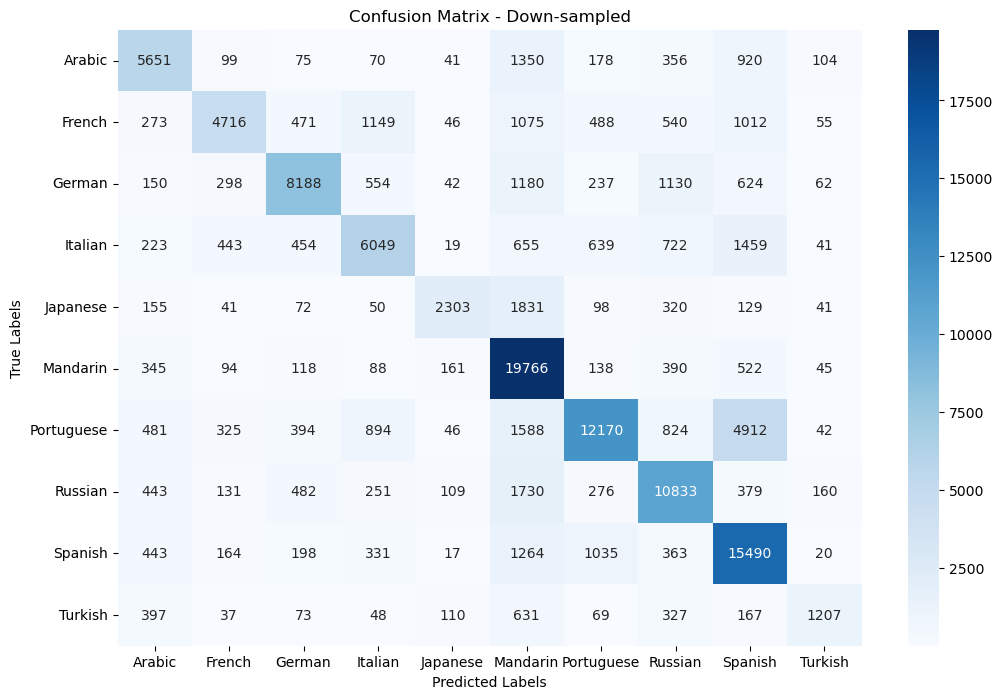

In [118]:
cm = confusion_matrix(real_labels_names, predicted_labels_names, labels=label_encoder.classes_)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Down-sampled')
plt.show()

In [119]:
results_df = pd.DataFrame({
    'cleaned_text_corrected': test_X,
    'true_label': test_Y,
    'predicted_label': predicted_labels_names
})

print(results_df.head())

                                   cleaned_text_corrected  true_label  \
130087  dear mam and dad, i'm going to go to edinburgh...    Mandarin   
94425   there are many events in my city will happen s...      Arabic   
183414  hi friends! i would like to receive you for a ...      French   
32831   i have a fried. her name is danielle. danielle...  Portuguese   
173615  bello.my name's lu min liang.i'm twenty-two.i'...    Mandarin   

       predicted_label  
130087        Mandarin  
94425           Arabic  
183414      Portuguese  
32831       Portuguese  
173615        Mandarin  


In [120]:
all_df = dl.load_data_excel_dataframe("Final database (main prompts).xlsx",
                                                         "Final database (alternative prompts).xlsx")

all_df = dl.remove_duplicate_text_corrected_rows(all_df, 'text_corrected')
all_df['cleaned_text_corrected'] = all_df['text_corrected'].apply(dl.clean_text).copy()



In [121]:
all_df

,writing_id,learner_id,learner_id_categorical,nationality,l1,cefr,cefr_numeric,level,unit,topic_id_original,...,secondary_topic,topic_to_keep,date,time,grade,wordcount,mtld,text,text_corrected,cleaned_text_corrected
0,961,130930,130930.0,br,Portuguese,A1,1,1,1,1,...,english,both topics,40614,23:24:33.520,78,41,67.240000,"\n\t Hi, My name's Leon. I don't speak englis...","Hi, My name's Leon. I don't speak english, but...","hi, my name's leon. i don't speak english, but..."
1,1523,18131,18131.0,sa,Arabic,A1,1,1,1,1,...,name,both topics,40617,02:24:17.907,83,24,26.880000,\n\t Hi.... From: To: Date: Hi! How are you? ...,Hi.... From: To: Date: Hi! How are you? My nam...,hi. from: to: date: hi! how are you? my name's...
2,2817,8501,8501.0,cn,Mandarin,A1,1,1,1,1,...,name,both topics,40617,11:21:38.090,82,25,43.750000,\n\t Dear Anna: I'm Xudong. I'm 33 years old....,Dear Anna: I'm auding. I'm 33 years old. Nice ...,dear anna: i'm auding. i'm 33 years old. nice ...
3,2887,13162,13162.0,fr,French,A1,1,1,1,1,...,name,both topics,40617,12:57:02.390,96,35,42.875000,"\n\t Hello! Nice to meet you. I am fine, than...","bello! Nice to meet you. I am fine, thanks. Ho...","bello! nice to meet you. i am fine, thanks. ho..."
4,2286,152797,152797.0,br,Portuguese,A1,1,1,1,1,...,english,both topics,40617,20:47:14.560,90,44,108.416000,\n\t Hi teacher! How are you? My name's Marco...,Hi teacher! How are you? My name's Marcos Mala...,hi teacher! how are you? my name's marcos mala...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723277,839087,148694,148694.0,de,German,C1,5,15,6,118,...,the,will,41712,08:36:18.883,100,236,73.635503,\n\t This is about a current and quite delica...,This is about a current and quite delicate iss...,this is about a current and quite delicate iss...
723278,809057,61664,61664.0,br,Portuguese,C1,5,15,6,118,...,the,will,41714,12:13:06.060,70,180,90.000000,\n\t Brazilian government don't take advantag...,Brazilian government don't take advantage from...,nationality government don't take advantage fr...
723279,1194073,172462,172462.0,jp,Japanese,C1,5,15,6,118,...,the,will,41714,23:11:19.140,80,159,84.551124,\n\t Foreigners were arrested by fake plice o...,foreigners were arrested by fake place officer...,foreigners were arrested by fake place officer...
723280,1103878,133121,133121.0,it,Italian,C1,5,15,6,118,...,the,will,41715,10:13:06.110,100,148,108.948685,"\n\t CRIMEA, PARLIAMENT REQUIRES RUSSIAN ANNE...","CIMA, PARLIAMENT REQUIRES RUSSIAN ANNEXATION R...","cima, parliament requires nationality annexati..."


In [122]:
for_cerf_df = all_df.merge(results_df, on='cleaned_text_corrected', how='right')

In [123]:
for_cerf_df

,writing_id,learner_id,learner_id_categorical,nationality,l1,cefr,cefr_numeric,level,unit,topic_id_original,...,date,time,grade,wordcount,mtld,text,text_corrected,cleaned_text_corrected,true_label,predicted_label
0,438010,87889,87889.0,cn,Mandarin,A2,2,5,1,33,...,41075,23:01:07.003,78,83,43.365385,"\n\t Dear mam and dad, I'M going to go to Edi...","Dear mam and dad, I'M going to go to Edinburgh...","dear mam and dad, i'm going to go to edinburgh...",Mandarin,Mandarin
1,1189741,147454,147454.0,sa,Arabic,A2,2,4,1,25,...,41672,17:00:19.677,90,27,37.856000,\n\t there are many events in my city will ha...,there are many events in my city will happen s...,there are many events in my city will happen s...,Arabic,Arabic
2,291061,169120,169120.0,fr,French,A2,2,4,3,27,...,40924,12:44:32.993,89,55,68.829091,\n\t Hi friends! I would like to receive you ...,Hi friends! I would like to receive you for a ...,hi friends! i would like to receive you for a ...,French,Portuguese
3,1118454,114991,114991.0,br,Portuguese,A1,1,1,4,4,...,41626,16:29:10.557,80,34,29.526316,\n\t I have a friedy. Her name is Danielle. D...,I have a fried. Her name is Danielle. Danielle...,i have a fried. her name is danielle. danielle...,Portuguese,Portuguese
4,468200,49329,49329.0,cn,Mandarin,A1,1,1,5,5,...,41096,11:19:39.013,98,24,0.000000,\n\t Hello.My name's Lu Min Jiang.I'm twenty-...,bello.My name's Lu Min liang.I'm twenty-two.I'...,bello.my name's lu min liang.i'm twenty-two.i'...,Mandarin,Mandarin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127408,533570,14484,14484.0,br,Portuguese,B1,3,7,1,49,...,41168,12:57:12.633,90,94,67.886044,\n\t An area of about 8 meters X by 3 meters ...,An area of about 8 meters X by 3 meters will b...,an area of about 8 meters x by 3 meters will b...,Portuguese,Mandarin
127409,22179,148061,148061.0,br,Portuguese,A2,2,6,4,44,...,41059,21:29:24.457,80,76,112.500000,\n\t Milene Almeida ### Beach Street Bahia #0...,Milone Almeida ### Beach Street Bahia #000-000...,milone almeida ### beach street bahia #000-000...,Portuguese,Portuguese
127410,487786,71204,71204.0,ru,Russian,A2,2,4,2,26,...,41082,15:19:59.180,95,69,33.628444,\n\t I get up at 7 o'clock. I sometimes make...,I get up at 7 o'clock. I sometimes make a bed....,i get up at 7 o'clock. i sometimes make a bed....,Russian,Mandarin
127411,399093,44434,44434.0,ru,Russian,A2,2,6,3,43,...,41137,13:49:32.770,95,66,55.516364,\n\t The Dress Code of our company. All emplo...,The Dress Code of our company. All employees m...,the dress code of our company. all employees m...,Russian,Russian


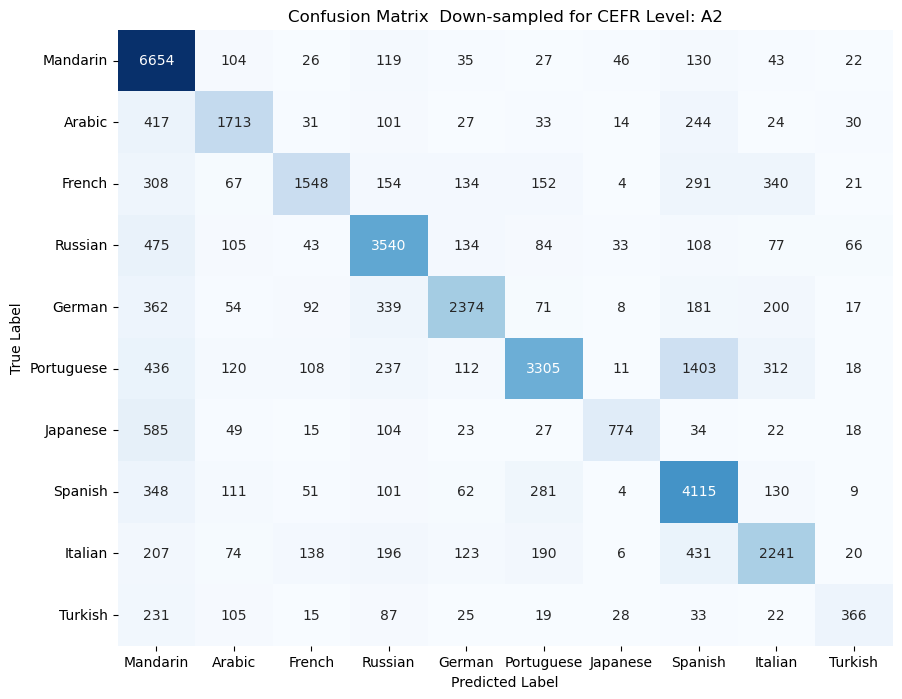

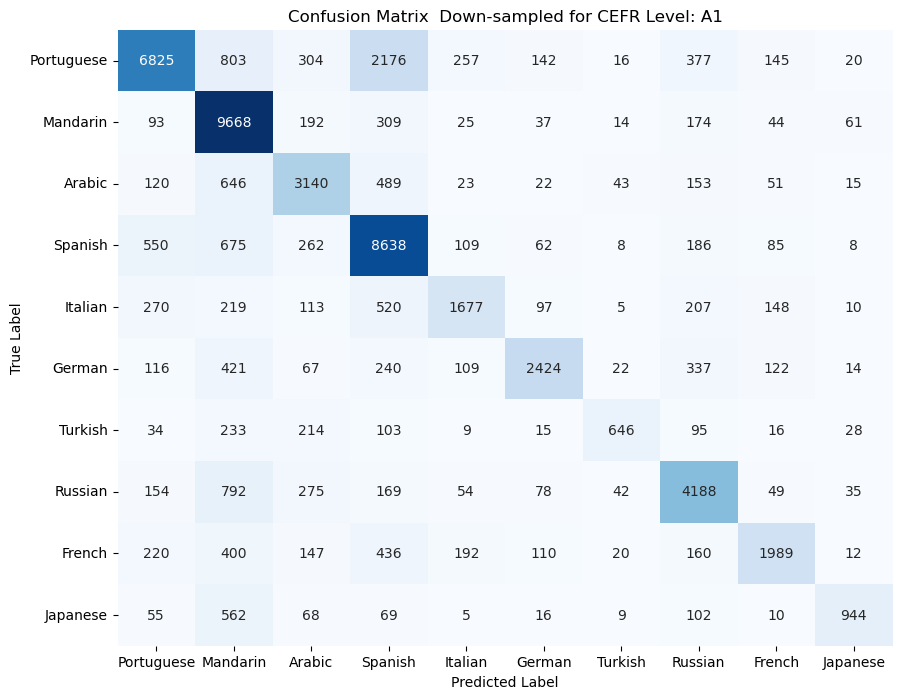

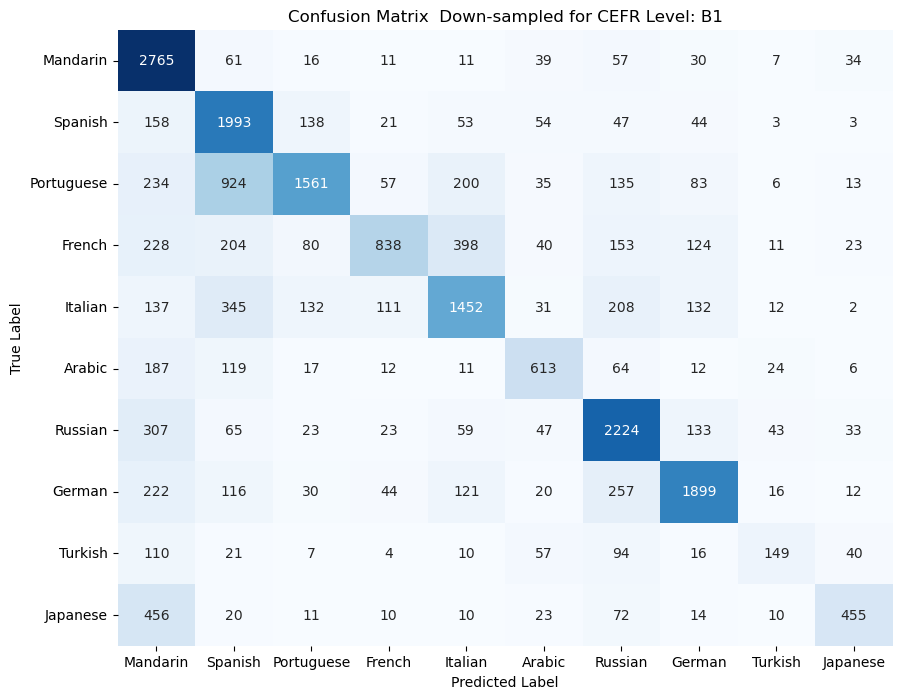

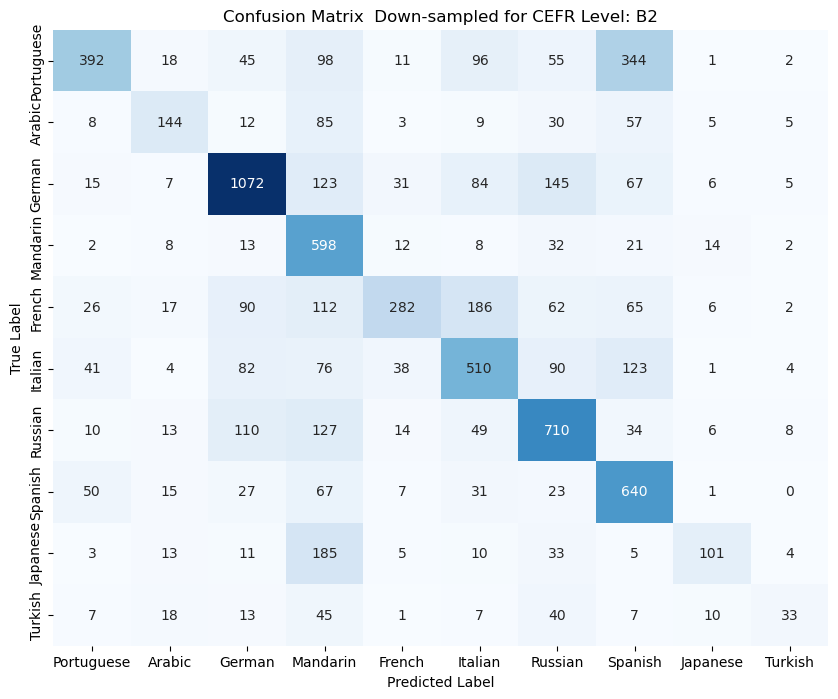

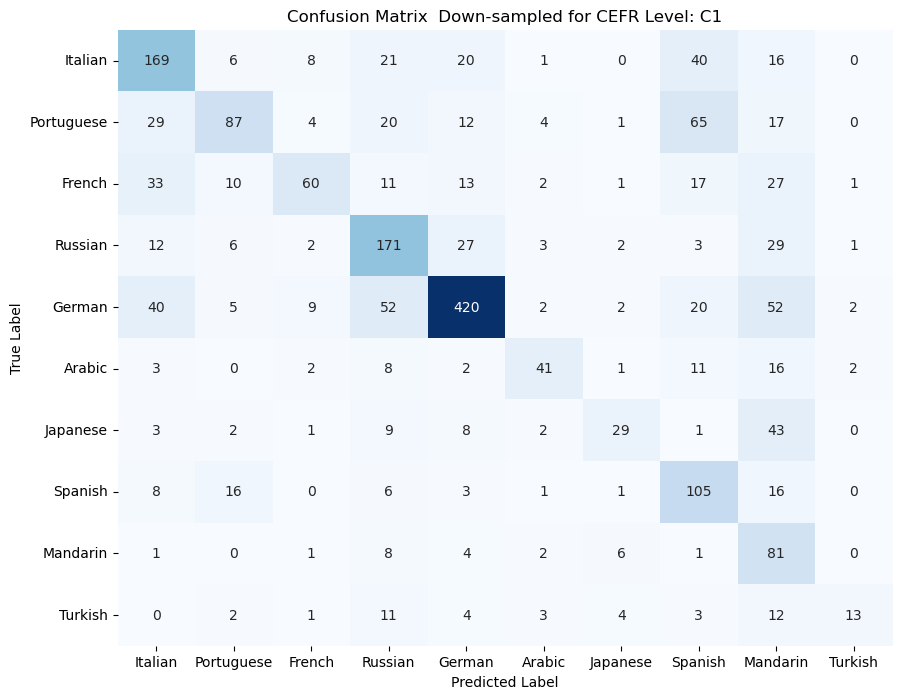

In [124]:
cefr_levels = for_cerf_df['cefr'].unique()

for cefr in cefr_levels:
    # Filter the DataFrame for the current CEFR level
    df_cefr = for_cerf_df[for_cerf_df['cefr'] == cefr]
    
    # Create a confusion matrix
    cm = confusion_matrix(df_cefr['true_label'], df_cefr['predicted_label'], labels=df_cefr['true_label'].unique())
    
    # Create a DataFrame from the confusion matrix for easier plotting
    cm_df = pd.DataFrame(cm, index=df_cefr['true_label'].unique(), columns=df_cefr['true_label'].unique())
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix  Down-sampled for CEFR Level: {cefr}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [125]:
cefr_levels = for_cerf_df['cefr'].unique()  

for cefr in cefr_levels:
    df_cefr = for_cerf_df[for_cerf_df['cefr'] == cefr]
    
    correct_predictions = (df_cefr['true_label'] == df_cefr['predicted_label']).sum()
    total_predictions = len(df_cefr)
    accuracy = correct_predictions / total_predictions
    
    print(f'Accuracy for CEFR level {cefr}: {accuracy:.4f}')


Accuracy for CEFR level A2: 0.6880
Accuracy for CEFR level A1: 0.7059
Accuracy for CEFR level B1: 0.6398
Accuracy for CEFR level B2: 0.5606
Accuracy for CEFR level C1: 0.5731


In [126]:
from scipy.stats import f_oneway, kruskal, mannwhitneyu
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Step 1: Calculate accuracy per CEFR level and store it in a list
cefr_accuracies = {}

for cefr in cefr_levels:
    df_cefr = for_cerf_df[for_cerf_df['cefr'] == cefr]
    correct_predictions = (df_cefr['true_label'] == df_cefr['predicted_label']).sum()
    total_predictions = len(df_cefr)
    accuracy = correct_predictions / total_predictions
    cefr_accuracies[cefr] = accuracy

# Prepare the accuracies list for the test
accuracies_list = [for_cerf_df[for_cerf_df['cefr'] == cefr].apply(
    lambda row: 1 if row['true_label'] == row['predicted_label'] else 0, axis=1).values for cefr in cefr_levels]


# Step 2: Perform ANOVA or Kruskal-Wallis test
# Using ANOVA
anova_result = f_oneway(*accuracies_list)
print(f"ANOVA p-value: {anova_result.pvalue}")

# Using Kruskal-Wallis (non-parametric alternative)
kruskal_result = kruskal(*accuracies_list)
print(f"Kruskal-Wallis p-value: {kruskal_result.pvalue}")




ANOVA p-value: 1.661151843402669e-210
Kruskal-Wallis p-value: 1.0654620903828478e-209


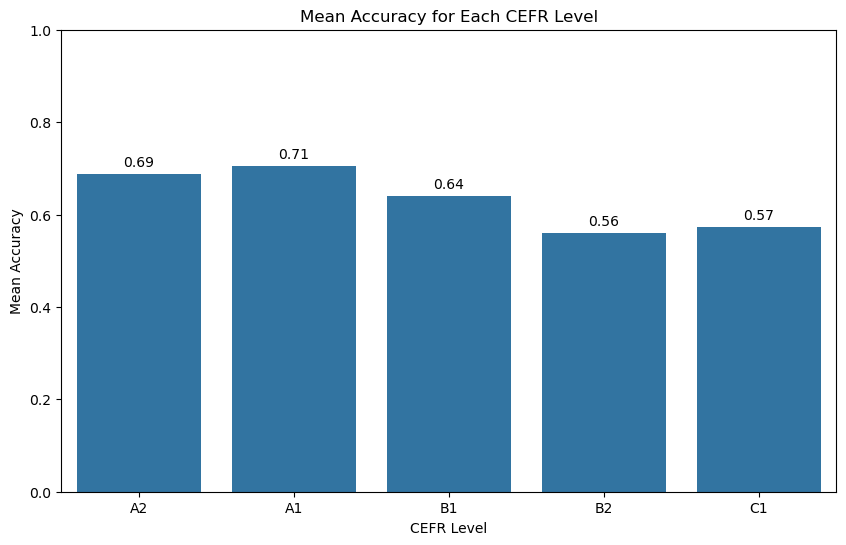

In [127]:
mean_accuracies = [accuracies.mean() for accuracies in accuracies_list]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cefr_levels, y=mean_accuracies)
plt.title('Mean Accuracy for Each CEFR Level')
plt.xlabel('CEFR Level')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)

for i, v in enumerate(mean_accuracies):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.show()

In [128]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = np.array([[accuracies.sum(), len(accuracies) - accuracies.sum()] for accuracies in accuracies_list])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square p-value: {p}")

if p < 0.05:
    print("There is a statistically significant association between CEFR level and model accuracy.")
else:
    print("No statistically significant association between CEFR level and model accuracy.")


Chi-square p-value: 1.0614026535726184e-209
There is a statistically significant association between CEFR level and model accuracy.
